In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load Library

In [2]:
! pip install dataframe-image &> /dev/null

In [3]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import re
import random
import statistics
import math
from collections import Counter

import scipy.stats as stats
from scipy.stats import f_oneway
from statsmodels.sandbox.stats.multicomp import MultiComparison
from scipy.stats import chi2_contingency
import urllib
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

import dataframe_image as dfi

%matplotlib inline

#pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Load Data

In [4]:
file_path_patient = "/content/drive/MyDrive/UT Austin/Research/HAI_Lab_Dr. Lee/COVID/Seton COVID Cohort Dataset Share SDH/covid_pts_enc_level_labs_dx_2021-02-02_deid.csv"
file_path_patient_extra = "/content/drive/MyDrive/UT Austin/Research/HAI_Lab_Dr. Lee/COVID/Seton COVID Cohort Dataset Share SDH/meds_admin_for_SOFA_COVID_cohort_SDH_share.csv"
file_path_zip_tx = '/content/drive/MyDrive/UT Austin/Research/HAI_Lab_Dr. Lee/COVID/datasets/zip_code_data.csv'
file_path_census_tract = '/content/drive/MyDrive/UT Austin/Research/HAI_Lab_Dr. Lee/COVID/datasets/zcta_tract_rel_10.txt'
file_path_svi_tx = '/content/drive/MyDrive/UT Austin/Research/HAI_Lab_Dr. Lee/COVID/datasets/Texas.csv'
#file_path_patient = "Seton COVID Cohort Dataset Share SDH/covid_pts_enc_level_labs_dx_2021-02-02_deid.csv"
#file_path_patient_extra = "Seton COVID Cohort Dataset Share SDH/meds_admin_for_SOFA_COVID_cohort_SDH_share.csv"
#file_path_zip_tx = 'datasets/zip_code_data.csv'
#file_path_census_tract = 'datasets/zcta_tract_rel_10.txt'
#file_path_svi_tx = 'datasets/Texas.csv'

# Read csv as a dataframe from the path
df = pd.read_csv(file_path_patient, index_col=False)
df_extra = pd.read_csv(file_path_patient_extra, index_col=False)
df_zip_tx = pd.read_csv(file_path_zip_tx, index_col=False)
df_census_tract = pd.read_csv(file_path_census_tract, index_col=False)
df_svi_tx = pd.read_csv(file_path_svi_tx)

# Define Functions

In [5]:
# https://www.mdcalc.com/sequential-organ-failure-assessment-sofa-score
# https://www.mdcalc.com/sequential-organ-failure-assessment-sofa-score#evidence
# https://ccforum.biomedcentral.com/articles/10.1186/s13054-019-2663-7
# https://data.cdc.gov/NCHS/Provisional-COVID-19-Deaths-by-Week-and-County-Soc/9hdi-ekmb

calibration_sofa_mortality = {
    0: 0.0,
    1: 0.0,
    2: 6.4,
    3: 6.4,
    4: 20.2,
    5: 20.2,
    6: 21.5,
    7: 21.5,
    8: 33.3,
    9: 33.3,
    10: 50.0,
    11: 50.0,
    12: 95.2,
    13: 95.2,
    14: 95.2,
    15: 95.2,
    16: 95.2,
    17: 95.2,
    18: 95.2,
    19: 95.2,
    20: 95.2,
    21: 95.2,
    22: 95.2,
    23: 95.2,
    24: 95.2
}

def calculate_sofa(patient):    # Calculate SOFA scores
    score = 0
    
    # 1. Respiratory system: PaO2/FiO2 (mmHg)
    if (patient['pO2_Art']/patient['FiO2/Percent'])*100 >= 300 and (patient['pO2_Art']/patient['FiO2/Percent'])*100 <= 399:
        score += 1 
        
    elif ((patient['pO2_Art']/patient['FiO2/Percent'])*100 >= 200 and (patient['pO2_Art']/patient['FiO2/Percent'])*100 <= 299) or ((patient['pO2_Art']/patient['FiO2/Percent'])*100 <= 199 and patient['vent_hours_summed'] == np.nan):
        score += 2
        
    #elif (patient['pO2_Art']/patient['FiO2/Percent'])*100 >= 100 and (patient['pO2_Art']/patient['FiO2/Percent'])*100 <= 199 and patient['vent_hours_summed'].notnull() == True:
    elif (patient['pO2_Art']/patient['FiO2/Percent'])*100 >= 100 and (patient['pO2_Art']/patient['FiO2/Percent'])*100 <= 199 and patient['vent_hours_summed'] != np.nan:
        score += 3
        
    elif (patient['pO2_Art']/patient['FiO2/Percent'])*100 < 100 and patient['vent_hours_summed'] != np.nan:
        score += 4
        
    # 2. Nervous system: Glasgow Coma Scale
    if patient['Glasgow_Coma_Score'] == 13 or patient['Glasgow_Coma_Score'] == 14:
        score += 1 
        
    elif patient['Glasgow_Coma_Score'] >= 10 and patient['Glasgow_Coma_Score'] <= 12:
        score += 2
        
    elif patient['Glasgow_Coma_Score'] >= 6 and patient['Glasgow_Coma_Score'] <= 9:
        score += 3
        
    elif patient['Glasgow_Coma_Score'] < 6:
        score += 4
    
    # 3. Cardiovascular system: Mean arterial pressure (MAP) OR administration of vasopressors required
    if patient['Mean_Arterial_Pressure'] < 70:
        score += 1 
    
    elif (patient['medication_name']=='dopamine' and patient['dose_of_medication'] <= 5) or (patient['medication_name']=='dobuTamine' and patient['dose_of_medication'] !=np.nan):
        score += 2

    elif (patient['medication_name']=='dopamine' and patient['dose_of_medication'] > 5 and patient['medication_name']=='epinephrine' and patient['dose_of_medication'] <= 0.1)or (patient['medication_name']=='norepinephrine' and patient['dose_of_medication'] <= 0.1):
        score += 3
   
    elif (patient['medication_name']=='dopamine' and patient['dose_of_medication'] > 15 and patient['medication_name']=='epinephrine' and patient['dose_of_medication'] > 0.1) or (patient['medication_name']=='norepinephrine' and patient['dose_of_medication'] > 0.1):
        score += 4

    # 4. Liver: Bilirubin (mg/dl) [μmol/L] 
    if float(patient['Bili_Total']) >= 1.2 and float(patient['Bili_Total']) <= 1.9:
        score += 1 
        
    elif float(patient['Bili_Total']) >= 2.0 and float(patient['Bili_Total']) <= 5.9:
        score += 2
        
    elif float(patient['Bili_Total']) >= 6.0 and float(patient['Bili_Total']) <= 11.9:
        score += 3
        
    elif float(patient['Bili_Total']) >= 12.0:
        score += 4

    # 5. Coagulation: Platelets ×103/ml
    if patient['Platelet'] >= 100 and patient['Platelet'] < 150:
        score += 1 
        
    elif patient['Platelet'] >= 50 and patient['Platelet'] < 100:
        score += 2
        
    elif patient['Platelet'] >= 20 and patient['Platelet'] < 50:
        score += 3
        
    elif patient['Platelet'] < 20:
        score += 4
        
    # 6. Kidneys: Creatinine (mg/dl) [μmol/L]; urine output
    if patient['Creatinine'] >= 1.2 and patient['Creatinine'] <= 1.9:
        score += 1 
        
    elif patient['Creatinine'] >= 2.0 and patient['Creatinine'] <= 3.4:
        score += 2
        
    elif patient['Creatinine'] >= 3.5 and patient['Creatinine'] <= 4.9:
        score += 3
        
    elif patient['Creatinine'] >= 5.0:
        score += 4 
    
    return score

def count_comorbidity(patient): # Calculate comorbidity conditions
    count = 0 
    
    if patient.COPD_com_flag == 1:
        count += 1 
        
    if patient.asthma_com_flag == 1:
        count += 1 
        
    if patient.diabetes_com_flag == 1:
        count += 1 
        
    if patient.hypertension_com_flag == 1:
        count += 1 
        
    if patient.CAD_com_flag == 1:
        count += 1 
        
    if patient.heartfailure_com_flag == 1: 
        count += 1 
        
    if patient.CKD_com_flag == 1:
        count += 1 
        
    if patient.cancer_com_flag == 1:
        count += 1 
        
    return count

def percentage_death(svi): # Calculate percentage of deaths for each race
    #print(svi)
    count = count_svi[svi.SVI] # Number of patients in their racial groups
    #print(count)
    #print((svi.count_death / count) * 100)
    return (svi.count_death / count) * 100

ls_race = ['White', 'Black or African American', 'Hispanic or Latino', 'Asian']
def latinx(patient):    # Clean up race/ethnicity
    if patient['ethnicity_display'] == 'Hispanic or Latino' and patient['race_display'] == 'White':
        return "Hispanic or Latino"
    elif patient['ethnicity_display'] == 'Not Hispanic or Latino' and patient['race_display'] == 'White': 
        return "White"
    elif patient['race_display'] == 'Hispanic':
        return "Hispanic or Latino"
    else:
        return patient['race_display']

ls_svi = ['Low', 'Moderate', 'High']
def categorize_svi(patient):    # Clean up race/ethnicity
    if patient['RPL_THEMES'] < 0:
        return "Unknown"
    elif patient['RPL_THEMES'] >= 0 and patient['RPL_THEMES'] <= 0.333: 
        return "Low"
    elif patient['RPL_THEMES'] >= 0.334 and patient['RPL_THEMES'] <= 0.666: 
        return "Moderate"
    elif patient['RPL_THEMES'] >= 0.667 and patient['RPL_THEMES'] <= 1: 
        return "High"

def visualize_count_mortality(df, policy):
    df['level'] = df['level'].replace(to_replace=[2.0], value=['Observed'])
    x_val = list(df['level'].unique())
    x_val.append(x_val.pop(0))
    sns_plot = sns.catplot(x='level', y='count_death', hue='SVI', data=df, kind='bar', height=4, aspect=3, order=x_val)
    plt.title('Allocation Scheme ({})'.format(policy))
    plt.xlabel('Vent Availability(%)')
    plt.ylabel('Mortality Count')
    plt.show()
    sns_plot.savefig("/content/drive/MyDrive/UT Austin/Research/HAI_Lab_Dr. Lee/COVID/figures_new/count_death_{}_svi.png".format(policy))

def visualize_percentage_mortality(df, policy):
    df['level'] = df['level'].replace(to_replace=[2.0], value=['Observed'])
    x_val = list(df['level'].unique())
    x_val.append(x_val.pop(0))
    sns_plot = sns.catplot(x='level', y='percentage_death', hue='SVI', data=df, kind='bar', order=x_val, height=4, aspect=3)
    plt.title('Allocation Scheme ({})'.format(policy))
    plt.xlabel('Vent Availability(%)')
    plt.ylabel('Mortality Rate')
    sns_plot._legend.set_title('SVI')
    sns_plot.savefig("/content/drive/MyDrive/UT Austin/Research/HAI_Lab_Dr. Lee/COVID/figures_new/percentage_death_{}_svi.png".format(policy))
    

# Preprocess Data

## Data: Extra

In [6]:
# Extract only rows containing 'mcg/kg/min'.
# Remove 'mcg/kg/min' from string and convert the numeric values into float.
df_extra = df_extra.loc[df_extra['dose_of_medication'].str.contains('mcg/kg/min')].copy()
df_extra['dose_of_medication'] =  df_extra.loc[:, 'dose_of_medication'].apply(lambda x: re.sub('mcg/kg/min', '0', x)).copy()
df_extra['dose_of_medication'] = df_extra.loc[:, 'dose_of_medication'].apply(lambda x: re.sub('\ .*','', x)).copy()
df_extra['dose_of_medication'] = df_extra['dose_of_medication'].astype(float)

# There are encounters that have multiple 'dose_of_medication' for each encounter
# Extract only rows including the maximum values in 'dose_of_medication' for each encounter.
df_extra = df_extra.groupby(['medication_name', 'deid_fin_encounter']).max().reset_index()

print(df_extra.shape)
df_extra.head()

(147, 5)


medication_name  deid_fin_encounter  dose_of_medication  \
0      dobuTamine               25093                2.50   
1      dobuTamine               30090                5.00   
2      dobuTamine               36262                5.00   
3      dobuTamine               44845                0.75   
4        dopamine               32723                0.00   

            administration_dt_tm  SOFA  
0  2020-10-26T13:00:00.000-05:00   NaN  
1  2020-09-10T12:40:00.000-05:00   NaN  
2  2020-10-21T15:00:00.000-05:00   NaN  
3  2020-11-13T00:19:00.000-06:00   NaN  
4  2020-11-05T11:56:00.000-06:00   NaN

## Data: Zip Code

In [7]:
# Delete columns: male_poverty_rate, female_poverty_rate, mean_income
df_zip_tx =  df_zip_tx.loc[:, ['zip_code', 'median_income', 'poverty_rate']]

print(df_zip_tx.shape)
df_zip_tx.head()

(1935, 3)


zip_code median_income poverty_rate
0  ZCTA5 75001         72512         10.9
1  ZCTA5 75002        101429          4.9
2  ZCTA5 75006         64462         10.8
3  ZCTA5 75007         86648          6.7
4  ZCTA5 75009        111146            4

In [8]:
df_zip_tx['zip_code'] = df_zip_tx['zip_code'].apply(lambda row: row.strip('ZCTA5 '))

ls_zip_error = []   
for code in df_zip_tx['zip_code']: # There zip codes that are not 5-digit number
    if len(code) != 5:
        ls_zip_error.append(code)

print("All zip codes: {}".format(len(df_zip_tx)))
print("Normal zip codes (5-digit): {}".format(len(df_zip_tx)-len(ls_zip_error)))
print('Abnormal zip codes (Non 5-digit): {}'.format(len(ls_zip_error)))

All zip codes: 1935
Normal zip codes (5-digit): 1744
Abnormal zip codes (Non 5-digit): 191


In [9]:
# https://www.zipcodestogo.com/Texas/
# https://worldpopulationreview.com/zips/texas

#for code in ls_zip_error:
#    print("------------------------------------------------")
#    print(df_zip.loc[df_zip["zip_code"]==code, "zip_code"])
#    print(df_zip.loc[df_zip["zip_code"].str.contains(code), "zip_code"])

# Erroneous zip codes are cut off if there are single or continuous 5
for zip_error in ls_zip_error:  # Attach 5s as last digits to erroneous zip codes
  if len(zip_error) == 4:
    df_zip_tx.loc[df_zip_tx["zip_code"]==zip_error, "zip_code"] = df_zip_tx.loc[df_zip_tx["zip_code"]==zip_error, "zip_code"].values[0] + str(5)
  elif len(zip_error) == 3:
    df_zip_tx.loc[df_zip_tx["zip_code"]==zip_error, "zip_code"] = df_zip_tx.loc[df_zip_tx["zip_code"]==zip_error, "zip_code"].values[0] + str(55)
  elif len(zip_error) == 1:
    df_zip_tx.loc[df_zip_tx["zip_code"]==zip_error, "zip_code"] = df_zip_tx.loc[df_zip_tx["zip_code"]==zip_error, "zip_code"].values[0] + str(5555)

df_zip_tx["zip_code"] = df_zip_tx["zip_code"].astype(int)

## Data: Census Tract

In [10]:
# https://www.census.gov/programs-surveys/geography/technical-documentation/records-layout/2010-census-tract-record-layout.html

# Extract only data from Texas state(=48)
df_census_tract_tx = df_census_tract.loc[df_census_tract['STATE']==48].copy()
df_census_tract_tx.reset_index(drop=True, inplace=True)

print(df_census_tract_tx.shape)
df_census_tract_tx.head()

# Extract only data from Texas state Travis county
# df_census_tract_tx_travis = df_census_tract.loc[(df_census_tract['STATE']==48) & (df_census_tract['COUNTY']==453)].copy()

(10009, 25)


ZCTA5  STATE  COUNTY   TRACT        GEOID  POPPT  HUPT     AREAPT  \
0  73949     48     421  950200  48421950200    410   190  287805986   
1  75001     48     113   13616  48113013616   4152  3223    2014512   
2  75001     48     113   13725  48113013725      0     0     247511   
3  75001     48     113   13726  48113013726   2673  1488    1593774   
4  75001     48     113   13727  48113013727   3231  1983    4937525   

    AREALANDPT   ZPOP   ZHU       ZAREA   ZAREALAND  TRPOP  TRHU      TRAREA  \
0    287805986   1688   764  1366353259  1360361346   3034  1252  2391079318   
1      2014512  12414  8102     9940470     9931768   5611  4018     3630263   
2       247511  12414  8102     9940470     9931768   3615  1909     1839456   
3      1585072  12414  8102     9940470     9931768   2673  1488     1593774   
4      4937525  12414  8102     9940470     9931768   3235  1984     5171932   

   TRAREALAND  ZPOPPCT  ZHUPCT  ZAREAPCT  ZAREALANDPCT  TRPOPPCT  TRHUPCT  \
0  2390650564    24.29   24.87     21.06         21.16     13.51    15.18   
1     3630263    33.45   39.78     20.27         20.28     74.00    80.21   
2     1839456     0.00    0.00      2.49          2.49      0.00     0.00   
3     1585072    21.53   18.37     16.03         15.96    100.00   100.00   
4     5171932    26.03   24.48     49.67         49.71     99.88    99.95   

   TRAREAPCT  TRAREALANDPCT  
0      12.04          12.04  
1      55.49          55.49  
2      13.46          13.46  
3     100.00         100.00  
4      95.47          95.47

In [11]:
# print(set(df_zip_tx["zip_code"]).difference(set(df_census_tract_tx["ZCTA5"])))
# print(set(df_census_tract_tx["ZCTA5"]).difference(set(df_zip_tx["zip_code"])))
# ls_zip_unmatched = set(df_zip_tx["zip_code"]).difference(df_census_tract_tx["ZCTA5"])

# Remove zip codes not associated with Texas
ls_idx = df_census_tract_tx.index
ls_idx_drop = []

for code in [73949, 88063, 88220, 88430]:
  idx = ls_idx[df_census_tract_tx["ZCTA5"]==code]
  ls_idx_drop.append(idx.to_list()[0])

df_census_tract_tx.drop(ls_idx_drop, inplace=True)

## Data: SVI

It seems that different zip codes indicate one single GEOID(Census Tract). In other words, the census tract number can indicate multiple zip codes.

In [12]:
# https://www.atsdr.cdc.gov/placeandhealth/svi/documentation/SVI_documentation_2018.html

# Use only columns for socioeconomic status: 'FIPS', 'E_TOTPOP', 'E_POV', 'E_UNEMP', 'E_PCI', 'E_NOHSDP'
df_svi_tx = df_svi_tx[[
    'FIPS', 'E_TOTPOP', 'E_POV', 'EP_POV', 'E_UNEMP', 'EP_UNEMP', 'E_PCI', 'E_NOHSDP', 'EP_NOHSDP',
    'RPL_THEME1', 'RPL_THEME2', 'RPL_THEME3', 'RPL_THEME4', 'RPL_THEMES',
    'F_THEME1', 'F_THEME2', 'F_THEME3', 'F_THEME4', 'F_TOTAL']]

print(df_svi_tx.shape)
df_svi_tx.head()

(5254, 19)


FIPS  E_TOTPOP  E_POV  EP_POV  E_UNEMP  EP_UNEMP  E_PCI  E_NOHSDP  \
0  48001950100      5164    827    16.2       65       3.1  26849       386   
1  48001950401      4872      3     1.0        0       0.0   2520      1061   
2  48001950402      7548     44    20.3        4       2.2   1329      2190   
3  48001950500      4569    946    21.1      110       5.3  15961       577   
4  48001950600      5570    549    10.0       99       3.8  19854      1053   

   EP_NOHSDP  RPL_THEME1  RPL_THEME2  RPL_THEME3  RPL_THEME4  RPL_THEMES  \
0       10.9      0.3853      0.7610      0.1308      0.7545      0.4965   
1       25.4      0.4162      0.0230      0.3439      0.5421      0.2477   
2       30.3      0.6895      0.0626      0.3219      0.3123      0.3422   
3       19.5      0.7202      0.7878      0.6467      0.9167      0.8433   
4       28.6      0.5552      0.4861      0.2766      0.7387      0.5470   

   F_THEME1  F_THEME2  F_THEME3  F_THEME4  F_TOTAL  
0         0         0         0         1        1  
1         1         0         0         1        2  
2         1         1         0         1        3  
3         0         0         0         0        0  
4         0         0         0         0        0

In [13]:
# Replace SVI scores that are -999(NULL) with numpy nan value
df_svi_tx.loc[df_svi_tx["RPL_THEMES"] < 0, "RPL_THEMES"] = np.nan

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


## Data: Sample(df_icu)

In [14]:
# Patients who were admitted to ICU, had SOFA scores, and were in one of racial groups (White, Black or African American, Hispanic or Latino, Asian)
df_icu = df.loc[df['icu_hours_summed'].notnull()]

print(df_icu.shape)
df_icu.head()

(741, 70)


admit_dt_tm      discharge_dt_tm        facility  \
0   2020-08-25 20:51:00  2020-09-01 14:30:00     Shoal Creek   
1   2020-03-24 00:07:00  2020-03-26 18:30:00  Medical Center   
6   2020-03-26 15:21:00  2020-04-08 13:15:00  Medical Center   
11  2020-03-28 18:59:00  2020-06-01 15:15:00  Medical Center   
17  2020-03-31 14:14:00  2020-04-17 17:20:00  Medical Center   

          encounter_type_display  age_at_admit  gender zip_cust_table  \
0   IP Private/Semi Private room            49    Male        Unknown   
1                         IP ICU            44    Male          78130   
6   IP Private/Semi Private room            49  Female          78612   
11                        IP ICU            24    Male          78753   
17                        IP ICU            55    Male          78602   

         ethnicity_display race_display       race_eth_comb  length_of_stay  \
0       Hispanic or Latino        White      White Hispanic            6.75   
1       Hispanic or Latino        White      White Hispanic            2.75   
6   Not Hispanic or Latino        White  White Non Hispanic           12.92   
11  Not Hispanic or Latino        White  White Non Hispanic           64.88   
17  Not Hispanic or Latino        White  White Non Hispanic           17.13   

   icd_prim   deceased_dt_tm discharge_disposition_display dc_dispo_cat  \
0       NaN              NaN                          Home         Home   
1     A41.9  3/26/2020 14:10                       Expired      Expired   
6     U07.1              NaN                          Home         Home   
11    U07.1              NaN       Long Term Care Hospital          NaN   
17    U07.1  4/17/2020 14:08                       Expired      Expired   

   insured_uninsured              admit_source     arrival_mode  \
0            Unknown  Transfer from a Hospital              NaN   
1            Insured  Transfer from a Hospital              NaN   
6            Insured            Emergency room  Private Vehicle   
11           Insured  Transfer from a Hospital              NaN   
17           Insured            Emergency room  Private Vehicle   

    vent_hours_summed vent_first_order_start_time vent_last_order_end_time  \
0                 NaN                         NaN                      NaN   
1               58.45         2020-03-24 05:55:00      2020-03-26 16:22:00   
6              293.02         2020-03-28 11:14:00      2020-04-03 14:31:00   
11            1423.18         2020-03-28 22:09:00      2020-05-27 04:53:00   
17             327.77         2020-04-07 08:40:00      2020-04-17 15:56:00   

    icu_hours_summed icu_first_begin_time    icu_last_end_time  \
0              36.55  2020-08-25 20:53:00  2020-08-27 09:26:00   
1              69.48  2020-03-23 21:01:00  2020-03-26 18:30:00   
6             160.17  2020-03-30 20:19:00  2020-04-06 12:29:00   
11           1559.88  2020-03-28 15:22:00  2020-06-01 15:15:00   
17            336.42  2020-04-03 16:55:00  2020-04-17 17:20:00   

             occupation                 occ_cat    emp_yn  Creatinine  \
0                   NaN  Not yet chart searched       NaN         1.1   
1                   NaN  Not yet chart searched       NaN         2.9   
6                 TxDOT        Municipal worker  Employed         0.9   
11              Student                   Other  Employed         1.5   
17  Business - Drilling                Business  Employed         1.2   

    Abs_Lymph  ALT    AST Bili_Total D-Dimer  Diastolic_Blood_Pressure  \
0         NaN  NaN    NaN        NaN     NaN                       NaN   
1         2.0   94  253.0        3.1   >5250                      21.0   
6         0.8   43   48.0        0.5     599                      79.0   
11        4.2   69  146.0        0.4   >5250                      68.0   
17        1.0   20   36.0        0.6     224                      76.0   

    Dosing_Weight_(kg)  FiO2/Percent  Glasgow_Coma_Score  Lymph_Auto  \
0                  NaN           NaN 

In [15]:
# Make a distinction between White and Hispanic/Latino
df_icu.loc[:, ['race_display']] = df_icu.loc[:, ['race_display', 'ethnicity_display']].apply(lambda patient: latinx(patient), axis=1)
df_icu = df_icu.loc[df_icu['race_display'].isin(ls_race)]

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [16]:
# Fill out the missing values in columns related to comorbodity conditions with 0
# Convert True/False value into 1/0
cols_comorbidity = ['COPD_com_flag', 'asthma_com_flag', 'diabetes_com_flag',
                    'hypertension_com_flag', 'CAD_com_flag', 'heartfailure_com_flag',
                    'CKD_com_flag', 'cancer_com_flag']

df_icu[cols_comorbidity] = df_icu[cols_comorbidity].fillna(0)
df_icu[cols_comorbidity] = df_icu[cols_comorbidity].astype(int)

In [17]:
# Generate columns for comorbidity count and flag
df_icu['count_comorbidity'] = df_icu.apply(lambda patient: count_comorbidity(patient), axis=1)
df_icu['has_comorbidity'] = df_icu['count_comorbidity'].apply(lambda count: 1 if count >= 1 else 0)

In [18]:
# Generate column for age
df_icu['life_years'] = df_icu['age_at_admit'].apply(lambda age: 100 - age)

In [19]:
# Filter out patients who do not have specific zip codes or have ones out ot Texas
display(df_icu.loc[(df_icu['zip_cust_table']=='Unknown') | (df_icu['zip_cust_table']=='10029')])
df_icu.drop(df_icu.index[df_icu['zip_cust_table']=='Unknown'], inplace=True)
df_icu.drop(df_icu.index[df_icu['zip_cust_table']=='10029'], inplace=True)

admit_dt_tm      discharge_dt_tm                facility  \
0     2020-08-25 20:51:00  2020-09-01 14:30:00             Shoal Creek   
867   2020-11-21 15:03:00                  NaN          Medical Center   
1790  2020-08-27 22:44:00  2020-08-30 12:58:00  Dell Seton Med Cntr UT   
2221  2020-11-20 17:10:00                  NaN  Dell Seton Med Cntr UT   
2224  2020-11-21 14:10:00                  NaN  Dell Seton Med Cntr UT   

            encounter_type_display  age_at_admit  gender zip_cust_table  \
0     IP Private/Semi Private room            49    Male        Unknown   
867                         IP ICU            68  Female        Unknown   
1790               IP Private Room            77    Male          10029   
2221               IP Private Room            81    Male        Unknown   
2224                        IP ICU            64    Male        Unknown   

           ethnicity_display               race_display  \
0         Hispanic or Latino         Hispanic or Latino   
867       Hispanic or Latino         Hispanic or Latino   
1790  Not Hispanic or Latino  Black or African American   
2221  Not Hispanic or Latino                      White   
2224      Hispanic or Latino         Hispanic or Latino   

                race_eth_comb  length_of_stay icd_prim deceased_dt_tm  \
0              White Hispanic            6.75      NaN            NaN   
867            White Hispanic             NaN      NaN            NaN   
1790  Other race Non Hispanic            2.58    I16.1            NaN   
2221       White Non Hispanic             NaN      NaN            NaN   
2224           White Hispanic             NaN      NaN            NaN   

     discharge_disposition_display     dc_dispo_cat insured_uninsured  \
0                             Home             Home           Unknown   
867                Still a patient  Still a patient           Unknown   
1790          Skilled Nursing Care        Rehab/SNF           Insured   
2221               Still a patient  Still a patient           Unknown   
2224                           NaN  Still a patient           Unknown   

                  admit_source     arrival_mode  vent_hours_summed  \
0     Transfer from a Hospital              NaN                NaN   
867             Emergency Dept  Private Vehicle                NaN   
1790  Transfer from a Hospital              NaN                NaN   
2221            Emergency Dept  Private Vehicle                NaN   
2224  Transfer from a Hospital              NaN                NaN   

     vent_first_order_start_time vent_last_order_end_time  icu_hours_summed  \
0                            NaN                      NaN             36.55   
867                          NaN                      NaN             33.13   
1790                         NaN                      NaN             23.33   
2221                         NaN                      NaN             53.13   
2224                         NaN                      NaN              1.73   

     icu_first_begin_time    icu_last_end_time occupation  \
0     2020-08-25 20:53:00  2020-08-27 09:26:00        NaN   
867   2020-11-21 20:16:00  2020-11-23 05:24:00        NaN   
1790  2020-08-27 20:50:00  2020-08-28 20:10:00        NaN   
2221  2020-11-20 22:39:00  2020-11-23 03:47:00        NaN   
2224  2020-11-21 12:26:00  2020-11-21 14:10:00        NaN   

                     occ_cat emp_yn  Creatinine  Abs_Lymph  ALT    AST  \
0     Not yet chart searched    NaN         1.1        NaN  NaN    NaN   
867   Not yet chart searched    NaN         2.8       2.30   26   37.0   
1790  Not yet chart searched    NaN         3.5       1.74   14   26.0   
2221  Not yet chart searched    NaN         1.2       1.53   40  102.0   
2224  Not yet chart searched    NaN         0.9       0.69   50   67.0   

     Bili_Total D-Dimer  Diastolic_Blood_Pressure  Dosing_Weight_(kg)  \
0           NaN     NaN                       NaN                 NaN   
867         0.9     NaN        

In [20]:
df_icu['zip_cust_table'] = df_icu['zip_cust_table'].astype('int64')

## Merge dataframes

### df_icu & df_extra

In [21]:
df_icu = df_icu.merge(df_extra, on='deid_fin_encounter', how='left')

print(df_icu.shape)
df_icu.head()

(712, 77)


admit_dt_tm      discharge_dt_tm        facility  \
0  2020-03-24 00:07:00  2020-03-26 18:30:00  Medical Center   
1  2020-03-26 15:21:00  2020-04-08 13:15:00  Medical Center   
2  2020-03-28 18:59:00  2020-06-01 15:15:00  Medical Center   
3  2020-03-31 14:14:00  2020-04-17 17:20:00  Medical Center   
4  2020-03-31 21:23:00  2020-04-08 14:40:00  Medical Center   

         encounter_type_display  age_at_admit  gender  zip_cust_table  \
0                        IP ICU            44    Male           78130   
1  IP Private/Semi Private room            49  Female           78612   
2                        IP ICU            24    Male           78753   
3                        IP ICU            55    Male           78602   
4  IP Private/Semi Private room            40  Female           78704   

        ethnicity_display        race_display            race_eth_comb  \
0      Hispanic or Latino  Hispanic or Latino           White Hispanic   
1  Not Hispanic or Latino               White       White Non Hispanic   
2  Not Hispanic or Latino               White       White Non Hispanic   
3  Not Hispanic or Latino               White       White Non Hispanic   
4                 Unknown               White  White Unknown Ethnicity   

   length_of_stay icd_prim   deceased_dt_tm discharge_disposition_display  \
0            2.75    A41.9  3/26/2020 14:10                       Expired   
1           12.92    U07.1              NaN                          Home   
2           64.88    U07.1              NaN       Long Term Care Hospital   
3           17.13    U07.1  4/17/2020 14:08                       Expired   
4            7.71   A41.89              NaN                          Home   

  dc_dispo_cat insured_uninsured              admit_source     arrival_mode  \
0      Expired           Insured  Transfer from a Hospital              NaN   
1         Home           Insured            Emergency room  Private Vehicle   
2          NaN           Insured  Transfer from a Hospital              NaN   
3      Expired           Insured            Emergency room  Private Vehicle   
4         Home           Insured            Emergency Dept        Ambulance   

   vent_hours_summed vent_first_order_start_time vent_last_order_end_time  \
0              58.45         2020-03-24 05:55:00      2020-03-26 16:22:00   
1             293.02         2020-03-28 11:14:00      2020-04-03 14:31:00   
2            1423.18         2020-03-28 22:09:00      2020-05-27 04:53:00   
3             327.77         2020-04-07 08:40:00      2020-04-17 15:56:00   
4                NaN                         NaN                      NaN   

   icu_hours_summed icu_first_begin_time    icu_last_end_time  \
0             69.48  2020-03-23 21:01:00  2020-03-26 18:30:00   
1            160.17  2020-03-30 20:19:00  2020-04-06 12:29:00   
2           1559.88  2020-03-28 15:22:00  2020-06-01 15:15:00   
3            336.42  2020-04-03 16:55:00  2020-04-17 17:20:00   
4             47.40  2020-04-02 17:18:00  2020-04-04 16:42:00   

              occupation                 occ_cat    emp_yn  Creatinine  \
0                    NaN  Not yet chart searched       NaN         2.9   
1                  TxDOT        Municipal worker  Employed         0.9   
2                Student                   Other  Employed         1.5   
3    Business - Drilling                Business  Employed         1.2   
4  Hospital Housekeeping                     HCW  Employed         0.7   

   Abs_Lymph ALT    AST Bili_Total D-Dimer  Diastolic_Blood_Pressure  \
0        2.0  94  253.0        3.1   >5250                      21.0   
1        0.8  43   48.0        0.5     599                      79.0   
2        4.2  69  146.0        0.4   >5250                      68.0   
3        1.0  20   36.0        0.6     224                      76.0   
4        NaN  44   45.0        0.3     264                      82.0   

   Dosing_Weight_(kg)  FiO2/Percent  Glasgow_Coma_Score  Lymph_Auto  \
0      

In [22]:
# Add SOFA scores based on extra dataset
df_icu.loc[:, ['SOFA']] = df_icu.apply(lambda row: calculate_sofa(row), axis=1)

### df_census_tract_tx & df_svi_tx

In [23]:
ls_geoid = df_census_tract_tx["GEOID"].unique()
ls_fips = df_svi_tx["FIPS"].unique()

print("Unidentified FIPS codes in active in df_census_tract_tx")
print("Exist in df_svi_tx but not in df_census_tract_tx")
print((set(ls_fips).difference(set(ls_geoid))))

Unidentified FIPS codes in active in df_census_tract_tx
Exist in df_svi_tx but not in df_census_tract_tx
{48039990000, 48071710600}


In [24]:
df_svi_tract = df_census_tract_tx.merge(df_svi_tx, left_on='GEOID', right_on='FIPS', how='inner')
df_svi_tract.drop(columns=['FIPS'], inplace=True)
df_svi_tract = df_svi_tract.sort_values(by=['ZCTA5']).reset_index(drop=True)
print(df_svi_tract.shape)
df_svi_tract.head()

(10005, 43)


ZCTA5  STATE  COUNTY  TRACT        GEOID  POPPT  HUPT   AREAPT  \
0  75001     48     113  13616  48113013616   4152  3223  2014512   
1  75001     48     113  20700  48113020700      0     0   132554   
2  75001     48     113  13725  48113013725      0     0   247511   
3  75001     48     113  13806  48113013806      1     1   388475   
4  75001     48     113  13726  48113013726   2673  1488  1593774   

    AREALANDPT   ZPOP   ZHU    ZAREA  ZAREALAND  TRPOP  TRHU   TRAREA  \
0      2014512  12414  8102  9940470    9931768   5611  4018  3630263   
1       132554  12414  8102  9940470    9931768   5022  2323  6197519   
2       247511  12414  8102  9940470    9931768   3615  1909  1839456   
3       388475  12414  8102  9940470    9931768   2515  1701  5895780   
4      1585072  12414  8102  9940470    9931768   2673  1488  1593774   

   TRAREALAND  ZPOPPCT  ZHUPCT  ZAREAPCT  ZAREALANDPCT  TRPOPPCT  TRHUPCT  \
0     3630263    33.45   39.78     20.27         20.28     74.00    80.21   
1     6008118     0.00    0.00      1.33          1.33      0.00     0.00   
2     1839456     0.00    0.00      2.49          2.49      0.00     0.00   
3     5889290     0.01    0.01      3.91          3.91      0.04     0.06   
4     1585072    21.53   18.37     16.03         15.96    100.00   100.00   

   TRAREAPCT  TRAREALANDPCT  E_TOTPOP  E_POV  EP_POV  E_UNEMP  EP_UNEMP  \
0      55.49          55.49      7223    528     7.3      121       2.2   
1       2.14           2.21      4523    381     8.4       88       3.0   
2      13.46          13.46      4009    956    23.8       89       3.9   
3       6.59           6.60      3997    206     5.2       88       2.8   
4     100.00         100.00      2896    470    16.4       95       5.0   

   E_PCI  E_NOHSDP  EP_NOHSDP  RPL_THEME1  RPL_THEME2  RPL_THEME3  RPL_THEME4  \
0  49609       409        7.3      0.1157      0.0103      0.6218      0.2275   
1  46286       333        8.9      0.1754      0.1486      0.3942      0.0648   
2  26067       387       14.5      0.5296      0.2624      0.6318      0.6154   
3  52464        36        1.1      0.0489      0.0142      0.4311      0.5544   
4  45758       156        7.3      0.3316      0.1029      0.6408      0.2250   

   RPL_THEMES  F_THEME1  F_THEME2  F_THEME3  F_THEME4  F_TOTAL  
0      0.0891         0         0         0         1        1  
1      0.1012         0         0         0         0        0  
2      0.5323         0         0         0         0        0  
3      0.1154         0         0         0         1        1  
4      0.2625         0         0         0         0        0

In [25]:
# Filter zip codes that have multiple tracts
df_svi_tract_grouped_zip = df_svi_tract.groupby(['ZCTA5']).agg({'TRACT':'count'})
display(df_svi_tract_grouped_zip)

# List of zip codes that are associated with multiple tract numbers
ls_zip_multiple_tract = df_svi_tract_grouped_zip.loc[df_svi_tract_grouped_zip['TRACT']>1].index.values.tolist()

TRACT
ZCTA5       
75001      7
75002     13
75006     14
75007     19
75009      3
...      ...
79934      4
79935      4
79936     23
79938     13
79942      1

[1935 rows x 1 columns]

### df_icu & df_svi_census_tract

In [26]:
ls_zip_icu = df_icu['zip_cust_table'].unique()
ls_zip_zip_tx = df_zip_tx['zip_code'].unique()

print('Unique zip code in df_icu: {}'.format(df_icu['zip_cust_table'].nunique()))
print('Unique zip code in df_zip_tx: {}'.format(df_zip_tx['zip_code'].nunique()))
# Zip codes that found among ICU patients
# There are 2 patients who have 78761 and and 2 others 78667
print('Zip codes that exist in both df_icu and df_zip_tx: {}'.format(len(set(ls_zip_icu).intersection(set(ls_zip_zip_tx)))))
print("Unidentified zip codes in active in df_icu")
print("Zip codes that exist in zip_icu but not in zip_tx")
print((set(ls_zip_icu).difference(set(ls_zip_zip_tx))))
print('ICU patients: {}'.format(len(df_icu)))
print('ICU patients who can be connected to df_zip_tx: {}'.format(len(df_icu.loc[df_icu['zip_cust_table'].isin(list(set(ls_zip_icu).intersection(set(ls_zip_zip_tx))))])))

Unique zip code in df_icu: 117
Unique zip code in df_zip_tx: 1935
Zip codes that exist in both df_icu and df_zip_tx: 110
Unidentified zip codes in active in df_icu
Zip codes that exist in zip_icu but not in zip_tx
{78720, 78761, 78762, 78667, 77875, 78646, 78680}
ICU patients: 712
ICU patients who can be connected to df_zip_tx: 703


In [27]:
ls_zip_icu = df_icu['zip_cust_table'].unique()
ls_zip_svi_tract = df_svi_tract['ZCTA5'].unique()

# Zip codes that found among ICU patients 
print('Zip codes that exist in both df_icu and df_svi_tract: {}'.format(len(set(ls_zip_icu).intersection(set(ls_zip_svi_tract)))))
print('ICU patients: {}'.format(len(df_icu)))
print('ICU patients who can be connected to df_svi_tract: {}'.format(len(df_icu.loc[df_icu['zip_cust_table'].isin(ls_zip_svi_tract)])))

Zip codes that exist in both df_icu and df_svi_tract: 110
ICU patients: 712
ICU patients who can be connected to df_svi_tract: 703


In [28]:
ls_zip = df_zip_tx['zip_code'].unique()
ls_zip_svi_tract = df_svi_tract['ZCTA5'].unique()

print('Unique zip code in df_zip_tx: {}'.format(df_zip_tx['zip_code'].nunique()))
print('Unique zip code in df_svi_tract: {}'.format(df_svi_tract['ZCTA5'].nunique()))
print('Zip codes that exist in both df_zip and df_svi_tract: {}'.format(len(set(ls_zip).intersection(set(ls_zip_svi_tract)))))

Unique zip code in df_zip_tx: 1935
Unique zip code in df_svi_tract: 1935
Zip codes that exist in both df_zip and df_svi_tract: 1935


In [29]:
df_icu['zip_cust_table'].dtype

dtype('int64')

In [30]:
df_svi_tract['ZCTA5'].dtype

dtype('int64')

In [31]:
df_icu = df_icu.merge(df_svi_tract, left_on='zip_cust_table', right_on='ZCTA5', how='inner').copy()

print(df_icu.shape)
df_icu.head()

(6823, 120)


admit_dt_tm      discharge_dt_tm        facility  \
0  2020-03-24 00:07:00  2020-03-26 18:30:00  Medical Center   
1  2020-03-24 00:07:00  2020-03-26 18:30:00  Medical Center   
2  2020-03-24 00:07:00  2020-03-26 18:30:00  Medical Center   
3  2020-03-24 00:07:00  2020-03-26 18:30:00  Medical Center   
4  2020-03-24 00:07:00  2020-03-26 18:30:00  Medical Center   

  encounter_type_display  age_at_admit gender  zip_cust_table  \
0                 IP ICU            44   Male           78130   
1                 IP ICU            44   Male           78130   
2                 IP ICU            44   Male           78130   
3                 IP ICU            44   Male           78130   
4                 IP ICU            44   Male           78130   

    ethnicity_display        race_display   race_eth_comb  length_of_stay  \
0  Hispanic or Latino  Hispanic or Latino  White Hispanic            2.75   
1  Hispanic or Latino  Hispanic or Latino  White Hispanic            2.75   
2  Hispanic or Latino  Hispanic or Latino  White Hispanic            2.75   
3  Hispanic or Latino  Hispanic or Latino  White Hispanic            2.75   
4  Hispanic or Latino  Hispanic or Latino  White Hispanic            2.75   

  icd_prim   deceased_dt_tm discharge_disposition_display dc_dispo_cat  \
0    A41.9  3/26/2020 14:10                       Expired      Expired   
1    A41.9  3/26/2020 14:10                       Expired      Expired   
2    A41.9  3/26/2020 14:10                       Expired      Expired   
3    A41.9  3/26/2020 14:10                       Expired      Expired   
4    A41.9  3/26/2020 14:10                       Expired      Expired   

  insured_uninsured              admit_source arrival_mode  vent_hours_summed  \
0           Insured  Transfer from a Hospital          NaN              58.45   
1           Insured  Transfer from a Hospital          NaN              58.45   
2           Insured  Transfer from a Hospital          NaN              58.45   
3           Insured  Transfer from a Hospital          NaN              58.45   
4           Insured  Transfer from a Hospital          NaN              58.45   

  vent_first_order_start_time vent_last_order_end_time  icu_hours_summed  \
0         2020-03-24 05:55:00      2020-03-26 16:22:00             69.48   
1         2020-03-24 05:55:00      2020-03-26 16:22:00             69.48   
2         2020-03-24 05:55:00      2020-03-26 16:22:00             69.48   
3         2020-03-24 05:55:00      2020-03-26 16:22:00             69.48   
4         2020-03-24 05:55:00      2020-03-26 16:22:00             69.48   

  icu_first_begin_time    icu_last_end_time occupation  \
0  2020-03-23 21:01:00  2020-03-26 18:30:00        NaN   
1  2020-03-23 21:01:00  2020-03-26 18:30:00        NaN   
2  2020-03-23 21:01:00  2020-03-26 18:30:00        NaN   
3  2020-03-23 21:01:00  2020-03-26 18:30:00        NaN   
4  2020-03-23 21:01:00  2020-03-26 18:30:00        NaN   

                  occ_cat emp_yn  Creatinine  Abs_Lymph ALT    AST Bili_Total  \
0  Not yet chart searched    NaN         2.9        2.0  94  253.0        3.1   
1  Not yet chart searched    NaN         2.9        2.0  94  253.0        3.1   
2  Not yet chart searched    NaN         2.9        2.0  94  253.0        3.1   
3  Not yet chart searched    NaN         2.9        2.0  94  253.0        3.1   
4  Not yet chart searched    NaN         2.9        2.0  94  253.0        3.1   

  D-Dimer  Diastolic_Blood_Pressure  Dosing_Weight_(kg)  FiO2/Percent  \
0   >5250                      21.0                99.2          50.0   
1   >5250                      21.0                99.2          50.0   
2   >5250                      21.0                99.2          50.0   
3   >5250                      21.0                99.2          50.0   
4   >5250                      21.0                99.2          50.0   

   Glasgow_Coma_Score  Lymph_Auto Oxygen_Delivery_Method  Oxygen_Saturation  \
0                 3.0         5.7  

In [32]:
# Filter encounter ids that have multiple tracts 
df_icu_group_id = df_icu.groupby(['deid_fin_encounter']).agg({'TRACT':'count'}).sort_values(by="TRACT", ascending=False).reset_index()
df_icu_group_id

deid_fin_encounter  TRACT
0                 44845     57
1                 32723     48
2                 33974     39
3                 30090     36
4                 33932     36
..                  ...    ...
670               41226      2
671               44013      1
672               13106      1
673               46271      1
674               16059      1

[675 rows x 2 columns]

In [33]:
# Filter zip codes that have multiple tracts 
df_icu_group_zip = df_icu.groupby(['ZCTA5']).agg({'TRACT':'count'}).sort_values(by='TRACT', ascending=False).reset_index()
df_icu_group_zip

ZCTA5  TRACT
0    78753    720
1    78744    429
2    78640    400
3    78741    390
4    78666    306
..     ...    ...
105  79845      2
106  77988      1
107  78948      1
108  78159      1
109  76578      1

[110 rows x 2 columns]

## Drop necessary columns and Generate df_sample

In [34]:
cols_sample = [
    'deid_fin_encounter', 'age_at_admit', 'gender', 'race_display', 'insured_uninsured', 'icu_hours_summed', 'vent_hours_summed',
    'SOFA', 'has_comorbidity', 'count_comorbidity', 'life_years', 'discharge_disposition_display', 'deceased_dt_tm',
    'ZCTA5', 'TRACT', 'GEOID', 'E_TOTPOP', 'E_POV', 'EP_POV', 'E_UNEMP', 'EP_UNEMP', 'E_PCI', 'E_NOHSDP', 'EP_NOHSDP',
    'RPL_THEME1', 'RPL_THEME2', 'RPL_THEME3', 'RPL_THEME4', 'RPL_THEMES',
    'F_THEME1', 'F_THEME2', 'F_THEME3', 'F_THEME4', 'F_TOTAL'
    ]

df_sample = df_icu[cols_sample].copy()

print(df_sample.shape)
df_sample.head()

(6823, 34)


deid_fin_encounter  age_at_admit gender        race_display  \
0               27818            44   Male  Hispanic or Latino   
1               27818            44   Male  Hispanic or Latino   
2               27818            44   Male  Hispanic or Latino   
3               27818            44   Male  Hispanic or Latino   
4               27818            44   Male  Hispanic or Latino   

  insured_uninsured  icu_hours_summed  vent_hours_summed  SOFA  \
0           Insured             69.48              58.45    11   
1           Insured             69.48              58.45    11   
2           Insured             69.48              58.45    11   
3           Insured             69.48              58.45    11   
4           Insured             69.48              58.45    11   

   has_comorbidity  count_comorbidity  life_years  \
0                0                  0          56   
1                0                  0          56   
2                0                  0          56   
3                0                  0          56   
4                0                  0          56   

  discharge_disposition_display   deceased_dt_tm  ZCTA5   TRACT        GEOID  \
0                       Expired  3/26/2020 14:10  78130  210604  48187210604   
1                       Expired  3/26/2020 14:10  78130  310401  48091310401   
2                       Expired  3/26/2020 14:10  78130  210508  48187210508   
3                       Expired  3/26/2020 14:10  78130  210507  48187210507   
4                       Expired  3/26/2020 14:10  78130  310300  48091310300   

   E_TOTPOP  E_POV  EP_POV  E_UNEMP  EP_UNEMP  E_PCI  E_NOHSDP  EP_NOHSDP  \
0     11660    471     4.1       92       1.6  32900       510        6.6   
1      5792    568    10.6       55       2.0  20071       885       23.8   
2      2891    236     8.2       40       2.7  27927       262       13.9   
3      7022    572     8.1      114       3.2  37467       350        8.2   
4      7669    782    10.7       16       0.5  39723       367        6.4   

   RPL_THEME1  RPL_THEME2  RPL_THEME3  RPL_THEME4  RPL_THEMES  F_THEME1  \
0      0.1136      0.5101      0.3487      0.2089      0.2043         0   
1      0.4606      0.7211      0.6150      0.9574      0.7379         0   
2      0.2963      0.4174      0.4034      0.5187      0.3806         0   
3      0.2003      0.3312      0.2833      0.1289      0.1615         0   
4      0.1376      0.7062      0.1572      0.8164      0.3996         0   

   F_THEME2  F_THEME3  F_THEME4  F_TOTAL  
0         0         0         0        0  
1         0         0         1        1  
2         0         0         0        0  
3         0         0         0        0  
4         1         0         1        2

## Remove duplicate TRACT

In [35]:
# List of patients who are recorded with multiple tract numbers in a single zip code
ls_patient_multi_tract = df_sample.loc[df_sample['deid_fin_encounter'].duplicated()==True, 'deid_fin_encounter'].unique().tolist()

# Count patients for each tract number
df_tract_cnt_patient = df_sample.loc[df_sample['ZCTA5'].isin(ls_zip_multiple_tract)].groupby(['TRACT']).agg({'deid_fin_encounter':'count'}).reset_index()
df_tract_cnt_patient.rename(columns={'deid_fin_encounter':'count_patient'}, inplace=True)

print(df_tract_cnt_patient.shape)
df_tract_cnt_patient.head()

(506, 2)


TRACT  count_patient
0    100             35
1    101             12
2    102             11
3    106              1
4    107              1

In [36]:
# Calculate variance of SVI scores among patients having multiple TRACT numbers
# Leave only tract number for each patient that has the most number of patients
ls_var = []

for idx, id in enumerate(ls_patient_multi_tract):
    
    ls_tract_per_patient = df_sample.loc[df_sample['deid_fin_encounter']==id, 'TRACT'].tolist() # make a list of multiple tract numbers for a single patient
    df_tmp_per_patient = df_tract_cnt_patient.loc[df_tract_cnt_patient['TRACT'].isin(ls_tract_per_patient)] # Number of patients for each tract number
    
    var = statistics.variance(df_sample.loc[df_sample['deid_fin_encounter']==id, 'RPL_THEMES'].values)  # Calculate variance of SVI scores of multiple tract numbers for each patient
    ls_var.append(var)

    max_tract = df_tmp_per_patient[df_tmp_per_patient['count_patient']==df_tmp_per_patient['count_patient'].max()]['TRACT'].values[0]   # Pick a tract number that has the maximum number of patients
    ls_drop_tract = df_sample.loc[df_sample['deid_fin_encounter']==id].index[df_sample.loc[df_sample['deid_fin_encounter']==id, 'TRACT']!=max_tract].tolist()   # List of tract numbers except the one with maximum number of patients
    df_sample.drop(ls_drop_tract, inplace=True)

In [37]:
# Categorize SVI values into three sets
df_sample.loc[:, ['cat_SVI']] = df_sample.loc[:, ['RPL_THEMES']].apply(lambda patient: categorize_svi(patient), axis=1)
df_sample = df_sample.loc[df_sample['cat_SVI'].isin(ls_svi)]

Variance of SVI scores of sample: 0.0832388887032814
Variance of SVI scores of Texas: 0.08336533097388593
Average variance of SVI scores: 0.04336678860168124
Max SVI score: 0.9969
Min SVI score: 0.0063


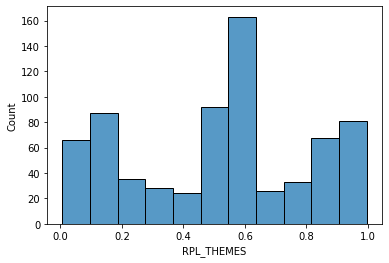

In [38]:
print("Variance of SVI scores of sample: {}".format(np.nanvar(df_sample['RPL_THEMES'].values)))
print("Variance of SVI scores of Texas: {}".format(np.nanvar(df_svi_tx['RPL_THEMES'].values)))
print("Average variance of SVI scores: {}".format(np.nanmean(ls_var)))
print("Max SVI score: {}".format(df_sample['RPL_THEMES'].max()))
print("Min SVI score: {}".format(df_sample['RPL_THEMES'].min()))

sns.histplot(data=df_sample['RPL_THEMES'])

## Distribution of SOFA scores

In [39]:
df_sample_pct_sofa = df_sample.groupby(['SOFA']).agg({'deid_fin_encounter': 'count'}).copy()
df_sample_pct_sofa['percentage'] = df_sample_pct_sofa.loc[:, ['deid_fin_encounter']].apply(lambda x: round(x/x.sum(), 2))
df_sample_pct_sofa.rename(columns={'deid_fin_encounter':'count_patient'}, inplace=True)
df_sample_pct_sofa

count_patient  percentage
SOFA                           
0               147        0.21
1                86        0.12
2                47        0.07
3                67        0.10
4                92        0.13
5                62        0.09
6                49        0.07
7                32        0.05
8                33        0.05
9                36        0.05
10               11        0.02
11               19        0.03
12                9        0.01
13                8        0.01
14                2        0.00
15                1        0.00
17                1        0.00
19                1        0.00

In [40]:
count_svi = Counter(df_sample['cat_SVI'])
count_svi

Counter({'High': 191, 'Low': 206, 'Moderate': 306})

In [41]:
df_left = df_sample.groupby(['SOFA'])[['deid_fin_encounter']].agg('count').reset_index(level=['SOFA'], col_level=1).rename(columns={'deid_fin_encounter': 'num_patients'})
df_tmp = {"SOFA": 16, "num_patients": 0}
df_left = df_left.append(df_tmp, ignore_index=True)
df_tmp = {"SOFA": 18, "num_patients": 0}
df_left = df_left.append(df_tmp, ignore_index=True)
df_left = df_left.sort_values(by=["SOFA"]).reset_index(drop=True)

df_right = df_sample.loc[df_sample['discharge_disposition_display']=='Expired'].groupby(['SOFA'])[['deid_fin_encounter']].agg('count').reset_index(level=['SOFA'], col_level=1).rename(columns={'deid_fin_encounter': 'num_death'})
df_tmp = {"SOFA": 14, "num_death": 0}
df_right = df_right.append(df_tmp, ignore_index=True)
df_tmp = {"SOFA": 16, "num_death": 0}
df_right = df_right.append(df_tmp, ignore_index=True)
df_tmp = {"SOFA": 18, "num_death": 0}
df_right = df_right.append(df_tmp, ignore_index=True)
df_right = df_right.sort_values(by=["SOFA"]).reset_index(drop=True)

In [42]:
df_center = df_left.merge(df_right, on='SOFA', how='left')
df_center['percentage_death'] = round(df_center['num_death']/df_center['num_patients']*100, 0)
df_center

SOFA  num_patients  num_death  percentage_death
0      0           147          3               2.0
1      1            86          4               5.0
2      2            47          4               9.0
3      3            67         16              24.0
4      4            92         22              24.0
5      5            62         20              32.0
6      6            49         21              43.0
7      7            32          9              28.0
8      8            33         15              45.0
9      9            36         20              56.0
10    10            11          9              82.0
11    11            19          9              47.0
12    12             9          3              33.0
13    13             8          4              50.0
14    14             2          0               0.0
15    15             1          1             100.0
16    16             0          0               NaN
17    17             1          1             100.0
18    18             0          0               NaN
19    19             1          1             100.0

In [43]:
tmp = df_sample.groupby(by=["race_display"]).agg({'deid_fin_encounter': 'count'})
tmp['percentage'] = tmp.loc[:, ['deid_fin_encounter']].apply(lambda x: round(x/x.sum(), 2))
tmp.rename(columns={'deid_fin_encounter':'count_patient'}, inplace=True)
tmp = tmp.reset_index()
tmp

race_display  count_patient  percentage
0                      Asian              7        0.01
1  Black or African American             61        0.09
2         Hispanic or Latino            376        0.53
3                      White            259        0.37

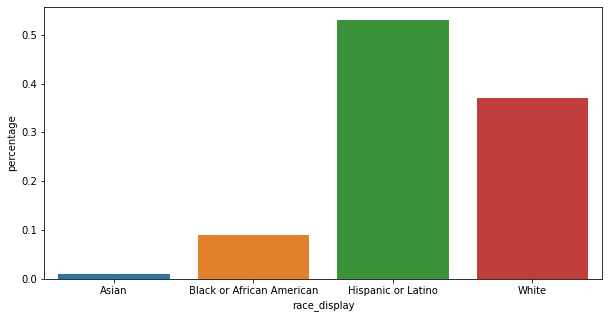

In [44]:
fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(
    data=tmp,
    x="race_display",
    y="percentage"
)

In [45]:
df_sample['vent_hours_summed'].value_counts()

0.02      4
93.05     3
206.60    3
465.20    3
341.08    3
         ..
528.28    1
179.39    1
410.60    1
0.67      1
89.75     1
Name: vent_hours_summed, Length: 265, dtype: int64

In [46]:
df_sample.loc[df_sample['vent_hours_summed']!=np.nan]

deid_fin_encounter  age_at_admit  gender               race_display  \
5                  27818            44    Male         Hispanic or Latino   
23                 43894            71    Male         Hispanic or Latino   
41                 48974            71    Male         Hispanic or Latino   
59                 17000            47  Female                      White   
73                 23744            49  Female                      White   
...                  ...           ...     ...                        ...   
6797               30021             5  Female  Black or African American   
6803               15181            22    Male                      White   
6810               46693            61  Female                      White   
6813               39810            51    Male                      White   
6822               41226            59  Female                      White   

     insured_uninsured  icu_hours_summed  vent_hours_summed  SOFA  \
5              Insured             69.48              58.45    11   
23             Insured            598.51             352.62     5   
41             Insured             21.50                NaN     1   
59             Insured             43.03                NaN     0   
73             Insured            160.17             293.02     2   
...                ...               ...                ...   ...   
6797         Uninsured             44.47              48.78     3   
6803           Insured             13.58                NaN     1   
6810           Insured            204.05                NaN     2   
6813         Uninsured            158.55                NaN     2   
6822           Insured              2.72                NaN     3   

      has_comorbidity  count_comorbidity  life_years  \
5                   0                  0          56   
23                  1                  2          29   
41                  1                  3          29   
59                  0                  0          53   
73                  0                  0          51   
...               ...                ...         ...   
6797                0                  0          95   
6803                0                  0          78   
6810                1                  2          39   
6813                1                  3          49   
6822                1                  3          41   

     discharge_disposition_display   deceased_dt_tm  ZCTA5   TRACT  \
5                          Expired  3/26/2020 14:10  78130  310902   
23                      Rehab Care              NaN  78130  310902   
41            Skilled Nursing Care              NaN  78130  310902   
59                 Still a patient              NaN  78130  310902   
73                            Home              NaN  78612  950802   
...                            ...              ...    ...     ...   
6797                       Expired              NaN  78207  170200   
6803                          Home              NaN  78132  310902   
6810                          Home              NaN  78652   10901   
6813                          Home              NaN  76527  960100   
6822                           NaN              NaN  78609  970100   

            GEOID  E_TOTPOP  E_POV  EP_POV  E_UNEMP  EP_UNEMP  E_PCI  \
5     48091310902      9736    194     2.0      107       2.1  33293   
23    48091310902      9736    194     2.0      107       2.1  33293   
41    48091310902      9736    194     2.0      107       2.1  33293   
59    48091310902      9736    194     2.0      107       2.1  33293   
73    48021950802      7625   1011    13.3      334       8.6  21691   
...           ...       ...    ...     ...      ...       ...    ...   
6797  48029170200      5507   2354    42.7      263      12.2  11186   
6803  48091310902      9736    194     2.0      107       2.1  33293   
6810  48209010901      8211     74     0.9      119       2.9  46362   
6813  48053960100 

In [47]:
df_sample['vent_hours_summed']<=0

5       False
23      False
41      False
59      False
73      False
        ...  
6797    False
6803    False
6810    False
6813    False
6822    False
Name: vent_hours_summed, Length: 703, dtype: bool

# Develop allocation

In [48]:
iter_simulation = 1000  # The number of simulations

vent_availability_pct = np.linspace(0,1,11)   # Percentage of ventilator availability
vent_availability_pct.round(1)

class Allocation(object):
  
    def __init__(self, df, vent_availability_pct, calibration_sofa_mortality):
        self.patients = df.copy() 
        self.patients['death'] = [0 for _ in range(len(self.patients))]             # All patients initially survive
        self.patients['allocate_vent'] = [0 for _ in range(len(self.patients))]     # All patients are not initially allocated to ventilators  
        self.num_vent = int(len(self.patients) * vent_availability_pct)             # Number of ventilators available
        self.model_mortality = calibration_sofa_mortality

    def __run_allocation(self, df):
        df_prioritized = df.copy()
        df_prioritized.reset_index(drop=True, inplace=True)
        print('Number of vents available: {}'.format(self.num_vent))
        num_vent_tmp = self.num_vent
        
        for i, patient in df_prioritized.iterrows():     # Allocate ventilators

            if num_vent_tmp == 0:                      # If no more ventialtors available, then stop allocating ventilators
                break
            
            df_prioritized.loc[i, 'allocate_vent'] = 1
            num_vent_tmp -= 1
        '''
        Calculate mortality of patients in ties
        '''
        if df_prioritized.loc[df_prioritized.index==(self.num_vent-1), 'SOFA'].values == df_prioritized.loc[df_prioritized.index==(self.num_vent), 'SOFA'].values:    # When a tie occurs
            print('Tie occurs')
            tie_sofa = df_prioritized.loc[df_prioritized.index==(self.num_vent-1), 'SOFA'].values
            print('------------------------------TIE SOFA: {}------------------------------'.format(tie_sofa[0]))
            print('------------------------------MORTALITY PROBABILITY: {}------------------------------'.format(self.model_mortality[tie_sofa[0]]))

            if df_prioritized.loc[df_prioritized['SOFA']==tie_sofa[0]].first_valid_index() == 0:    # When a tie occurs from the first patient
                df_tie_allocated = df_prioritized.loc[(df_prioritized['allocate_vent']==1) & (df_prioritized['SOFA']==tie_sofa[0])].copy()
                #display(df_tie_allocated)
                df_tie_allocated_not = df_prioritized.loc[(df_prioritized['allocate_vent']==0) & (df_prioritized['SOFA']==tie_sofa[0])].copy()
                #display(df_tie_allocated_not)
                df_tie_comb = pd.concat([df_tie_allocated, df_tie_allocated_not])
                #display(pd.concat([df_tie_allocated, df_tie_allocated_not]))
                df_count_death_tie = self.mortality_tie(df_tie_comb, tie_sofa[0]).copy()
                print('-----------------------TIE-----------------------')
                display(df_count_death_tie)

                df_count_death_allocated_not = self.mortality_allocated_not(df_prioritized.loc[(df_prioritized['allocate_vent']==0) & (df_prioritized['SOFA']!=tie_sofa[0])].copy())
                print('-----------------------NOT ALLOCATED-----------------------')
                display(df_count_death_allocated_not)

                df_count_death_final = df_count_death_tie.set_index('cat_SVI').add(df_count_death_allocated_not.set_index('cat_SVI'), fill_value=0).reset_index()
                df_count_death_final.rename(columns={'expected_death': 'count_death'}, inplace=True)
                print('-----------------------TOTAL-----------------------')
                df_count_death_final = df_count_death_final[['cat_SVI', 'count_death']]
                df_count_death_final.drop_duplicates(inplace=True)
                display(df_count_death_final)
                return df_count_death_final
            else:
                cut_off_idx_before = df_prioritized.loc[df_prioritized['SOFA']==tie_sofa[0]].first_valid_index()
                cut_off_idx_after = df_prioritized.loc[df_prioritized['SOFA']==tie_sofa[0]].last_valid_index()
                
                # 1. table
                print('-----------------------ALLOCATED-----------------------')
                display(df_prioritized.loc[:cut_off_idx_before-1])
                df_count_death_allocated = self.mortality_allocated(df_prioritized.loc[:cut_off_idx_before-1].copy())
                display(df_count_death_allocated)
                
                # 2. table
                print('-----------------------TIE-----------------------')
                display(df_prioritized.loc[cut_off_idx_before:cut_off_idx_after])
                df_count_death_tie = self.mortality_tie(df_prioritized.loc[cut_off_idx_before:cut_off_idx_after], tie_sofa[0]).copy()
                display(df_count_death_tie)

                # 3. table
                print('-----------------------NOT ALLOCATED-----------------------')
                display(df_prioritized.loc[cut_off_idx_after+1:])
                df_count_death_allocated_not = self.mortality_allocated_not(df_prioritized.loc[cut_off_idx_after+1:].copy())
                display(df_count_death_allocated_not)
       
                print('-----------------------TOTAL-----------------------')
                df_count_death_final = df_count_death_allocated.set_index('cat_SVI').add(df_count_death_tie.set_index('cat_SVI'), fill_value=0).reset_index()
                df_count_death_final = df_count_death_final.set_index('cat_SVI').add(df_count_death_allocated_not.set_index('cat_SVI'), fill_value=0).reset_index()
                df_count_death_final.rename(columns={'expected_death': 'count_death'}, inplace=True)
                df_count_death_final = df_count_death_final[['cat_SVI', 'count_death']]
                df_count_death_final.drop_duplicates(inplace=True)
                display(df_count_death_final)
                return df_count_death_final

        else:   # When a tie dose not occur
            if df_prioritized.loc[df_prioritized['allocate_vent']==1].empty == False:
                df_count_death_allocated = self.mortality_allocated(df_prioritized.loc[df_prioritized['allocate_vent']==1].copy())

            if df_prioritized.loc[df_prioritized['allocate_vent']==0].empty == False:
                df_count_death_allocated_not = self.mortality_allocated_not(df_prioritized.loc[df_prioritized['allocate_vent']==0].copy())
        
            #display(df_prioritized)    
            if self.num_vent == 0:
                display(df_count_death_allocated_not)
                return df_count_death_allocated_not

            elif self.num_vent == len(self.patients):
                display(df_count_death_allocated)
                return df_count_death_allocated

            else:
                df_count_death_final = df_count_death_allocated.set_index('cat_SVI').add(df_count_death_allocated_not.set_index('cat_SVI'), fill_value=0).reset_index()
                display(df_count_death_final)
                return df_count_death_final
    
    def mortality_allocated(self, df):
    
        df_tmp = df.groupby(['SOFA', 'cat_SVI'])[['deid_fin_encounter']].agg(['count']).copy()
        df_tmp = df_tmp.reset_index(level=['SOFA', 'cat_SVI'], col_level=1)
        df_tmp.columns = df_tmp.columns.droplevel(0)
       
        for i, value in df_tmp.iterrows():
            df_tmp.loc[i, 'mortality rate'] = self.model_mortality[df_tmp.loc[i, 'SOFA']] * 0.01
            df_tmp.loc[i, 'expected_death'] = round(df_tmp.loc[i, 'count'] * self.model_mortality[df_tmp.loc[i, 'SOFA']] * 0.01, 2)
        display(df_tmp)

        df_tmp = df_tmp.groupby('cat_SVI')[['expected_death']].agg(['sum'])
        df_tmp.rename(columns={'sum': 'expected_death'}, inplace=True)
        df_tmp = df_tmp.reset_index(level=['cat_SVI'], col_level=1)
        df_tmp.columns = df_tmp.columns.droplevel(0)
        
        return df_tmp
        
    def mortality_allocated_not(self, df): # Mortality for patients not admitted to ventilators

        #for i, patient in df.iterrows():
        #    df.loc[i, 'death'] = 1  # Assumption in Chicago
        for i, patient in df.iterrows():
          #print(type(df.loc[i]))
          if np.isnan(df.loc[i, 'vent_hours_summed']) == False:
            df.loc[i, 'death'] = 1
          elif np.isnan(df.loc[i, 'vent_hours_summed']) == True and df.loc[i, 'discharge_disposition_display'] == 'Expired':
            df.loc[i, 'death'] = 1
          elif np.isnan(df.loc[i, 'vent_hours_summed']) == True and df.loc[i, 'discharge_disposition_display'] != 'Expired':
            df.loc[i, 'death'] = 0
        
        df_tmp = df.loc[df['death']==1].groupby(['SOFA', 'cat_SVI'])[['death']].agg(['count']).copy()
        df_tmp = df_tmp.reset_index(level=['SOFA', 'cat_SVI'], col_level=1)
        df_tmp.columns = df_tmp.columns.droplevel(0)
        display(df_tmp)
        df_tmp = df_tmp.groupby('cat_SVI')[['count']].agg(['sum']).copy()
        df_tmp.rename(columns={'sum': 'expected_death'}, inplace=True)
        df_tmp = df_tmp.reset_index(level=['cat_SVI'], col_level=1)
        df_tmp.columns = df_tmp.columns.droplevel(0)
    
        return df_tmp

    def mortality_tie(self, df, tie_sofa):
        df_tmp = df.groupby(['cat_SVI', 'allocate_vent'])[['deid_fin_encounter']].agg(['count']).copy()
        df_tmp = df_tmp.reset_index(level=['cat_SVI', 'allocate_vent'], col_level=1)
        df_tmp.columns = df_tmp.columns.droplevel(0)

        for i, value in df_tmp.iterrows():

            df_tmp.loc[i, 'P[NV] & P[V]'] = round(value['count']/df_tmp.loc[df_tmp['cat_SVI']==value['cat_SVI'], 'count'].sum(), 2)
            if value['allocate_vent']==0:
                df_tmp.loc[i, 'P[D|NV] & P[D|V]'] = 1.0
            else:
                df_tmp.loc[i, 'P[D|NV] & P[D|V]'] = self.model_mortality[tie_sofa] * 0.01

            df_tmp.loc[i, 'P[D_sub]'] = df_tmp.loc[i, 'P[NV] & P[V]'] * df_tmp.loc[i, 'P[D|NV] & P[D|V]']

        display(df_tmp)
        for race in df_tmp['cat_SVI'].unique():
            sum_p = 0 
            #print(race)
            for i, value in df_tmp.loc[df_tmp['cat_SVI']==race].iterrows():
                #print(i)
                #print(df_tmp.loc[i, 'P[D]'])
                sum_p += value['P[D_sub]']
            #print('Total Sum: {}'.format(sum_p))
            df_tmp.loc[df_tmp['cat_SVI']==race, 'P[D_total]'] = sum_p
            df_tmp.loc[df_tmp['cat_SVI']==race, 'expected_death'] = df_tmp.loc[df_tmp['cat_SVI']==race, 'count'].sum() * sum_p
        '''for i, value in df_tmp.iterrows():

            df_tmp.loc[i, 'expected_death'] = df_tmp.loc[df_tmp['race_display']==value['race_display'], 'count'].sum() *\
            (
                (
                    df_tmp.loc[(df_tmp['race_display']==value['race_display']) & (df_tmp['allocate_vent']==0), 'P[D|NV] & P[D|V]'].values[0]*
                    df_tmp.loc[(df_tmp['race_display']==value['race_display']) & (df_tmp['allocate_vent']==0), 'P[NV] & P[V]'].values[0]
                ) +
                (
                    df_tmp.loc[(df_tmp['race_display']==value['race_display']) & (df_tmp['allocate_vent']==1), 'P[D|NV] & P[D|V]'].values[0]*
                    df_tmp.loc[(df_tmp['race_display']==value['race_display']) & (df_tmp['allocate_vent']==1), 'P[NV] & P[V]'].values[0]
                ) 
            )'''
        
        #df_tmp = df_tmp[['race_display', 'expected_death']].drop_duplicates()
        df_tmp.reset_index(drop=True, inplace=True)
        
        return df_tmp

    def __run_allocation_simulator(self, df):    
    
        for i, patient in df.iterrows():

            if self.num_vent == 0: # No more ventialtors and stop allocation
                break
            
            mortality, allocation = self.mortality_allocated_simulator(patient)
            
            df.loc[i, 'death'] = mortality
            df.loc[i, 'allocate_vent'] = allocation
            
            self.num_vent -= 1 
        #print(df['vent_hours_summed'].isnull().sum())
        df_allocated = df.loc[df['allocate_vent']==1].copy()
        df_allocated_not = df.loc[df['allocate_vent']==0].copy()
        #print('Number of patients in each SVI category who are allocated to a ventilator.')
        #display(df_allocated.groupby(["cat_SVI"])[['deid_fin_encounter']].agg(['count']))
        #print('Number of patients in each SVI category who are allocated to a ventilator but died.')
        #display(df_allocated.groupby(["cat_SVI"])[['death']].agg(['sum']))
        

        df_patients_allocated_not_adj = self.mortality_allocated_not_simulator(df_allocated_not)
        #print('Number of patients in each SVI category who are not allocated to a ventilator.')
        #display(df_patients_allocated_not_adj.groupby(["cat_SVI"])[['deid_fin_encounter']].agg(['count']))
        #print('Number of patients in each SVI category who are not allocated to a ventilator but died.')
        #display(df_patients_allocated_not_adj.groupby(["cat_SVI"])[['death']].agg(['sum']))
        #print("\n\n")

        df_tmp = pd.concat([df_allocated, df_patients_allocated_not_adj])

        df_tmp = df_tmp.groupby(['cat_SVI'])[['death']].agg(['sum']).copy()

        df_tmp = df_tmp.reset_index(level=['cat_SVI'], col_level=1)
        df_tmp.columns = df_tmp.columns.droplevel(0)
  
        return df_tmp    
    
    def mortality_allocated_simulator(self, patient):
        prob = self.model_mortality[patient['SOFA']]            # Mortality probability for each qSOFA score
        death = np.random.binomial(size=1, n=1, p=prob*.01)[0]  # Death depending on mortality probability
        
        #if death == 1 or patient['discharge_disposition_display'] == 'Expired':
        '''if death == 1:
            return death, 1    
        else:
            return death, 1'''
        return death, 1 
    
    def mortality_allocated_not_simulator(self, df):
        #print('------------------------------------------------------------------------------------------------')
        #display(df)
        #print(df.loc[df['deid_fin_encounter']==48974, 'vent_hours_summed'])
        #print(df.loc[df['deid_fin_encounter']==48974, 'vent_hours_summed'].dtype)
        #print(df['death'].value_counts())
        for i, patient in df.iterrows():
          #print(type(df.loc[i]))
          if np.isnan(df.loc[i, 'vent_hours_summed']) == False:
            df.loc[i, 'death'] = 1
          elif np.isnan(df.loc[i, 'vent_hours_summed']) == True and df.loc[i, 'discharge_disposition_display'] == 'Expired':
            df.loc[i, 'death'] = 1
          elif np.isnan(df.loc[i, 'vent_hours_summed']) == True and df.loc[i, 'discharge_disposition_display'] != 'Expired':
            df.loc[i, 'death'] = 0
        #print(df['death'].value_counts())
        #print('------------------------------------------------------------------------------------------------')
        return df
    
    def __categorize_age(self, patient):    # Life-cycle consideration delineated in Maryland CSC
        if patient.age_at_admit < 50:
            return 1 
        elif patient.age_at_admit < 70: 
            return 2 
        elif patient.age_at_admit < 85:
            return 3 
        else:
            return 4
    
    def maryland(self):
        df_patients = self.patients.copy()

        # Assign patients into age catetory
        df_patients['cat_age'] = df_patients.apply(lambda patient: self.__categorize_age(patient), axis=1)     # Categorize patients' age
    
        # Prioritize patients who have lower SOFA score first, then small amount of comorbidities, and finally are in youger age category first
        df_patients.sort_values(by=['SOFA', 'count_comorbidity', 'cat_age'], ascending=[True, True, True], inplace=True)
        df_prioritized = df_patients.copy()
        # Allocate ventilators to patients
        df_allocated = self.__run_allocation(df_prioritized)

        return df_allocated 

    def max_lives_saved(self):
        df_patients = self.patients.copy()
        
        # Prioritize patients who have lower SOFA scores first
        df_patients.sort_values(by=['SOFA'], ascending=True, inplace=True)
        df_prioritized = df_patients.copy()
        
        # Allocate ventilators to patients
        df_allocated = self.__run_allocation(df_prioritized)

        return df_allocated 
    
    def max_life_years(self):
        df_patients = self.patients.copy()

        # Prioritize patients who have lower SOFA scores and then more life years to live
        df_patients.sort_values(by=['SOFA', 'life_years'], ascending=[True,False], inplace=True)
        df_prioritized = df_patients.copy()

        # Allocate ventilators to patients
        df_allocated = self.__run_allocation(df_prioritized)

        return df_allocated 
    
    def youngest(self):
        df_patients = self.patients.copy()
        
        # Prioritize patients who are younger first
        df_patients.sort_values(by=['age_at_admit'], ascending=True, inplace=True)
        df_prioritized = df_patients.copy()
        
        # Allocate ventilators to patients
        df_allocated = self.__run_allocation(df_prioritized)

        return df_allocated 
        
    def sickest(self):
        df_patients = self.patients.copy()
        
        # Prioritize patients who have higher SOFA scores first
        df_patients.sort_values(by=['SOFA'], ascending=False, inplace=True)
        df_prioritized = df_patients.copy()
        df_prioritized.reset_index(inplace=True)

        #print(df_prioritized.loc[df_prioritized.index==(self.num_vent-1), 'SOFA'])
        #tie_sofa = df_prioritized.loc[df_prioritized.index==(self.num_vent-1), 'SOFA'].values
        #print(tie_sofa)
        #display(df_prioritized.iloc[[:self.num_vent]])
        #display(df_prioritized[df_prioritized.index<self.num_vent])
        
        # Allocate ventilators to patients
        df_allocated = self.__run_allocation(df_prioritized)

        return df_allocated

    def new_york(self):
        df_patients = self.patients.copy()

        # Prioritize patients by shuffling orders within patients having the same SOFA scores
        groups_sofa = [df for _, df in df_patients.groupby('SOFA')]             # Group patients based on SOFA scores
        random.shuffle(groups_sofa)                                             # Shuffle patients in each SOFA score group randomly
        df_prioritized = pd.concat(groups_sofa).reset_index(drop=True)          # Re-combine groups seperated by SOFA scores
        df_prioritized.sort_values('SOFA', ascending=True, inplace=True)        # Sort patients by SOFA scores in ascending order
        
        df_allocated = self.__run_allocation_simulator(df_prioritized)
        
        return df_allocated

    def lottery(self):
        df_patients = self.patients.copy()
        
        df_patients.sample(frac=1)  # Prioritize patients by shuffling them
        #display(df_patients.head())
        #display(df_patients.tail())
        df_prioritized = df_patients.copy()
        
        # Allocate ventilators to patients
        df_allocated = self.__run_allocation_simulator(df_prioritized)
        #display(df_allocated)
        #print(len(df_allocated))
        #print('Number of patients in each SVI category who are died from the combied dataframe.')
        #display(df_allocated.groupby(["cat_SVI"])[['sum']].agg(['sum']))
        #print('\n')
        return df_allocated 
        

# Allocate ventilators (Baseline)

In [49]:
death_svi_baseline = Counter(df_sample.loc[df_sample['discharge_disposition_display']=='Expired']['cat_SVI'])
pd.DataFrame.from_dict(death_svi_baseline, orient='index', columns=['count_death']).reset_index().rename(columns={'index': 'SVI'})

SVI  count_death
0       Low           49
1  Moderate           75
2      High           38

In [50]:
avg_death_baseline = statistics.mean(death_svi_baseline.values())  # Average of deaths for all racial groups
death_svi_baseline = pd.DataFrame(death_svi_baseline.items(), columns=['SVI', 'count_death'])
death_svi_baseline['level'] = 2.0   # Nothing about scarcity level
death_svi_baseline['avg_death'] = avg_death_baseline
death_svi_baseline['percentage_death'] = death_svi_baseline.apply(lambda row: percentage_death(row), axis=1)  # Ratio of death for each racial group from total deaths
death_svi_baseline['type_allocation'] = 'Baseline'
death_svi_baseline

SVI  count_death  level  avg_death  percentage_death type_allocation
0       Low           49    2.0         54         23.786408        Baseline
1  Moderate           75    2.0         54         24.509804        Baseline
2      High           38    2.0         54         19.895288        Baseline

# Allocate ventilators (Analytical approach)

## Maryland

In [51]:
ls_df_alloc_level = []          # List of prioritized patients for each scarcity level
ls_df_count_death_svi = []

for pct in vent_availability_pct:
    pct = round(pct, 1)

    print('------------------------------{}------------------------------'.format(round(pct, 1)))
    allocation = Allocation(df_sample, pct, calibration_sofa_mortality)   # Generate Allocation object
    df_death = allocation.maryland()                                      # Prioritize patients following Maryland CSC

    # Count of deaths for each racial group in each scarcity level
    dict_count_death_race = Counter(df_death['cat_SVI'])

    df_death.rename(columns={'cat_SVI': 'SVI', 'expected_death': 'count_death'}, inplace=True)

    df_death['level'] = round(pct, 1)
    df_death['avg_death'] = statistics.mean(df_death.loc[: ,'count_death'])
    df_death['percentage_death'] = df_death.apply(lambda row: percentage_death(row), axis=1)

    ls_df_count_death_svi.append(df_death)

df_maryland = pd.concat(ls_df_count_death_svi)
df_maryland['type_allocation'] = 'Maryland'
df_baseline_maryland = pd.concat([death_svi_baseline, df_maryland])
df_baseline_maryland[['count_death', 'avg_death', 'percentage_death']] = df_baseline_maryland[['count_death', 'avg_death', 'percentage_death']].round(0).astype(int)
display(df_baseline_maryland)


------------------------------0.0------------------------------
Number of vents available: 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


SOFA   cat_SVI  count
0      0      High      3
1      0       Low      1
2      0  Moderate      5
3      1      High      3
4      1       Low      4
5      1  Moderate      2
6      2      High      2
7      2       Low      4
8      2  Moderate      4
9      3      High      5
10     3       Low     12
11     3  Moderate     11
12     4      High     19
13     4       Low     13
14     4  Moderate     25
15     5      High     14
16     5       Low     18
17     5  Moderate     16
18     6      High     14
19     6       Low      9
20     6  Moderate     14
21     7      High      4
22     7       Low      8
23     7  Moderate     12
24     8      High      9
25     8       Low      2
26     8  Moderate     18
27     9      High      8
28     9       Low      9
29     9  Moderate     18
30    10      High      4
31    10       Low      2
32    10  Moderate      5
33    11      High      4
34    11       Low      6
35    11  Moderate      9
36    12      High      1
37    12  Moderate      7
38    13      High      2
39    13       Low      2
40    13  Moderate      3
41    14  Moderate      2
42    15      High      1
43    17      High      1
44    19      High      1

cat_SVI  expected_death
0      High              95
1       Low              90
2  Moderate             151

------------------------------0.1------------------------------
Number of vents available: 70
Tie occurs
------------------------------TIE SOFA: 0------------------------------
------------------------------MORTALITY PROBABILITY: 0.0------------------------------


cat_SVI  allocate_vent  count  P[NV] & P[V]  P[D|NV] & P[D|V]  P[D_sub]
0      High              0     14          0.35               1.0      0.35
1      High              1     26          0.65               0.0      0.00
2       Low              0     26          0.57               1.0      0.57
3       Low              1     20          0.43               0.0      0.00
4  Moderate              0     37          0.61               1.0      0.61
5  Moderate              1     24          0.39               0.0      0.00

-----------------------TIE-----------------------


cat_SVI  allocate_vent  count  P[NV] & P[V]  P[D|NV] & P[D|V]  P[D_sub]  \
0      High              0     14          0.35               1.0      0.35   
1      High              1     26          0.65               0.0      0.00   
2       Low              0     26          0.57               1.0      0.57   
3       Low              1     20          0.43               0.0      0.00   
4  Moderate              0     37          0.61               1.0      0.61   
5  Moderate              1     24          0.39               0.0      0.00   

   P[D_total]  expected_death  
0        0.35           14.00  
1        0.35           14.00  
2        0.57           26.22  
3        0.57           26.22  
4        0.61           37.21  
5        0.61           37.21

SOFA   cat_SVI  count
0      1      High      3
1      1       Low      4
2      1  Moderate      2
3      2      High      2
4      2       Low      4
5      2  Moderate      4
6      3      High      5
7      3       Low     12
8      3  Moderate     11
9      4      High     19
10     4       Low     13
11     4  Moderate     25
12     5      High     14
13     5       Low     18
14     5  Moderate     16
15     6      High     14
16     6       Low      9
17     6  Moderate     14
18     7      High      4
19     7       Low      8
20     7  Moderate     12
21     8      High      9
22     8       Low      2
23     8  Moderate     18
24     9      High      8
25     9       Low      9
26     9  Moderate     18
27    10      High      4
28    10       Low      2
29    10  Moderate      5
30    11      High      4
31    11       Low      6
32    11  Moderate      9
33    12      High      1
34    12  Moderate      7
35    13      High      2
36    13       Low      2
37    13  Moderate      3
38    14  Moderate      2
39    15      High      1
40    17      High      1
41    19      High      1

-----------------------NOT ALLOCATED-----------------------


cat_SVI  expected_death
0      High              92
1       Low              89
2  Moderate             146

-----------------------TOTAL-----------------------


cat_SVI  count_death
0      High       106.00
2       Low       115.22
4  Moderate       183.21

------------------------------0.2------------------------------
Number of vents available: 140
Tie occurs
------------------------------TIE SOFA: 0------------------------------
------------------------------MORTALITY PROBABILITY: 0.0------------------------------


cat_SVI  allocate_vent  count  P[NV] & P[V]  P[D|NV] & P[D|V]  P[D_sub]
0      High              0      1          0.02               1.0      0.02
1      High              1     39          0.98               0.0      0.00
2       Low              0      3          0.07               1.0      0.07
3       Low              1     43          0.93               0.0      0.00
4  Moderate              0      3          0.05               1.0      0.05
5  Moderate              1     58          0.95               0.0      0.00

-----------------------TIE-----------------------


cat_SVI  allocate_vent  count  P[NV] & P[V]  P[D|NV] & P[D|V]  P[D_sub]  \
0      High              0      1          0.02               1.0      0.02   
1      High              1     39          0.98               0.0      0.00   
2       Low              0      3          0.07               1.0      0.07   
3       Low              1     43          0.93               0.0      0.00   
4  Moderate              0      3          0.05               1.0      0.05   
5  Moderate              1     58          0.95               0.0      0.00   

   P[D_total]  expected_death  
0        0.02            0.80  
1        0.02            0.80  
2        0.07            3.22  
3        0.07            3.22  
4        0.05            3.05  
5        0.05            3.05

SOFA   cat_SVI  count
0      1      High      3
1      1       Low      4
2      1  Moderate      2
3      2      High      2
4      2       Low      4
5      2  Moderate      4
6      3      High      5
7      3       Low     12
8      3  Moderate     11
9      4      High     19
10     4       Low     13
11     4  Moderate     25
12     5      High     14
13     5       Low     18
14     5  Moderate     16
15     6      High     14
16     6       Low      9
17     6  Moderate     14
18     7      High      4
19     7       Low      8
20     7  Moderate     12
21     8      High      9
22     8       Low      2
23     8  Moderate     18
24     9      High      8
25     9       Low      9
26     9  Moderate     18
27    10      High      4
28    10       Low      2
29    10  Moderate      5
30    11      High      4
31    11       Low      6
32    11  Moderate      9
33    12      High      1
34    12  Moderate      7
35    13      High      2
36    13       Low      2
37    13  Moderate      3
38    14  Moderate      2
39    15      High      1
40    17      High      1
41    19      High      1

-----------------------NOT ALLOCATED-----------------------


cat_SVI  expected_death
0      High              92
1       Low              89
2  Moderate             146

-----------------------TOTAL-----------------------


cat_SVI  count_death
0      High        92.80
2       Low        92.22
4  Moderate       149.05

------------------------------0.3------------------------------
Number of vents available: 210
Tie occurs
------------------------------TIE SOFA: 1------------------------------
------------------------------MORTALITY PROBABILITY: 0.0------------------------------
-----------------------ALLOCATED-----------------------


deid_fin_encounter  age_at_admit  gender        race_display  \
0                 17000            47  Female               White   
1                 40145            36    Male  Hispanic or Latino   
2                 12746            35    Male  Hispanic or Latino   
3                 49618            42    Male  Hispanic or Latino   
4                 47627            28    Male               White   
..                  ...           ...     ...                 ...   
142               31833            74  Female               White   
143               14186            84  Female               White   
144               45193            70    Male               White   
145               35077            92    Male  Hispanic or Latino   
146               48658            74    Male  Hispanic or Latino   

    insured_uninsured  icu_hours_summed  vent_hours_summed  SOFA  \
0             Insured             43.03                NaN     0   
1           Uninsured             22.03                NaN     0   
2           Uninsured             75.75                NaN     0   
3           Uninsured            234.37                NaN     0   
4           Uninsured             38.70                NaN     0   
..                ...               ...                ...   ...   
142           Insured             56.73                NaN     0   
143           Insured            110.70                NaN     0   
144           Insured             48.71                NaN     0   
145           Insured            155.48               0.25     0   
146           Insured            196.68                NaN     0   

     has_comorbidity  count_comorbidity  life_years  \
0                  0                  0          53   
1                  0                  0          64   
2                  0                  0          65   
3                  0                  0          58   
4                  0                  0          72   
..               ...                ...         ...   
142                1                  3          26   
143                1                  3          16   
144                1                  3          30   
145                1                  3           8   
146                1                  4          26   

    discharge_disposition_display deceased_dt_tm  ZCTA5   TRACT        GEOID  \
0                 Still a patient            NaN  78130  310902  48091310902   
1                            Home            NaN  78753    1813  48453001813   
2                            Home            NaN  78753    1813  48453001813   
3                            Home            NaN  78753    1813  48453001813   
4                            Home            NaN  78753    1813  48453001813   
..                            ...            ...    ...     ...          ...   
142                          Home            NaN  78664   20804  48491020804   
143    Home Care with Home Health            NaN  78642   20301  48491020301   
144                          Home            NaN  77475  750200  48089750200   
145    Home Care with Home Health            NaN  78653    2207  48453002207   
146                          Home            NaN  78665   20804  48491020804   

     E_TOTPOP  E_POV  EP_POV  E_UNEMP  EP_UNEMP  E_PCI  E_NOHSDP  EP_NOHSDP  \
0        9736    194     2.0      107       2.1  33293       672       10.0   
1        7423   2425    32.8      168       4.2  20615      1531       33.7   
2        7423   2425    32.8      168       4.2  20615      1531       33.7   
3        7423   2425    32.8      168       4.2  20615      1531       33.7   
4        7423   2425    32.8      168       4.2  20615      1531       33.7   
..        ...    ...     ...      ...       ...    ...       ...        ...   
142     11472    314     2.7      390       6.2  49695        80        1.1   
143      7538    623     8.3       93       2.4  36538       300        6.4   
144      1947    240    12

SOFA   cat_SVI  count  mortality rate  expected_death
0     0      High     40             0.0             0.0
1     0       Low     46             0.0             0.0
2     0  Moderate     61             0.0             0.0

cat_SVI  expected_death
0      High             0.0
1       Low             0.0
2  Moderate             0.0

-----------------------TIE-----------------------


deid_fin_encounter  age_at_admit  gender        race_display  \
147               45992            26  Female  Hispanic or Latino   
148               18014            33  Female  Hispanic or Latino   
149               43840            32    Male  Hispanic or Latino   
150               48747            49    Male  Hispanic or Latino   
151               40894            20  Female               White   
..                  ...           ...     ...                 ...   
228               45620            76    Male  Hispanic or Latino   
229               12116            82    Male               White   
230               26115            71  Female  Hispanic or Latino   
231               31296            81    Male               White   
232               22922            89    Male               White   

    insured_uninsured  icu_hours_summed  vent_hours_summed  SOFA  \
147           Insured             31.97                NaN     1   
148           Insured            202.25                NaN     1   
149         Uninsured             66.17              11.08     1   
150           Insured            284.55                NaN     1   
151         Uninsured             23.15                NaN     1   
..                ...               ...                ...   ...   
228           Insured            261.36                NaN     1   
229           Insured             41.90                NaN     1   
230           Insured             12.05                NaN     1   
231           Insured            130.27                NaN     1   
232           Insured             12.24                NaN     1   

     has_comorbidity  count_comorbidity  life_years  \
147                0                  0          74   
148                0                  0          67   
149                0                  0          68   
150                0                  0          51   
151                0                  0          80   
..               ...                ...         ...   
228                1                  4          24   
229                1                  4          18   
230                1                  4          29   
231                1                  4          19   
232                1                  5          11   

    discharge_disposition_display deceased_dt_tm  ZCTA5   TRACT        GEOID  \
147                          Home            NaN  78612  950802  48021950802   
148                          Home            NaN  78753    1813  48453001813   
149                          Home            NaN  78745    2411  48453002411   
150                          Home            NaN  78665   20804  48491020804   
151                          Home            NaN  78665   20804  48491020804   
..                            ...            ...    ...     ...          ...   
228          Skilled Nursing Care            NaN  78756    1505  48453001505   
229                          Home            NaN  78745    2411  48453002411   
230                          Home            NaN  78629     100  48177000100   
231          Skilled Nursing Care            NaN  78662  960102  48055960102   
232                    Rehab Care            NaN  78957  970200  48149970200   

     E_TOTPOP  E_POV  EP_POV  E_UNEMP  EP_UNEMP  E_PCI  E_NOHSDP  EP_NOHSDP  \
147      7625   1011    13.3      334       8.6  21691      1023       24.8   
148      7423   2425    32.8      168       4.2  20615      1531       33.7   
149      7453   1986    26.7      241       6.9  15378      1493       37.4   
150     11472    314     2.7      390       6.2  49695        80        1.1   
151     11472    314     2.7      390       6.2  49695        80        1.1   
..        ...    ...     ...      ...       ...    ...       ...        ...   
228      4661    417     9.0       69       2.1  48385       103        2.9   
229      7453   1986    26.7      241       6.9  15378      1493       37.4   
230      3050    261     8

cat_SVI  allocate_vent  count  P[NV] & P[V]  P[D|NV] & P[D|V]  P[D_sub]
0      High              0      5          0.28               1.0      0.28
1      High              1     13          0.72               0.0      0.00
2       Low              0      7          0.22               1.0      0.22
3       Low              1     25          0.78               0.0      0.00
4  Moderate              0     11          0.31               1.0      0.31
5  Moderate              1     25          0.69               0.0      0.00

cat_SVI  allocate_vent  count  P[NV] & P[V]  P[D|NV] & P[D|V]  P[D_sub]  \
0      High              0      5          0.28               1.0      0.28   
1      High              1     13          0.72               0.0      0.00   
2       Low              0      7          0.22               1.0      0.22   
3       Low              1     25          0.78               0.0      0.00   
4  Moderate              0     11          0.31               1.0      0.31   
5  Moderate              1     25          0.69               0.0      0.00   

   P[D_total]  expected_death  
0        0.28            5.04  
1        0.28            5.04  
2        0.22            7.04  
3        0.22            7.04  
4        0.31           11.16  
5        0.31           11.16

-----------------------NOT ALLOCATED-----------------------


deid_fin_encounter  age_at_admit  gender               race_display  \
233               23744            49  Female                      White   
234               28224            34  Female                      White   
235               22543            36    Male                      White   
236               14719            24    Male                      White   
237               29012            61    Male         Hispanic or Latino   
..                  ...           ...     ...                        ...   
698               17790            58    Male                      White   
699               33610            72    Male  Black or African American   
700               32723            74    Male                      White   
701               32723            74    Male                      White   
702               32723            74    Male                      White   

    insured_uninsured  icu_hours_summed  vent_hours_summed  SOFA  \
233           Insured            160.17             293.02     2   
234           Insured            275.02               0.77     2   
235           Insured             14.57                NaN     2   
236         Uninsured             29.90                NaN     2   
237           Insured             98.55               4.63     2   
..                ...               ...                ...   ...   
698           Insured            318.77             233.28    14   
699           Insured            138.79              51.37    14   
700           Insured             30.60              18.44    15   
701           Insured             30.60              18.44    17   
702           Insured             30.60              18.44    19   

     has_comorbidity  count_comorbidity  life_years  \
233                0                  0          51   
234                0                  0          66   
235                0                  0          64   
236                0                  0          76   
237                0                  0          39   
..               ...                ...         ...   
698                1                  1          42   
699                1                  1          28   
700                1                  2          26   
701                1                  2          26   
702                1                  2          26   

    discharge_disposition_display   deceased_dt_tm  ZCTA5   TRACT  \
233                          Home              NaN  78612  950802   
234                          Home              NaN  78640  960101   
235                          Home              NaN  78610  960101   
236                          Home              NaN  78701    1100   
237                          Home              NaN  78758    1805   
..                            ...              ...    ...     ...   
698                           NaN              NaN  78639  960500   
699               Still a patient              NaN  78725    2207   
700                       Expired  11/5/2020 16:40  78753    1813   
701                       Expired  11/5/2020 16:40  78753    1813   
702                       Expired  11/5/2020 16:40  78753    1813   

           GEOID  E_TOTPOP  E_POV  EP_POV  E_UNEMP  EP_UNEMP   E_PCI  \
233  48021950802      7625   1011    13.3      334       8.6   21691   
234  48055960101      7238    960    13.3       92       2.7   24231   
235  48055960101      7238    960    13.3       92       2.7   24231   
236  48453001100      6608    890    13.8       76       1.5  109352   
237  48453001805      4675   1511    32.4       54       1.9   21702   
..           ...       ...    ...     ...      ...       ...     ...   
698  48053960500      6358    758    11.9      175       6.0   27453   
699  48453002207      9453    986    10.4       99       1.9   23059   
700  48453001813      7423   2425    32.8      168       4.2   20615   
701  48453001813      7423   2425    32.8      168       4.2   20

SOFA   cat_SVI  count
0      2      High      2
1      2       Low      4
2      2  Moderate      4
3      3      High      5
4      3       Low     12
5      3  Moderate     11
6      4      High     19
7      4       Low     13
8      4  Moderate     25
9      5      High     14
10     5       Low     18
11     5  Moderate     16
12     6      High     14
13     6       Low      9
14     6  Moderate     14
15     7      High      4
16     7       Low      8
17     7  Moderate     12
18     8      High      9
19     8       Low      2
20     8  Moderate     18
21     9      High      8
22     9       Low      9
23     9  Moderate     18
24    10      High      4
25    10       Low      2
26    10  Moderate      5
27    11      High      4
28    11       Low      6
29    11  Moderate      9
30    12      High      1
31    12  Moderate      7
32    13      High      2
33    13       Low      2
34    13  Moderate      3
35    14  Moderate      2
36    15      High      1
37    17      High      1
38    19      High      1

cat_SVI  expected_death
0      High              89
1       Low              85
2  Moderate             144

-----------------------TOTAL-----------------------


cat_SVI  count_death
0      High        94.04
2       Low        92.04
4  Moderate       155.16

------------------------------0.4------------------------------
Number of vents available: 281
Tie occurs
------------------------------TIE SOFA: 3------------------------------
------------------------------MORTALITY PROBABILITY: 6.4------------------------------
-----------------------ALLOCATED-----------------------


deid_fin_encounter  age_at_admit  gender               race_display  \
0                 17000            47  Female                      White   
1                 40145            36    Male         Hispanic or Latino   
2                 12746            35    Male         Hispanic or Latino   
3                 49618            42    Male         Hispanic or Latino   
4                 47627            28    Male                      White   
..                  ...           ...     ...                        ...   
275               39810            51    Male                      White   
276               21784            89    Male  Black or African American   
277               26852            68  Female                      White   
278               11265            80  Female         Hispanic or Latino   
279               24756            67    Male  Black or African American   

    insured_uninsured  icu_hours_summed  vent_hours_summed  SOFA  \
0             Insured             43.03                NaN     0   
1           Uninsured             22.03                NaN     0   
2           Uninsured             75.75                NaN     0   
3           Uninsured            234.37                NaN     0   
4           Uninsured             38.70                NaN     0   
..                ...               ...                ...   ...   
275         Uninsured            158.55                NaN     2   
276           Insured              4.37                NaN     2   
277           Insured             42.67                NaN     2   
278         Uninsured            374.32                NaN     2   
279           Insured             50.95                NaN     2   

     has_comorbidity  count_comorbidity  life_years  \
0                  0                  0          53   
1                  0                  0          64   
2                  0                  0          65   
3                  0                  0          58   
4                  0                  0          72   
..               ...                ...         ...   
275                1                  3          49   
276                1                  3          11   
277                1                  4          32   
278                1                  4          20   
279                1                  6          33   

    discharge_disposition_display   deceased_dt_tm  ZCTA5   TRACT  \
0                 Still a patient              NaN  78130  310902   
1                            Home              NaN  78753    1813   
2                            Home              NaN  78753    1813   
3                            Home              NaN  78753    1813   
4                            Home              NaN  78753    1813   
..                            ...              ...    ...     ...   
275                          Home              NaN  76527  960100   
276              Hospice Facility   9/5/2020 16:43  78629     100   
277                       Expired  7/27/2020 13:34  78727    1848   
278                          Home              NaN  78616  960101   
279          Skilled Nursing Care              NaN  78722     306   

           GEOID  E_TOTPOP  E_POV  EP_POV  E_UNEMP  EP_UNEMP  E_PCI  E_NOHSDP  \
0    48091310902      9736    194     2.0      107       2.1  33293       672   
1    48453001813      7423   2425    32.8      168       4.2  20615      1531   
2    48453001813      7423   2425    32.8      168       4.2  20615      1531   
3    48453001813      7423   2425    32.8      168       4.2  20615      1531   
4    48453001813      7423   2425    32.8      168       4.2  20615      1531   
..           ...       ...    ...     ...      ...       ...    ...       ...   
275  48053960100      6926    698    10.1       95       2.9  27600       538   
276  48177000100      3050    261     8.6       40       2.7  26904       578   
277  48453001848      5373    335     6.2      231      

SOFA   cat_SVI  count  mortality rate  expected_death
0     0      High     40           0.000            0.00
1     0       Low     46           0.000            0.00
2     0  Moderate     61           0.000            0.00
3     1      High     18           0.000            0.00
4     1       Low     32           0.000            0.00
5     1  Moderate     36           0.000            0.00
6     2      High      9           0.064            0.58
7     2       Low     12           0.064            0.77
8     2  Moderate     26           0.064            1.66

cat_SVI  expected_death
0      High            0.58
1       Low            0.77
2  Moderate            1.66

-----------------------TIE-----------------------


deid_fin_encounter  age_at_admit gender               race_display  \
280               11330            43   Male         Hispanic or Latino   
281               43336            34   Male         Hispanic or Latino   
282               31898            48   Male         Hispanic or Latino   
283               14626            10   Male         Hispanic or Latino   
284               28472             8   Male         Hispanic or Latino   
..                  ...           ...    ...                        ...   
342               21138            57   Male                      White   
343               43466            67   Male         Hispanic or Latino   
344               13039            67   Male                      White   
345               26915            73   Male  Black or African American   
346               21690            76   Male         Hispanic or Latino   

    insured_uninsured  icu_hours_summed  vent_hours_summed  SOFA  \
280         Uninsured            164.80                NaN     3   
281         Uninsured            103.25                NaN     3   
282         Uninsured             60.27                NaN     3   
283           Insured             24.32                NaN     3   
284           Insured            239.22                NaN     3   
..                ...               ...                ...   ...   
342           Insured            290.52               0.03     3   
343           Insured            130.00                NaN     3   
344           Insured              2.50                NaN     3   
345           Insured             81.28                NaN     3   
346           Insured             10.74                NaN     3   

     has_comorbidity  count_comorbidity  life_years  \
280                0                  0          57   
281                0                  0          66   
282                0                  0          52   
283                0                  0          90   
284                0                  0          92   
..               ...                ...         ...   
342                1                  4          43   
343                1                  4          33   
344                1                  4          33   
345                1                  4          27   
346                1                  4          24   

    discharge_disposition_display  deceased_dt_tm  ZCTA5   TRACT        GEOID  \
280                          Home             NaN  78753    1813  48453001813   
281                          Home             NaN  78753    1813  48453001813   
282                          Home             NaN  78741    2411  48453002411   
283                          Home             NaN  78640  960101  48055960101   
284                          Home             NaN  78621    2207  48453002207   
..                            ...             ...    ...     ...          ...   
342    Home Care with Home Health             NaN  78744    2411  48453002411   
343                          Home             NaN  78644  960101  48055960101   
344          Skilled Nursing Care             NaN  78748    2421  48453002421   
345                       Expired  8/1/2020 16:23  78640  960101  48055960101   
346                          Home             NaN  78610  960101  48055960101   

     E_TOTPOP  E_POV  EP_POV  E_UNEMP  EP_UNEMP  E_PCI  E_NOHSDP  EP_NOHSDP  \
280      7423   2425    32.8      168       4.2  20615      1531       33.7   
281      7423   2425    32.8      168       4.2  20615      1531       33.7   
282      7453   1986    26.7      241       6.9  15378      1493       37.4   
283      7238    960    13.3       92       2.7  24231      1539       36.0   
284      9453    986    10.4       99       1.9  23059      1390       23.6   
..        ...    ...     ...      ...       ...    ...       ...        ...   
342      7453   1986    26.7      241       6.9  15378      1493       37.4   
343      7238    960 

cat_SVI  allocate_vent  count  P[NV] & P[V]  P[D|NV] & P[D|V]  P[D_sub]
0      High              0     15          0.94             1.000   0.94000
1      High              1      1          0.06             0.064   0.00384
2       Low              0     26          1.00             1.000   1.00000
3  Moderate              0     25          1.00             1.000   1.00000

cat_SVI  allocate_vent  count  P[NV] & P[V]  P[D|NV] & P[D|V]  P[D_sub]  \
0      High              0     15          0.94             1.000   0.94000   
1      High              1      1          0.06             0.064   0.00384   
2       Low              0     26          1.00             1.000   1.00000   
3  Moderate              0     25          1.00             1.000   1.00000   

   P[D_total]  expected_death  
0     0.94384        15.10144  
1     0.94384        15.10144  
2     1.00000        26.00000  
3     1.00000        25.00000

-----------------------NOT ALLOCATED-----------------------


deid_fin_encounter  age_at_admit  gender               race_display  \
347               15850            27  Female         Hispanic or Latino   
348               27967            36    Male         Hispanic or Latino   
349               33220             0  Female         Hispanic or Latino   
350               40065            35    Male         Hispanic or Latino   
351               17721            42    Male         Hispanic or Latino   
..                  ...           ...     ...                        ...   
698               17790            58    Male                      White   
699               33610            72    Male  Black or African American   
700               32723            74    Male                      White   
701               32723            74    Male                      White   
702               32723            74    Male                      White   

    insured_uninsured  icu_hours_summed  vent_hours_summed  SOFA  \
347           Insured            799.76             626.02     4   
348           Insured            192.52                NaN     4   
349           Insured             17.80                NaN     4   
350           Insured             93.68              37.18     4   
351           Insured             24.28                NaN     4   
..                ...               ...                ...   ...   
698           Insured            318.77             233.28    14   
699           Insured            138.79              51.37    14   
700           Insured             30.60              18.44    15   
701           Insured             30.60              18.44    17   
702           Insured             30.60              18.44    19   

     has_comorbidity  count_comorbidity  life_years  \
347                0                  0          73   
348                0                  0          64   
349                0                  0         100   
350                0                  0          65   
351                0                  0          58   
..               ...                ...         ...   
698                1                  1          42   
699                1                  1          28   
700                1                  2          26   
701                1                  2          26   
702                1                  2          26   

    discharge_disposition_display   deceased_dt_tm  ZCTA5   TRACT  \
347    Home Care with Home Health              NaN  78753    1813   
348                          Home              NaN  78753    1813   
349                          Home              NaN  78753    1813   
350                          Home              NaN  78741    2411   
351                          Home              NaN  78741    2411   
..                            ...              ...    ...     ...   
698                           NaN              NaN  78639  960500   
699               Still a patient              NaN  78725    2207   
700                       Expired  11/5/2020 16:40  78753    1813   
701                       Expired  11/5/2020 16:40  78753    1813   
702                       Expired  11/5/2020 16:40  78753    1813   

           GEOID  E_TOTPOP  E_POV  EP_POV  E_UNEMP  EP_UNEMP  E_PCI  E_NOHSDP  \
347  48453001813      7423   2425    32.8      168       4.2  20615      1531   
348  48453001813      7423   2425    32.8      168       4.2  20615      1531   
349  48453001813      7423   2425    32.8      168       4.2  20615      1531   
350  48453002411      7453   1986    26.7      241       6.9  15378      1493   
351  48453002411      7453   1986    26.7      241       6.9  15378      1493   
..           ...       ...    ...     ...      ...       ...    ...       ...   
698  48053960500      6358    758    11.9      175       6.0  27453       528   
699  48453002207      9453    986    10.4       99       1.9  23059      1390   
700  48453001813      7423   2425    32.8      168      

SOFA   cat_SVI  count
0      4      High     19
1      4       Low     13
2      4  Moderate     25
3      5      High     14
4      5       Low     18
5      5  Moderate     16
6      6      High     14
7      6       Low      9
8      6  Moderate     14
9      7      High      4
10     7       Low      8
11     7  Moderate     12
12     8      High      9
13     8       Low      2
14     8  Moderate     18
15     9      High      8
16     9       Low      9
17     9  Moderate     18
18    10      High      4
19    10       Low      2
20    10  Moderate      5
21    11      High      4
22    11       Low      6
23    11  Moderate      9
24    12      High      1
25    12  Moderate      7
26    13      High      2
27    13       Low      2
28    13  Moderate      3
29    14  Moderate      2
30    15      High      1
31    17      High      1
32    19      High      1

cat_SVI  expected_death
0      High              82
1       Low              69
2  Moderate             129

-----------------------TOTAL-----------------------


cat_SVI  count_death
0      High     97.68144
2       Low     95.77000
3  Moderate    155.66000

------------------------------0.5------------------------------
Number of vents available: 351
Tie occurs
------------------------------TIE SOFA: 4------------------------------
------------------------------MORTALITY PROBABILITY: 20.2------------------------------
-----------------------ALLOCATED-----------------------


deid_fin_encounter  age_at_admit  gender               race_display  \
0                 17000            47  Female                      White   
1                 40145            36    Male         Hispanic or Latino   
2                 12746            35    Male         Hispanic or Latino   
3                 49618            42    Male         Hispanic or Latino   
4                 47627            28    Male                      White   
..                  ...           ...     ...                        ...   
342               21138            57    Male                      White   
343               43466            67    Male         Hispanic or Latino   
344               13039            67    Male                      White   
345               26915            73    Male  Black or African American   
346               21690            76    Male         Hispanic or Latino   

    insured_uninsured  icu_hours_summed  vent_hours_summed  SOFA  \
0             Insured             43.03                NaN     0   
1           Uninsured             22.03                NaN     0   
2           Uninsured             75.75                NaN     0   
3           Uninsured            234.37                NaN     0   
4           Uninsured             38.70                NaN     0   
..                ...               ...                ...   ...   
342           Insured            290.52               0.03     3   
343           Insured            130.00                NaN     3   
344           Insured              2.50                NaN     3   
345           Insured             81.28                NaN     3   
346           Insured             10.74                NaN     3   

     has_comorbidity  count_comorbidity  life_years  \
0                  0                  0          53   
1                  0                  0          64   
2                  0                  0          65   
3                  0                  0          58   
4                  0                  0          72   
..               ...                ...         ...   
342                1                  4          43   
343                1                  4          33   
344                1                  4          33   
345                1                  4          27   
346                1                  4          24   

    discharge_disposition_display  deceased_dt_tm  ZCTA5   TRACT        GEOID  \
0                 Still a patient             NaN  78130  310902  48091310902   
1                            Home             NaN  78753    1813  48453001813   
2                            Home             NaN  78753    1813  48453001813   
3                            Home             NaN  78753    1813  48453001813   
4                            Home             NaN  78753    1813  48453001813   
..                            ...             ...    ...     ...          ...   
342    Home Care with Home Health             NaN  78744    2411  48453002411   
343                          Home             NaN  78644  960101  48055960101   
344          Skilled Nursing Care             NaN  78748    2421  48453002421   
345                       Expired  8/1/2020 16:23  78640  960101  48055960101   
346                          Home             NaN  78610  960101  48055960101   

     E_TOTPOP  E_POV  EP_POV  E_UNEMP  EP_UNEMP  E_PCI  E_NOHSDP  EP_NOHSDP  \
0        9736    194     2.0      107       2.1  33293       672       10.0   
1        7423   2425    32.8      168       4.2  20615      1531       33.7   
2        7423   2425    32.8      168       4.2  20615      1531       33.7   
3        7423   2425    32.8      168       4.2  20615      1531       33.7   
4        7423   2425    32.8      168       4.2  20615      1531       33.7   
..        ...    ...     ...      ...       ...    ...       ...        ...   
342      7453   1986    26.7      241       6.9  15378      1493       37.4   
343      

SOFA   cat_SVI  count  mortality rate  expected_death
0      0      High     40           0.000            0.00
1      0       Low     46           0.000            0.00
2      0  Moderate     61           0.000            0.00
3      1      High     18           0.000            0.00
4      1       Low     32           0.000            0.00
5      1  Moderate     36           0.000            0.00
6      2      High      9           0.064            0.58
7      2       Low     12           0.064            0.77
8      2  Moderate     26           0.064            1.66
9      3      High     16           0.064            1.02
10     3       Low     26           0.064            1.66
11     3  Moderate     25           0.064            1.60

cat_SVI  expected_death
0      High            1.60
1       Low            2.43
2  Moderate            3.26

-----------------------TIE-----------------------


deid_fin_encounter  age_at_admit  gender        race_display  \
347               15850            27  Female  Hispanic or Latino   
348               27967            36    Male  Hispanic or Latino   
349               33220             0  Female  Hispanic or Latino   
350               40065            35    Male  Hispanic or Latino   
351               17721            42    Male  Hispanic or Latino   
..                  ...           ...     ...                 ...   
434               41187            69  Female               Asian   
435               25307            81    Male               White   
436               45813            82    Male  Hispanic or Latino   
437               34855            83    Male               White   
438               33410            72    Male               White   

    insured_uninsured  icu_hours_summed  vent_hours_summed  SOFA  \
347           Insured            799.76             626.02     4   
348           Insured            192.52                NaN     4   
349           Insured             17.80                NaN     4   
350           Insured             93.68              37.18     4   
351           Insured             24.28                NaN     4   
..                ...               ...                ...   ...   
434           Insured             24.97                NaN     4   
435           Insured             33.58                NaN     4   
436           Insured             17.97                NaN     4   
437           Insured             14.68                NaN     4   
438           Insured             14.15                NaN     4   

     has_comorbidity  count_comorbidity  life_years  \
347                0                  0          73   
348                0                  0          64   
349                0                  0         100   
350                0                  0          65   
351                0                  0          58   
..               ...                ...         ...   
434                1                  4          31   
435                1                  4          19   
436                1                  4          18   
437                1                  4          17   
438                1                  5          28   

    discharge_disposition_display   deceased_dt_tm  ZCTA5   TRACT  \
347    Home Care with Home Health              NaN  78753    1813   
348                          Home              NaN  78753    1813   
349                          Home              NaN  78753    1813   
350                          Home              NaN  78741    2411   
351                          Home              NaN  78741    2411   
..                            ...              ...    ...     ...   
434                       Expired    8/6/2020 3:15  78731    1716   
435                       Expired   5/9/2020 19:41  78737   10901   
436                          Home              NaN  78724    2207   
437                       Expired  6/15/2020 16:58  78648  960500   
438          Skilled Nursing Care              NaN  78644  960101   

           GEOID  E_TOTPOP  E_POV  EP_POV  E_UNEMP  EP_UNEMP  E_PCI  E_NOHSDP  \
347  48453001813      7423   2425    32.8      168       4.2  20615      1531   
348  48453001813      7423   2425    32.8      168       4.2  20615      1531   
349  48453001813      7423   2425    32.8      168       4.2  20615      1531   
350  48453002411      7453   1986    26.7      241       6.9  15378      1493   
351  48453002411      7453   1986    26.7      241       6.9  15378      1493   
..           ...       ...    ...     ...      ...       ...    ...       ...   
434  48453001716      6816    175     2.6      165       3.8  74717        18   
435  48209010901      8211     74     0.9      119       2.9  46362       160   
436  48453002207      9453    986    10.4       99       1.9  23059      1390   
437  48055960500      7736   2051    27.3       82       2.

cat_SVI  allocate_vent  count  P[NV] & P[V]  P[D|NV] & P[D|V]  P[D_sub]
0      High              0     31          0.89             1.000   0.89000
1      High              1      4          0.11             0.202   0.02222
2       Low              0     21          1.00             1.000   1.00000
3  Moderate              0     36          1.00             1.000   1.00000

cat_SVI  allocate_vent  count  P[NV] & P[V]  P[D|NV] & P[D|V]  P[D_sub]  \
0      High              0     31          0.89             1.000   0.89000   
1      High              1      4          0.11             0.202   0.02222   
2       Low              0     21          1.00             1.000   1.00000   
3  Moderate              0     36          1.00             1.000   1.00000   

   P[D_total]  expected_death  
0     0.91222         31.9277  
1     0.91222         31.9277  
2     1.00000         21.0000  
3     1.00000         36.0000

-----------------------NOT ALLOCATED-----------------------


deid_fin_encounter  age_at_admit  gender               race_display  \
439               32640            47    Male         Hispanic or Latino   
440               49941            29  Female                      White   
441               41743            25    Male         Hispanic or Latino   
442               12184            32    Male         Hispanic or Latino   
443               14658            23    Male         Hispanic or Latino   
..                  ...           ...     ...                        ...   
698               17790            58    Male                      White   
699               33610            72    Male  Black or African American   
700               32723            74    Male                      White   
701               32723            74    Male                      White   
702               32723            74    Male                      White   

    insured_uninsured  icu_hours_summed  vent_hours_summed  SOFA  \
439           Insured            138.38              94.18     5   
440           Insured            789.70             775.33     5   
441           Insured            172.65              39.05     5   
442           Insured            980.38            1186.03     5   
443           Insured             47.32              21.08     5   
..                ...               ...                ...   ...   
698           Insured            318.77             233.28    14   
699           Insured            138.79              51.37    14   
700           Insured             30.60              18.44    15   
701           Insured             30.60              18.44    17   
702           Insured             30.60              18.44    19   

     has_comorbidity  count_comorbidity  life_years  \
439                0                  0          53   
440                0                  0          71   
441                0                  0          75   
442                0                  0          68   
443                0                  0          77   
..               ...                ...         ...   
698                1                  1          42   
699                1                  1          28   
700                1                  2          26   
701                1                  2          26   
702                1                  2          26   

    discharge_disposition_display   deceased_dt_tm  ZCTA5   TRACT  \
439                          Home              NaN  78758    1805   
440              Another Hospital              NaN  78634   20804   
441                          Home              NaN  78634   20804   
442       Long Term Care Hospital              NaN  78644  960101   
443                          Home              NaN  78613    1766   
..                            ...              ...    ...     ...   
698                           NaN              NaN  78639  960500   
699               Still a patient              NaN  78725    2207   
700                       Expired  11/5/2020 16:40  78753    1813   
701                       Expired  11/5/2020 16:40  78753    1813   
702                       Expired  11/5/2020 16:40  78753    1813   

           GEOID  E_TOTPOP  E_POV  EP_POV  E_UNEMP  EP_UNEMP  E_PCI  E_NOHSDP  \
439  48453001805      4675   1511    32.4       54       1.9  21702       744   
440  48491020804     11472    314     2.7      390       6.2  49695        80   
441  48491020804     11472    314     2.7      390       6.2  49695        80   
442  48055960101      7238    960    13.3       92       2.7  24231      1539   
443  48453001766      9336    704     7.5      388       8.2  44431       756   
..           ...       ...    ...     ...      ...       ...    ...       ...   
698  48053960500      6358    758    11.9      175       6.0  27453       528   
699  48453002207      9453    986    10.4       99       1.9  23059      1390   
700  48453001813      7423   2425    32.8      168      

SOFA   cat_SVI  count
0      5      High     14
1      5       Low     18
2      5  Moderate     16
3      6      High     14
4      6       Low      9
5      6  Moderate     14
6      7      High      4
7      7       Low      8
8      7  Moderate     12
9      8      High      9
10     8       Low      2
11     8  Moderate     18
12     9      High      8
13     9       Low      9
14     9  Moderate     18
15    10      High      4
16    10       Low      2
17    10  Moderate      5
18    11      High      4
19    11       Low      6
20    11  Moderate      9
21    12      High      1
22    12  Moderate      7
23    13      High      2
24    13       Low      2
25    13  Moderate      3
26    14  Moderate      2
27    15      High      1
28    17      High      1
29    19      High      1

cat_SVI  expected_death
0      High              63
1       Low              56
2  Moderate             104

-----------------------TOTAL-----------------------


cat_SVI  count_death
0      High      96.5277
2       Low      79.4300
3  Moderate     143.2600

------------------------------0.6------------------------------
Number of vents available: 421
Tie occurs
------------------------------TIE SOFA: 4------------------------------
------------------------------MORTALITY PROBABILITY: 20.2------------------------------
-----------------------ALLOCATED-----------------------


deid_fin_encounter  age_at_admit  gender               race_display  \
0                 17000            47  Female                      White   
1                 40145            36    Male         Hispanic or Latino   
2                 12746            35    Male         Hispanic or Latino   
3                 49618            42    Male         Hispanic or Latino   
4                 47627            28    Male                      White   
..                  ...           ...     ...                        ...   
342               21138            57    Male                      White   
343               43466            67    Male         Hispanic or Latino   
344               13039            67    Male                      White   
345               26915            73    Male  Black or African American   
346               21690            76    Male         Hispanic or Latino   

    insured_uninsured  icu_hours_summed  vent_hours_summed  SOFA  \
0             Insured             43.03                NaN     0   
1           Uninsured             22.03                NaN     0   
2           Uninsured             75.75                NaN     0   
3           Uninsured            234.37                NaN     0   
4           Uninsured             38.70                NaN     0   
..                ...               ...                ...   ...   
342           Insured            290.52               0.03     3   
343           Insured            130.00                NaN     3   
344           Insured              2.50                NaN     3   
345           Insured             81.28                NaN     3   
346           Insured             10.74                NaN     3   

     has_comorbidity  count_comorbidity  life_years  \
0                  0                  0          53   
1                  0                  0          64   
2                  0                  0          65   
3                  0                  0          58   
4                  0                  0          72   
..               ...                ...         ...   
342                1                  4          43   
343                1                  4          33   
344                1                  4          33   
345                1                  4          27   
346                1                  4          24   

    discharge_disposition_display  deceased_dt_tm  ZCTA5   TRACT        GEOID  \
0                 Still a patient             NaN  78130  310902  48091310902   
1                            Home             NaN  78753    1813  48453001813   
2                            Home             NaN  78753    1813  48453001813   
3                            Home             NaN  78753    1813  48453001813   
4                            Home             NaN  78753    1813  48453001813   
..                            ...             ...    ...     ...          ...   
342    Home Care with Home Health             NaN  78744    2411  48453002411   
343                          Home             NaN  78644  960101  48055960101   
344          Skilled Nursing Care             NaN  78748    2421  48453002421   
345                       Expired  8/1/2020 16:23  78640  960101  48055960101   
346                          Home             NaN  78610  960101  48055960101   

     E_TOTPOP  E_POV  EP_POV  E_UNEMP  EP_UNEMP  E_PCI  E_NOHSDP  EP_NOHSDP  \
0        9736    194     2.0      107       2.1  33293       672       10.0   
1        7423   2425    32.8      168       4.2  20615      1531       33.7   
2        7423   2425    32.8      168       4.2  20615      1531       33.7   
3        7423   2425    32.8      168       4.2  20615      1531       33.7   
4        7423   2425    32.8      168       4.2  20615      1531       33.7   
..        ...    ...     ...      ...       ...    ...       ...        ...   
342      7453   1986    26.7      241       6.9  15378      1493       37.4   
343      

SOFA   cat_SVI  count  mortality rate  expected_death
0      0      High     40           0.000            0.00
1      0       Low     46           0.000            0.00
2      0  Moderate     61           0.000            0.00
3      1      High     18           0.000            0.00
4      1       Low     32           0.000            0.00
5      1  Moderate     36           0.000            0.00
6      2      High      9           0.064            0.58
7      2       Low     12           0.064            0.77
8      2  Moderate     26           0.064            1.66
9      3      High     16           0.064            1.02
10     3       Low     26           0.064            1.66
11     3  Moderate     25           0.064            1.60

cat_SVI  expected_death
0      High            1.60
1       Low            2.43
2  Moderate            3.26

-----------------------TIE-----------------------


deid_fin_encounter  age_at_admit  gender        race_display  \
347               15850            27  Female  Hispanic or Latino   
348               27967            36    Male  Hispanic or Latino   
349               33220             0  Female  Hispanic or Latino   
350               40065            35    Male  Hispanic or Latino   
351               17721            42    Male  Hispanic or Latino   
..                  ...           ...     ...                 ...   
434               41187            69  Female               Asian   
435               25307            81    Male               White   
436               45813            82    Male  Hispanic or Latino   
437               34855            83    Male               White   
438               33410            72    Male               White   

    insured_uninsured  icu_hours_summed  vent_hours_summed  SOFA  \
347           Insured            799.76             626.02     4   
348           Insured            192.52                NaN     4   
349           Insured             17.80                NaN     4   
350           Insured             93.68              37.18     4   
351           Insured             24.28                NaN     4   
..                ...               ...                ...   ...   
434           Insured             24.97                NaN     4   
435           Insured             33.58                NaN     4   
436           Insured             17.97                NaN     4   
437           Insured             14.68                NaN     4   
438           Insured             14.15                NaN     4   

     has_comorbidity  count_comorbidity  life_years  \
347                0                  0          73   
348                0                  0          64   
349                0                  0         100   
350                0                  0          65   
351                0                  0          58   
..               ...                ...         ...   
434                1                  4          31   
435                1                  4          19   
436                1                  4          18   
437                1                  4          17   
438                1                  5          28   

    discharge_disposition_display   deceased_dt_tm  ZCTA5   TRACT  \
347    Home Care with Home Health              NaN  78753    1813   
348                          Home              NaN  78753    1813   
349                          Home              NaN  78753    1813   
350                          Home              NaN  78741    2411   
351                          Home              NaN  78741    2411   
..                            ...              ...    ...     ...   
434                       Expired    8/6/2020 3:15  78731    1716   
435                       Expired   5/9/2020 19:41  78737   10901   
436                          Home              NaN  78724    2207   
437                       Expired  6/15/2020 16:58  78648  960500   
438          Skilled Nursing Care              NaN  78644  960101   

           GEOID  E_TOTPOP  E_POV  EP_POV  E_UNEMP  EP_UNEMP  E_PCI  E_NOHSDP  \
347  48453001813      7423   2425    32.8      168       4.2  20615      1531   
348  48453001813      7423   2425    32.8      168       4.2  20615      1531   
349  48453001813      7423   2425    32.8      168       4.2  20615      1531   
350  48453002411      7453   1986    26.7      241       6.9  15378      1493   
351  48453002411      7453   1986    26.7      241       6.9  15378      1493   
..           ...       ...    ...     ...      ...       ...    ...       ...   
434  48453001716      6816    175     2.6      165       3.8  74717        18   
435  48209010901      8211     74     0.9      119       2.9  46362       160   
436  48453002207      9453    986    10.4       99       1.9  23059      1390   
437  48055960500      7736   2051    27.3       82       2.

cat_SVI  allocate_vent  count  P[NV] & P[V]  P[D|NV] & P[D|V]  P[D_sub]
0      High              0      5          0.14             1.000   0.14000
1      High              1     30          0.86             0.202   0.17372
2       Low              0      7          0.33             1.000   0.33000
3       Low              1     14          0.67             0.202   0.13534
4  Moderate              0      6          0.17             1.000   0.17000
5  Moderate              1     30          0.83             0.202   0.16766

cat_SVI  allocate_vent  count  P[NV] & P[V]  P[D|NV] & P[D|V]  P[D_sub]  \
0      High              0      5          0.14             1.000   0.14000   
1      High              1     30          0.86             0.202   0.17372   
2       Low              0      7          0.33             1.000   0.33000   
3       Low              1     14          0.67             0.202   0.13534   
4  Moderate              0      6          0.17             1.000   0.17000   
5  Moderate              1     30          0.83             0.202   0.16766   

   P[D_total]  expected_death  
0     0.31372        10.98020  
1     0.31372        10.98020  
2     0.46534         9.77214  
3     0.46534         9.77214  
4     0.33766        12.15576  
5     0.33766        12.15576

-----------------------NOT ALLOCATED-----------------------


deid_fin_encounter  age_at_admit  gender               race_display  \
439               32640            47    Male         Hispanic or Latino   
440               49941            29  Female                      White   
441               41743            25    Male         Hispanic or Latino   
442               12184            32    Male         Hispanic or Latino   
443               14658            23    Male         Hispanic or Latino   
..                  ...           ...     ...                        ...   
698               17790            58    Male                      White   
699               33610            72    Male  Black or African American   
700               32723            74    Male                      White   
701               32723            74    Male                      White   
702               32723            74    Male                      White   

    insured_uninsured  icu_hours_summed  vent_hours_summed  SOFA  \
439           Insured            138.38              94.18     5   
440           Insured            789.70             775.33     5   
441           Insured            172.65              39.05     5   
442           Insured            980.38            1186.03     5   
443           Insured             47.32              21.08     5   
..                ...               ...                ...   ...   
698           Insured            318.77             233.28    14   
699           Insured            138.79              51.37    14   
700           Insured             30.60              18.44    15   
701           Insured             30.60              18.44    17   
702           Insured             30.60              18.44    19   

     has_comorbidity  count_comorbidity  life_years  \
439                0                  0          53   
440                0                  0          71   
441                0                  0          75   
442                0                  0          68   
443                0                  0          77   
..               ...                ...         ...   
698                1                  1          42   
699                1                  1          28   
700                1                  2          26   
701                1                  2          26   
702                1                  2          26   

    discharge_disposition_display   deceased_dt_tm  ZCTA5   TRACT  \
439                          Home              NaN  78758    1805   
440              Another Hospital              NaN  78634   20804   
441                          Home              NaN  78634   20804   
442       Long Term Care Hospital              NaN  78644  960101   
443                          Home              NaN  78613    1766   
..                            ...              ...    ...     ...   
698                           NaN              NaN  78639  960500   
699               Still a patient              NaN  78725    2207   
700                       Expired  11/5/2020 16:40  78753    1813   
701                       Expired  11/5/2020 16:40  78753    1813   
702                       Expired  11/5/2020 16:40  78753    1813   

           GEOID  E_TOTPOP  E_POV  EP_POV  E_UNEMP  EP_UNEMP  E_PCI  E_NOHSDP  \
439  48453001805      4675   1511    32.4       54       1.9  21702       744   
440  48491020804     11472    314     2.7      390       6.2  49695        80   
441  48491020804     11472    314     2.7      390       6.2  49695        80   
442  48055960101      7238    960    13.3       92       2.7  24231      1539   
443  48453001766      9336    704     7.5      388       8.2  44431       756   
..           ...       ...    ...     ...      ...       ...    ...       ...   
698  48053960500      6358    758    11.9      175       6.0  27453       528   
699  48453002207      9453    986    10.4       99       1.9  23059      1390   
700  48453001813      7423   2425    32.8      168      

SOFA   cat_SVI  count
0      5      High     14
1      5       Low     18
2      5  Moderate     16
3      6      High     14
4      6       Low      9
5      6  Moderate     14
6      7      High      4
7      7       Low      8
8      7  Moderate     12
9      8      High      9
10     8       Low      2
11     8  Moderate     18
12     9      High      8
13     9       Low      9
14     9  Moderate     18
15    10      High      4
16    10       Low      2
17    10  Moderate      5
18    11      High      4
19    11       Low      6
20    11  Moderate      9
21    12      High      1
22    12  Moderate      7
23    13      High      2
24    13       Low      2
25    13  Moderate      3
26    14  Moderate      2
27    15      High      1
28    17      High      1
29    19      High      1

cat_SVI  expected_death
0      High              63
1       Low              56
2  Moderate             104

-----------------------TOTAL-----------------------


cat_SVI  count_death
0      High     75.58020
2       Low     68.20214
4  Moderate    119.41576

------------------------------0.7------------------------------
Number of vents available: 492
Tie occurs
------------------------------TIE SOFA: 5------------------------------
------------------------------MORTALITY PROBABILITY: 20.2------------------------------
-----------------------ALLOCATED-----------------------


deid_fin_encounter  age_at_admit  gender        race_display  \
0                 17000            47  Female               White   
1                 40145            36    Male  Hispanic or Latino   
2                 12746            35    Male  Hispanic or Latino   
3                 49618            42    Male  Hispanic or Latino   
4                 47627            28    Male               White   
..                  ...           ...     ...                 ...   
434               41187            69  Female               Asian   
435               25307            81    Male               White   
436               45813            82    Male  Hispanic or Latino   
437               34855            83    Male               White   
438               33410            72    Male               White   

    insured_uninsured  icu_hours_summed  vent_hours_summed  SOFA  \
0             Insured             43.03                NaN     0   
1           Uninsured             22.03                NaN     0   
2           Uninsured             75.75                NaN     0   
3           Uninsured            234.37                NaN     0   
4           Uninsured             38.70                NaN     0   
..                ...               ...                ...   ...   
434           Insured             24.97                NaN     4   
435           Insured             33.58                NaN     4   
436           Insured             17.97                NaN     4   
437           Insured             14.68                NaN     4   
438           Insured             14.15                NaN     4   

     has_comorbidity  count_comorbidity  life_years  \
0                  0                  0          53   
1                  0                  0          64   
2                  0                  0          65   
3                  0                  0          58   
4                  0                  0          72   
..               ...                ...         ...   
434                1                  4          31   
435                1                  4          19   
436                1                  4          18   
437                1                  4          17   
438                1                  5          28   

    discharge_disposition_display   deceased_dt_tm  ZCTA5   TRACT  \
0                 Still a patient              NaN  78130  310902   
1                            Home              NaN  78753    1813   
2                            Home              NaN  78753    1813   
3                            Home              NaN  78753    1813   
4                            Home              NaN  78753    1813   
..                            ...              ...    ...     ...   
434                       Expired    8/6/2020 3:15  78731    1716   
435                       Expired   5/9/2020 19:41  78737   10901   
436                          Home              NaN  78724    2207   
437                       Expired  6/15/2020 16:58  78648  960500   
438          Skilled Nursing Care              NaN  78644  960101   

           GEOID  E_TOTPOP  E_POV  EP_POV  E_UNEMP  EP_UNEMP  E_PCI  E_NOHSDP  \
0    48091310902      9736    194     2.0      107       2.1  33293       672   
1    48453001813      7423   2425    32.8      168       4.2  20615      1531   
2    48453001813      7423   2425    32.8      168       4.2  20615      1531   
3    48453001813      7423   2425    32.8      168       4.2  20615      1531   
4    48453001813      7423   2425    32.8      168       4.2  20615      1531   
..           ...       ...    ...     ...      ...       ...    ...       ...   
434  48453001716      6816    175     2.6      165       3.8  74717        18   
435  48209010901      8211     74     0.9      119       2.9  46362       160   
436  48453002207      9453    986    10.4       99       1.9  23059      1390   
437  48055960500      7736   2051    27.3       82       2.

SOFA   cat_SVI  count  mortality rate  expected_death
0      0      High     40           0.000            0.00
1      0       Low     46           0.000            0.00
2      0  Moderate     61           0.000            0.00
3      1      High     18           0.000            0.00
4      1       Low     32           0.000            0.00
5      1  Moderate     36           0.000            0.00
6      2      High      9           0.064            0.58
7      2       Low     12           0.064            0.77
8      2  Moderate     26           0.064            1.66
9      3      High     16           0.064            1.02
10     3       Low     26           0.064            1.66
11     3  Moderate     25           0.064            1.60
12     4      High     35           0.202            7.07
13     4       Low     21           0.202            4.24
14     4  Moderate     36           0.202            7.27

cat_SVI  expected_death
0      High            8.67
1       Low            6.67
2  Moderate           10.53

-----------------------TIE-----------------------


deid_fin_encounter  age_at_admit  gender        race_display  \
439               32640            47    Male  Hispanic or Latino   
440               49941            29  Female               White   
441               41743            25    Male  Hispanic or Latino   
442               12184            32    Male  Hispanic or Latino   
443               14658            23    Male  Hispanic or Latino   
..                  ...           ...     ...                 ...   
496               37450            86  Female  Hispanic or Latino   
497               41967            70    Male  Hispanic or Latino   
498               45227            93  Female  Hispanic or Latino   
499               33974            61    Male               White   
500               33974            61    Male               White   

    insured_uninsured  icu_hours_summed  vent_hours_summed  SOFA  \
439           Insured            138.38              94.18     5   
440           Insured            789.70             775.33     5   
441           Insured            172.65              39.05     5   
442           Insured            980.38            1186.03     5   
443           Insured             47.32              21.08     5   
..                ...               ...                ...   ...   
496           Insured            671.73                NaN     5   
497           Insured             18.80                NaN     5   
498           Insured            119.48                NaN     5   
499           Insured            358.87             341.08     5   
500           Insured            358.87             341.08     5   

     has_comorbidity  count_comorbidity  life_years  \
439                0                  0          53   
440                0                  0          71   
441                0                  0          75   
442                0                  0          68   
443                0                  0          77   
..               ...                ...         ...   
496                1                  3          14   
497                1                  4          30   
498                1                  4           7   
499                1                  5          39   
500                1                  5          39   

    discharge_disposition_display    deceased_dt_tm  ZCTA5   TRACT  \
439                          Home               NaN  78758    1805   
440              Another Hospital               NaN  78634   20804   
441                          Home               NaN  78634   20804   
442       Long Term Care Hospital               NaN  78644  960101   
443                          Home               NaN  78613    1766   
..                            ...               ...    ...     ...   
496             Home Hospice Care               NaN  78648  960500   
497                          Home               NaN  78610  960101   
498                       Expired   7/12/2020 14:56  78745    2411   
499                       Expired  11/12/2020 20:09  78664   20804   
500                       Expired  11/12/2020 20:09  78664   20804   

           GEOID  E_TOTPOP  E_POV  EP_POV  E_UNEMP  EP_UNEMP  E_PCI  E_NOHSDP  \
439  48453001805      4675   1511    32.4       54       1.9  21702       744   
440  48491020804     11472    314     2.7      390       6.2  49695        80   
441  48491020804     11472    314     2.7      390       6.2  49695        80   
442  48055960101      7238    960    13.3       92       2.7  24231      1539   
443  48453001766      9336    704     7.5      388       8.2  44431       756   
..           ...       ...    ...     ...      ...       ...    ...       ...   
496  48055960500      7736   2051    27.3       82       2.1  22239       838   
497  48055960101      7238    960    13.3       92       2.7  24231      1539   
498  48453002411      7453   1986    26.7      241       6.9  15378      1493   
499  48491020804     11472    314     2.7      

cat_SVI  allocate_vent  count  P[NV] & P[V]  P[D|NV] & P[D|V]  P[D_sub]
0      High              0      1          0.07             1.000   0.07000
1      High              1     14          0.93             0.202   0.18786
2       Low              0      5          0.23             1.000   0.23000
3       Low              1     17          0.77             0.202   0.15554
4  Moderate              0      3          0.12             1.000   0.12000
5  Moderate              1     22          0.88             0.202   0.17776

cat_SVI  allocate_vent  count  P[NV] & P[V]  P[D|NV] & P[D|V]  P[D_sub]  \
0      High              0      1          0.07             1.000   0.07000   
1      High              1     14          0.93             0.202   0.18786   
2       Low              0      5          0.23             1.000   0.23000   
3       Low              1     17          0.77             0.202   0.15554   
4  Moderate              0      3          0.12             1.000   0.12000   
5  Moderate              1     22          0.88             0.202   0.17776   

   P[D_total]  expected_death  
0     0.25786         3.86790  
1     0.25786         3.86790  
2     0.38554         8.48188  
3     0.38554         8.48188  
4     0.29776         7.44400  
5     0.29776         7.44400

-----------------------NOT ALLOCATED-----------------------


deid_fin_encounter  age_at_admit  gender               race_display  \
501               35282            30    Male         Hispanic or Latino   
502               35901            18    Male         Hispanic or Latino   
503               35699            42    Male         Hispanic or Latino   
504               26025            28    Male  Black or African American   
505               43833            49  Female         Hispanic or Latino   
..                  ...           ...     ...                        ...   
698               17790            58    Male                      White   
699               33610            72    Male  Black or African American   
700               32723            74    Male                      White   
701               32723            74    Male                      White   
702               32723            74    Male                      White   

    insured_uninsured  icu_hours_summed  vent_hours_summed  SOFA  \
501           Insured            227.40             226.17     6   
502           Insured            186.75               2.85     6   
503         Uninsured             70.10                NaN     6   
504         Uninsured             53.73              19.15     6   
505         Uninsured            176.77             314.87     6   
..                ...               ...                ...   ...   
698           Insured            318.77             233.28    14   
699           Insured            138.79              51.37    14   
700           Insured             30.60              18.44    15   
701           Insured             30.60              18.44    17   
702           Insured             30.60              18.44    19   

     has_comorbidity  count_comorbidity  life_years  \
501                0                  0          70   
502                0                  0          82   
503                0                  0          58   
504                0                  0          72   
505                0                  0          51   
..               ...                ...         ...   
698                1                  1          42   
699                1                  1          28   
700                1                  2          26   
701                1                  2          26   
702                1                  2          26   

    discharge_disposition_display   deceased_dt_tm  ZCTA5   TRACT  \
501                       Expired  7/25/2020 18:57  78753    1813   
502                          Home              NaN  78753    1813   
503               Still a patient              NaN  78741    2411   
504                          Home              NaN  78723    1811   
505               Still a patient              NaN  78744    2411   
..                            ...              ...    ...     ...   
698                           NaN              NaN  78639  960500   
699               Still a patient              NaN  78725    2207   
700                       Expired  11/5/2020 16:40  78753    1813   
701                       Expired  11/5/2020 16:40  78753    1813   
702                       Expired  11/5/2020 16:40  78753    1813   

           GEOID  E_TOTPOP  E_POV  EP_POV  E_UNEMP  EP_UNEMP  E_PCI  E_NOHSDP  \
501  48453001813      7423   2425    32.8      168       4.2  20615      1531   
502  48453001813      7423   2425    32.8      168       4.2  20615      1531   
503  48453002411      7453   1986    26.7      241       6.9  15378      1493   
504  48453001811      3535   1089    30.8       71       3.7  22820       622   
505  48453002411      7453   1986    26.7      241       6.9  15378      1493   
..           ...       ...    ...     ...      ...       ...    ...       ...   
698  48053960500      6358    758    11.9      175       6.0  27453       528   
699  48453002207      9453    986    10.4       99       1.9  23059      1390   
700  48453001813      7423   2425    32.8      168      

SOFA   cat_SVI  count
0      6      High     14
1      6       Low      9
2      6  Moderate     14
3      7      High      4
4      7       Low      8
5      7  Moderate     12
6      8      High      9
7      8       Low      2
8      8  Moderate     18
9      9      High      8
10     9       Low      9
11     9  Moderate     18
12    10      High      4
13    10       Low      2
14    10  Moderate      5
15    11      High      4
16    11       Low      6
17    11  Moderate      9
18    12      High      1
19    12  Moderate      7
20    13      High      2
21    13       Low      2
22    13  Moderate      3
23    14  Moderate      2
24    15      High      1
25    17      High      1
26    19      High      1

cat_SVI  expected_death
0      High              49
1       Low              38
2  Moderate              88

-----------------------TOTAL-----------------------


cat_SVI  count_death
0      High     61.53790
2       Low     53.15188
4  Moderate    105.97400

------------------------------0.8------------------------------
Number of vents available: 562
Tie occurs
------------------------------TIE SOFA: 7------------------------------
------------------------------MORTALITY PROBABILITY: 21.5------------------------------
-----------------------ALLOCATED-----------------------


deid_fin_encounter  age_at_admit  gender               race_display  \
0                 17000            47  Female                      White   
1                 40145            36    Male         Hispanic or Latino   
2                 12746            35    Male         Hispanic or Latino   
3                 49618            42    Male         Hispanic or Latino   
4                 47627            28    Male                      White   
..                  ...           ...     ...                        ...   
545               10775            65  Female                      White   
546               18085            77  Female  Black or African American   
547               28583            82    Male                      White   
548               37626            85  Female         Hispanic or Latino   
549               49492            76    Male  Black or African American   

    insured_uninsured  icu_hours_summed  vent_hours_summed  SOFA  \
0             Insured             43.03                NaN     0   
1           Uninsured             22.03                NaN     0   
2           Uninsured             75.75                NaN     0   
3           Uninsured            234.37                NaN     0   
4           Uninsured             38.70                NaN     0   
..                ...               ...                ...   ...   
545           Insured            128.22              70.55     6   
546           Insured             58.05                NaN     6   
547           Insured             62.32                NaN     6   
548           Insured            310.20             255.48     6   
549           Insured             55.68              27.27     6   

     has_comorbidity  count_comorbidity  life_years  \
0                  0                  0          53   
1                  0                  0          64   
2                  0                  0          65   
3                  0                  0          58   
4                  0                  0          72   
..               ...                ...         ...   
545                1                  4          35   
546                1                  4          23   
547                1                  4          18   
548                1                  4          15   
549                1                  5          24   

    discharge_disposition_display   deceased_dt_tm  ZCTA5   TRACT  \
0                 Still a patient              NaN  78130  310902   
1                            Home              NaN  78753    1813   
2                            Home              NaN  78753    1813   
3                            Home              NaN  78753    1813   
4                            Home              NaN  78753    1813   
..                            ...              ...    ...     ...   
545                          Home              NaN  78957  970200   
546                          Home              NaN  78748    2421   
547       Long Term Care Hospital              NaN  78613    1766   
548                       Expired  4/15/2020 10:35  78723    1811   
549    Home Care with Home Health              NaN  78957  970200   

           GEOID  E_TOTPOP  E_POV  EP_POV  E_UNEMP  EP_UNEMP  E_PCI  E_NOHSDP  \
0    48091310902      9736    194     2.0      107       2.1  33293       672   
1    48453001813      7423   2425    32.8      168       4.2  20615      1531   
2    48453001813      7423   2425    32.8      168       4.2  20615      1531   
3    48453001813      7423   2425    32.8      168       4.2  20615      1531   
4    48453001813      7423   2425    32.8      168       4.2  20615      1531   
..           ...       ...    ...     ...      ...       ...    ...       ...   
545  48149970200      2317    186     8.0       34       3.2  35509       118   
546  48453002421     10705   1469    13.7      183       2.7  32881       607   
547  48453001766      9336    704     7.5      388      

SOFA   cat_SVI  count  mortality rate  expected_death
0      0      High     40           0.000            0.00
1      0       Low     46           0.000            0.00
2      0  Moderate     61           0.000            0.00
3      1      High     18           0.000            0.00
4      1       Low     32           0.000            0.00
5      1  Moderate     36           0.000            0.00
6      2      High      9           0.064            0.58
7      2       Low     12           0.064            0.77
8      2  Moderate     26           0.064            1.66
9      3      High     16           0.064            1.02
10     3       Low     26           0.064            1.66
11     3  Moderate     25           0.064            1.60
12     4      High     35           0.202            7.07
13     4       Low     21           0.202            4.24
14     4  Moderate     36           0.202            7.27
15     5      High     15           0.202            3.03
16     5       Low     22           0.202            4.44
17     5  Moderate     25           0.202            5.05
18     6      High     17           0.215            3.66
19     6       Low     13           0.215            2.80
20     6  Moderate     19           0.215            4.08

cat_SVI  expected_death
0      High           15.36
1       Low           13.91
2  Moderate           19.66

-----------------------TIE-----------------------


deid_fin_encounter  age_at_admit  gender               race_display  \
550               41628            49    Male                      White   
551               17498            27  Female         Hispanic or Latino   
552               20496            56  Female         Hispanic or Latino   
553               45929            78  Female         Hispanic or Latino   
554               14391            46    Male         Hispanic or Latino   
555               45756            28    Male  Black or African American   
556               38028            54  Female         Hispanic or Latino   
557               36295            68  Female                      White   
558               30432            63    Male         Hispanic or Latino   
559               30090            73  Female                      White   
560               27145            47  Female         Hispanic or Latino   
561               25299            34    Male                      Asian   
562               45991            48    Male                      White   
563               19424            42  Female         Hispanic or Latino   
564               48179            54  Female         Hispanic or Latino   
565               32616            66  Female         Hispanic or Latino   
566               43747            53    Male         Hispanic or Latino   
567               42865            60    Male         Hispanic or Latino   
568               20647            65    Male                      White   
569               16059            56    Male         Hispanic or Latino   
570               33426            75  Female                      White   
571               37953            79  Female                      White   
572               38481            73    Male                      White   
573               12540            73  Female                      White   
574               38255            68    Male  Black or African American   
575               26312            61    Male                      White   
576               27780            60    Male         Hispanic or Latino   
577               15030            60    Male         Hispanic or Latino   
578               28935            54  Female                      White   
579               32542            59  Female         Hispanic or Latino   
580               42304            69    Male  Black or African American   
581               35200            57  Female         Hispanic or Latino   

    insured_uninsured  icu_hours_summed  vent_hours_summed  SOFA  \
550           Insured           2173.57            2107.25     7   
551           Insured            327.87             299.41     7   
552           Insured             89.13             107.55     7   
553           Insured            798.02            1006.58     7   
554           Insured            322.47             190.32     7   
555           Insured            195.65              97.67     7   
556           Insured            619.10             410.60     7   
557         Uninsured             38.59                NaN     7   
558           Insured            251.74                NaN     7   
559           Insured            342.73              93.05     7   
560           Insured            176.50              89.75     7   
561           Insured            199.00                NaN     7   
562           Insured             95.42                NaN     7   
563         Uninsured            507.53             484.60     7   
564         Uninsured            143.81                NaN     7   
565           Insured            119.43                NaN     7   
566         Uninsured            805.53             801.72     7   
567           Insured            627.97             393.67     7   
568           Insured            333.73             231.37     7   
569         Uninsured            166.90             159.38     7   
570           Insured             97.97              94.87     7   


cat_SVI  allocate_vent  count  P[NV] & P[V]  P[D|NV] & P[D|V]  P[D_sub]
0      High              0      4          0.50             1.000    0.5000
1      High              1      4          0.50             0.215    0.1075
2       Low              0      7          0.70             1.000    0.7000
3       Low              1      3          0.30             0.215    0.0645
4  Moderate              0      9          0.64             1.000    0.6400
5  Moderate              1      5          0.36             0.215    0.0774

cat_SVI  allocate_vent  count  P[NV] & P[V]  P[D|NV] & P[D|V]  P[D_sub]  \
0      High              0      4          0.50             1.000    0.5000   
1      High              1      4          0.50             0.215    0.1075   
2       Low              0      7          0.70             1.000    0.7000   
3       Low              1      3          0.30             0.215    0.0645   
4  Moderate              0      9          0.64             1.000    0.6400   
5  Moderate              1      5          0.36             0.215    0.0774   

   P[D_total]  expected_death  
0      0.6075          4.8600  
1      0.6075          4.8600  
2      0.7645          7.6450  
3      0.7645          7.6450  
4      0.7174         10.0436  
5      0.7174         10.0436

-----------------------NOT ALLOCATED-----------------------


deid_fin_encounter  age_at_admit  gender               race_display  \
582               19753            37    Male                      White   
583               21053            64    Male         Hispanic or Latino   
584               26620            52    Male         Hispanic or Latino   
585               37599            55    Male         Hispanic or Latino   
586               44845            71  Female         Hispanic or Latino   
..                  ...           ...     ...                        ...   
698               17790            58    Male                      White   
699               33610            72    Male  Black or African American   
700               32723            74    Male                      White   
701               32723            74    Male                      White   
702               32723            74    Male                      White   

    insured_uninsured  icu_hours_summed  vent_hours_summed  SOFA  \
582           Insured            450.15                NaN     8   
583         Uninsured             92.80             100.82     8   
584         Uninsured            130.25             134.18     8   
585           Insured              5.95             223.50     8   
586           Insured              1.92             206.60     8   
..                ...               ...                ...   ...   
698           Insured            318.77             233.28    14   
699           Insured            138.79              51.37    14   
700           Insured             30.60              18.44    15   
701           Insured             30.60              18.44    17   
702           Insured             30.60              18.44    19   

     has_comorbidity  count_comorbidity  life_years  \
582                0                  0          63   
583                0                  0          36   
584                0                  0          48   
585                0                  0          45   
586                0                  0          29   
..               ...                ...         ...   
698                1                  1          42   
699                1                  1          28   
700                1                  2          26   
701                1                  2          26   
702                1                  2          26   

    discharge_disposition_display   deceased_dt_tm  ZCTA5   TRACT  \
582               Still a patient              NaN  78758    1805   
583                       Expired   4/25/2020 1:02  78744    2411   
584                       Expired  6/30/2020 21:40  78660    1840   
585                           NaN              NaN  79924     101   
586                           NaN              NaN  78759    1707   
..                            ...              ...    ...     ...   
698                           NaN              NaN  78639  960500   
699               Still a patient              NaN  78725    2207   
700                       Expired  11/5/2020 16:40  78753    1813   
701                       Expired  11/5/2020 16:40  78753    1813   
702                       Expired  11/5/2020 16:40  78753    1813   

           GEOID  E_TOTPOP  E_POV  EP_POV  E_UNEMP  EP_UNEMP  E_PCI  E_NOHSDP  \
582  48453001805      4675   1511    32.4       54       1.9  21702       744   
583  48453002411      7453   1986    26.7      241       6.9  15378      1493   
584  48453001840     11694   1706    14.6      121       1.8  25594      1336   
585  48141000101      7480   1165    15.9      192       6.6  20350       885   
586  48453001707      5111    389     7.6       59       2.0  47839        35   
..           ...       ...    ...     ...      ...       ...    ...       ...   
698  48053960500      6358    758    11.9      175       6.0  27453       528   
699  48453002207      9453    986    10.4       99       1.9  23059      1390   
700  48453001813      7423   2425    32.8      168      

SOFA   cat_SVI  count
0      8      High      9
1      8       Low      2
2      8  Moderate     18
3      9      High      8
4      9       Low      9
5      9  Moderate     18
6     10      High      4
7     10       Low      2
8     10  Moderate      5
9     11      High      4
10    11       Low      6
11    11  Moderate      9
12    12      High      1
13    12  Moderate      7
14    13      High      2
15    13       Low      2
16    13  Moderate      3
17    14  Moderate      2
18    15      High      1
19    17      High      1
20    19      High      1

cat_SVI  expected_death
0      High              31
1       Low              21
2  Moderate              62

-----------------------TOTAL-----------------------


cat_SVI  count_death
0      High      51.2200
2       Low      42.5550
4  Moderate      91.7036

------------------------------0.9------------------------------
Number of vents available: 632
Tie occurs
------------------------------TIE SOFA: 9------------------------------
------------------------------MORTALITY PROBABILITY: 33.3------------------------------
-----------------------ALLOCATED-----------------------


deid_fin_encounter  age_at_admit  gender        race_display  \
0                 17000            47  Female               White   
1                 40145            36    Male  Hispanic or Latino   
2                 12746            35    Male  Hispanic or Latino   
3                 49618            42    Male  Hispanic or Latino   
4                 47627            28    Male               White   
..                  ...           ...     ...                 ...   
610               48951            66  Female  Hispanic or Latino   
611               45948            78  Female  Hispanic or Latino   
612               48481            72    Male               White   
613               40024            88    Male               White   
614               41528            57  Female  Hispanic or Latino   

    insured_uninsured  icu_hours_summed  vent_hours_summed  SOFA  \
0             Insured             43.03                NaN     0   
1           Uninsured             22.03                NaN     0   
2           Uninsured             75.75                NaN     0   
3           Uninsured            234.37                NaN     0   
4           Uninsured             38.70                NaN     0   
..                ...               ...                ...   ...   
610           Insured            586.67             562.97     8   
611           Insured            522.50             517.10     8   
612           Insured            123.84              60.75     8   
613           Insured            274.49              53.25     8   
614           Insured            929.56            1067.32     8   

     has_comorbidity  count_comorbidity  life_years  \
0                  0                  0          53   
1                  0                  0          64   
2                  0                  0          65   
3                  0                  0          58   
4                  0                  0          72   
..               ...                ...         ...   
610                1                  3          34   
611                1                  3          22   
612                1                  3          28   
613                1                  3          12   
614                1                  4          43   

    discharge_disposition_display  deceased_dt_tm  ZCTA5   TRACT        GEOID  \
0                 Still a patient             NaN  78130  310902  48091310902   
1                            Home             NaN  78753    1813  48453001813   
2                            Home             NaN  78753    1813  48453001813   
3                            Home             NaN  78753    1813  48453001813   
4                            Home             NaN  78753    1813  48453001813   
..                            ...             ...    ...     ...          ...   
610                       Expired   8/2/2020 7:50  78644  960101  48055960101   
611                       Expired   9/8/2020 9:51  78644  960101  48055960101   
612                       Expired  7/6/2020 14:27  78645    1766  48453001766   
613       Long Term Care Hospital             NaN  78621    2207  48453002207   
614                       Expired  9/1/2020 10:23  78610  960101  48055960101   

     E_TOTPOP  E_POV  EP_POV  E_UNEMP  EP_UNEMP  E_PCI  E_NOHSDP  EP_NOHSDP  \
0        9736    194     2.0      107       2.1  33293       672       10.0   
1        7423   2425    32.8      168       4.2  20615      1531       33.7   
2        7423   2425    32.8      168       4.2  20615      1531       33.7   
3        7423   2425    32.8      168       4.2  20615      1531       33.7   
4        7423   2425    32.8      168       4.2  20615      1531       33.7   
..        ...    ...     ...      ...       ...    ...       ...        ...   
610      7238    960    13.3       92       2.7  24231      1539       36.0   
611      7238    960    13.3       92       2.7  24231      1539       36.0   
612      9336 

SOFA   cat_SVI  count  mortality rate  expected_death
0      0      High     40           0.000            0.00
1      0       Low     46           0.000            0.00
2      0  Moderate     61           0.000            0.00
3      1      High     18           0.000            0.00
4      1       Low     32           0.000            0.00
5      1  Moderate     36           0.000            0.00
6      2      High      9           0.064            0.58
7      2       Low     12           0.064            0.77
8      2  Moderate     26           0.064            1.66
9      3      High     16           0.064            1.02
10     3       Low     26           0.064            1.66
11     3  Moderate     25           0.064            1.60
12     4      High     35           0.202            7.07
13     4       Low     21           0.202            4.24
14     4  Moderate     36           0.202            7.27
15     5      High     15           0.202            3.03
16     5       Low     22           0.202            4.44
17     5  Moderate     25           0.202            5.05
18     6      High     17           0.215            3.66
19     6       Low     13           0.215            2.80
20     6  Moderate     19           0.215            4.08
21     7      High      8           0.215            1.72
22     7       Low     10           0.215            2.15
23     7  Moderate     14           0.215            3.01
24     8      High     11           0.333            3.66
25     8       Low      3           0.333            1.00
26     8  Moderate     19           0.333            6.33

cat_SVI  expected_death
0      High           20.74
1       Low           17.06
2  Moderate           29.00

-----------------------TIE-----------------------


deid_fin_encounter  age_at_admit  gender               race_display  \
615               37705            24    Male                      White   
616               42438            49    Male         Hispanic or Latino   
617               45774            50    Male                      White   
618               45929            78  Female         Hispanic or Latino   
619               33932            38    Male                      White   
620               19288            63    Male         Hispanic or Latino   
621               11183            64  Female         Hispanic or Latino   
622               30090            73  Female                      White   
623               11843            25    Male                      White   
624               37368            41    Male         Hispanic or Latino   
625               23765            20    Male         Hispanic or Latino   
626               49955            49  Female         Hispanic or Latino   
627               33208            25    Male         Hispanic or Latino   
628               13054            54  Female                      White   
629               34716            54    Male         Hispanic or Latino   
630               13321            63    Male         Hispanic or Latino   
631               10998            62  Female         Hispanic or Latino   
632               39848            63  Female         Hispanic or Latino   
633               37421            61    Male         Hispanic or Latino   
634               15653            58  Female  Black or African American   
635               19222            67    Male                      White   
636               45711            72    Male         Hispanic or Latino   
637               37577            75    Male         Hispanic or Latino   
638               29123            75  Female         Hispanic or Latino   
639               31229            74    Male         Hispanic or Latino   
640               20577            78    Male         Hispanic or Latino   
641               20938            63    Male         Hispanic or Latino   
642               47828            65  Female                      White   
643               19794            57  Female                      White   
644               27408            80    Male                      White   
645               47188            77    Male                      White   
646               32708            80  Female                      White   
647               37993            85  Female                      White   
648               49789            83  Female         Hispanic or Latino   
649               17709            70    Male         Hispanic or Latino   
650               33974            61    Male                      White   

    insured_uninsured  icu_hours_summed  vent_hours_summed  SOFA  \
615           Insured           1559.88            1423.18     9   
616           Insured           1078.91            1028.95     9   
617           Insured             39.32                NaN     9   
618           Insured            798.02            1006.58     9   
619           Insured           2040.97            1967.87     9   
620           Insured            623.76             620.75     9   
621         Uninsured            290.70             240.97     9   
622           Insured            342.73              93.05     9   
623         Uninsured            212.12             142.83     9   
624         Uninsured            916.33             916.57     9   
625           Insured            442.30             449.63     9   
626           Insured            491.85             458.83     9   
627         Uninsured            621.97             616.50     9   
628           Insured            102.55              82.47     9   
629         Uninsured            279.17             180.97     9   
630           Insured           1411.95            1631.63     9   
631           Insured            749

cat_SVI  allocate_vent  count  P[NV] & P[V]  P[D|NV] & P[D|V]  P[D_sub]
0      High              0      5          0.62             1.000   0.62000
1      High              1      3          0.38             0.333   0.12654
2       Low              0      6          0.60             1.000   0.60000
3       Low              1      4          0.40             0.333   0.13320
4  Moderate              0      8          0.44             1.000   0.44000
5  Moderate              1     10          0.56             0.333   0.18648

cat_SVI  allocate_vent  count  P[NV] & P[V]  P[D|NV] & P[D|V]  P[D_sub]  \
0      High              0      5          0.62             1.000   0.62000   
1      High              1      3          0.38             0.333   0.12654   
2       Low              0      6          0.60             1.000   0.60000   
3       Low              1      4          0.40             0.333   0.13320   
4  Moderate              0      8          0.44             1.000   0.44000   
5  Moderate              1     10          0.56             0.333   0.18648   

   P[D_total]  expected_death  
0     0.74654         5.97232  
1     0.74654         5.97232  
2     0.73320         7.33200  
3     0.73320         7.33200  
4     0.62648        11.27664  
5     0.62648        11.27664

-----------------------NOT ALLOCATED-----------------------


deid_fin_encounter  age_at_admit  gender               race_display  \
651               35541            69    Male  Black or African American   
652               46873            69  Female                      Asian   
653               17790            58    Male                      White   
654               28506            69    Male         Hispanic or Latino   
655               41218            74  Female         Hispanic or Latino   
656               17347            60  Female         Hispanic or Latino   
657               12922            51    Male         Hispanic or Latino   
658               42261            56  Female         Hispanic or Latino   
659               42261            56  Female         Hispanic or Latino   
660               40443            76    Male         Hispanic or Latino   
661               44248            49    Male                      White   
662               27818            44    Male         Hispanic or Latino   
663               17401            38  Female         Hispanic or Latino   
664               11253            45    Male         Hispanic or Latino   
665               33487            46    Male         Hispanic or Latino   
666               27325            38  Female                      White   
667               14656            46    Male         Hispanic or Latino   
668               36491            54    Male         Hispanic or Latino   
669               40457            53    Male         Hispanic or Latino   
670               49072            64    Male         Hispanic or Latino   
671               34707            56    Male         Hispanic or Latino   
672               16015            58    Male         Hispanic or Latino   
673               48370            38  Female  Black or African American   
674               30811            66  Female         Hispanic or Latino   
675               27942            57    Male                      White   
676               35133            60    Male                      White   
677               25087            94    Male         Hispanic or Latino   
678               30106            52  Female         Hispanic or Latino   
679               33547            77  Female  Black or African American   
680               19398            65    Male         Hispanic or Latino   
681               27098            63    Male         Hispanic or Latino   
682               46133            70    Male         Hispanic or Latino   
683               23045            85    Male         Hispanic or Latino   
684               30876            51  Female         Hispanic or Latino   
685               22868            65    Male         Hispanic or Latino   
686               20192            54    Male         Hispanic or Latino   
687               42127            64  Female         Hispanic or Latino   
688               45948            78  Female         Hispanic or Latino   
689               41028            64    Male         Hispanic or Latino   
690               33932            38    Male                      White   
691               24068            66    Male                      White   
692               19222            67    Male                      White   
693               33570            71    Male         Hispanic or Latino   
694               20938            63    Male         Hispanic or Latino   
695               13488            50    Male                      White   
696               37408            52    Male  Black or African American   
697               37408            52    Male  Black or African American   
698               17790            58    Male                      White   
699               33610            72    Male  Black or African American   
700               32723            74    Male                      White   
701               32723            74    Male                      White   
702               32723            74    Male        

SOFA   cat_SVI  count
0     10      High      4
1     10       Low      2
2     10  Moderate      5
3     11      High      4
4     11       Low      6
5     11  Moderate      9
6     12      High      1
7     12  Moderate      7
8     13      High      2
9     13       Low      2
10    13  Moderate      3
11    14  Moderate      2
12    15      High      1
13    17      High      1
14    19      High      1

cat_SVI  expected_death
0      High              14
1       Low              10
2  Moderate              26

-----------------------TOTAL-----------------------


cat_SVI  count_death
0      High     40.71232
2       Low     34.39200
4  Moderate     66.27664

------------------------------1.0------------------------------
Number of vents available: 703


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


SOFA   cat_SVI  count  mortality rate  expected_death
0      0      High     40           0.000            0.00
1      0       Low     46           0.000            0.00
2      0  Moderate     61           0.000            0.00
3      1      High     18           0.000            0.00
4      1       Low     32           0.000            0.00
5      1  Moderate     36           0.000            0.00
6      2      High      9           0.064            0.58
7      2       Low     12           0.064            0.77
8      2  Moderate     26           0.064            1.66
9      3      High     16           0.064            1.02
10     3       Low     26           0.064            1.66
11     3  Moderate     25           0.064            1.60
12     4      High     35           0.202            7.07
13     4       Low     21           0.202            4.24
14     4  Moderate     36           0.202            7.27
15     5      High     15           0.202            3.03
16     5       Low     22           0.202            4.44
17     5  Moderate     25           0.202            5.05
18     6      High     17           0.215            3.66
19     6       Low     13           0.215            2.80
20     6  Moderate     19           0.215            4.08
21     7      High      8           0.215            1.72
22     7       Low     10           0.215            2.15
23     7  Moderate     14           0.215            3.01
24     8      High     11           0.333            3.66
25     8       Low      3           0.333            1.00
26     8  Moderate     19           0.333            6.33
27     9      High      8           0.333            2.66
28     9       Low     10           0.333            3.33
29     9  Moderate     18           0.333            5.99
30    10      High      4           0.500            2.00
31    10       Low      2           0.500            1.00
32    10  Moderate      5           0.500            2.50
33    11      High      4           0.500            2.00
34    11       Low      6           0.500            3.00
35    11  Moderate      9           0.500            4.50
36    12      High      1           0.952            0.95
37    12  Moderate      8           0.952            7.62
38    13      High      2           0.952            1.90
39    13       Low      3           0.952            2.86
40    13  Moderate      3           0.952            2.86
41    14  Moderate      2           0.952            1.90
42    15      High      1           0.952            0.95
43    17      High      1           0.952            0.95
44    19      High      1           0.952            0.95

cat_SVI  expected_death
0      High           33.10
1       Low           27.25
2  Moderate           54.37

SVI  count_death  level  avg_death  percentage_death type_allocation
0       Low           49    2.0         54                24        Baseline
1  Moderate           75    2.0         54                25        Baseline
2      High           38    2.0         54                20        Baseline
0      High           95    0.0        112                50        Maryland
1       Low           90    0.0        112                44        Maryland
2  Moderate          151    0.0        112                49        Maryland
0      High          106    0.1        135                55        Maryland
2       Low          115    0.1        135                56        Maryland
4  Moderate          183    0.1        135                60        Maryland
0      High           93    0.2        111                49        Maryland
2       Low           92    0.2        111                45        Maryland
4  Moderate          149    0.2        111                49        Maryland
0      High           94    0.3        114                49        Maryland
2       Low           92    0.3        114                45        Maryland
4  Moderate          155    0.3        114                51        Maryland
0      High           98    0.4        116                51        Maryland
2       Low           96    0.4        116                46        Maryland
3  Moderate          156    0.4        116                51        Maryland
0      High           97    0.5        106                51        Maryland
2       Low           79    0.5        106                39        Maryland
3  Moderate          143    0.5        106                47        Maryland
0      High           76    0.6         88                40        Maryland
2       Low           68    0.6         88                33        Maryland
4  Moderate          119    0.6         88                39        Maryland
0      High           62    0.7         74                32        Maryland
2       Low           53    0.7         74                26        Maryland
4  Moderate          106    0.7         74                35        Maryland
0      High           51    0.8         62                27        Maryland
2       Low           43    0.8         62                21        Maryland
4  Moderate           92    0.8         62                30        Maryland
0      High           41    0.9         47                21        Maryland
2       Low           34    0.9         47                17        Maryland
4  Moderate           66    0.9         47                22        Maryland
0      High           33    1.0         38                17        Maryland
1       Low           27    1.0         38                13        Maryland
2  Moderate           54    1.0         38                18        Maryland

In [52]:
df_maryland_tb = df_baseline_maryland.loc[df_baseline_maryland['level']!=2.0, ['SVI', 'count_death', 'level', 'type_allocation']].copy()
display(df_maryland_tb)


SVI  count_death  level type_allocation
0      High           95    0.0        Maryland
1       Low           90    0.0        Maryland
2  Moderate          151    0.0        Maryland
0      High          106    0.1        Maryland
2       Low          115    0.1        Maryland
4  Moderate          183    0.1        Maryland
0      High           93    0.2        Maryland
2       Low           92    0.2        Maryland
4  Moderate          149    0.2        Maryland
0      High           94    0.3        Maryland
2       Low           92    0.3        Maryland
4  Moderate          155    0.3        Maryland
0      High           98    0.4        Maryland
2       Low           96    0.4        Maryland
3  Moderate          156    0.4        Maryland
0      High           97    0.5        Maryland
2       Low           79    0.5        Maryland
3  Moderate          143    0.5        Maryland
0      High           76    0.6        Maryland
2       Low           68    0.6        Maryland
4  Moderate          119    0.6        Maryland
0      High           62    0.7        Maryland
2       Low           53    0.7        Maryland
4  Moderate          106    0.7        Maryland
0      High           51    0.8        Maryland
2       Low           43    0.8        Maryland
4  Moderate           92    0.8        Maryland
0      High           41    0.9        Maryland
2       Low           34    0.9        Maryland
4  Moderate           66    0.9        Maryland
0      High           33    1.0        Maryland
1       Low           27    1.0        Maryland
2  Moderate           54    1.0        Maryland

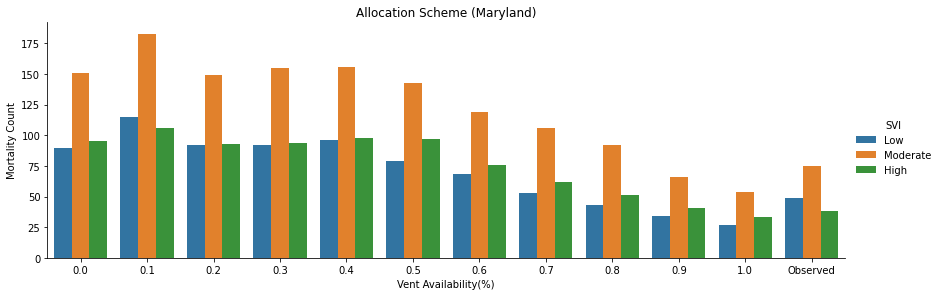

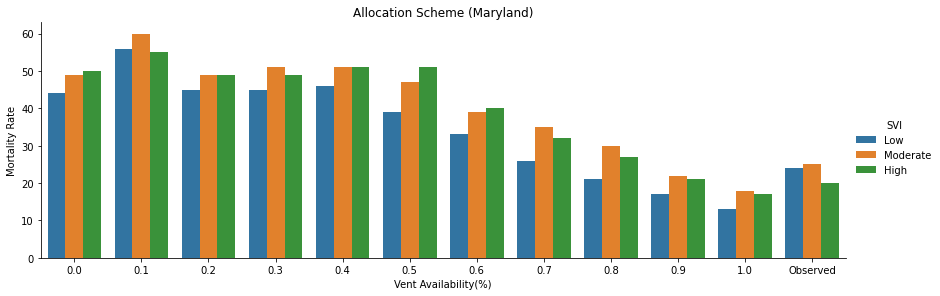

In [53]:
visualize_count_mortality(df_baseline_maryland, 'Maryland')
visualize_percentage_mortality(df_baseline_maryland, 'Maryland')

## Max Lives Years

In [54]:
ls_df_alloc_level = []          # List of prioritized patients for each scarcity level
ls_df_count_death_svi = []

for pct in vent_availability_pct:
    print('------------------------------{}------------------------------'.format(round(pct, 1)))
    allocation = Allocation(df_sample, pct, calibration_sofa_mortality)   # Generate Allocation object
    df_death = allocation.max_life_years()                                         # Prioritize patients following Maryland CSC

    # Count of deaths for each racial group in each scarcity level
    dict_count_death_race = Counter(df_death['cat_SVI'])

    df_death.rename(columns={'cat_SVI': 'SVI', 'expected_death': 'count_death'}, inplace=True)
    
    df_death['level'] = round(pct, 1)
    df_death['avg_death'] = statistics.mean(df_death.loc[: ,'count_death'])
    df_death['percentage_death'] = df_death.apply(lambda row: percentage_death(row), axis=1)

    ls_df_count_death_svi.append(df_death)

df_max_lives_years = pd.concat(ls_df_count_death_svi)
df_max_lives_years['type_allocation'] = 'Max Lives Years'
df_baseline_max_lives_years = pd.concat([death_svi_baseline, df_max_lives_years])
df_baseline_max_lives_years[['count_death', 'avg_death', 'percentage_death']] = df_baseline_max_lives_years[['count_death', 'avg_death', 'percentage_death']].round(0).astype(int)

------------------------------0.0------------------------------
Number of vents available: 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


SOFA   cat_SVI  count
0      0      High      3
1      0       Low      1
2      0  Moderate      5
3      1      High      3
4      1       Low      4
5      1  Moderate      2
6      2      High      2
7      2       Low      4
8      2  Moderate      4
9      3      High      5
10     3       Low     12
11     3  Moderate     11
12     4      High     19
13     4       Low     13
14     4  Moderate     25
15     5      High     14
16     5       Low     18
17     5  Moderate     16
18     6      High     14
19     6       Low      9
20     6  Moderate     14
21     7      High      4
22     7       Low      8
23     7  Moderate     12
24     8      High      9
25     8       Low      2
26     8  Moderate     18
27     9      High      8
28     9       Low      9
29     9  Moderate     18
30    10      High      4
31    10       Low      2
32    10  Moderate      5
33    11      High      4
34    11       Low      6
35    11  Moderate      9
36    12      High      1
37    12  Moderate      7
38    13      High      2
39    13       Low      2
40    13  Moderate      3
41    14  Moderate      2
42    15      High      1
43    17      High      1
44    19      High      1

cat_SVI  expected_death
0      High              95
1       Low              90
2  Moderate             151

------------------------------0.1------------------------------
Number of vents available: 70
Tie occurs
------------------------------TIE SOFA: 0------------------------------
------------------------------MORTALITY PROBABILITY: 0.0------------------------------


cat_SVI  allocate_vent  count  P[NV] & P[V]  P[D|NV] & P[D|V]  P[D_sub]
0      High              0     19          0.48               1.0      0.48
1      High              1     21          0.52               0.0      0.00
2       Low              0     22          0.48               1.0      0.48
3       Low              1     24          0.52               0.0      0.00
4  Moderate              0     36          0.59               1.0      0.59
5  Moderate              1     25          0.41               0.0      0.00

-----------------------TIE-----------------------


cat_SVI  allocate_vent  count  P[NV] & P[V]  P[D|NV] & P[D|V]  P[D_sub]  \
0      High              0     19          0.48               1.0      0.48   
1      High              1     21          0.52               0.0      0.00   
2       Low              0     22          0.48               1.0      0.48   
3       Low              1     24          0.52               0.0      0.00   
4  Moderate              0     36          0.59               1.0      0.59   
5  Moderate              1     25          0.41               0.0      0.00   

   P[D_total]  expected_death  
0        0.48           19.20  
1        0.48           19.20  
2        0.48           22.08  
3        0.48           22.08  
4        0.59           35.99  
5        0.59           35.99

SOFA   cat_SVI  count
0      1      High      3
1      1       Low      4
2      1  Moderate      2
3      2      High      2
4      2       Low      4
5      2  Moderate      4
6      3      High      5
7      3       Low     12
8      3  Moderate     11
9      4      High     19
10     4       Low     13
11     4  Moderate     25
12     5      High     14
13     5       Low     18
14     5  Moderate     16
15     6      High     14
16     6       Low      9
17     6  Moderate     14
18     7      High      4
19     7       Low      8
20     7  Moderate     12
21     8      High      9
22     8       Low      2
23     8  Moderate     18
24     9      High      8
25     9       Low      9
26     9  Moderate     18
27    10      High      4
28    10       Low      2
29    10  Moderate      5
30    11      High      4
31    11       Low      6
32    11  Moderate      9
33    12      High      1
34    12  Moderate      7
35    13      High      2
36    13       Low      2
37    13  Moderate      3
38    14  Moderate      2
39    15      High      1
40    17      High      1
41    19      High      1

-----------------------NOT ALLOCATED-----------------------


cat_SVI  expected_death
0      High              92
1       Low              89
2  Moderate             146

-----------------------TOTAL-----------------------


cat_SVI  count_death
0      High       111.20
2       Low       111.08
4  Moderate       181.99

------------------------------0.2------------------------------
Number of vents available: 140
Tie occurs
------------------------------TIE SOFA: 0------------------------------
------------------------------MORTALITY PROBABILITY: 0.0------------------------------


cat_SVI  allocate_vent  count  P[NV] & P[V]  P[D|NV] & P[D|V]  P[D_sub]
0      High              0      1          0.02               1.0      0.02
1      High              1     39          0.98               0.0      0.00
2       Low              0      3          0.07               1.0      0.07
3       Low              1     43          0.93               0.0      0.00
4  Moderate              0      3          0.05               1.0      0.05
5  Moderate              1     58          0.95               0.0      0.00

-----------------------TIE-----------------------


cat_SVI  allocate_vent  count  P[NV] & P[V]  P[D|NV] & P[D|V]  P[D_sub]  \
0      High              0      1          0.02               1.0      0.02   
1      High              1     39          0.98               0.0      0.00   
2       Low              0      3          0.07               1.0      0.07   
3       Low              1     43          0.93               0.0      0.00   
4  Moderate              0      3          0.05               1.0      0.05   
5  Moderate              1     58          0.95               0.0      0.00   

   P[D_total]  expected_death  
0        0.02            0.80  
1        0.02            0.80  
2        0.07            3.22  
3        0.07            3.22  
4        0.05            3.05  
5        0.05            3.05

SOFA   cat_SVI  count
0      1      High      3
1      1       Low      4
2      1  Moderate      2
3      2      High      2
4      2       Low      4
5      2  Moderate      4
6      3      High      5
7      3       Low     12
8      3  Moderate     11
9      4      High     19
10     4       Low     13
11     4  Moderate     25
12     5      High     14
13     5       Low     18
14     5  Moderate     16
15     6      High     14
16     6       Low      9
17     6  Moderate     14
18     7      High      4
19     7       Low      8
20     7  Moderate     12
21     8      High      9
22     8       Low      2
23     8  Moderate     18
24     9      High      8
25     9       Low      9
26     9  Moderate     18
27    10      High      4
28    10       Low      2
29    10  Moderate      5
30    11      High      4
31    11       Low      6
32    11  Moderate      9
33    12      High      1
34    12  Moderate      7
35    13      High      2
36    13       Low      2
37    13  Moderate      3
38    14  Moderate      2
39    15      High      1
40    17      High      1
41    19      High      1

-----------------------NOT ALLOCATED-----------------------


cat_SVI  expected_death
0      High              92
1       Low              89
2  Moderate             146

-----------------------TOTAL-----------------------


cat_SVI  count_death
0      High        92.80
2       Low        92.22
4  Moderate       149.05

------------------------------0.3------------------------------
Number of vents available: 210
Tie occurs
------------------------------TIE SOFA: 1------------------------------
------------------------------MORTALITY PROBABILITY: 0.0------------------------------
-----------------------ALLOCATED-----------------------


deid_fin_encounter  age_at_admit  gender        race_display  \
0                 28304            15    Male  Hispanic or Latino   
1                 26059            17  Female               White   
2                 27960            18  Female  Hispanic or Latino   
3                 39514            19  Female               White   
4                 11893            20  Female               White   
..                  ...           ...     ...                 ...   
142               14186            84  Female               White   
143               35135            85  Female               White   
144               46413            85  Female               White   
145               44135            86  Female  Hispanic or Latino   
146               35077            92    Male  Hispanic or Latino   

    insured_uninsured  icu_hours_summed  vent_hours_summed  SOFA  \
0             Insured             75.93              34.95     0   
1             Insured             14.35                NaN     0   
2             Insured             83.68                NaN     0   
3             Insured             17.82                NaN     0   
4             Insured             96.23                NaN     0   
..                ...               ...                ...   ...   
142           Insured            110.70                NaN     0   
143           Insured             54.17                NaN     0   
144           Insured            162.77                NaN     0   
145           Insured            110.95                NaN     0   
146           Insured            155.48               0.25     0   

     has_comorbidity  count_comorbidity  life_years  \
0                  0                  0          85   
1                  1                  1          83   
2                  0                  0          82   
3                  0                  0          81   
4                  1                  1          80   
..               ...                ...         ...   
142                1                  3          16   
143                1                  1          15   
144                0                  0          15   
145                1                  2          14   
146                1                  3           8   

    discharge_disposition_display deceased_dt_tm  ZCTA5   TRACT        GEOID  \
0                             NaN            NaN  78621    2207  48453002207   
1                            Home            NaN  78738    1768  48453001768   
2                            Home            NaN  78757    1707  48453001707   
3                            Home            NaN  78616  960101  48055960101   
4                            Home            NaN  78723    1811  48453001811   
..                            ...            ...    ...     ...          ...   
142    Home Care with Home Health            NaN  78642   20301  48491020301   
143    Home Care with Home Health            NaN  78759    1707  48453001707   
144               Still a patient            NaN  78605  960400  48053960400   
145                          Home            NaN  78744    2411  48453002411   
146    Home Care with Home Health            NaN  78653    2207  48453002207   

     E_TOTPOP  E_POV  EP_POV  E_UNEMP  EP_UNEMP  E_PCI  E_NOHSDP  EP_NOHSDP  \
0        9453    986    10.4       99       1.9  23059      1390       23.6   
1       10404    484     4.7      143       2.7  59592       131        1.8   
2        5111    389     7.6       59       2.0  47839        35        0.9   
3        7238    960    13.3       92       2.7  24231      1539       36.0   
4        3535   1089    30.8       71       3.7  22820       622       26.3   
..        ...    ...     ...      ...       ...    ...       ...        ...   
142      7538    623     8.3       93       2.4  36538       300        6.4   
143      5111    389     7.6       59       2.0  47839        35        0.9   
144      5508    762    13

SOFA   cat_SVI  count  mortality rate  expected_death
0     0      High     40             0.0             0.0
1     0       Low     46             0.0             0.0
2     0  Moderate     61             0.0             0.0

cat_SVI  expected_death
0      High             0.0
1       Low             0.0
2  Moderate             0.0

-----------------------TIE-----------------------


deid_fin_encounter  age_at_admit  gender               race_display  \
147               13424             8  Female         Hispanic or Latino   
148               23727            14    Male         Hispanic or Latino   
149               13500            16  Female                      White   
150               18415            18    Male         Hispanic or Latino   
151               40894            20  Female                      White   
..                  ...           ...     ...                        ...   
228               28080            90  Female         Hispanic or Latino   
229               26258            90  Female         Hispanic or Latino   
230               31330            92    Male                      White   
231               49276            93  Female         Hispanic or Latino   
232               38186           100  Female  Black or African American   

    insured_uninsured  icu_hours_summed  vent_hours_summed  SOFA  \
147           Insured             25.40                NaN     1   
148           Insured             38.48                NaN     1   
149           Insured             30.25                NaN     1   
150           Insured             53.98                NaN     1   
151         Uninsured             23.15                NaN     1   
..                ...               ...                ...   ...   
228           Insured            184.32                NaN     1   
229         Uninsured             28.72                NaN     1   
230           Insured            100.22                NaN     1   
231           Insured            255.57                NaN     1   
232           Insured             51.08                NaN     1   

     has_comorbidity  count_comorbidity  life_years  \
147                1                  2          92   
148                1                  1          86   
149                0                  0          84   
150                1                  1          82   
151                0                  0          80   
..               ...                ...         ...   
228                1                  3          10   
229                1                  1          10   
230                1                  2           8   
231                1                  1           7   
232                1                  2           0   

    discharge_disposition_display    deceased_dt_tm  ZCTA5   TRACT  \
147                          Home               NaN  76574   20900   
148                          Home               NaN  78664   20804   
149                          Home               NaN  78633   20115   
150                          Home               NaN  78705     601   
151                          Home               NaN  78665   20804   
..                            ...               ...    ...     ...   
228                       Expired   6/29/2020 15:57  78741    2411   
229                          Home               NaN  78744    2411   
230                       Expired  10/28/2020 12:59  78610  960101   
231                    Rehab Care               NaN  78747    2432   
232                       Expired   4/14/2020 16:17  78722     306   

           GEOID  E_TOTPOP  E_POV  EP_POV  E_UNEMP  EP_UNEMP  E_PCI  E_NOHSDP  \
147  48491020900      4279    258     6.0      175       7.2  31594       236   
148  48491020804     11472    314     2.7      390       6.2  49695        80   
149  48491020115      4790    192     4.0       40       2.3  41076        52   
150  48453000601     10169    571    65.3      479      13.8   4686        10   
151  48491020804     11472    314     2.7      390       6.2  49695        80   
..           ...       ...    ...     ...      ...       ...    ...       ...   
228  48453002411      7453   1986    26.7      241       6.9  15378      1493   
229  48453002411      7453   1986    26.7      241       6.9  15378      1493   
230  48055960101      7238    960    13.3   

cat_SVI  allocate_vent  count  P[NV] & P[V]  P[D|NV] & P[D|V]  P[D_sub]
0      High              0      3          0.17               1.0      0.17
1      High              1     15          0.83               0.0      0.00
2       Low              0      9          0.28               1.0      0.28
3       Low              1     23          0.72               0.0      0.00
4  Moderate              0     11          0.31               1.0      0.31
5  Moderate              1     25          0.69               0.0      0.00

cat_SVI  allocate_vent  count  P[NV] & P[V]  P[D|NV] & P[D|V]  P[D_sub]  \
0      High              0      3          0.17               1.0      0.17   
1      High              1     15          0.83               0.0      0.00   
2       Low              0      9          0.28               1.0      0.28   
3       Low              1     23          0.72               0.0      0.00   
4  Moderate              0     11          0.31               1.0      0.31   
5  Moderate              1     25          0.69               0.0      0.00   

   P[D_total]  expected_death  
0        0.17            3.06  
1        0.17            3.06  
2        0.28            8.96  
3        0.28            8.96  
4        0.31           11.16  
5        0.31           11.16

-----------------------NOT ALLOCATED-----------------------


deid_fin_encounter  age_at_admit  gender               race_display  \
233               33504             7    Male         Hispanic or Latino   
234               45331            20    Male         Hispanic or Latino   
235               14719            24    Male                      White   
236               28150            29    Male  Black or African American   
237               18668            30  Female  Black or African American   
..                  ...           ...     ...                        ...   
698               17790            58    Male                      White   
699               33610            72    Male  Black or African American   
700               32723            74    Male                      White   
701               32723            74    Male                      White   
702               32723            74    Male                      White   

    insured_uninsured  icu_hours_summed  vent_hours_summed  SOFA  \
233           Insured             79.15                NaN     2   
234           Insured            139.30                NaN     2   
235         Uninsured             29.90                NaN     2   
236         Uninsured             41.20                NaN     2   
237           Insured             49.77              38.93     2   
..                ...               ...                ...   ...   
698           Insured            318.77             233.28    14   
699           Insured            138.79              51.37    14   
700           Insured             30.60              18.44    15   
701           Insured             30.60              18.44    17   
702           Insured             30.60              18.44    19   

     has_comorbidity  count_comorbidity  life_years  \
233                1                  1          93   
234                1                  1          80   
235                0                  0          76   
236                1                  1          71   
237                1                  3          70   
..               ...                ...         ...   
698                1                  1          42   
699                1                  1          28   
700                1                  2          26   
701                1                  2          26   
702                1                  2          26   

    discharge_disposition_display   deceased_dt_tm  ZCTA5   TRACT  \
233                          Home              NaN  78744    2411   
234                          Home              NaN  78616  960101   
235                          Home              NaN  78701    1100   
236                          Home              NaN  78653    2207   
237                          Home              NaN  78723    1811   
..                            ...              ...    ...     ...   
698                           NaN              NaN  78639  960500   
699               Still a patient              NaN  78725    2207   
700                       Expired  11/5/2020 16:40  78753    1813   
701                       Expired  11/5/2020 16:40  78753    1813   
702                       Expired  11/5/2020 16:40  78753    1813   

           GEOID  E_TOTPOP  E_POV  EP_POV  E_UNEMP  EP_UNEMP   E_PCI  \
233  48453002411      7453   1986    26.7      241       6.9   15378   
234  48055960101      7238    960    13.3       92       2.7   24231   
235  48453001100      6608    890    13.8       76       1.5  109352   
236  48453002207      9453    986    10.4       99       1.9   23059   
237  48453001811      3535   1089    30.8       71       3.7   22820   
..           ...       ...    ...     ...      ...       ...     ...   
698  48053960500      6358    758    11.9      175       6.0   27453   
699  48453002207      9453    986    10.4       99       1.9   23059   
700  48453001813      7423   2425    32.8      168       4.2   20615   
701  48453001813      7423   2425    32.8      168       4.2   20

SOFA   cat_SVI  count
0      2      High      2
1      2       Low      4
2      2  Moderate      4
3      3      High      5
4      3       Low     12
5      3  Moderate     11
6      4      High     19
7      4       Low     13
8      4  Moderate     25
9      5      High     14
10     5       Low     18
11     5  Moderate     16
12     6      High     14
13     6       Low      9
14     6  Moderate     14
15     7      High      4
16     7       Low      8
17     7  Moderate     12
18     8      High      9
19     8       Low      2
20     8  Moderate     18
21     9      High      8
22     9       Low      9
23     9  Moderate     18
24    10      High      4
25    10       Low      2
26    10  Moderate      5
27    11      High      4
28    11       Low      6
29    11  Moderate      9
30    12      High      1
31    12  Moderate      7
32    13      High      2
33    13       Low      2
34    13  Moderate      3
35    14  Moderate      2
36    15      High      1
37    17      High      1
38    19      High      1

cat_SVI  expected_death
0      High              89
1       Low              85
2  Moderate             144

-----------------------TOTAL-----------------------


cat_SVI  count_death
0      High        92.06
2       Low        93.96
4  Moderate       155.16

------------------------------0.4------------------------------
Number of vents available: 281
Tie occurs
------------------------------TIE SOFA: 3------------------------------
------------------------------MORTALITY PROBABILITY: 6.4------------------------------
-----------------------ALLOCATED-----------------------


deid_fin_encounter  age_at_admit  gender               race_display  \
0                 28304            15    Male         Hispanic or Latino   
1                 26059            17  Female                      White   
2                 27960            18  Female         Hispanic or Latino   
3                 39514            19  Female                      White   
4                 11893            20  Female                      White   
..                  ...           ...     ...                        ...   
275               42442            78  Female         Hispanic or Latino   
276               11265            80  Female         Hispanic or Latino   
277               17180            88    Male                      White   
278               21784            89    Male  Black or African American   
279               12333            93  Female         Hispanic or Latino   

    insured_uninsured  icu_hours_summed  vent_hours_summed  SOFA  \
0             Insured             75.93              34.95     0   
1             Insured             14.35                NaN     0   
2             Insured             83.68                NaN     0   
3             Insured             17.82                NaN     0   
4             Insured             96.23                NaN     0   
..                ...               ...                ...   ...   
275           Insured            857.63             827.35     2   
276         Uninsured            374.32                NaN     2   
277           Insured            119.75                NaN     2   
278           Insured              4.37                NaN     2   
279           Insured             21.65                NaN     2   

     has_comorbidity  count_comorbidity  life_years  \
0                  0                  0          85   
1                  1                  1          83   
2                  0                  0          82   
3                  0                  0          81   
4                  1                  1          80   
..               ...                ...         ...   
275                0                  0          22   
276                1                  4          20   
277                1                  1          12   
278                1                  3          11   
279                1                  1           7   

    discharge_disposition_display   deceased_dt_tm  ZCTA5   TRACT  \
0                             NaN              NaN  78621    2207   
1                            Home              NaN  78738    1768   
2                            Home              NaN  78757    1707   
3                            Home              NaN  78616  960101   
4                            Home              NaN  78723    1811   
..                            ...              ...    ...     ...   
275                       Expired   8/9/2020 23:46  78611  960600   
276                          Home              NaN  78616  960101   
277                       Expired  5/29/2020 16:26  78621    2207   
278              Hospice Facility   9/5/2020 16:43  78629     100   
279          Skilled Nursing Care              NaN  78702    2109   

           GEOID  E_TOTPOP  E_POV  EP_POV  E_UNEMP  EP_UNEMP  E_PCI  E_NOHSDP  \
0    48453002207      9453    986    10.4       99       1.9  23059      1390   
1    48453001768     10404    484     4.7      143       2.7  59592       131   
2    48453001707      5111    389     7.6       59       2.0  47839        35   
3    48055960101      7238    960    13.3       92       2.7  24231      1539   
4    48453001811      3535   1089    30.8       71       3.7  22820       622   
..           ...       ...    ...     ...      ...       ...    ...       ...   
275  48053960600      3776    310     8.2       15       1.0  41847       137   
276  48055960101      7238    960    13.3       92       2.7  24231      1539   
277  48453002207      9453    986    10.4       99      

SOFA   cat_SVI  count  mortality rate  expected_death
0     0      High     40           0.000            0.00
1     0       Low     46           0.000            0.00
2     0  Moderate     61           0.000            0.00
3     1      High     18           0.000            0.00
4     1       Low     32           0.000            0.00
5     1  Moderate     36           0.000            0.00
6     2      High      9           0.064            0.58
7     2       Low     12           0.064            0.77
8     2  Moderate     26           0.064            1.66

cat_SVI  expected_death
0      High            0.58
1       Low            0.77
2  Moderate            1.66

-----------------------TIE-----------------------


deid_fin_encounter  age_at_admit  gender               race_display  \
280               30021             5  Female  Black or African American   
281               28472             8    Male         Hispanic or Latino   
282               14626            10    Male         Hispanic or Latino   
283               25279            10    Male                      White   
284               11869            26  Female         Hispanic or Latino   
..                  ...           ...     ...                        ...   
342               13106            83    Male         Hispanic or Latino   
343               16005            86    Male         Hispanic or Latino   
344               17170            88  Female         Hispanic or Latino   
345               31541            93  Female                      White   
346               26729            95  Female                      White   

    insured_uninsured  icu_hours_summed  vent_hours_summed  SOFA  \
280         Uninsured             44.47              48.78     3   
281           Insured            239.22                NaN     3   
282           Insured             24.32                NaN     3   
283           Insured             70.25                NaN     3   
284         Uninsured             38.90                NaN     3   
..                ...               ...                ...   ...   
342           Insured            288.12             288.35     3   
343           Insured             15.70                NaN     3   
344           Insured             17.55                NaN     3   
345           Insured             50.63                NaN     3   
346           Insured             59.48                NaN     3   

     has_comorbidity  count_comorbidity  life_years  \
280                0                  0          95   
281                0                  0          92   
282                0                  0          90   
283                0                  0          90   
284                0                  0          74   
..               ...                ...         ...   
342                1                  1          17   
343                1                  1          14   
344                1                  1          12   
345                1                  2           7   
346                1                  2           5   

    discharge_disposition_display   deceased_dt_tm  ZCTA5   TRACT  \
280                       Expired              NaN  78207  170200   
281                          Home              NaN  78621    2207   
282                          Home              NaN  78640  960101   
283                          Home              NaN  78752    1813   
284                          Home              NaN  78734    1742   
..                            ...              ...    ...     ...   
342                       Expired  7/19/2020 18:10  77988     700   
343    Home Care with Home Health              NaN  78758    1805   
344          Skilled Nursing Care              NaN  78664   20804   
345                       Expired  7/12/2020 18:30  78654  960500   
346                       Expired   7/1/2020 22:10  78731    1716   

           GEOID  E_TOTPOP  E_POV  EP_POV  E_UNEMP  EP_UNEMP  E_PCI  E_NOHSDP  \
280  48029170200      5507   2354    42.7      263      12.2  11186      1818   
281  48453002207      9453    986    10.4       99       1.9  23059      1390   
282  48055960101      7238    960    13.3       92       2.7  24231      1539   
283  48453001813      7423   2425    32.8      168       4.2  20615      1531   
284  48453001742      6064    511     8.4      177       5.4  47003       350   
..           ...       ...    ...     ...      ...       ...    ...       ...   
342  48469000700      3989    638    16.0       57       3.0  24869       578   
343  48453001805      4675   1511    32.4       54       1.9  21702       744   
344  48491020804     11472    314     2.7      390      

cat_SVI  allocate_vent  count  P[NV] & P[V]  P[D|NV] & P[D|V]  P[D_sub]
0      High              0     15          0.94             1.000   0.94000
1      High              1      1          0.06             0.064   0.00384
2       Low              0     26          1.00             1.000   1.00000
3  Moderate              0     25          1.00             1.000   1.00000

cat_SVI  allocate_vent  count  P[NV] & P[V]  P[D|NV] & P[D|V]  P[D_sub]  \
0      High              0     15          0.94             1.000   0.94000   
1      High              1      1          0.06             0.064   0.00384   
2       Low              0     26          1.00             1.000   1.00000   
3  Moderate              0     25          1.00             1.000   1.00000   

   P[D_total]  expected_death  
0     0.94384        15.10144  
1     0.94384        15.10144  
2     1.00000        26.00000  
3     1.00000        25.00000

-----------------------NOT ALLOCATED-----------------------


deid_fin_encounter  age_at_admit  gender               race_display  \
347               33220             0  Female         Hispanic or Latino   
348               15557            10    Male         Hispanic or Latino   
349               40112            17    Male                      White   
350               38948            19  Female         Hispanic or Latino   
351               19621            24    Male                      White   
..                  ...           ...     ...                        ...   
698               17790            58    Male                      White   
699               33610            72    Male  Black or African American   
700               32723            74    Male                      White   
701               32723            74    Male                      White   
702               32723            74    Male                      White   

    insured_uninsured  icu_hours_summed  vent_hours_summed  SOFA  \
347           Insured             17.80                NaN     4   
348           Insured            863.32            1059.40     4   
349           Insured             36.95              28.52     4   
350           Insured            333.97             240.33     4   
351         Uninsured              7.56               1.27     4   
..                ...               ...                ...   ...   
698           Insured            318.77             233.28    14   
699           Insured            138.79              51.37    14   
700           Insured             30.60              18.44    15   
701           Insured             30.60              18.44    17   
702           Insured             30.60              18.44    19   

     has_comorbidity  count_comorbidity  life_years  \
347                0                  0         100   
348                1                  2          90   
349                1                  1          83   
350                1                  2          81   
351                0                  0          76   
..               ...                ...         ...   
698                1                  1          42   
699                1                  1          28   
700                1                  2          26   
701                1                  2          26   
702                1                  2          26   

    discharge_disposition_display   deceased_dt_tm  ZCTA5   TRACT  \
347                          Home              NaN  78753    1813   
348                          Home              NaN  78724    2207   
349                          Home              NaN  78666   10905   
350                          Home              NaN  78664   20804   
351                          Home              NaN  78656  960101   
..                            ...              ...    ...     ...   
698                           NaN              NaN  78639  960500   
699               Still a patient              NaN  78725    2207   
700                       Expired  11/5/2020 16:40  78753    1813   
701                       Expired  11/5/2020 16:40  78753    1813   
702                       Expired  11/5/2020 16:40  78753    1813   

           GEOID  E_TOTPOP  E_POV  EP_POV  E_UNEMP  EP_UNEMP  E_PCI  E_NOHSDP  \
347  48453001813      7423   2425    32.8      168       4.2  20615      1531   
348  48453002207      9453    986    10.4       99       1.9  23059      1390   
349  48209010905      6751    329     4.9      141       4.0  34221       398   
350  48491020804     11472    314     2.7      390       6.2  49695        80   
351  48055960101      7238    960    13.3       92       2.7  24231      1539   
..           ...       ...    ...     ...      ...       ...    ...       ...   
698  48053960500      6358    758    11.9      175       6.0  27453       528   
699  48453002207      9453    986    10.4       99       1.9  23059      1390   
700  48453001813      7423   2425    32.8      168      

SOFA   cat_SVI  count
0      4      High     19
1      4       Low     13
2      4  Moderate     25
3      5      High     14
4      5       Low     18
5      5  Moderate     16
6      6      High     14
7      6       Low      9
8      6  Moderate     14
9      7      High      4
10     7       Low      8
11     7  Moderate     12
12     8      High      9
13     8       Low      2
14     8  Moderate     18
15     9      High      8
16     9       Low      9
17     9  Moderate     18
18    10      High      4
19    10       Low      2
20    10  Moderate      5
21    11      High      4
22    11       Low      6
23    11  Moderate      9
24    12      High      1
25    12  Moderate      7
26    13      High      2
27    13       Low      2
28    13  Moderate      3
29    14  Moderate      2
30    15      High      1
31    17      High      1
32    19      High      1

cat_SVI  expected_death
0      High              82
1       Low              69
2  Moderate             129

-----------------------TOTAL-----------------------


cat_SVI  count_death
0      High     97.68144
2       Low     95.77000
3  Moderate    155.66000

------------------------------0.5------------------------------
Number of vents available: 351
Tie occurs
------------------------------TIE SOFA: 4------------------------------
------------------------------MORTALITY PROBABILITY: 20.2------------------------------
-----------------------ALLOCATED-----------------------


deid_fin_encounter  age_at_admit  gender        race_display  \
0                 28304            15    Male  Hispanic or Latino   
1                 26059            17  Female               White   
2                 27960            18  Female  Hispanic or Latino   
3                 39514            19  Female               White   
4                 11893            20  Female               White   
..                  ...           ...     ...                 ...   
342               13106            83    Male  Hispanic or Latino   
343               16005            86    Male  Hispanic or Latino   
344               17170            88  Female  Hispanic or Latino   
345               31541            93  Female               White   
346               26729            95  Female               White   

    insured_uninsured  icu_hours_summed  vent_hours_summed  SOFA  \
0             Insured             75.93              34.95     0   
1             Insured             14.35                NaN     0   
2             Insured             83.68                NaN     0   
3             Insured             17.82                NaN     0   
4             Insured             96.23                NaN     0   
..                ...               ...                ...   ...   
342           Insured            288.12             288.35     3   
343           Insured             15.70                NaN     3   
344           Insured             17.55                NaN     3   
345           Insured             50.63                NaN     3   
346           Insured             59.48                NaN     3   

     has_comorbidity  count_comorbidity  life_years  \
0                  0                  0          85   
1                  1                  1          83   
2                  0                  0          82   
3                  0                  0          81   
4                  1                  1          80   
..               ...                ...         ...   
342                1                  1          17   
343                1                  1          14   
344                1                  1          12   
345                1                  2           7   
346                1                  2           5   

    discharge_disposition_display   deceased_dt_tm  ZCTA5   TRACT  \
0                             NaN              NaN  78621    2207   
1                            Home              NaN  78738    1768   
2                            Home              NaN  78757    1707   
3                            Home              NaN  78616  960101   
4                            Home              NaN  78723    1811   
..                            ...              ...    ...     ...   
342                       Expired  7/19/2020 18:10  77988     700   
343    Home Care with Home Health              NaN  78758    1805   
344          Skilled Nursing Care              NaN  78664   20804   
345                       Expired  7/12/2020 18:30  78654  960500   
346                       Expired   7/1/2020 22:10  78731    1716   

           GEOID  E_TOTPOP  E_POV  EP_POV  E_UNEMP  EP_UNEMP  E_PCI  E_NOHSDP  \
0    48453002207      9453    986    10.4       99       1.9  23059      1390   
1    48453001768     10404    484     4.7      143       2.7  59592       131   
2    48453001707      5111    389     7.6       59       2.0  47839        35   
3    48055960101      7238    960    13.3       92       2.7  24231      1539   
4    48453001811      3535   1089    30.8       71       3.7  22820       622   
..           ...       ...    ...     ...      ...       ...    ...       ...   
342  48469000700      3989    638    16.0       57       3.0  24869       578   
343  48453001805      4675   1511    32.4       54       1.9  21702       744   
344  48491020804     11472    314     2.7      390       6.2  49695        80   
345  48053960500      6358    758    11.9      175       6.

SOFA   cat_SVI  count  mortality rate  expected_death
0      0      High     40           0.000            0.00
1      0       Low     46           0.000            0.00
2      0  Moderate     61           0.000            0.00
3      1      High     18           0.000            0.00
4      1       Low     32           0.000            0.00
5      1  Moderate     36           0.000            0.00
6      2      High      9           0.064            0.58
7      2       Low     12           0.064            0.77
8      2  Moderate     26           0.064            1.66
9      3      High     16           0.064            1.02
10     3       Low     26           0.064            1.66
11     3  Moderate     25           0.064            1.60

cat_SVI  expected_death
0      High            1.60
1       Low            2.43
2  Moderate            3.26

-----------------------TIE-----------------------


deid_fin_encounter  age_at_admit  gender        race_display  \
347               33220             0  Female  Hispanic or Latino   
348               15557            10    Male  Hispanic or Latino   
349               40112            17    Male               White   
350               38948            19  Female  Hispanic or Latino   
351               19621            24    Male               White   
..                  ...           ...     ...                 ...   
434               40942            84    Male  Hispanic or Latino   
435               23243            85  Female               White   
436               24640            87  Female               White   
437               20606            90    Male               White   
438               22985            90    Male  Hispanic or Latino   

    insured_uninsured  icu_hours_summed  vent_hours_summed  SOFA  \
347           Insured             17.80                NaN     4   
348           Insured            863.32            1059.40     4   
349           Insured             36.95              28.52     4   
350           Insured            333.97             240.33     4   
351         Uninsured              7.56               1.27     4   
..                ...               ...                ...   ...   
434           Insured            164.15                NaN     4   
435           Insured             95.10                NaN     4   
436           Insured             29.27                NaN     4   
437           Insured            108.37                NaN     4   
438           Insured             23.13                NaN     4   

     has_comorbidity  count_comorbidity  life_years  \
347                0                  0         100   
348                1                  2          90   
349                1                  1          83   
350                1                  2          81   
351                0                  0          76   
..               ...                ...         ...   
434                1                  2          16   
435                1                  2          15   
436                1                  3          13   
437                1                  3          10   
438                0                  0          10   

    discharge_disposition_display   deceased_dt_tm  ZCTA5   TRACT  \
347                          Home              NaN  78753    1813   
348                          Home              NaN  78724    2207   
349                          Home              NaN  78666   10905   
350                          Home              NaN  78664   20804   
351                          Home              NaN  78656  960101   
..                            ...              ...    ...     ...   
434       Long Term Care Hospital              NaN  78629     100   
435                       Expired   6/24/2020 7:07  78704    2307   
436                       Expired   8/19/2020 9:38  78602  950802   
437                       Expired  6/11/2020 23:20  78735    1750   
438               Still a patient              NaN  78606  950100   

           GEOID  E_TOTPOP  E_POV  EP_POV  E_UNEMP  EP_UNEMP  E_PCI  E_NOHSDP  \
347  48453001813      7423   2425    32.8      168       4.2  20615      1531   
348  48453002207      9453    986    10.4       99       1.9  23059      1390   
349  48209010905      6751    329     4.9      141       4.0  34221       398   
350  48491020804     11472    314     2.7      390       6.2  49695        80   
351  48055960101      7238    960    13.3       92       2.7  24231      1539   
..           ...       ...    ...     ...      ...       ...    ...       ...   
434  48177000100      3050    261     8.6       40       2.7  26904       578   
435  48453002307      6264   1101    17.7      157       3.9  29346       700   
436  48021950802      7625   1011    13.3      334       8.6  21691      1023   
437  48453001750      4978    346     7.0      124       3.

cat_SVI  allocate_vent  count  P[NV] & P[V]  P[D|NV] & P[D|V]  P[D_sub]
0      High              0     34          0.97             1.000   0.97000
1      High              1      1          0.03             0.202   0.00606
2       Low              0     19          0.90             1.000   0.90000
3       Low              1      2          0.10             0.202   0.02020
4  Moderate              0     35          0.97             1.000   0.97000
5  Moderate              1      1          0.03             0.202   0.00606

cat_SVI  allocate_vent  count  P[NV] & P[V]  P[D|NV] & P[D|V]  P[D_sub]  \
0      High              0     34          0.97             1.000   0.97000   
1      High              1      1          0.03             0.202   0.00606   
2       Low              0     19          0.90             1.000   0.90000   
3       Low              1      2          0.10             0.202   0.02020   
4  Moderate              0     35          0.97             1.000   0.97000   
5  Moderate              1      1          0.03             0.202   0.00606   

   P[D_total]  expected_death  
0     0.97606        34.16210  
1     0.97606        34.16210  
2     0.92020        19.32420  
3     0.92020        19.32420  
4     0.97606        35.13816  
5     0.97606        35.13816

-----------------------NOT ALLOCATED-----------------------


deid_fin_encounter  age_at_admit  gender               race_display  \
439               42071            17    Male         Hispanic or Latino   
440               14658            23    Male         Hispanic or Latino   
441               41743            25    Male         Hispanic or Latino   
442               49941            29  Female                      White   
443               12184            32    Male         Hispanic or Latino   
..                  ...           ...     ...                        ...   
698               17790            58    Male                      White   
699               33610            72    Male  Black or African American   
700               32723            74    Male                      White   
701               32723            74    Male                      White   
702               32723            74    Male                      White   

    insured_uninsured  icu_hours_summed  vent_hours_summed  SOFA  \
439           Insured            684.56             454.23     5   
440           Insured             47.32              21.08     5   
441           Insured            172.65              39.05     5   
442           Insured            789.70             775.33     5   
443           Insured            980.38            1186.03     5   
..                ...               ...                ...   ...   
698           Insured            318.77             233.28    14   
699           Insured            138.79              51.37    14   
700           Insured             30.60              18.44    15   
701           Insured             30.60              18.44    17   
702           Insured             30.60              18.44    19   

     has_comorbidity  count_comorbidity  life_years  \
439                1                  1          83   
440                0                  0          77   
441                0                  0          75   
442                0                  0          71   
443                0                  0          68   
..               ...                ...         ...   
698                1                  1          42   
699                1                  1          28   
700                1                  2          26   
701                1                  2          26   
702                1                  2          26   

    discharge_disposition_display   deceased_dt_tm  ZCTA5   TRACT  \
439                          Home              NaN  78704    2307   
440                          Home              NaN  78613    1766   
441                          Home              NaN  78634   20804   
442              Another Hospital              NaN  78634   20804   
443       Long Term Care Hospital              NaN  78644  960101   
..                            ...              ...    ...     ...   
698                           NaN              NaN  78639  960500   
699               Still a patient              NaN  78725    2207   
700                       Expired  11/5/2020 16:40  78753    1813   
701                       Expired  11/5/2020 16:40  78753    1813   
702                       Expired  11/5/2020 16:40  78753    1813   

           GEOID  E_TOTPOP  E_POV  EP_POV  E_UNEMP  EP_UNEMP  E_PCI  E_NOHSDP  \
439  48453002307      6264   1101    17.7      157       3.9  29346       700   
440  48453001766      9336    704     7.5      388       8.2  44431       756   
441  48491020804     11472    314     2.7      390       6.2  49695        80   
442  48491020804     11472    314     2.7      390       6.2  49695        80   
443  48055960101      7238    960    13.3       92       2.7  24231      1539   
..           ...       ...    ...     ...      ...       ...    ...       ...   
698  48053960500      6358    758    11.9      175       6.0  27453       528   
699  48453002207      9453    986    10.4       99       1.9  23059      1390   
700  48453001813      7423   2425    32.8      168      

SOFA   cat_SVI  count
0      5      High     14
1      5       Low     18
2      5  Moderate     16
3      6      High     14
4      6       Low      9
5      6  Moderate     14
6      7      High      4
7      7       Low      8
8      7  Moderate     12
9      8      High      9
10     8       Low      2
11     8  Moderate     18
12     9      High      8
13     9       Low      9
14     9  Moderate     18
15    10      High      4
16    10       Low      2
17    10  Moderate      5
18    11      High      4
19    11       Low      6
20    11  Moderate      9
21    12      High      1
22    12  Moderate      7
23    13      High      2
24    13       Low      2
25    13  Moderate      3
26    14  Moderate      2
27    15      High      1
28    17      High      1
29    19      High      1

cat_SVI  expected_death
0      High              63
1       Low              56
2  Moderate             104

-----------------------TOTAL-----------------------


cat_SVI  count_death
0      High     98.76210
2       Low     77.75420
4  Moderate    142.39816

------------------------------0.6------------------------------
Number of vents available: 421
Tie occurs
------------------------------TIE SOFA: 4------------------------------
------------------------------MORTALITY PROBABILITY: 20.2------------------------------
-----------------------ALLOCATED-----------------------


deid_fin_encounter  age_at_admit  gender        race_display  \
0                 28304            15    Male  Hispanic or Latino   
1                 26059            17  Female               White   
2                 27960            18  Female  Hispanic or Latino   
3                 39514            19  Female               White   
4                 11893            20  Female               White   
..                  ...           ...     ...                 ...   
342               13106            83    Male  Hispanic or Latino   
343               16005            86    Male  Hispanic or Latino   
344               17170            88  Female  Hispanic or Latino   
345               31541            93  Female               White   
346               26729            95  Female               White   

    insured_uninsured  icu_hours_summed  vent_hours_summed  SOFA  \
0             Insured             75.93              34.95     0   
1             Insured             14.35                NaN     0   
2             Insured             83.68                NaN     0   
3             Insured             17.82                NaN     0   
4             Insured             96.23                NaN     0   
..                ...               ...                ...   ...   
342           Insured            288.12             288.35     3   
343           Insured             15.70                NaN     3   
344           Insured             17.55                NaN     3   
345           Insured             50.63                NaN     3   
346           Insured             59.48                NaN     3   

     has_comorbidity  count_comorbidity  life_years  \
0                  0                  0          85   
1                  1                  1          83   
2                  0                  0          82   
3                  0                  0          81   
4                  1                  1          80   
..               ...                ...         ...   
342                1                  1          17   
343                1                  1          14   
344                1                  1          12   
345                1                  2           7   
346                1                  2           5   

    discharge_disposition_display   deceased_dt_tm  ZCTA5   TRACT  \
0                             NaN              NaN  78621    2207   
1                            Home              NaN  78738    1768   
2                            Home              NaN  78757    1707   
3                            Home              NaN  78616  960101   
4                            Home              NaN  78723    1811   
..                            ...              ...    ...     ...   
342                       Expired  7/19/2020 18:10  77988     700   
343    Home Care with Home Health              NaN  78758    1805   
344          Skilled Nursing Care              NaN  78664   20804   
345                       Expired  7/12/2020 18:30  78654  960500   
346                       Expired   7/1/2020 22:10  78731    1716   

           GEOID  E_TOTPOP  E_POV  EP_POV  E_UNEMP  EP_UNEMP  E_PCI  E_NOHSDP  \
0    48453002207      9453    986    10.4       99       1.9  23059      1390   
1    48453001768     10404    484     4.7      143       2.7  59592       131   
2    48453001707      5111    389     7.6       59       2.0  47839        35   
3    48055960101      7238    960    13.3       92       2.7  24231      1539   
4    48453001811      3535   1089    30.8       71       3.7  22820       622   
..           ...       ...    ...     ...      ...       ...    ...       ...   
342  48469000700      3989    638    16.0       57       3.0  24869       578   
343  48453001805      4675   1511    32.4       54       1.9  21702       744   
344  48491020804     11472    314     2.7      390       6.2  49695        80   
345  48053960500      6358    758    11.9      175       6.

SOFA   cat_SVI  count  mortality rate  expected_death
0      0      High     40           0.000            0.00
1      0       Low     46           0.000            0.00
2      0  Moderate     61           0.000            0.00
3      1      High     18           0.000            0.00
4      1       Low     32           0.000            0.00
5      1  Moderate     36           0.000            0.00
6      2      High      9           0.064            0.58
7      2       Low     12           0.064            0.77
8      2  Moderate     26           0.064            1.66
9      3      High     16           0.064            1.02
10     3       Low     26           0.064            1.66
11     3  Moderate     25           0.064            1.60

cat_SVI  expected_death
0      High            1.60
1       Low            2.43
2  Moderate            3.26

-----------------------TIE-----------------------


deid_fin_encounter  age_at_admit  gender        race_display  \
347               33220             0  Female  Hispanic or Latino   
348               15557            10    Male  Hispanic or Latino   
349               40112            17    Male               White   
350               38948            19  Female  Hispanic or Latino   
351               19621            24    Male               White   
..                  ...           ...     ...                 ...   
434               40942            84    Male  Hispanic or Latino   
435               23243            85  Female               White   
436               24640            87  Female               White   
437               20606            90    Male               White   
438               22985            90    Male  Hispanic or Latino   

    insured_uninsured  icu_hours_summed  vent_hours_summed  SOFA  \
347           Insured             17.80                NaN     4   
348           Insured            863.32            1059.40     4   
349           Insured             36.95              28.52     4   
350           Insured            333.97             240.33     4   
351         Uninsured              7.56               1.27     4   
..                ...               ...                ...   ...   
434           Insured            164.15                NaN     4   
435           Insured             95.10                NaN     4   
436           Insured             29.27                NaN     4   
437           Insured            108.37                NaN     4   
438           Insured             23.13                NaN     4   

     has_comorbidity  count_comorbidity  life_years  \
347                0                  0         100   
348                1                  2          90   
349                1                  1          83   
350                1                  2          81   
351                0                  0          76   
..               ...                ...         ...   
434                1                  2          16   
435                1                  2          15   
436                1                  3          13   
437                1                  3          10   
438                0                  0          10   

    discharge_disposition_display   deceased_dt_tm  ZCTA5   TRACT  \
347                          Home              NaN  78753    1813   
348                          Home              NaN  78724    2207   
349                          Home              NaN  78666   10905   
350                          Home              NaN  78664   20804   
351                          Home              NaN  78656  960101   
..                            ...              ...    ...     ...   
434       Long Term Care Hospital              NaN  78629     100   
435                       Expired   6/24/2020 7:07  78704    2307   
436                       Expired   8/19/2020 9:38  78602  950802   
437                       Expired  6/11/2020 23:20  78735    1750   
438               Still a patient              NaN  78606  950100   

           GEOID  E_TOTPOP  E_POV  EP_POV  E_UNEMP  EP_UNEMP  E_PCI  E_NOHSDP  \
347  48453001813      7423   2425    32.8      168       4.2  20615      1531   
348  48453002207      9453    986    10.4       99       1.9  23059      1390   
349  48209010905      6751    329     4.9      141       4.0  34221       398   
350  48491020804     11472    314     2.7      390       6.2  49695        80   
351  48055960101      7238    960    13.3       92       2.7  24231      1539   
..           ...       ...    ...     ...      ...       ...    ...       ...   
434  48177000100      3050    261     8.6       40       2.7  26904       578   
435  48453002307      6264   1101    17.7      157       3.9  29346       700   
436  48021950802      7625   1011    13.3      334       8.6  21691      1023   
437  48453001750      4978    346     7.0      124       3.

cat_SVI  allocate_vent  count  P[NV] & P[V]  P[D|NV] & P[D|V]  P[D_sub]
0      High              0      4          0.11             1.000   0.11000
1      High              1     31          0.89             0.202   0.17978
2       Low              0      7          0.33             1.000   0.33000
3       Low              1     14          0.67             0.202   0.13534
4  Moderate              0      7          0.19             1.000   0.19000
5  Moderate              1     29          0.81             0.202   0.16362

cat_SVI  allocate_vent  count  P[NV] & P[V]  P[D|NV] & P[D|V]  P[D_sub]  \
0      High              0      4          0.11             1.000   0.11000   
1      High              1     31          0.89             0.202   0.17978   
2       Low              0      7          0.33             1.000   0.33000   
3       Low              1     14          0.67             0.202   0.13534   
4  Moderate              0      7          0.19             1.000   0.19000   
5  Moderate              1     29          0.81             0.202   0.16362   

   P[D_total]  expected_death  
0     0.28978        10.14230  
1     0.28978        10.14230  
2     0.46534         9.77214  
3     0.46534         9.77214  
4     0.35362        12.73032  
5     0.35362        12.73032

-----------------------NOT ALLOCATED-----------------------


deid_fin_encounter  age_at_admit  gender               race_display  \
439               42071            17    Male         Hispanic or Latino   
440               14658            23    Male         Hispanic or Latino   
441               41743            25    Male         Hispanic or Latino   
442               49941            29  Female                      White   
443               12184            32    Male         Hispanic or Latino   
..                  ...           ...     ...                        ...   
698               17790            58    Male                      White   
699               33610            72    Male  Black or African American   
700               32723            74    Male                      White   
701               32723            74    Male                      White   
702               32723            74    Male                      White   

    insured_uninsured  icu_hours_summed  vent_hours_summed  SOFA  \
439           Insured            684.56             454.23     5   
440           Insured             47.32              21.08     5   
441           Insured            172.65              39.05     5   
442           Insured            789.70             775.33     5   
443           Insured            980.38            1186.03     5   
..                ...               ...                ...   ...   
698           Insured            318.77             233.28    14   
699           Insured            138.79              51.37    14   
700           Insured             30.60              18.44    15   
701           Insured             30.60              18.44    17   
702           Insured             30.60              18.44    19   

     has_comorbidity  count_comorbidity  life_years  \
439                1                  1          83   
440                0                  0          77   
441                0                  0          75   
442                0                  0          71   
443                0                  0          68   
..               ...                ...         ...   
698                1                  1          42   
699                1                  1          28   
700                1                  2          26   
701                1                  2          26   
702                1                  2          26   

    discharge_disposition_display   deceased_dt_tm  ZCTA5   TRACT  \
439                          Home              NaN  78704    2307   
440                          Home              NaN  78613    1766   
441                          Home              NaN  78634   20804   
442              Another Hospital              NaN  78634   20804   
443       Long Term Care Hospital              NaN  78644  960101   
..                            ...              ...    ...     ...   
698                           NaN              NaN  78639  960500   
699               Still a patient              NaN  78725    2207   
700                       Expired  11/5/2020 16:40  78753    1813   
701                       Expired  11/5/2020 16:40  78753    1813   
702                       Expired  11/5/2020 16:40  78753    1813   

           GEOID  E_TOTPOP  E_POV  EP_POV  E_UNEMP  EP_UNEMP  E_PCI  E_NOHSDP  \
439  48453002307      6264   1101    17.7      157       3.9  29346       700   
440  48453001766      9336    704     7.5      388       8.2  44431       756   
441  48491020804     11472    314     2.7      390       6.2  49695        80   
442  48491020804     11472    314     2.7      390       6.2  49695        80   
443  48055960101      7238    960    13.3       92       2.7  24231      1539   
..           ...       ...    ...     ...      ...       ...    ...       ...   
698  48053960500      6358    758    11.9      175       6.0  27453       528   
699  48453002207      9453    986    10.4       99       1.9  23059      1390   
700  48453001813      7423   2425    32.8      168      

SOFA   cat_SVI  count
0      5      High     14
1      5       Low     18
2      5  Moderate     16
3      6      High     14
4      6       Low      9
5      6  Moderate     14
6      7      High      4
7      7       Low      8
8      7  Moderate     12
9      8      High      9
10     8       Low      2
11     8  Moderate     18
12     9      High      8
13     9       Low      9
14     9  Moderate     18
15    10      High      4
16    10       Low      2
17    10  Moderate      5
18    11      High      4
19    11       Low      6
20    11  Moderate      9
21    12      High      1
22    12  Moderate      7
23    13      High      2
24    13       Low      2
25    13  Moderate      3
26    14  Moderate      2
27    15      High      1
28    17      High      1
29    19      High      1

cat_SVI  expected_death
0      High              63
1       Low              56
2  Moderate             104

-----------------------TOTAL-----------------------


cat_SVI  count_death
0      High     74.74230
2       Low     68.20214
4  Moderate    119.99032

------------------------------0.7------------------------------
Number of vents available: 492
Tie occurs
------------------------------TIE SOFA: 5------------------------------
------------------------------MORTALITY PROBABILITY: 20.2------------------------------
-----------------------ALLOCATED-----------------------


deid_fin_encounter  age_at_admit  gender        race_display  \
0                 28304            15    Male  Hispanic or Latino   
1                 26059            17  Female               White   
2                 27960            18  Female  Hispanic or Latino   
3                 39514            19  Female               White   
4                 11893            20  Female               White   
..                  ...           ...     ...                 ...   
434               40942            84    Male  Hispanic or Latino   
435               23243            85  Female               White   
436               24640            87  Female               White   
437               20606            90    Male               White   
438               22985            90    Male  Hispanic or Latino   

    insured_uninsured  icu_hours_summed  vent_hours_summed  SOFA  \
0             Insured             75.93              34.95     0   
1             Insured             14.35                NaN     0   
2             Insured             83.68                NaN     0   
3             Insured             17.82                NaN     0   
4             Insured             96.23                NaN     0   
..                ...               ...                ...   ...   
434           Insured            164.15                NaN     4   
435           Insured             95.10                NaN     4   
436           Insured             29.27                NaN     4   
437           Insured            108.37                NaN     4   
438           Insured             23.13                NaN     4   

     has_comorbidity  count_comorbidity  life_years  \
0                  0                  0          85   
1                  1                  1          83   
2                  0                  0          82   
3                  0                  0          81   
4                  1                  1          80   
..               ...                ...         ...   
434                1                  2          16   
435                1                  2          15   
436                1                  3          13   
437                1                  3          10   
438                0                  0          10   

    discharge_disposition_display   deceased_dt_tm  ZCTA5   TRACT  \
0                             NaN              NaN  78621    2207   
1                            Home              NaN  78738    1768   
2                            Home              NaN  78757    1707   
3                            Home              NaN  78616  960101   
4                            Home              NaN  78723    1811   
..                            ...              ...    ...     ...   
434       Long Term Care Hospital              NaN  78629     100   
435                       Expired   6/24/2020 7:07  78704    2307   
436                       Expired   8/19/2020 9:38  78602  950802   
437                       Expired  6/11/2020 23:20  78735    1750   
438               Still a patient              NaN  78606  950100   

           GEOID  E_TOTPOP  E_POV  EP_POV  E_UNEMP  EP_UNEMP  E_PCI  E_NOHSDP  \
0    48453002207      9453    986    10.4       99       1.9  23059      1390   
1    48453001768     10404    484     4.7      143       2.7  59592       131   
2    48453001707      5111    389     7.6       59       2.0  47839        35   
3    48055960101      7238    960    13.3       92       2.7  24231      1539   
4    48453001811      3535   1089    30.8       71       3.7  22820       622   
..           ...       ...    ...     ...      ...       ...    ...       ...   
434  48177000100      3050    261     8.6       40       2.7  26904       578   
435  48453002307      6264   1101    17.7      157       3.9  29346       700   
436  48021950802      7625   1011    13.3      334       8.6  21691      1023   
437  48453001750      4978    346     7.0      124       3.

SOFA   cat_SVI  count  mortality rate  expected_death
0      0      High     40           0.000            0.00
1      0       Low     46           0.000            0.00
2      0  Moderate     61           0.000            0.00
3      1      High     18           0.000            0.00
4      1       Low     32           0.000            0.00
5      1  Moderate     36           0.000            0.00
6      2      High      9           0.064            0.58
7      2       Low     12           0.064            0.77
8      2  Moderate     26           0.064            1.66
9      3      High     16           0.064            1.02
10     3       Low     26           0.064            1.66
11     3  Moderate     25           0.064            1.60
12     4      High     35           0.202            7.07
13     4       Low     21           0.202            4.24
14     4  Moderate     36           0.202            7.27

cat_SVI  expected_death
0      High            8.67
1       Low            6.67
2  Moderate           10.53

-----------------------TIE-----------------------


deid_fin_encounter  age_at_admit  gender               race_display  \
439               42071            17    Male         Hispanic or Latino   
440               14658            23    Male         Hispanic or Latino   
441               41743            25    Male         Hispanic or Latino   
442               49941            29  Female                      White   
443               12184            32    Male         Hispanic or Latino   
..                  ...           ...     ...                        ...   
496               37450            86  Female         Hispanic or Latino   
497               24968            90  Female                      White   
498               43687            91  Female  Black or African American   
499               45227            93  Female         Hispanic or Latino   
500               38437            94    Male                      White   

    insured_uninsured  icu_hours_summed  vent_hours_summed  SOFA  \
439           Insured            684.56             454.23     5   
440           Insured             47.32              21.08     5   
441           Insured            172.65              39.05     5   
442           Insured            789.70             775.33     5   
443           Insured            980.38            1186.03     5   
..                ...               ...                ...   ...   
496           Insured            671.73                NaN     5   
497           Insured             51.02                NaN     5   
498           Insured             28.88                NaN     5   
499           Insured            119.48                NaN     5   
500           Insured            255.18             247.35     5   

     has_comorbidity  count_comorbidity  life_years  \
439                1                  1          83   
440                0                  0          77   
441                0                  0          75   
442                0                  0          71   
443                0                  0          68   
..               ...                ...         ...   
496                1                  3          14   
497                1                  2          10   
498                1                  1           9   
499                1                  4           7   
500                1                  1           6   

    discharge_disposition_display   deceased_dt_tm  ZCTA5   TRACT  \
439                          Home              NaN  78704    2307   
440                          Home              NaN  78613    1766   
441                          Home              NaN  78634   20804   
442              Another Hospital              NaN  78634   20804   
443       Long Term Care Hospital              NaN  78644  960101   
..                            ...              ...    ...     ...   
496             Home Hospice Care              NaN  78648  960500   
497              Hospice Facility              NaN  78947     100   
498                       Expired   5/8/2020 12:55  78664   20804   
499                       Expired  7/12/2020 14:56  78745    2411   
500                       Expired  7/19/2020 18:20  78664   20804   

           GEOID  E_TOTPOP  E_POV  EP_POV  E_UNEMP  EP_UNEMP  E_PCI  E_NOHSDP  \
439  48453002307      6264   1101    17.7      157       3.9  29346       700   
440  48453001766      9336    704     7.5      388       8.2  44431       756   
441  48491020804     11472    314     2.7      390       6.2  49695        80   
442  48491020804     11472    314     2.7      390       6.2  49695        80   
443  48055960101      7238    960    13.3       92       2.7  24231      1539   
..           ...       ...    ...     ...      ...       ...    ...       ...   
496  48055960500      7736   2051    27.3       82       2.1  22239       838   
497  48287000100      4998    639    12.8       24       1.0  27838       345   
498  48491020804     11472    314     2.7      390      

cat_SVI  allocate_vent  count  P[NV] & P[V]  P[D|NV] & P[D|V]  P[D_sub]
0      High              0      1          0.07             1.000   0.07000
1      High              1     14          0.93             0.202   0.18786
2       Low              0      5          0.23             1.000   0.23000
3       Low              1     17          0.77             0.202   0.15554
4  Moderate              0      3          0.12             1.000   0.12000
5  Moderate              1     22          0.88             0.202   0.17776

cat_SVI  allocate_vent  count  P[NV] & P[V]  P[D|NV] & P[D|V]  P[D_sub]  \
0      High              0      1          0.07             1.000   0.07000   
1      High              1     14          0.93             0.202   0.18786   
2       Low              0      5          0.23             1.000   0.23000   
3       Low              1     17          0.77             0.202   0.15554   
4  Moderate              0      3          0.12             1.000   0.12000   
5  Moderate              1     22          0.88             0.202   0.17776   

   P[D_total]  expected_death  
0     0.25786         3.86790  
1     0.25786         3.86790  
2     0.38554         8.48188  
3     0.38554         8.48188  
4     0.29776         7.44400  
5     0.29776         7.44400

-----------------------NOT ALLOCATED-----------------------


deid_fin_encounter  age_at_admit gender               race_display  \
501               35901            18   Male         Hispanic or Latino   
502               35114            25   Male         Hispanic or Latino   
503               26025            28   Male  Black or African American   
504               35282            30   Male         Hispanic or Latino   
505               31965            42   Male                      White   
..                  ...           ...    ...                        ...   
698               17790            58   Male                      White   
699               33610            72   Male  Black or African American   
700               32723            74   Male                      White   
701               32723            74   Male                      White   
702               32723            74   Male                      White   

    insured_uninsured  icu_hours_summed  vent_hours_summed  SOFA  \
501           Insured            186.75               2.85     6   
502           Insured             72.70              69.42     6   
503         Uninsured             53.73              19.15     6   
504           Insured            227.40             226.17     6   
505           Insured            592.99             503.03     6   
..                ...               ...                ...   ...   
698           Insured            318.77             233.28    14   
699           Insured            138.79              51.37    14   
700           Insured             30.60              18.44    15   
701           Insured             30.60              18.44    17   
702           Insured             30.60              18.44    19   

     has_comorbidity  count_comorbidity  life_years  \
501                0                  0          82   
502                1                  1          75   
503                0                  0          72   
504                0                  0          70   
505                1                  3          58   
..               ...                ...         ...   
698                1                  1          42   
699                1                  1          28   
700                1                  2          26   
701                1                  2          26   
702                1                  2          26   

    discharge_disposition_display   deceased_dt_tm  ZCTA5   TRACT  \
501                          Home              NaN  78753    1813   
502              Another Hospital   6/23/2020 2:39  78621    2207   
503                          Home              NaN  78723    1811   
504                       Expired  7/25/2020 18:57  78753    1813   
505       Long Term Care Hospital              NaN  78741    2411   
..                            ...              ...    ...     ...   
698                           NaN              NaN  78639  960500   
699               Still a patient              NaN  78725    2207   
700                       Expired  11/5/2020 16:40  78753    1813   
701                       Expired  11/5/2020 16:40  78753    1813   
702                       Expired  11/5/2020 16:40  78753    1813   

           GEOID  E_TOTPOP  E_POV  EP_POV  E_UNEMP  EP_UNEMP  E_PCI  E_NOHSDP  \
501  48453001813      7423   2425    32.8      168       4.2  20615      1531   
502  48453002207      9453    986    10.4       99       1.9  23059      1390   
503  48453001811      3535   1089    30.8       71       3.7  22820       622   
504  48453001813      7423   2425    32.8      168       4.2  20615      1531   
505  48453002411      7453   1986    26.7      241       6.9  15378      1493   
..           ...       ...    ...     ...      ...       ...    ...       ...   
698  48053960500      6358    758    11.9      175       6.0  27453       528   
699  48453002207      9453    986    10.4       99       1.9  23059      1390   
700  48453001813      7423   2425    32.8      168       4.2  20615 

SOFA   cat_SVI  count
0      6      High     14
1      6       Low      9
2      6  Moderate     14
3      7      High      4
4      7       Low      8
5      7  Moderate     12
6      8      High      9
7      8       Low      2
8      8  Moderate     18
9      9      High      8
10     9       Low      9
11     9  Moderate     18
12    10      High      4
13    10       Low      2
14    10  Moderate      5
15    11      High      4
16    11       Low      6
17    11  Moderate      9
18    12      High      1
19    12  Moderate      7
20    13      High      2
21    13       Low      2
22    13  Moderate      3
23    14  Moderate      2
24    15      High      1
25    17      High      1
26    19      High      1

cat_SVI  expected_death
0      High              49
1       Low              38
2  Moderate              88

-----------------------TOTAL-----------------------


cat_SVI  count_death
0      High     61.53790
2       Low     53.15188
4  Moderate    105.97400

------------------------------0.8------------------------------
Number of vents available: 562
Tie occurs
------------------------------TIE SOFA: 7------------------------------
------------------------------MORTALITY PROBABILITY: 21.5------------------------------
-----------------------ALLOCATED-----------------------


deid_fin_encounter  age_at_admit  gender        race_display  \
0                 28304            15    Male  Hispanic or Latino   
1                 26059            17  Female               White   
2                 27960            18  Female  Hispanic or Latino   
3                 39514            19  Female               White   
4                 11893            20  Female               White   
..                  ...           ...     ...                 ...   
545               37626            85  Female  Hispanic or Latino   
546               22455            85  Female  Hispanic or Latino   
547               22455            85  Female  Hispanic or Latino   
548               15456            87  Female               White   
549               37782            90  Female               White   

    insured_uninsured  icu_hours_summed  vent_hours_summed  SOFA  \
0             Insured             75.93              34.95     0   
1             Insured             14.35                NaN     0   
2             Insured             83.68                NaN     0   
3             Insured             17.82                NaN     0   
4             Insured             96.23                NaN     0   
..                ...               ...                ...   ...   
545           Insured            310.20             255.48     6   
546           Insured             44.95              16.97     6   
547           Insured             44.95              16.97     6   
548           Insured            177.15             180.52     6   
549           Insured            376.50                NaN     6   

     has_comorbidity  count_comorbidity  life_years  \
0                  0                  0          85   
1                  1                  1          83   
2                  0                  0          82   
3                  0                  0          81   
4                  1                  1          80   
..               ...                ...         ...   
545                1                  4          15   
546                1                  2          15   
547                1                  2          15   
548                1                  3          13   
549                1                  1          10   

    discharge_disposition_display   deceased_dt_tm  ZCTA5   TRACT  \
0                             NaN              NaN  78621    2207   
1                            Home              NaN  78738    1768   
2                            Home              NaN  78757    1707   
3                            Home              NaN  78616  960101   
4                            Home              NaN  78723    1811   
..                            ...              ...    ...     ...   
545                       Expired  4/15/2020 10:35  78723    1811   
546                       Expired    9/5/2020 9:45  78724    2207   
547                       Expired    9/5/2020 9:45  78724    2207   
548                       Expired  7/28/2020 18:15  78703    1100   
549             Intermediate Care              NaN  78703    1100   

           GEOID  E_TOTPOP  E_POV  EP_POV  E_UNEMP  EP_UNEMP   E_PCI  \
0    48453002207      9453    986    10.4       99       1.9   23059   
1    48453001768     10404    484     4.7      143       2.7   59592   
2    48453001707      5111    389     7.6       59       2.0   47839   
3    48055960101      7238    960    13.3       92       2.7   24231   
4    48453001811      3535   1089    30.8       71       3.7   22820   
..           ...       ...    ...     ...      ...       ...     ...   
545  48453001811      3535   1089    30.8       71       3.7   22820   
546  48453002207      9453    986    10.4       99       1.9   23059   
547  48453002207      9453    986    10.4       99       1.9   23059   
548  48453001100      6608    890    13.8       76       1.5  109352   
549  48453001100      6608    890    13.8       76       1.5  109352   

    

SOFA   cat_SVI  count  mortality rate  expected_death
0      0      High     40           0.000            0.00
1      0       Low     46           0.000            0.00
2      0  Moderate     61           0.000            0.00
3      1      High     18           0.000            0.00
4      1       Low     32           0.000            0.00
5      1  Moderate     36           0.000            0.00
6      2      High      9           0.064            0.58
7      2       Low     12           0.064            0.77
8      2  Moderate     26           0.064            1.66
9      3      High     16           0.064            1.02
10     3       Low     26           0.064            1.66
11     3  Moderate     25           0.064            1.60
12     4      High     35           0.202            7.07
13     4       Low     21           0.202            4.24
14     4  Moderate     36           0.202            7.27
15     5      High     15           0.202            3.03
16     5       Low     22           0.202            4.44
17     5  Moderate     25           0.202            5.05
18     6      High     17           0.215            3.66
19     6       Low     13           0.215            2.80
20     6  Moderate     19           0.215            4.08

cat_SVI  expected_death
0      High           15.36
1       Low           13.91
2  Moderate           19.66

-----------------------TIE-----------------------


deid_fin_encounter  age_at_admit  gender               race_display  \
550               17498            27  Female         Hispanic or Latino   
551               45756            28    Male  Black or African American   
552               25299            34    Male                      Asian   
553               19424            42  Female         Hispanic or Latino   
554               14391            46    Male         Hispanic or Latino   
555               27145            47  Female         Hispanic or Latino   
556               45991            48    Male                      White   
557               41628            49    Male                      White   
558               43747            53    Male         Hispanic or Latino   
559               48179            54  Female         Hispanic or Latino   
560               38028            54  Female         Hispanic or Latino   
561               28935            54  Female                      White   
562               20496            56  Female         Hispanic or Latino   
563               16059            56    Male         Hispanic or Latino   
564               35200            57  Female         Hispanic or Latino   
565               32542            59  Female         Hispanic or Latino   
566               27780            60    Male         Hispanic or Latino   
567               15030            60    Male         Hispanic or Latino   
568               42865            60    Male         Hispanic or Latino   
569               26312            61    Male                      White   
570               30432            63    Male         Hispanic or Latino   
571               20647            65    Male                      White   
572               32616            66  Female         Hispanic or Latino   
573               36295            68  Female                      White   
574               38255            68    Male  Black or African American   
575               42304            69    Male  Black or African American   
576               30090            73  Female                      White   
577               38481            73    Male                      White   
578               12540            73  Female                      White   
579               33426            75  Female                      White   
580               45929            78  Female         Hispanic or Latino   
581               37953            79  Female                      White   

    insured_uninsured  icu_hours_summed  vent_hours_summed  SOFA  \
550           Insured            327.87             299.41     7   
551           Insured            195.65              97.67     7   
552           Insured            199.00                NaN     7   
553         Uninsured            507.53             484.60     7   
554           Insured            322.47             190.32     7   
555           Insured            176.50              89.75     7   
556           Insured             95.42                NaN     7   
557           Insured           2173.57            2107.25     7   
558         Uninsured            805.53             801.72     7   
559         Uninsured            143.81                NaN     7   
560           Insured            619.10             410.60     7   
561           Insured             72.68              53.62     7   
562           Insured             89.13             107.55     7   
563         Uninsured            166.90             159.38     7   
564           Insured            409.63                NaN     7   
565           Insured            287.43             263.82     7   
566           Insured             28.75                NaN     7   
567           Insured            204.75             183.70     7   
568           Insured            627.97             393.67     7   
569           Insured            902.11             759.37     7   
570           Insured            251.74                NaN     7   


cat_SVI  allocate_vent  count  P[NV] & P[V]  P[D|NV] & P[D|V]  P[D_sub]
0      High              0      3          0.38             1.000   0.38000
1      High              1      5          0.62             0.215   0.13330
2       Low              0      7          0.70             1.000   0.70000
3       Low              1      3          0.30             0.215   0.06450
4  Moderate              0     10          0.71             1.000   0.71000
5  Moderate              1      4          0.29             0.215   0.06235

cat_SVI  allocate_vent  count  P[NV] & P[V]  P[D|NV] & P[D|V]  P[D_sub]  \
0      High              0      3          0.38             1.000   0.38000   
1      High              1      5          0.62             0.215   0.13330   
2       Low              0      7          0.70             1.000   0.70000   
3       Low              1      3          0.30             0.215   0.06450   
4  Moderate              0     10          0.71             1.000   0.71000   
5  Moderate              1      4          0.29             0.215   0.06235   

   P[D_total]  expected_death  
0     0.51330          4.1064  
1     0.51330          4.1064  
2     0.76450          7.6450  
3     0.76450          7.6450  
4     0.77235         10.8129  
5     0.77235         10.8129

-----------------------NOT ALLOCATED-----------------------


deid_fin_encounter  age_at_admit  gender               race_display  \
582               19753            37    Male                      White   
583               46058            37    Male         Hispanic or Latino   
584               34789            45  Female         Hispanic or Latino   
585               12236            45    Male                      White   
586               14844            46    Male         Hispanic or Latino   
..                  ...           ...     ...                        ...   
698               17790            58    Male                      White   
699               33610            72    Male  Black or African American   
700               32723            74    Male                      White   
701               32723            74    Male                      White   
702               32723            74    Male                      White   

    insured_uninsured  icu_hours_summed  vent_hours_summed  SOFA  \
582           Insured            450.15                NaN     8   
583           Insured            301.28             242.42     8   
584           Insured            455.67             474.57     8   
585           Insured           1158.00             805.53     8   
586         Uninsured           2691.02            2207.33     8   
..                ...               ...                ...   ...   
698           Insured            318.77             233.28    14   
699           Insured            138.79              51.37    14   
700           Insured             30.60              18.44    15   
701           Insured             30.60              18.44    17   
702           Insured             30.60              18.44    19   

     has_comorbidity  count_comorbidity  life_years  \
582                0                  0          63   
583                1                  2          63   
584                1                  1          55   
585                1                  2          55   
586                1                  1          54   
..               ...                ...         ...   
698                1                  1          42   
699                1                  1          28   
700                1                  2          26   
701                1                  2          26   
702                1                  2          26   

    discharge_disposition_display    deceased_dt_tm  ZCTA5   TRACT  \
582               Still a patient               NaN  78758    1805   
583    Home Care with Home Health               NaN  78752    1813   
584                       Expired  10/27/2020 18:40  78660    1840   
585              Another Hospital               NaN  78725    2207   
586                    Rehab Care               NaN  78610  960101   
..                            ...               ...    ...     ...   
698                           NaN               NaN  78639  960500   
699               Still a patient               NaN  78725    2207   
700                       Expired   11/5/2020 16:40  78753    1813   
701                       Expired   11/5/2020 16:40  78753    1813   
702                       Expired   11/5/2020 16:40  78753    1813   

           GEOID  E_TOTPOP  E_POV  EP_POV  E_UNEMP  EP_UNEMP  E_PCI  E_NOHSDP  \
582  48453001805      4675   1511    32.4       54       1.9  21702       744   
583  48453001813      7423   2425    32.8      168       4.2  20615      1531   
584  48453001840     11694   1706    14.6      121       1.8  25594      1336   
585  48453002207      9453    986    10.4       99       1.9  23059      1390   
586  48055960101      7238    960    13.3       92       2.7  24231      1539   
..           ...       ...    ...     ...      ...       ...    ...       ...   
698  48053960500      6358    758    11.9      175       6.0  27453       528   
699  48453002207      9453    986    10.4       99       1.9  23059      1390   
700  48453001813      7423   2425    32.8   

SOFA   cat_SVI  count
0      8      High      9
1      8       Low      2
2      8  Moderate     18
3      9      High      8
4      9       Low      9
5      9  Moderate     18
6     10      High      4
7     10       Low      2
8     10  Moderate      5
9     11      High      4
10    11       Low      6
11    11  Moderate      9
12    12      High      1
13    12  Moderate      7
14    13      High      2
15    13       Low      2
16    13  Moderate      3
17    14  Moderate      2
18    15      High      1
19    17      High      1
20    19      High      1

cat_SVI  expected_death
0      High              31
1       Low              21
2  Moderate              62

-----------------------TOTAL-----------------------


cat_SVI  count_death
0      High      50.4664
2       Low      42.5550
4  Moderate      92.4729

------------------------------0.9------------------------------
Number of vents available: 632
Tie occurs
------------------------------TIE SOFA: 9------------------------------
------------------------------MORTALITY PROBABILITY: 33.3------------------------------
-----------------------ALLOCATED-----------------------


deid_fin_encounter  age_at_admit  gender               race_display  \
0                 28304            15    Male         Hispanic or Latino   
1                 26059            17  Female                      White   
2                 27960            18  Female         Hispanic or Latino   
3                 39514            19  Female                      White   
4                 11893            20  Female                      White   
..                  ...           ...     ...                        ...   
610               10272            75  Female         Hispanic or Latino   
611               45948            78  Female         Hispanic or Latino   
612               22478            82  Female         Hispanic or Latino   
613               49898            88    Male  Black or African American   
614               40024            88    Male                      White   

    insured_uninsured  icu_hours_summed  vent_hours_summed  SOFA  \
0             Insured             75.93              34.95     0   
1             Insured             14.35                NaN     0   
2             Insured             83.68                NaN     0   
3             Insured             17.82                NaN     0   
4             Insured             96.23                NaN     0   
..                ...               ...                ...   ...   
610         Uninsured            371.39             301.30     8   
611           Insured            522.50             517.10     8   
612           Insured            541.76             492.08     8   
613           Insured             84.09                NaN     8   
614           Insured            274.49              53.25     8   

     has_comorbidity  count_comorbidity  life_years  \
0                  0                  0          85   
1                  1                  1          83   
2                  0                  0          82   
3                  0                  0          81   
4                  1                  1          80   
..               ...                ...         ...   
610                1                  1          25   
611                1                  3          22   
612                0                  0          18   
613                1                  1          12   
614                1                  3          12   

    discharge_disposition_display   deceased_dt_tm  ZCTA5   TRACT  \
0                             NaN              NaN  78621    2207   
1                            Home              NaN  78738    1768   
2                            Home              NaN  78757    1707   
3                            Home              NaN  78616  960101   
4                            Home              NaN  78723    1811   
..                            ...              ...    ...     ...   
610          Skilled Nursing Care              NaN  78615    1854   
611                       Expired    9/8/2020 9:51  78644  960101   
612                       Expired  8/13/2020 15:42  78640  960101   
613                           NaN              NaN  78660    1840   
614       Long Term Care Hospital              NaN  78621    2207   

           GEOID  E_TOTPOP  E_POV  EP_POV  E_UNEMP  EP_UNEMP  E_PCI  E_NOHSDP  \
0    48453002207      9453    986    10.4       99       1.9  23059      1390   
1    48453001768     10404    484     4.7      143       2.7  59592       131   
2    48453001707      5111    389     7.6       59       2.0  47839        35   
3    48055960101      7238    960    13.3       92       2.7  24231      1539   
4    48453001811      3535   1089    30.8       71       3.7  22820       622   
..           ...       ...    ...     ...      ...       ...    ...       ...   
610  48453001854      7927   1001    12.7      149       4.1  23882       806   
611  48055960101      7238    960    13.3       92       2.7  24231      1539   
612  48055960101      7238    960    13.3       92      

SOFA   cat_SVI  count  mortality rate  expected_death
0      0      High     40           0.000            0.00
1      0       Low     46           0.000            0.00
2      0  Moderate     61           0.000            0.00
3      1      High     18           0.000            0.00
4      1       Low     32           0.000            0.00
5      1  Moderate     36           0.000            0.00
6      2      High      9           0.064            0.58
7      2       Low     12           0.064            0.77
8      2  Moderate     26           0.064            1.66
9      3      High     16           0.064            1.02
10     3       Low     26           0.064            1.66
11     3  Moderate     25           0.064            1.60
12     4      High     35           0.202            7.07
13     4       Low     21           0.202            4.24
14     4  Moderate     36           0.202            7.27
15     5      High     15           0.202            3.03
16     5       Low     22           0.202            4.44
17     5  Moderate     25           0.202            5.05
18     6      High     17           0.215            3.66
19     6       Low     13           0.215            2.80
20     6  Moderate     19           0.215            4.08
21     7      High      8           0.215            1.72
22     7       Low     10           0.215            2.15
23     7  Moderate     14           0.215            3.01
24     8      High     11           0.333            3.66
25     8       Low      3           0.333            1.00
26     8  Moderate     19           0.333            6.33

cat_SVI  expected_death
0      High           20.74
1       Low           17.06
2  Moderate           29.00

-----------------------TIE-----------------------


deid_fin_encounter  age_at_admit  gender               race_display  \
615               23765            20    Male         Hispanic or Latino   
616               37705            24    Male                      White   
617               11843            25    Male                      White   
618               33208            25    Male         Hispanic or Latino   
619               33932            38    Male                      White   
620               37368            41    Male         Hispanic or Latino   
621               42438            49    Male         Hispanic or Latino   
622               49955            49  Female         Hispanic or Latino   
623               45774            50    Male                      White   
624               13054            54  Female                      White   
625               34716            54    Male         Hispanic or Latino   
626               19794            57  Female                      White   
627               15653            58  Female  Black or African American   
628               37421            61    Male         Hispanic or Latino   
629               33974            61    Male                      White   
630               10998            62  Female         Hispanic or Latino   
631               20938            63    Male         Hispanic or Latino   
632               19288            63    Male         Hispanic or Latino   
633               13321            63    Male         Hispanic or Latino   
634               39848            63  Female         Hispanic or Latino   
635               11183            64  Female         Hispanic or Latino   
636               47828            65  Female                      White   
637               19222            67    Male                      White   
638               17709            70    Male         Hispanic or Latino   
639               45711            72    Male         Hispanic or Latino   
640               30090            73  Female                      White   
641               31229            74    Male         Hispanic or Latino   
642               37577            75    Male         Hispanic or Latino   
643               29123            75  Female         Hispanic or Latino   
644               47188            77    Male                      White   
645               45929            78  Female         Hispanic or Latino   
646               20577            78    Male         Hispanic or Latino   
647               27408            80    Male                      White   
648               32708            80  Female                      White   
649               49789            83  Female         Hispanic or Latino   
650               37993            85  Female                      White   

    insured_uninsured  icu_hours_summed  vent_hours_summed  SOFA  \
615           Insured            442.30             449.63     9   
616           Insured           1559.88            1423.18     9   
617         Uninsured            212.12             142.83     9   
618         Uninsured            621.97             616.50     9   
619           Insured           2040.97            1967.87     9   
620         Uninsured            916.33             916.57     9   
621           Insured           1078.91            1028.95     9   
622           Insured            491.85             458.83     9   
623           Insured             39.32                NaN     9   
624           Insured            102.55              82.47     9   
625         Uninsured            279.17             180.97     9   
626           Insured              0.78               9.95     9   
627           Insured            103.03             107.72     9   
628         Uninsured            554.38             539.63     9   
629           Insured            358.87             341.08     9   
630           Insured            749.72             719.43     9   
631           Insured            198

cat_SVI  allocate_vent  count  P[NV] & P[V]  P[D|NV] & P[D|V]  P[D_sub]
0      High              0      4          0.50             1.000   0.50000
1      High              1      4          0.50             0.333   0.16650
2       Low              0      5          0.50             1.000   0.50000
3       Low              1      5          0.50             0.333   0.16650
4  Moderate              0     10          0.56             1.000   0.56000
5  Moderate              1      8          0.44             0.333   0.14652

cat_SVI  allocate_vent  count  P[NV] & P[V]  P[D|NV] & P[D|V]  P[D_sub]  \
0      High              0      4          0.50             1.000   0.50000   
1      High              1      4          0.50             0.333   0.16650   
2       Low              0      5          0.50             1.000   0.50000   
3       Low              1      5          0.50             0.333   0.16650   
4  Moderate              0     10          0.56             1.000   0.56000   
5  Moderate              1      8          0.44             0.333   0.14652   

   P[D_total]  expected_death  
0     0.66650         5.33200  
1     0.66650         5.33200  
2     0.66650         6.66500  
3     0.66650         6.66500  
4     0.70652        12.71736  
5     0.70652        12.71736

-----------------------NOT ALLOCATED-----------------------


deid_fin_encounter  age_at_admit  gender               race_display  \
651               44248            49    Male                      White   
652               12922            51    Male         Hispanic or Latino   
653               42261            56  Female         Hispanic or Latino   
654               42261            56  Female         Hispanic or Latino   
655               17790            58    Male                      White   
656               17347            60  Female         Hispanic or Latino   
657               35541            69    Male  Black or African American   
658               46873            69  Female                      Asian   
659               28506            69    Male         Hispanic or Latino   
660               41218            74  Female         Hispanic or Latino   
661               40443            76    Male         Hispanic or Latino   
662               17401            38  Female         Hispanic or Latino   
663               48370            38  Female  Black or African American   
664               27325            38  Female                      White   
665               27818            44    Male         Hispanic or Latino   
666               11253            45    Male         Hispanic or Latino   
667               33487            46    Male         Hispanic or Latino   
668               14656            46    Male         Hispanic or Latino   
669               30106            52  Female         Hispanic or Latino   
670               40457            53    Male         Hispanic or Latino   
671               36491            54    Male         Hispanic or Latino   
672               34707            56    Male         Hispanic or Latino   
673               27942            57    Male                      White   
674               16015            58    Male         Hispanic or Latino   
675               35133            60    Male                      White   
676               49072            64    Male         Hispanic or Latino   
677               19398            65    Male         Hispanic or Latino   
678               30811            66  Female         Hispanic or Latino   
679               33547            77  Female  Black or African American   
680               25087            94    Male         Hispanic or Latino   
681               30876            51  Female         Hispanic or Latino   
682               20192            54    Male         Hispanic or Latino   
683               27098            63    Male         Hispanic or Latino   
684               41028            64    Male         Hispanic or Latino   
685               42127            64  Female         Hispanic or Latino   
686               22868            65    Male         Hispanic or Latino   
687               46133            70    Male         Hispanic or Latino   
688               45948            78  Female         Hispanic or Latino   
689               23045            85    Male         Hispanic or Latino   
690               33932            38    Male                      White   
691               13488            50    Male                      White   
692               37408            52    Male  Black or African American   
693               37408            52    Male  Black or African American   
694               20938            63    Male         Hispanic or Latino   
695               24068            66    Male                      White   
696               19222            67    Male                      White   
697               33570            71    Male         Hispanic or Latino   
698               17790            58    Male                      White   
699               33610            72    Male  Black or African American   
700               32723            74    Male                      White   
701               32723            74    Male                      White   
702               32723            74    Male        

SOFA   cat_SVI  count
0     10      High      4
1     10       Low      2
2     10  Moderate      5
3     11      High      4
4     11       Low      6
5     11  Moderate      9
6     12      High      1
7     12  Moderate      7
8     13      High      2
9     13       Low      2
10    13  Moderate      3
11    14  Moderate      2
12    15      High      1
13    17      High      1
14    19      High      1

cat_SVI  expected_death
0      High              14
1       Low              10
2  Moderate              26

-----------------------TOTAL-----------------------


cat_SVI  count_death
0      High     40.07200
2       Low     33.72500
4  Moderate     67.71736

------------------------------1.0------------------------------
Number of vents available: 703


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


SOFA   cat_SVI  count  mortality rate  expected_death
0      0      High     40           0.000            0.00
1      0       Low     46           0.000            0.00
2      0  Moderate     61           0.000            0.00
3      1      High     18           0.000            0.00
4      1       Low     32           0.000            0.00
5      1  Moderate     36           0.000            0.00
6      2      High      9           0.064            0.58
7      2       Low     12           0.064            0.77
8      2  Moderate     26           0.064            1.66
9      3      High     16           0.064            1.02
10     3       Low     26           0.064            1.66
11     3  Moderate     25           0.064            1.60
12     4      High     35           0.202            7.07
13     4       Low     21           0.202            4.24
14     4  Moderate     36           0.202            7.27
15     5      High     15           0.202            3.03
16     5       Low     22           0.202            4.44
17     5  Moderate     25           0.202            5.05
18     6      High     17           0.215            3.66
19     6       Low     13           0.215            2.80
20     6  Moderate     19           0.215            4.08
21     7      High      8           0.215            1.72
22     7       Low     10           0.215            2.15
23     7  Moderate     14           0.215            3.01
24     8      High     11           0.333            3.66
25     8       Low      3           0.333            1.00
26     8  Moderate     19           0.333            6.33
27     9      High      8           0.333            2.66
28     9       Low     10           0.333            3.33
29     9  Moderate     18           0.333            5.99
30    10      High      4           0.500            2.00
31    10       Low      2           0.500            1.00
32    10  Moderate      5           0.500            2.50
33    11      High      4           0.500            2.00
34    11       Low      6           0.500            3.00
35    11  Moderate      9           0.500            4.50
36    12      High      1           0.952            0.95
37    12  Moderate      8           0.952            7.62
38    13      High      2           0.952            1.90
39    13       Low      3           0.952            2.86
40    13  Moderate      3           0.952            2.86
41    14  Moderate      2           0.952            1.90
42    15      High      1           0.952            0.95
43    17      High      1           0.952            0.95
44    19      High      1           0.952            0.95

cat_SVI  expected_death
0      High           33.10
1       Low           27.25
2  Moderate           54.37

In [55]:
#df_max_lives_years_tb = df_baseline_max_lives_years.loc[df_baseline_max_lives_years['level']!='Observed', ['SVI', 'count_death', 'level', 'type_allocation']].copy()
df_max_lives_years_tb = df_baseline_max_lives_years.loc[df_baseline_max_lives_years['level']!=2.0, ['SVI', 'count_death', 'level', 'type_allocation']].copy()
display(df_max_lives_years_tb)

SVI  count_death  level  type_allocation
0      High           95    0.0  Max Lives Years
1       Low           90    0.0  Max Lives Years
2  Moderate          151    0.0  Max Lives Years
0      High          111    0.1  Max Lives Years
2       Low          111    0.1  Max Lives Years
4  Moderate          182    0.1  Max Lives Years
0      High           93    0.2  Max Lives Years
2       Low           92    0.2  Max Lives Years
4  Moderate          149    0.2  Max Lives Years
0      High           92    0.3  Max Lives Years
2       Low           94    0.3  Max Lives Years
4  Moderate          155    0.3  Max Lives Years
0      High           98    0.4  Max Lives Years
2       Low           96    0.4  Max Lives Years
3  Moderate          156    0.4  Max Lives Years
0      High           99    0.5  Max Lives Years
2       Low           78    0.5  Max Lives Years
4  Moderate          142    0.5  Max Lives Years
0      High           75    0.6  Max Lives Years
2       Low           68    0.6  Max Lives Years
4  Moderate          120    0.6  Max Lives Years
0      High           62    0.7  Max Lives Years
2       Low           53    0.7  Max Lives Years
4  Moderate          106    0.7  Max Lives Years
0      High           50    0.8  Max Lives Years
2       Low           43    0.8  Max Lives Years
4  Moderate           92    0.8  Max Lives Years
0      High           40    0.9  Max Lives Years
2       Low           34    0.9  Max Lives Years
4  Moderate           68    0.9  Max Lives Years
0      High           33    1.0  Max Lives Years
1       Low           27    1.0  Max Lives Years
2  Moderate           54    1.0  Max Lives Years

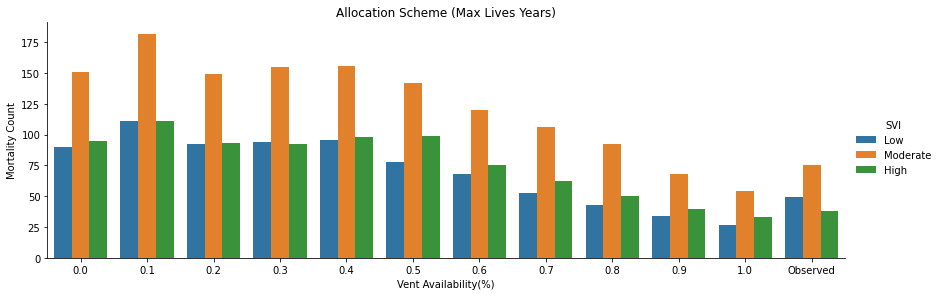

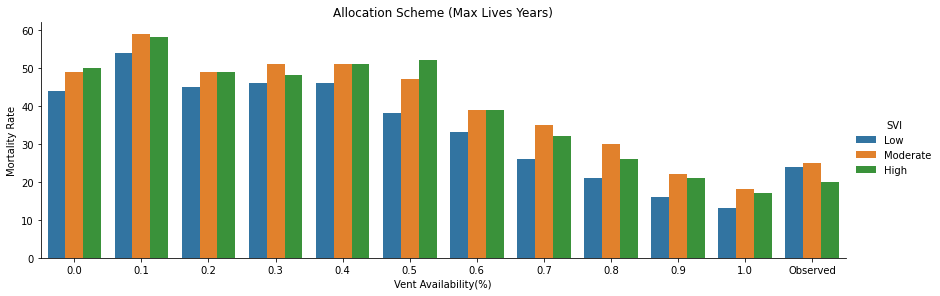

In [56]:
visualize_count_mortality(df_baseline_max_lives_years, 'Max Lives Years')
visualize_percentage_mortality(df_baseline_max_lives_years, 'Max Lives Years')

## Youngest First

In [57]:
ls_df_alloc_level = []          # List of prioritized patients for each scarcity level
ls_df_count_death_svi = []

for pct in vent_availability_pct:
    print('------------------------------{}------------------------------'.format(round(pct, 1)))
    allocation = Allocation(df_sample, pct, calibration_sofa_mortality)   # Generate Allocation object
    df_death = allocation.youngest()                                         # Prioritize patients following Maryland CSC
    
    # Count of deaths for each racial group in each scarcity level
    dict_count_death_race = Counter(df_death['cat_SVI'])

    df_death.rename(columns={'cat_SVI': 'SVI', 'expected_death': 'count_death'}, inplace=True)
    
    df_death['level'] = round(pct, 1)
    df_death['avg_death'] = statistics.mean(df_death.loc[: ,'count_death'])
    df_death['percentage_death'] = df_death.apply(lambda row: percentage_death(row), axis=1)

    ls_df_count_death_svi.append(df_death)

df_youngest = pd.concat(ls_df_count_death_svi)
df_youngest['type_allocation'] = 'Youngest'
df_baseline_youngest = pd.concat([death_svi_baseline, df_youngest])
df_baseline_youngest[['count_death', 'avg_death', 'percentage_death']] = df_baseline_youngest[['count_death', 'avg_death', 'percentage_death']].round(0).astype(int)

------------------------------0.0------------------------------
Number of vents available: 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


SOFA   cat_SVI  count
0      0      High      3
1      0       Low      1
2      0  Moderate      5
3      1      High      3
4      1       Low      4
5      1  Moderate      2
6      2      High      2
7      2       Low      4
8      2  Moderate      4
9      3      High      5
10     3       Low     12
11     3  Moderate     11
12     4      High     19
13     4       Low     13
14     4  Moderate     25
15     5      High     14
16     5       Low     18
17     5  Moderate     16
18     6      High     14
19     6       Low      9
20     6  Moderate     14
21     7      High      4
22     7       Low      8
23     7  Moderate     12
24     8      High      9
25     8       Low      2
26     8  Moderate     18
27     9      High      8
28     9       Low      9
29     9  Moderate     18
30    10      High      4
31    10       Low      2
32    10  Moderate      5
33    11      High      4
34    11       Low      6
35    11  Moderate      9
36    12      High      1
37    12  Moderate      7
38    13      High      2
39    13       Low      2
40    13  Moderate      3
41    14  Moderate      2
42    15      High      1
43    17      High      1
44    19      High      1

cat_SVI  expected_death
0      High              95
1       Low              90
2  Moderate             151

------------------------------0.1------------------------------
Number of vents available: 70


SOFA   cat_SVI  count  mortality rate  expected_death
0      0      High      8           0.000            0.00
1      0       Low      6           0.000            0.00
2      0  Moderate      6           0.000            0.00
3      1      High      2           0.000            0.00
4      1       Low      7           0.000            0.00
5      1  Moderate      5           0.000            0.00
6      2      High      2           0.064            0.13
7      2       Low      2           0.064            0.13
8      2  Moderate      2           0.064            0.13
9      3      High      2           0.064            0.13
10     3       Low      1           0.064            0.06
11     3  Moderate      2           0.064            0.13
12     4      High      4           0.202            0.81
13     4       Low      2           0.202            0.40
14     4  Moderate      5           0.202            1.01
15     5       Low      2           0.202            0.40
16     5  Moderate      2           0.202            0.40
17     6      High      3           0.215            0.64
18     6  Moderate      1           0.215            0.22
19     7       Low      1           0.215            0.22
20     7  Moderate      1           0.215            0.22
21     9      High      2           0.333            0.67
22     9  Moderate      2           0.333            0.67

SOFA   cat_SVI  count
0      0      High      3
1      0       Low      1
2      0  Moderate      4
3      1      High      3
4      1       Low      4
5      1  Moderate      2
6      2      High      1
7      2       Low      4
8      2  Moderate      4
9      3      High      4
10     3       Low     12
11     3  Moderate     11
12     4      High     17
13     4       Low     11
14     4  Moderate     21
15     5      High     14
16     5       Low     16
17     5  Moderate     14
18     6      High     11
19     6       Low      9
20     6  Moderate     13
21     7      High      4
22     7       Low      7
23     7  Moderate     11
24     8      High      9
25     8       Low      2
26     8  Moderate     18
27     9      High      6
28     9       Low      9
29     9  Moderate     16
30    10      High      4
31    10       Low      2
32    10  Moderate      5
33    11      High      4
34    11       Low      6
35    11  Moderate      9
36    12      High      1
37    12  Moderate      7
38    13      High      2
39    13       Low      2
40    13  Moderate      3
41    14  Moderate      2
42    15      High      1
43    17      High      1
44    19      High      1

cat_SVI  expected_death
0      High           88.38
1       Low           86.21
2  Moderate          142.78

------------------------------0.2------------------------------
Number of vents available: 140


SOFA   cat_SVI  count  mortality rate  expected_death
0      0      High     17           0.000            0.00
1      0       Low     10           0.000            0.00
2      0  Moderate     16           0.000            0.00
3      1      High      4           0.000            0.00
4      1       Low      7           0.000            0.00
5      1  Moderate      7           0.000            0.00
6      2      High      2           0.064            0.13
7      2       Low      2           0.064            0.13
8      2  Moderate      9           0.064            0.58
9      3      High      4           0.064            0.26
10     3       Low      3           0.064            0.19
11     3  Moderate      5           0.064            0.32
12     4      High     11           0.202            2.22
13     4       Low      5           0.202            1.01
14     4  Moderate      9           0.202            1.82
15     5       Low      2           0.202            0.40
16     5  Moderate      5           0.202            1.01
17     6      High      5           0.215            1.08
18     6  Moderate      1           0.215            0.22
19     7      High      1           0.215            0.22
20     7       Low      1           0.215            0.22
21     7  Moderate      2           0.215            0.43
22     8      High      2           0.333            0.67
23     9      High      3           0.333            1.00
24     9       Low      1           0.333            0.33
25     9  Moderate      2           0.333            0.67
26    11      High      1           0.500            0.50
27    11       Low      2           0.500            1.00
28    13       Low      1           0.952            0.95

SOFA   cat_SVI  count
0      0      High      3
1      0       Low      1
2      0  Moderate      3
3      1      High      2
4      1       Low      4
5      1  Moderate      1
6      2      High      1
7      2       Low      4
8      2  Moderate      3
9      3      High      3
10     3       Low     11
11     3  Moderate     10
12     4      High     13
13     4       Low     10
14     4  Moderate     17
15     5      High     14
16     5       Low     16
17     5  Moderate     13
18     6      High     10
19     6       Low      9
20     6  Moderate     13
21     7      High      4
22     7       Low      7
23     7  Moderate     10
24     8      High      8
25     8       Low      2
26     8  Moderate     18
27     9      High      5
28     9       Low      8
29     9  Moderate     16
30    10      High      4
31    10       Low      2
32    10  Moderate      5
33    11      High      3
34    11       Low      4
35    11  Moderate      9
36    12      High      1
37    12  Moderate      7
38    13      High      2
39    13       Low      1
40    13  Moderate      3
41    14  Moderate      2
42    15      High      1
43    17      High      1
44    19      High      1

cat_SVI  expected_death
0      High           82.08
1       Low           83.23
2  Moderate          135.05

------------------------------0.3------------------------------
Number of vents available: 210


SOFA   cat_SVI  count  mortality rate  expected_death
0      0      High     21           0.000            0.00
1      0       Low     19           0.000            0.00
2      0  Moderate     21           0.000            0.00
3      1      High      6           0.000            0.00
4      1       Low     11           0.000            0.00
5      1  Moderate      7           0.000            0.00
6      2      High      3           0.064            0.19
7      2       Low      2           0.064            0.13
8      2  Moderate     10           0.064            0.64
9      3      High      8           0.064            0.51
10     3       Low      5           0.064            0.32
11     3  Moderate      8           0.064            0.51
12     4      High     14           0.202            2.83
13     4       Low      7           0.202            1.41
14     4  Moderate     13           0.202            2.63
15     5      High      2           0.202            0.40
16     5       Low      2           0.202            0.40
17     5  Moderate      8           0.202            1.62
18     6      High      6           0.215            1.29
19     6       Low      1           0.215            0.22
20     6  Moderate      2           0.215            0.43
21     7      High      3           0.215            0.64
22     7       Low      2           0.215            0.43
23     7  Moderate      3           0.215            0.64
24     8      High      3           0.333            1.00
25     8       Low      1           0.333            0.33
26     8  Moderate      3           0.333            1.00
27     9      High      3           0.333            1.00
28     9       Low      2           0.333            0.67
29     9  Moderate      4           0.333            1.33
30    10  Moderate      1           0.500            0.50
31    11      High      1           0.500            0.50
32    11       Low      4           0.500            2.00
33    11  Moderate      2           0.500            1.00
34    13       Low      2           0.952            1.90

SOFA   cat_SVI  count
0      0      High      3
1      0       Low      1
2      0  Moderate      3
3      1      High      2
4      1       Low      3
5      1  Moderate      1
6      2      High      1
7      2       Low      4
8      2  Moderate      2
9      3      High      3
10     3       Low     10
11     3  Moderate      9
12     4      High     11
13     4       Low      9
14     4  Moderate     14
15     5      High     12
16     5       Low     16
17     5  Moderate     11
18     6      High      9
19     6       Low      9
20     6  Moderate     12
21     7      High      2
22     7       Low      7
23     7  Moderate      9
24     8      High      8
25     8       Low      1
26     8  Moderate     15
27     9      High      5
28     9       Low      8
29     9  Moderate     14
30    10      High      4
31    10       Low      2
32    10  Moderate      4
33    11      High      3
34    11       Low      2
35    11  Moderate      7
36    12      High      1
37    12  Moderate      7
38    13      High      2
39    13       Low      1
40    13  Moderate      3
41    14  Moderate      2
42    15      High      1
43    17      High      1
44    19      High      1

cat_SVI  expected_death
0      High           77.36
1       Low           80.81
2  Moderate          123.30

------------------------------0.4------------------------------
Number of vents available: 281


SOFA   cat_SVI  count  mortality rate  expected_death
0      0      High     22           0.000            0.00
1      0       Low     26           0.000            0.00
2      0  Moderate     29           0.000            0.00
3      1      High      7           0.000            0.00
4      1       Low     11           0.000            0.00
5      1  Moderate     10           0.000            0.00
6      2      High      4           0.064            0.26
7      2       Low      2           0.064            0.13
8      2  Moderate     14           0.064            0.90
9      3      High      8           0.064            0.51
10     3       Low      6           0.064            0.38
11     3  Moderate     10           0.064            0.64
12     4      High     18           0.202            3.64
13     4       Low      8           0.202            1.62
14     4  Moderate     19           0.202            3.84
15     5      High      6           0.202            1.21
16     5       Low      2           0.202            0.40
17     5  Moderate     14           0.202            2.83
18     6      High      7           0.215            1.50
19     6       Low      4           0.215            0.86
20     6  Moderate      2           0.215            0.43
21     7      High      5           0.215            1.08
22     7       Low      3           0.215            0.64
23     7  Moderate      4           0.215            0.86
24     8      High      4           0.333            1.33
25     8       Low      1           0.333            0.33
26     8  Moderate      6           0.333            2.00
27     9      High      3           0.333            1.00
28     9       Low      3           0.333            1.00
29     9  Moderate      5           0.333            1.66
30    10      High      1           0.500            0.50
31    10  Moderate      1           0.500            0.50
32    11      High      2           0.500            1.00
33    11       Low      4           0.500            2.00
34    11  Moderate      4           0.500            2.00
35    12  Moderate      2           0.952            1.90
36    13       Low      2           0.952            1.90
37    13  Moderate      2           0.952            1.90

SOFA   cat_SVI  count
0      0      High      3
1      0  Moderate      3
2      1      High      2
3      1       Low      3
4      1  Moderate      1
5      2      High      1
6      2       Low      4
7      2  Moderate      2
8      3      High      3
9      3       Low     10
10     3  Moderate      7
11     4      High      9
12     4       Low      9
13     4  Moderate      9
14     5      High      9
15     5       Low     16
16     5  Moderate      8
17     6      High      8
18     6       Low      6
19     6  Moderate     12
20     7      High      1
21     7       Low      6
22     7  Moderate      8
23     8      High      7
24     8       Low      1
25     8  Moderate     12
26     9      High      5
27     9       Low      7
28     9  Moderate     13
29    10      High      3
30    10       Low      2
31    10  Moderate      4
32    11      High      2
33    11       Low      2
34    11  Moderate      5
35    12      High      1
36    12  Moderate      5
37    13      High      2
38    13       Low      1
39    13  Moderate      1
40    14  Moderate      2
41    15      High      1
42    17      High      1
43    19      High      1

cat_SVI  expected_death
0      High           71.03
1       Low           76.26
2  Moderate          111.46

------------------------------0.5------------------------------
Number of vents available: 351
Tie occurs
------------------------------TIE SOFA: 2------------------------------
------------------------------MORTALITY PROBABILITY: 6.4------------------------------
-----------------------ALLOCATED-----------------------


deid_fin_encounter  age_at_admit  gender               race_display  \
0               33220             0  Female         Hispanic or Latino   
1               30021             5  Female  Black or African American   

  insured_uninsured  icu_hours_summed  vent_hours_summed  SOFA  \
0           Insured             17.80                NaN     4   
1         Uninsured             44.47              48.78     3   

   has_comorbidity  count_comorbidity  life_years  \
0                0                  0         100   
1                0                  0          95   

  discharge_disposition_display deceased_dt_tm  ZCTA5   TRACT        GEOID  \
0                          Home            NaN  78753    1813  48453001813   
1                       Expired            NaN  78207  170200  48029170200   

   E_TOTPOP  E_POV  EP_POV  E_UNEMP  EP_UNEMP  E_PCI  E_NOHSDP  EP_NOHSDP  \
0      7423   2425    32.8      168       4.2  20615      1531       33.7   
1      5507   2354    42.7      263      12.2  11186      1818       51.4   

   RPL_THEME1  RPL_THEME2  RPL_THEME3  RPL_THEME4  RPL_THEMES  F_THEME1  \
0      0.7524      0.6154      0.8948      0.8684      0.8543         0   
1      0.9948      0.9724      0.9348      0.9591      0.9969         4   

   F_THEME2  F_THEME3  F_THEME4  F_TOTAL cat_SVI  death  allocate_vent  
0         0         1         0        1    High      0              1  
1         2         1         1        8    High      0              1

SOFA cat_SVI  count  mortality rate  expected_death
0     3    High      1           0.064            0.06
1     4    High      1           0.202            0.20

cat_SVI  expected_death
0    High            0.26

-----------------------TIE-----------------------


deid_fin_encounter  age_at_admit  gender        race_display  \
2                 33504             7    Male  Hispanic or Latino   
3                 28472             8    Male  Hispanic or Latino   
4                 13424             8  Female  Hispanic or Latino   
5                 15557            10    Male  Hispanic or Latino   
6                 25279            10    Male               White   
..                  ...           ...     ...                 ...   
694               35077            92    Male  Hispanic or Latino   
695               45227            93  Female  Hispanic or Latino   
696               31541            93  Female               White   
697               49276            93  Female  Hispanic or Latino   
698               12333            93  Female  Hispanic or Latino   

    insured_uninsured  icu_hours_summed  vent_hours_summed  SOFA  \
2             Insured             79.15                NaN     2   
3             Insured            239.22                NaN     3   
4             Insured             25.40                NaN     1   
5             Insured            863.32            1059.40     4   
6             Insured             70.25                NaN     3   
..                ...               ...                ...   ...   
694           Insured            155.48               0.25     0   
695           Insured            119.48                NaN     5   
696           Insured             50.63                NaN     3   
697           Insured            255.57                NaN     1   
698           Insured             21.65                NaN     2   

     has_comorbidity  count_comorbidity  life_years  \
2                  1                  1          93   
3                  0                  0          92   
4                  1                  2          92   
5                  1                  2          90   
6                  0                  0          90   
..               ...                ...         ...   
694                1                  3           8   
695                1                  4           7   
696                1                  2           7   
697                1                  1           7   
698                1                  1           7   

    discharge_disposition_display   deceased_dt_tm  ZCTA5   TRACT  \
2                            Home              NaN  78744    2411   
3                            Home              NaN  78621    2207   
4                            Home              NaN  76574   20900   
5                            Home              NaN  78724    2207   
6                            Home              NaN  78752    1813   
..                            ...              ...    ...     ...   
694    Home Care with Home Health              NaN  78653    2207   
695                       Expired  7/12/2020 14:56  78745    2411   
696                       Expired  7/12/2020 18:30  78654  960500   
697                    Rehab Care              NaN  78747    2432   
698          Skilled Nursing Care              NaN  78702    2109   

           GEOID  E_TOTPOP  E_POV  EP_POV  E_UNEMP  EP_UNEMP  E_PCI  E_NOHSDP  \
2    48453002411      7453   1986    26.7      241       6.9  15378      1493   
3    48453002207      9453    986    10.4       99       1.9  23059      1390   
4    48491020900      4279    258     6.0      175       7.2  31594       236   
5    48453002207      9453    986    10.4       99       1.9  23059      1390   
6    48453001813      7423   2425    32.8      168       4.2  20615      1531   
..           ...       ...    ...     ...      ...       ...    ...       ...   
694  48453002207      9453    986    10.4       99       1.9  23059      1390   
695  48453002411      7453   1986    26.7      241       6.9  15378      1493   
696  48053960500      6358    758    11.9      175       6.0  27453       528   
697  48453002432      2913    518    18.0      100       6.

cat_SVI  allocate_vent  count  P[NV] & P[V]  P[D|NV] & P[D|V]  P[D_sub]
0      High              0     80          0.42             1.000   0.42000
1      High              1    109          0.58             0.064   0.03712
2       Low              0    116          0.57             1.000   0.57000
3       Low              1     87          0.43             0.064   0.02752
4  Moderate              0    152          0.50             1.000   0.50000
5  Moderate              1    153          0.50             0.064   0.03200

cat_SVI  allocate_vent  count  P[NV] & P[V]  P[D|NV] & P[D|V]  P[D_sub]  \
0      High              0     80          0.42             1.000   0.42000   
1      High              1    109          0.58             0.064   0.03712   
2       Low              0    116          0.57             1.000   0.57000   
3       Low              1     87          0.43             0.064   0.02752   
4  Moderate              0    152          0.50             1.000   0.50000   
5  Moderate              1    153          0.50             0.064   0.03200   

   P[D_total]  expected_death  
0     0.45712        86.39568  
1     0.45712        86.39568  
2     0.59752       121.29656  
3     0.59752       121.29656  
4     0.53200       162.26000  
5     0.53200       162.26000

-----------------------NOT ALLOCATED-----------------------


deid_fin_encounter  age_at_admit  gender               race_display  \
699               38437            94    Male                      White   
700               25087            94    Male         Hispanic or Latino   
701               26729            95  Female                      White   
702               38186           100  Female  Black or African American   

    insured_uninsured  icu_hours_summed  vent_hours_summed  SOFA  \
699           Insured            255.18             247.35     5   
700           Insured            190.41              26.67    11   
701           Insured             59.48                NaN     3   
702           Insured             51.08                NaN     1   

     has_comorbidity  count_comorbidity  life_years  \
699                1                  1           6   
700                1                  2           6   
701                1                  2           5   
702                1                  2           0   

    discharge_disposition_display   deceased_dt_tm  ZCTA5   TRACT  \
699                       Expired  7/19/2020 18:20  78664   20804   
700                       Expired  8/13/2020 14:09  78640  960101   
701                       Expired   7/1/2020 22:10  78731    1716   
702                       Expired  4/14/2020 16:17  78722     306   

           GEOID  E_TOTPOP  E_POV  EP_POV  E_UNEMP  EP_UNEMP  E_PCI  E_NOHSDP  \
699  48491020804     11472    314     2.7      390       6.2  49695        80   
700  48055960101      7238    960    13.3       92       2.7  24231      1539   
701  48453001716      6816    175     2.6      165       3.8  74717        18   
702  48453000306      5520    739    13.5      115       3.2  56024       185   

     EP_NOHSDP  RPL_THEME1  RPL_THEME2  RPL_THEME3  RPL_THEME4  RPL_THEMES  \
699        1.1      0.1460      0.1693      0.2259      0.0810      0.0791   
700       36.0      0.5170      0.4827      0.7179      0.6196      0.6058   
701        0.3      0.0393      0.0816      0.1234      0.1847      0.0503   
702        4.6      0.1792      0.0312      0.4040      0.7715      0.2494   

     F_THEME1  F_THEME2  F_THEME3  F_THEME4  F_TOTAL   cat_SVI  death  \
699         0         0         0         0        0       Low      0   
700         0         0         0         2        2  Moderate      0   
701         0         0         0         0        0       Low      0   
702         0         0         0         1        1       Low      0   

     allocate_vent  
699              0  
700              0  
701              0  
702              0

SOFA   cat_SVI  count
0     1       Low      1
1     3       Low      1
2     5       Low      1
3    11  Moderate      1

cat_SVI  expected_death
0       Low               3
1  Moderate               1

-----------------------TOTAL-----------------------


cat_SVI  count_death
0      High     86.65568
2       Low    124.29656
4  Moderate    163.26000

------------------------------0.6------------------------------
Number of vents available: 421


SOFA   cat_SVI  count  mortality rate  expected_death
0      0      High     29           0.000            0.00
1      0       Low     34           0.000            0.00
2      0  Moderate     40           0.000            0.00
3      1      High      7           0.000            0.00
4      1       Low     16           0.000            0.00
5      1  Moderate     15           0.000            0.00
6      2      High      7           0.064            0.45
7      2       Low      5           0.064            0.32
8      2  Moderate     18           0.064            1.15
9      3      High     12           0.064            0.77
10     3       Low     14           0.064            0.90
11     3  Moderate     14           0.064            0.90
12     4      High     28           0.202            5.66
13     4       Low     11           0.202            2.22
14     4  Moderate     25           0.202            5.05
15     5      High      9           0.202            1.82
16     5       Low      7           0.202            1.41
17     5  Moderate     17           0.202            3.43
18     6      High     11           0.215            2.37
19     6       Low      4           0.215            0.86
20     6  Moderate      7           0.215            1.50
21     7      High      8           0.215            1.72
22     7       Low      5           0.215            1.08
23     7  Moderate      8           0.215            1.72
24     8      High     10           0.333            3.33
25     8       Low      1           0.333            0.33
26     8  Moderate     10           0.333            3.33
27     9      High      4           0.333            1.33
28     9       Low      5           0.333            1.66
29     9  Moderate     11           0.333            3.66
30    10      High      2           0.500            1.00
31    10  Moderate      4           0.500            2.00
32    11      High      3           0.500            1.50
33    11       Low      4           0.500            2.00
34    11  Moderate      7           0.500            3.50
35    12  Moderate      3           0.952            2.86
36    13      High      1           0.952            0.95
37    13       Low      2           0.952            1.90
38    13  Moderate      2           0.952            1.90
39    14  Moderate      1           0.952            0.95

SOFA   cat_SVI  count
0      0      High      3
1      0  Moderate      3
2      1      High      2
3      1       Low      2
4      1  Moderate      1
5      2       Low      3
6      2  Moderate      2
7      3      High      2
8      3       Low      8
9      3  Moderate      4
10     4      High      5
11     4       Low      7
12     4  Moderate      6
13     5      High      6
14     5       Low     11
15     5  Moderate      5
16     6      High      5
17     6       Low      6
18     6  Moderate      8
19     7       Low      4
20     7  Moderate      4
21     8      High      1
22     8       Low      1
23     8  Moderate      8
24     9      High      4
25     9       Low      5
26     9  Moderate      7
27    10      High      2
28    10       Low      2
29    10  Moderate      1
30    11      High      1
31    11       Low      2
32    11  Moderate      2
33    12      High      1
34    12  Moderate      4
35    13      High      1
36    13       Low      1
37    13  Moderate      1
38    14  Moderate      1
39    15      High      1
40    17      High      1
41    19      High      1

cat_SVI  expected_death
0      High           56.90
1       Low           64.68
2  Moderate           88.95

------------------------------0.7------------------------------
Number of vents available: 492


SOFA   cat_SVI  count  mortality rate  expected_death
0      0      High     30           0.000            0.00
1      0       Low     37           0.000            0.00
2      0  Moderate     52           0.000            0.00
3      1      High     11           0.000            0.00
4      1       Low     18           0.000            0.00
5      1  Moderate     20           0.000            0.00
6      2      High      8           0.064            0.51
7      2       Low      7           0.064            0.45
8      2  Moderate     21           0.064            1.34
9      3      High     13           0.064            0.83
10     3       Low     15           0.064            0.96
11     3  Moderate     17           0.064            1.09
12     4      High     30           0.202            6.06
13     4       Low     11           0.202            2.22
14     4  Moderate     27           0.202            5.45
15     5      High     12           0.202            2.42
16     5       Low      8           0.202            1.62
17     5  Moderate     19           0.202            3.84
18     6      High     14           0.215            3.01
19     6       Low      5           0.215            1.08
20     6  Moderate      9           0.215            1.94
21     7      High      8           0.215            1.72
22     7       Low      7           0.215            1.50
23     7  Moderate     10           0.215            2.15
24     8      High     11           0.333            3.66
25     8       Low      1           0.333            0.33
26     8  Moderate     11           0.333            3.66
27     9      High      4           0.333            1.33
28     9       Low      6           0.333            2.00
29     9  Moderate     13           0.333            4.33
30    10      High      2           0.500            1.00
31    10  Moderate      4           0.500            2.00
32    11      High      4           0.500            2.00
33    11       Low      5           0.500            2.50
34    11  Moderate      8           0.500            4.00
35    12  Moderate      6           0.952            5.71
36    13      High      1           0.952            0.95
37    13       Low      3           0.952            2.86
38    13  Moderate      3           0.952            2.86
39    14  Moderate      1           0.952            0.95

SOFA   cat_SVI  count
0      0      High      2
1      0  Moderate      3
2      1      High      1
3      1       Low      2
4      1  Moderate      1
5      2       Low      2
6      2  Moderate      2
7      3      High      2
8      3       Low      8
9      3  Moderate      4
10     4      High      4
11     4       Low      7
12     4  Moderate      6
13     5      High      3
14     5       Low     10
15     5  Moderate      4
16     6      High      3
17     6       Low      5
18     6  Moderate      6
19     7       Low      2
20     7  Moderate      4
21     8       Low      1
22     8  Moderate      7
23     9      High      4
24     9       Low      4
25     9  Moderate      5
26    10      High      2
27    10       Low      2
28    10  Moderate      1
29    11       Low      1
30    11  Moderate      1
31    12      High      1
32    12  Moderate      2
33    13      High      1
34    14  Moderate      1
35    15      High      1
36    17      High      1
37    19      High      1

cat_SVI  expected_death
0      High           49.49
1       Low           59.52
2  Moderate           86.32

------------------------------0.8------------------------------
Number of vents available: 562


SOFA   cat_SVI  count  mortality rate  expected_death
0      0      High     33           0.000            0.00
1      0       Low     40           0.000            0.00
2      0  Moderate     57           0.000            0.00
3      1      High     15           0.000            0.00
4      1       Low     22           0.000            0.00
5      1  Moderate     25           0.000            0.00
6      2      High      8           0.064            0.51
7      2       Low      8           0.064            0.51
8      2  Moderate     22           0.064            1.41
9      3      High     13           0.064            0.83
10     3       Low     21           0.064            1.34
11     3  Moderate     18           0.064            1.15
12     4      High     31           0.202            6.26
13     4       Low     13           0.202            2.63
14     4  Moderate     29           0.202            5.86
15     5      High     14           0.202            2.83
16     5       Low     12           0.202            2.42
17     5  Moderate     21           0.202            4.24
18     6      High     15           0.215            3.22
19     6       Low      9           0.215            1.94
20     6  Moderate     11           0.215            2.37
21     7      High      8           0.215            1.72
22     7       Low     10           0.215            2.15
23     7  Moderate     11           0.215            2.37
24     8      High     11           0.333            3.66
25     8       Low      3           0.333            1.00
26     8  Moderate     14           0.333            4.66
27     9      High      4           0.333            1.33
28     9       Low      6           0.333            2.00
29     9  Moderate     15           0.333            4.99
30    10      High      3           0.500            1.50
31    10       Low      1           0.500            0.50
32    10  Moderate      5           0.500            2.50
33    11      High      4           0.500            2.00
34    11       Low      5           0.500            2.50
35    11  Moderate      8           0.500            4.00
36    12  Moderate      7           0.952            6.66
37    13      High      2           0.952            1.90
38    13       Low      3           0.952            2.86
39    13  Moderate      3           0.952            2.86
40    14  Moderate      2           0.952            1.90

SOFA   cat_SVI  count
0      0      High      2
1      0  Moderate      2
2      1      High      1
3      1       Low      2
4      1  Moderate      1
5      2       Low      1
6      2  Moderate      2
7      3      High      2
8      3       Low      2
9      3  Moderate      4
10     4      High      3
11     4       Low      6
12     4  Moderate      5
13     5      High      1
14     5       Low      6
15     5  Moderate      3
16     6      High      2
17     6       Low      2
18     6  Moderate      4
19     7  Moderate      3
20     8  Moderate      4
21     9      High      4
22     9       Low      4
23     9  Moderate      3
24    10      High      1
25    10       Low      1
26    11       Low      1
27    11  Moderate      1
28    12      High      1
29    12  Moderate      1
30    15      High      1
31    17      High      1
32    19      High      1

cat_SVI  expected_death
0      High           45.76
1       Low           44.85
2  Moderate           77.97

------------------------------0.9------------------------------
Number of vents available: 632


SOFA   cat_SVI  count  mortality rate  expected_death
0      0      High     39           0.000            0.00
1      0       Low     43           0.000            0.00
2      0  Moderate     60           0.000            0.00
3      1      High     15           0.000            0.00
4      1       Low     25           0.000            0.00
5      1  Moderate     29           0.000            0.00
6      2      High      8           0.064            0.51
7      2       Low     12           0.064            0.77
8      2  Moderate     24           0.064            1.54
9      3      High     14           0.064            0.90
10     3       Low     24           0.064            1.54
11     3  Moderate     23           0.064            1.47
12     4      High     33           0.202            6.67
13     4       Low     15           0.202            3.03
14     4  Moderate     30           0.202            6.06
15     5      High     14           0.202            2.83
16     5       Low     16           0.202            3.23
17     5  Moderate     22           0.202            4.44
18     6      High     15           0.215            3.22
19     6       Low     11           0.215            2.37
20     6  Moderate     15           0.215            3.22
21     7      High      8           0.215            1.72
22     7       Low     10           0.215            2.15
23     7  Moderate     14           0.215            3.01
24     8      High     11           0.333            3.66
25     8       Low      3           0.333            1.00
26     8  Moderate     16           0.333            5.33
27     9      High      7           0.333            2.33
28     9       Low      8           0.333            2.66
29     9  Moderate     18           0.333            5.99
30    10      High      4           0.500            2.00
31    10       Low      2           0.500            1.00
32    10  Moderate      5           0.500            2.50
33    11      High      4           0.500            2.00
34    11       Low      6           0.500            3.00
35    11  Moderate      8           0.500            4.00
36    12  Moderate      8           0.952            7.62
37    13      High      2           0.952            1.90
38    13       Low      3           0.952            2.86
39    13  Moderate      3           0.952            2.86
40    14  Moderate      2           0.952            1.90
41    15      High      1           0.952            0.95
42    17      High      1           0.952            0.95
43    19      High      1           0.952            0.95

SOFA   cat_SVI  count
0      0  Moderate      1
1      1      High      1
2      1       Low      1
3      1  Moderate      1
4      2  Moderate      1
5      3      High      1
6      3       Low      1
7      3  Moderate      2
8      4      High      1
9      4       Low      4
10     4  Moderate      4
11     5      High      1
12     5       Low      4
13     5  Moderate      2
14     6      High      2
15     6       Low      1
16     6  Moderate      2
17     8  Moderate      2
18     9      High      1
19     9       Low      2
20    11  Moderate      1
21    12      High      1

cat_SVI  expected_death
0      High           38.59
1       Low           36.61
2  Moderate           65.94

------------------------------1.0------------------------------
Number of vents available: 703


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


SOFA   cat_SVI  count  mortality rate  expected_death
0      0      High     40           0.000            0.00
1      0       Low     46           0.000            0.00
2      0  Moderate     61           0.000            0.00
3      1      High     18           0.000            0.00
4      1       Low     32           0.000            0.00
5      1  Moderate     36           0.000            0.00
6      2      High      9           0.064            0.58
7      2       Low     12           0.064            0.77
8      2  Moderate     26           0.064            1.66
9      3      High     16           0.064            1.02
10     3       Low     26           0.064            1.66
11     3  Moderate     25           0.064            1.60
12     4      High     35           0.202            7.07
13     4       Low     21           0.202            4.24
14     4  Moderate     36           0.202            7.27
15     5      High     15           0.202            3.03
16     5       Low     22           0.202            4.44
17     5  Moderate     25           0.202            5.05
18     6      High     17           0.215            3.66
19     6       Low     13           0.215            2.80
20     6  Moderate     19           0.215            4.08
21     7      High      8           0.215            1.72
22     7       Low     10           0.215            2.15
23     7  Moderate     14           0.215            3.01
24     8      High     11           0.333            3.66
25     8       Low      3           0.333            1.00
26     8  Moderate     19           0.333            6.33
27     9      High      8           0.333            2.66
28     9       Low     10           0.333            3.33
29     9  Moderate     18           0.333            5.99
30    10      High      4           0.500            2.00
31    10       Low      2           0.500            1.00
32    10  Moderate      5           0.500            2.50
33    11      High      4           0.500            2.00
34    11       Low      6           0.500            3.00
35    11  Moderate      9           0.500            4.50
36    12      High      1           0.952            0.95
37    12  Moderate      8           0.952            7.62
38    13      High      2           0.952            1.90
39    13       Low      3           0.952            2.86
40    13  Moderate      3           0.952            2.86
41    14  Moderate      2           0.952            1.90
42    15      High      1           0.952            0.95
43    17      High      1           0.952            0.95
44    19      High      1           0.952            0.95

cat_SVI  expected_death
0      High           33.10
1       Low           27.25
2  Moderate           54.37

In [58]:
df_youngest_tb = df_baseline_youngest.loc[df_baseline_youngest['level']!='Observed', ['SVI', 'count_death', 'level', 'type_allocation']].copy()
display(df_youngest_tb)

SVI  count_death  level type_allocation
0       Low           49    2.0        Baseline
1  Moderate           75    2.0        Baseline
2      High           38    2.0        Baseline
0      High           95    0.0        Youngest
1       Low           90    0.0        Youngest
2  Moderate          151    0.0        Youngest
0      High           88    0.1        Youngest
1       Low           86    0.1        Youngest
2  Moderate          143    0.1        Youngest
0      High           82    0.2        Youngest
1       Low           83    0.2        Youngest
2  Moderate          135    0.2        Youngest
0      High           77    0.3        Youngest
1       Low           81    0.3        Youngest
2  Moderate          123    0.3        Youngest
0      High           71    0.4        Youngest
1       Low           76    0.4        Youngest
2  Moderate          111    0.4        Youngest
0      High           87    0.5        Youngest
2       Low          124    0.5        Youngest
4  Moderate          163    0.5        Youngest
0      High           57    0.6        Youngest
1       Low           65    0.6        Youngest
2  Moderate           89    0.6        Youngest
0      High           49    0.7        Youngest
1       Low           60    0.7        Youngest
2  Moderate           86    0.7        Youngest
0      High           46    0.8        Youngest
1       Low           45    0.8        Youngest
2  Moderate           78    0.8        Youngest
0      High           39    0.9        Youngest
1       Low           37    0.9        Youngest
2  Moderate           66    0.9        Youngest
0      High           33    1.0        Youngest
1       Low           27    1.0        Youngest
2  Moderate           54    1.0        Youngest

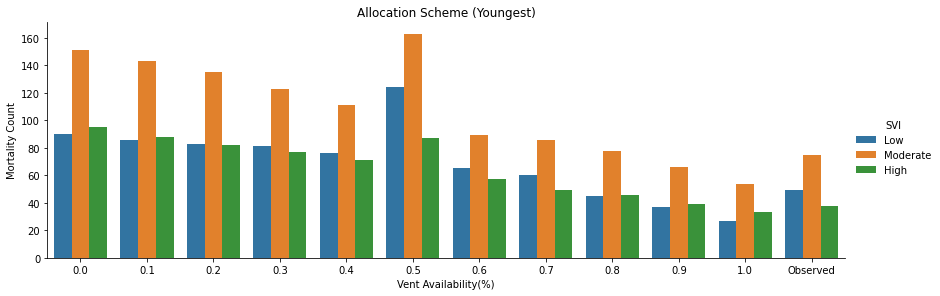

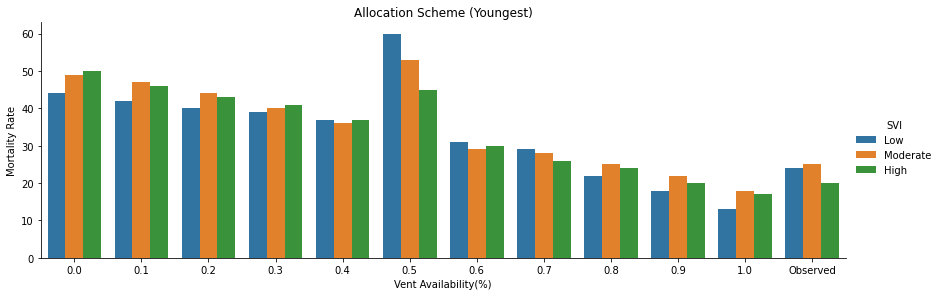

In [59]:
visualize_count_mortality(df_baseline_youngest, 'Youngest')
visualize_percentage_mortality(df_baseline_youngest, 'Youngest')

## Sickest First

In [60]:
ls_df_alloc_level = []          # List of prioritized patients for each scarcity level
ls_df_count_death_svi = []

for pct in vent_availability_pct:
    print('------------------------------{}------------------------------'.format(round(pct, 1)))
    allocation = Allocation(df_sample, pct, calibration_sofa_mortality)   # Generate Allocation object
    df_death = allocation.sickest()                                         # Prioritize patients following Maryland CSC
    
    # Count of deaths for each racial group in each scarcity level
    dict_count_death_race = Counter(df_death['cat_SVI'])

    df_death.rename(columns={'cat_SVI': 'SVI', 'expected_death': 'count_death'}, inplace=True)
    
    df_death['level'] = round(pct, 1)
    df_death['avg_death'] = statistics.mean(df_death.loc[: ,'count_death'])
    df_death['percentage_death'] = df_death.apply(lambda row: percentage_death(row), axis=1)

    ls_df_count_death_svi.append(df_death)

df_sickest = pd.concat(ls_df_count_death_svi)
df_sickest['type_allocation'] = 'Sickest'
df_baseline_sickest = pd.concat([death_svi_baseline, df_sickest])
df_baseline_sickest[['count_death', 'avg_death', 'percentage_death']] = df_baseline_sickest[['count_death', 'avg_death', 'percentage_death']].round(0).astype(int)


------------------------------0.0------------------------------
Number of vents available: 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


SOFA   cat_SVI  count
0      0      High      3
1      0       Low      1
2      0  Moderate      5
3      1      High      3
4      1       Low      4
5      1  Moderate      2
6      2      High      2
7      2       Low      4
8      2  Moderate      4
9      3      High      5
10     3       Low     12
11     3  Moderate     11
12     4      High     19
13     4       Low     13
14     4  Moderate     25
15     5      High     14
16     5       Low     18
17     5  Moderate     16
18     6      High     14
19     6       Low      9
20     6  Moderate     14
21     7      High      4
22     7       Low      8
23     7  Moderate     12
24     8      High      9
25     8       Low      2
26     8  Moderate     18
27     9      High      8
28     9       Low      9
29     9  Moderate     18
30    10      High      4
31    10       Low      2
32    10  Moderate      5
33    11      High      4
34    11       Low      6
35    11  Moderate      9
36    12      High      1
37    12  Moderate      7
38    13      High      2
39    13       Low      2
40    13  Moderate      3
41    14  Moderate      2
42    15      High      1
43    17      High      1
44    19      High      1

cat_SVI  expected_death
0      High              95
1       Low              90
2  Moderate             151

------------------------------0.1------------------------------
Number of vents available: 70
Tie occurs
------------------------------TIE SOFA: 9------------------------------
------------------------------MORTALITY PROBABILITY: 33.3------------------------------
-----------------------ALLOCATED-----------------------


index  deid_fin_encounter  age_at_admit  gender  \
0     766               32723            74    Male   
1     734               32723            74    Male   
2     750               32723            74    Male   
3    6406               17790            58    Male   
4    3268               33610            72    Male   
5    6685               33570            71    Male   
6    3464               37408            52    Male   
7    5641               33932            38    Male   
8    6746               13488            50    Male   
9    3456               37408            52    Male   
10   1128               20938            63    Male   
11   5906               19222            67    Male   
12   6360               24068            66    Male   
13   6417               23045            85    Male   
14   4972               42127            64  Female   
15   5049               45948            78  Female   
16   5063               27098            63    Male   
17   3116               30876            51  Female   
18   6721               46133            70    Male   
19   3084               41028            64    Male   
20   3060               20192            54    Male   
21   4080               22868            65    Male   
22   6410               34707            56    Male   
23   5841               49072            64    Male   
24   6499               16015            58    Male   
25   3542               35133            60    Male   
26   2100               27942            57    Male   
27   6418               14656            46    Male   
28   2908               40457            53    Male   
29   1648               33547            77  Female   
30   1670               48370            38  Female   
31   3124               19398            65    Male   
32   3036               25087            94    Male   
33   1375               30106            52  Female   
34   1401               30811            66  Female   
35   5007               33487            46    Male   
36   6338               27325            38  Female   
37      5               27818            44    Male   
38   1141               17401            38  Female   
39   3790               11253            45    Male   
40   3806               36491            54    Male   
41   6176               28506            69    Male   
42   3440               42261            56  Female   
43   3448               42261            56  Female   
44   6616               44248            49    Male   
45   1102               35541            69    Male   
46   6399               17790            58    Male   
47   1362               12922            51    Male   
48   2269               41218            74  Female   
49    398               17347            60  Female   
50   2518               40443            76    Male   
51   5776               46873            69  Female   

                 race_display insured_uninsured  icu_hours_summed  \
0                       White           Insured             30.60   
1                       White           Insured             30.60   
2                       White           Insured             30.60   
3                       White           Insured            318.77   
4   Black or African American           Insured            138.79   
5          Hispanic or Latino         Uninsured            494.30   
6   Black or African American           Insured            205.20   
7                       White           Insured           2040.97   
8                       White           Insured            128.23   
9   Black or African American           Insured            205.20   
10         Hispanic or Latino           Insured            198.26   
11                      White           Insured             44.97   
12                      White           Insured            146.39   
13         Hispanic or Latino           Insured              2.53   
14         Hispanic or Latino           Insured      

SOFA   cat_SVI  count  mortality rate  expected_death
0     10      High      4           0.500            2.00
1     10       Low      2           0.500            1.00
2     10  Moderate      5           0.500            2.50
3     11      High      4           0.500            2.00
4     11       Low      6           0.500            3.00
5     11  Moderate      9           0.500            4.50
6     12      High      1           0.952            0.95
7     12  Moderate      8           0.952            7.62
8     13      High      2           0.952            1.90
9     13       Low      3           0.952            2.86
10    13  Moderate      3           0.952            2.86
11    14  Moderate      2           0.952            1.90
12    15      High      1           0.952            0.95
13    17      High      1           0.952            0.95
14    19      High      1           0.952            0.95

cat_SVI  expected_death
0      High            9.70
1       Low            6.86
2  Moderate           19.38

-----------------------TIE-----------------------


index  deid_fin_encounter  age_at_admit  gender  \
52   3916               45929            78  Female   
53   5893               19222            67    Male   
54   2243               37368            41    Male   
55   2191               49789            83  Female   
56   5971               33974            61    Male   
57   1115               20938            63    Male   
58   1180               11843            25    Male   
59   4937               15653            58  Female   
60   4965               47828            65  Female   
61   3844               33208            25    Male   
62   2667               13054            54  Female   
63   6667               32708            80  Female   
64   6759               37993            85  Female   
65   5623               33932            38    Male   
66   3068               23765            20    Male   
67    110               37705            24    Male   
68   1589               37577            75    Male   
69   6733               45774            50    Male   
70   3384               13321            63    Male   
71   1659               27408            80    Male   
72   1745               30090            73  Female   
73   4070               37421            61    Male   
74   2727               19288            63    Male   
75   2900               11183            64  Female   
76   1863               29123            75  Female   
77   1878               47188            77    Male   
78   2852               34716            54    Male   
79   3092               31229            74    Male   
80   3774               17709            70    Male   
81   6642               20577            78    Male   
82   3767               39848            63  Female   
83   6468               19794            57  Female   
84   3566               10998            62  Female   
85   3746               49955            49  Female   
86    942               45711            72    Male   
87    839               42438            49    Male   

                 race_display insured_uninsured  icu_hours_summed  \
52         Hispanic or Latino           Insured            798.02   
53                      White           Insured             44.97   
54         Hispanic or Latino         Uninsured            916.33   
55         Hispanic or Latino           Insured            341.32   
56                      White           Insured            358.87   
57         Hispanic or Latino           Insured            198.26   
58                      White         Uninsured            212.12   
59  Black or African American           Insured            103.03   
60                      White           Insured            301.58   
61         Hispanic or Latino         Uninsured            621.97   
62                      White           Insured            102.55   
63                      White           Insured            221.67   
64                      White           Insured             70.32   
65                      White           Insured           2040.97   
66         Hispanic or Latino           Insured            442.30   
67                      White           Insured           1559.88   
68         Hispanic or Latino           Insured            651.68   
69                      White           Insured             39.32   
70         Hispanic or Latino           Insured           1411.95   
71                      White           Insured             34.68   
72                      White           Insured            342.73   
73         Hispanic or Latino         Uninsured            554.38   
74         Hispanic or Latino           Insured            623.76   
75         Hispanic or Latino         Uninsured            290.70   
76         Hispanic or Latino           Insured            791.93   
77                      White           Insured             56.00   
78         Hispanic or Latino         Uninsured            279.17   
79         Hispanic or Latino       

cat_SVI  allocate_vent  count  P[NV] & P[V]  P[D|NV] & P[D|V]  P[D_sub]
0      High              0      2          0.25             1.000   0.25000
1      High              1      6          0.75             0.333   0.24975
2       Low              0      3          0.30             1.000   0.30000
3       Low              1      7          0.70             0.333   0.23310
4  Moderate              0     13          0.72             1.000   0.72000
5  Moderate              1      5          0.28             0.333   0.09324

cat_SVI  allocate_vent  count  P[NV] & P[V]  P[D|NV] & P[D|V]  P[D_sub]  \
0      High              0      2          0.25             1.000   0.25000   
1      High              1      6          0.75             0.333   0.24975   
2       Low              0      3          0.30             1.000   0.30000   
3       Low              1      7          0.70             0.333   0.23310   
4  Moderate              0     13          0.72             1.000   0.72000   
5  Moderate              1      5          0.28             0.333   0.09324   

   P[D_total]  expected_death  
0     0.49975         3.99800  
1     0.49975         3.99800  
2     0.53310         5.33100  
3     0.53310         5.33100  
4     0.81324        14.63832  
5     0.81324        14.63832

-----------------------NOT ALLOCATED-----------------------


index  deid_fin_encounter  age_at_admit  gender  \
88    5437               41528            57  Female   
89    4775               13682            63  Female   
90    1600               39033            57    Male   
91    3052               20192            54    Male   
92    4916               12271            57    Male   
..     ...                 ...           ...     ...   
698   5605               17252            48    Male   
699   5659               47687            39  Female   
700   2687               39176            29    Male   
701   5718               36424            73  Female   
702   3814               39514            19  Female   

                  race_display insured_uninsured  icu_hours_summed  \
88          Hispanic or Latino           Insured            929.56   
89   Black or African American           Insured            519.21   
90                       White           Insured           1023.72   
91          Hispanic or Latino           Insured            365.94   
92   Black or African American           Insured            526.73   
..                         ...               ...               ...   
698                      White           Insured            137.82   
699                      White           Insured             30.02   
700                      White         Uninsured             47.92   
701                      White           Insured             40.17   
702                      White           Insured             17.82   

     vent_hours_summed  SOFA  has_comorbidity  count_comorbidity  life_years  \
88             1067.32     8                1                  4          43   
89              231.40     8                1                  3          37   
90              993.53     8                1                  2          43   
91              367.41     8                1                  3          46   
92              528.28     8                1                  2          43   
..                 ...   ...              ...                ...         ...   
698                NaN     0                1                  2          52   
699                NaN     0                0                  0          61   
700                NaN     0                1                  1          71   
701                NaN     0                0                  0          27   
702                NaN     0                0                  0          81   

    discharge_disposition_display   deceased_dt_tm  ZCTA5   TRACT  \
88                        Expired   9/1/2020 10:23  78610  960101   
89        Long Term Care Hospital              NaN  78752    1813   
90        Long Term Care Hospital              NaN  78723    1811   
91                        Expired  8/13/2020 20:54  78640  960101   
92                        Expired  7/27/2020 11:52  78644  960101   
..                            ...              ...    ...     ...   
698                          Home              NaN  78641   20604   
699                          Home              NaN  78641   20604   
700                          Home              NaN  78727    1848   
701                          Home              NaN  78629     100   
702                          Home              NaN  78616  960101   

           GEOID  E_TOTPOP  E_POV  EP_POV  E_UNEMP  EP_UNEMP  E_PCI  E_NOHSDP  \
88   48055960101      7238    960    13.3       92       2.7  24231      1539   
89   48453001813      7423   2425    32.8      168       4.2  20615      1531   
90   48453001811      3535   1089    30.8       71       3.7  22820       622   
91   48055960101      7238    960    13.3       92       2.7  24231      1539   
92   48055960101      7238    960    13.3       92       2.7  24231      1539   
..           ...       ...    ...     ...      ...       ...    ...       ...   
698  48491020604      6692    192     2.9      183       5.6  38224        83   
699  48491020604      6692    192     2.9      183   

SOFA   cat_SVI  count
0      0      High      3
1      0       Low      1
2      0  Moderate      5
3      1      High      3
4      1       Low      4
5      1  Moderate      2
6      2      High      2
7      2       Low      4
8      2  Moderate      4
9      3      High      5
10     3       Low     12
11     3  Moderate     11
12     4      High     19
13     4       Low     13
14     4  Moderate     25
15     5      High     14
16     5       Low     18
17     5  Moderate     16
18     6      High     14
19     6       Low      9
20     6  Moderate     14
21     7      High      4
22     7       Low      8
23     7  Moderate     12
24     8      High      9
25     8       Low      2
26     8  Moderate     18

cat_SVI  expected_death
0      High              73
1       Low              71
2  Moderate             107

-----------------------TOTAL-----------------------


cat_SVI  count_death
0      High     86.69800
2       Low     83.19100
4  Moderate    141.01832

------------------------------0.2------------------------------
Number of vents available: 140
Tie occurs
------------------------------TIE SOFA: 7------------------------------
------------------------------MORTALITY PROBABILITY: 21.5------------------------------
-----------------------ALLOCATED-----------------------


index  deid_fin_encounter  age_at_admit  gender  \
0      766               32723            74    Male   
1      734               32723            74    Male   
2      750               32723            74    Male   
3     6406               17790            58    Male   
4     3268               33610            72    Male   
..     ...                 ...           ...     ...   
116    462               37806            59    Male   
117   4824               31679            56  Female   
118   6641               10272            75  Female   
119   4923               25522            53  Female   
120   5042               45948            78  Female   

                  race_display insured_uninsured  icu_hours_summed  \
0                        White           Insured             30.60   
1                        White           Insured             30.60   
2                        White           Insured             30.60   
3                        White           Insured            318.77   
4    Black or African American           Insured            138.79   
..                         ...               ...               ...   
116         Hispanic or Latino           Insured           1032.41   
117         Hispanic or Latino         Uninsured           1077.37   
118         Hispanic or Latino         Uninsured            371.39   
119                      White           Insured            307.15   
120         Hispanic or Latino           Insured            522.50   

     vent_hours_summed  SOFA  has_comorbidity  count_comorbidity  life_years  \
0                18.44    19                1                  2          26   
1                18.44    17                1                  2          26   
2                18.44    15                1                  2          26   
3               233.28    14                1                  1          42   
4                51.37    14                1                  1          28   
..                 ...   ...              ...                ...         ...   
116             987.85     8                1                  2          41   
117            1078.02     8                1                  1          44   
118             301.30     8                1                  1          25   
119             301.53     8                1                  2          47   
120             517.10     8                1                  3          22   

    discharge_disposition_display    deceased_dt_tm  ZCTA5   TRACT  \
0                         Expired   11/5/2020 16:40  78753    1813   
1                         Expired   11/5/2020 16:40  78753    1813   
2                         Expired   11/5/2020 16:40  78753    1813   
3                             NaN               NaN  78639  960500   
4                 Still a patient               NaN  78725    2207   
..                            ...               ...    ...     ...   
116                       Expired   9/13/2020 13:01  78753    1813   
117                       Expired  10/15/2020 14:24  78752    1813   
118          Skilled Nursing Care               NaN  78615    1854   
119                       Expired    7/9/2020 17:52  78644  960101   
120                       Expired     9/8/2020 9:51  78644  960101   

           GEOID  E_TOTPOP  E_POV  EP_POV  E_UNEMP  EP_UNEMP  E_PCI  E_NOHSDP  \
0    48453001813      7423   2425    32.8      168       4.2  20615      1531   
1    48453001813      7423   2425    32.8      168       4.2  20615      1531   
2    48453001813      7423   2425    32.8      168       4.2  20615      1531   
3    48053960500      6358    758    11.9      175       6.0  27453       528   
4    48453002207      9453    986    10.4       99       1.9  23059      1390   
..           ...       ...    ...     ...      ...       ...    ...       ...   
116  48453001813      7423   2425    32.8      168       4.2  20615      1531   
117  48453001813      7423   2425    32.8

SOFA   cat_SVI  count  mortality rate  expected_death
0      8      High     11           0.333            3.66
1      8       Low      3           0.333            1.00
2      8  Moderate     19           0.333            6.33
3      9      High      8           0.333            2.66
4      9       Low     10           0.333            3.33
5      9  Moderate     18           0.333            5.99
6     10      High      4           0.500            2.00
7     10       Low      2           0.500            1.00
8     10  Moderate      5           0.500            2.50
9     11      High      4           0.500            2.00
10    11       Low      6           0.500            3.00
11    11  Moderate      9           0.500            4.50
12    12      High      1           0.952            0.95
13    12  Moderate      8           0.952            7.62
14    13      High      2           0.952            1.90
15    13       Low      3           0.952            2.86
16    13  Moderate      3           0.952            2.86
17    14  Moderate      2           0.952            1.90
18    15      High      1           0.952            0.95
19    17      High      1           0.952            0.95
20    19      High      1           0.952            0.95

cat_SVI  expected_death
0      High           16.02
1       Low           11.19
2  Moderate           31.70

-----------------------TIE-----------------------


index  deid_fin_encounter  age_at_admit  gender  \
121   6424               45756            28    Male   
122   1219               41628            49    Male   
123   5461               42865            60    Male   
124    478               27145            47  Female   
125   6156               19424            42  Female   
126   6552               26312            61    Male   
127   6609               12540            73  Female   
128   6637               16059            56    Male   
129   3480               36295            68  Female   
130    382               35200            57  Female   
131   1193               27780            60    Male   
132   4119               30432            63    Male   
133   1258               15030            60    Male   
134   2461               28935            54  Female   
135   3739               33426            75  Female   
136   1154               25299            34    Male   
137   2074               38028            54  Female   
138    718               48179            54  Female   
139   5056               37953            79  Female   
140   3361               32616            66  Female   
141   6448               38255            68    Male   
142   6560               20647            65    Male   
143    867               20496            56  Female   
144   3100               14391            46    Male   
145   6296               38481            73    Male   
146   6328               17498            27  Female   
147   3235               42304            69    Male   
148   1685               45991            48    Male   
149   2996               32542            59  Female   
150   1721               30090            73  Female   
151   3550               43747            53    Male   
152   3907               45929            78  Female   

                  race_display insured_uninsured  icu_hours_summed  \
121  Black or African American           Insured            195.65   
122                      White           Insured           2173.57   
123         Hispanic or Latino           Insured            627.97   
124         Hispanic or Latino           Insured            176.50   
125         Hispanic or Latino         Uninsured            507.53   
126                      White           Insured            902.11   
127                      White           Insured            205.42   
128         Hispanic or Latino         Uninsured            166.90   
129                      White         Uninsured             38.59   
130         Hispanic or Latino           Insured            409.63   
131         Hispanic or Latino           Insured             28.75   
132         Hispanic or Latino           Insured            251.74   
133         Hispanic or Latino           Insured            204.75   
134                      White           Insured             72.68   
135                      White           Insured             97.97   
136                      Asian           Insured            199.00   
137         Hispanic or Latino           Insured            619.10   
138         Hispanic or Latino         Uninsured            143.81   
139                      White           Insured            334.85   
140         Hispanic or Latino           Insured            119.43   
141  Black or African American           Insured            354.92   
142                      White           Insured            333.73   
143         Hispanic or Latino           Insured             89.13   
144         Hispanic or Latino           Insured            322.47   
145                      White           Insured             86.87   
146         Hispanic or Latino           Insured            327.87   
147  Black or African American           Insured            599.32   
148                      White           Insured             95.42   
149         Hispanic or Latino           Insured            287.43   
150                      White           Insured        

cat_SVI  allocate_vent  count  P[NV] & P[V]  P[D|NV] & P[D|V]  P[D_sub]
0      High              1      8          1.00             0.215   0.21500
1       Low              0      5          0.50             1.000   0.50000
2       Low              1      5          0.50             0.215   0.10750
3  Moderate              0      8          0.57             1.000   0.57000
4  Moderate              1      6          0.43             0.215   0.09245

cat_SVI  allocate_vent  count  P[NV] & P[V]  P[D|NV] & P[D|V]  P[D_sub]  \
0      High              1      8          1.00             0.215   0.21500   
1       Low              0      5          0.50             1.000   0.50000   
2       Low              1      5          0.50             0.215   0.10750   
3  Moderate              0      8          0.57             1.000   0.57000   
4  Moderate              1      6          0.43             0.215   0.09245   

   P[D_total]  expected_death  
0     0.21500          1.7200  
1     0.60750          6.0750  
2     0.60750          6.0750  
3     0.66245          9.2743  
4     0.66245          9.2743

-----------------------NOT ALLOCATED-----------------------


index  deid_fin_encounter  age_at_admit  gender  \
153   3962               44013            60  Female   
154   2347               43833            49  Female   
155   3889               34577            48    Male   
156   4698               22664            58    Male   
157   4895               40309            62    Male   
..     ...                 ...           ...     ...   
698   5605               17252            48    Male   
699   5659               47687            39  Female   
700   2687               39176            29    Male   
701   5718               36424            73  Female   
702   3814               39514            19  Female   

                  race_display insured_uninsured  icu_hours_summed  \
153  Black or African American           Insured            293.63   
154         Hispanic or Latino         Uninsured            176.77   
155         Hispanic or Latino           Insured            304.25   
156         Hispanic or Latino         Uninsured            113.61   
157         Hispanic or Latino           Insured            284.17   
..                         ...               ...               ...   
698                      White           Insured            137.82   
699                      White           Insured             30.02   
700                      White         Uninsured             47.92   
701                      White           Insured             40.17   
702                      White           Insured             17.82   

     vent_hours_summed  SOFA  has_comorbidity  count_comorbidity  life_years  \
153             299.13     6                1                  3          40   
154             314.87     6                0                  0          51   
155             303.75     6                1                  3          52   
156                NaN     6                0                  0          42   
157             100.05     6                1                  3          38   
..                 ...   ...              ...                ...         ...   
698                NaN     0                1                  2          52   
699                NaN     0                0                  0          61   
700                NaN     0                1                  1          71   
701                NaN     0                0                  0          27   
702                NaN     0                0                  0          81   

    discharge_disposition_display   deceased_dt_tm  ZCTA5   TRACT  \
153                       Expired  6/12/2020 16:03  78948     200   
154               Still a patient              NaN  78744    2411   
155                       Expired   7/8/2020 22:01  78621    2207   
156                          Home              NaN  78752    1813   
157                       Expired  6/26/2020 15:00  78644  960101   
..                            ...              ...    ...     ...   
698                          Home              NaN  78641   20604   
699                          Home              NaN  78641   20604   
700                          Home              NaN  78727    1848   
701                          Home              NaN  78629     100   
702                          Home              NaN  78616  960101   

           GEOID  E_TOTPOP  E_POV  EP_POV  E_UNEMP  EP_UNEMP  E_PCI  E_NOHSDP  \
153  48287000200      2818    306    10.9       37       2.6  30118       584   
154  48453002411      7453   1986    26.7      241       6.9  15378      1493   
155  48453002207      9453    986    10.4       99       1.9  23059      1390   
156  48453001813      7423   2425    32.8      168       4.2  20615      1531   
157  48055960101      7238    960    13.3       92       2.7  24231      1539   
..           ...       ...    ...     ...      ...       ...    ...       ...   
698  48491020604      6692    192     2.9      183       5.6  38224        83   
699  48491020604      6692    192     2.9      183   

SOFA   cat_SVI  count
0      0      High      3
1      0       Low      1
2      0  Moderate      5
3      1      High      3
4      1       Low      4
5      1  Moderate      2
6      2      High      2
7      2       Low      4
8      2  Moderate      4
9      3      High      5
10     3       Low     12
11     3  Moderate     11
12     4      High     19
13     4       Low     13
14     4  Moderate     25
15     5      High     14
16     5       Low     18
17     5  Moderate     16
18     6      High     14
19     6       Low      9
20     6  Moderate     14

cat_SVI  expected_death
0      High              60
1       Low              61
2  Moderate              77

-----------------------TOTAL-----------------------


cat_SVI  count_death
0      High      77.7400
1       Low      78.2650
3  Moderate     117.9743

------------------------------0.3------------------------------
Number of vents available: 210
Tie occurs
------------------------------TIE SOFA: 5------------------------------
------------------------------MORTALITY PROBABILITY: 20.2------------------------------
-----------------------ALLOCATED-----------------------


index  deid_fin_encounter  age_at_admit gender  \
0      766               32723            74   Male   
1      734               32723            74   Male   
2      750               32723            74   Male   
3     6406               17790            58   Male   
4     3268               33610            72   Male   
..     ...                 ...           ...    ...   
197   1556               26025            28   Male   
198   6572               49492            76   Male   
199   6292               28583            82   Male   
200    414               35282            30   Male   
201     81               36262            70   Male   

                  race_display insured_uninsured  icu_hours_summed  \
0                        White           Insured             30.60   
1                        White           Insured             30.60   
2                        White           Insured             30.60   
3                        White           Insured            318.77   
4    Black or African American           Insured            138.79   
..                         ...               ...               ...   
197  Black or African American         Uninsured             53.73   
198  Black or African American           Insured             55.68   
199                      White           Insured             62.32   
200         Hispanic or Latino           Insured            227.40   
201         Hispanic or Latino           Insured            600.23   

     vent_hours_summed  SOFA  has_comorbidity  count_comorbidity  life_years  \
0                18.44    19                1                  2          26   
1                18.44    17                1                  2          26   
2                18.44    15                1                  2          26   
3               233.28    14                1                  1          42   
4                51.37    14                1                  1          28   
..                 ...   ...              ...                ...         ...   
197              19.15     6                0                  0          72   
198              27.27     6                1                  5          24   
199                NaN     6                1                  4          18   
200             226.17     6                0                  0          70   
201             465.20     6                1                  2          30   

    discharge_disposition_display    deceased_dt_tm  ZCTA5   TRACT  \
0                         Expired   11/5/2020 16:40  78753    1813   
1                         Expired   11/5/2020 16:40  78753    1813   
2                         Expired   11/5/2020 16:40  78753    1813   
3                             NaN               NaN  78639  960500   
4                 Still a patient               NaN  78725    2207   
..                            ...               ...    ...     ...   
197                          Home               NaN  78723    1811   
198    Home Care with Home Health               NaN  78957  970200   
199       Long Term Care Hospital               NaN  78613    1766   
200                       Expired   7/25/2020 18:57  78753    1813   
201                       Expired  10/23/2020 12:35  78612  950802   

           GEOID  E_TOTPOP  E_POV  EP_POV  E_UNEMP  EP_UNEMP  E_PCI  E_NOHSDP  \
0    48453001813      7423   2425    32.8      168       4.2  20615      1531   
1    48453001813      7423   2425    32.8      168       4.2  20615      1531   
2    48453001813      7423   2425    32.8      168       4.2  20615      1531   
3    48053960500      6358    758    11.9      175       6.0  27453       528   
4    48453002207      9453    986    10.4       99       1.9  23059      1390   
..           ...       ...    ...     ...      ...       ...    ...       ...   
197  48453001811      3535   1089    30.8       71       3.7  22820       622   
198  48149970200      2317    186     8.0       34   

SOFA   cat_SVI  count  mortality rate  expected_death
0      6      High     17           0.215            3.66
1      6       Low     13           0.215            2.80
2      6  Moderate     19           0.215            4.08
3      7      High      8           0.215            1.72
4      7       Low     10           0.215            2.15
5      7  Moderate     14           0.215            3.01
6      8      High     11           0.333            3.66
7      8       Low      3           0.333            1.00
8      8  Moderate     19           0.333            6.33
9      9      High      8           0.333            2.66
10     9       Low     10           0.333            3.33
11     9  Moderate     18           0.333            5.99
12    10      High      4           0.500            2.00
13    10       Low      2           0.500            1.00
14    10  Moderate      5           0.500            2.50
15    11      High      4           0.500            2.00
16    11       Low      6           0.500            3.00
17    11  Moderate      9           0.500            4.50
18    12      High      1           0.952            0.95
19    12  Moderate      8           0.952            7.62
20    13      High      2           0.952            1.90
21    13       Low      3           0.952            2.86
22    13  Moderate      3           0.952            2.86
23    14  Moderate      2           0.952            1.90
24    15      High      1           0.952            0.95
25    17      High      1           0.952            0.95
26    19      High      1           0.952            0.95

cat_SVI  expected_death
0      High           21.40
1       Low           16.14
2  Moderate           38.79

-----------------------TIE-----------------------


index  deid_fin_encounter  age_at_admit  gender  \
202    494               28057            53    Male   
203   6392               31072            50    Male   
204    238               37531            70  Female   
205   3353               28487            55    Male   
206   3960               45023            81    Male   
..     ...                 ...           ...     ...   
259   5958               33974            61    Male   
260   5234               46659            69    Male   
261   5587               31660            75  Female   
262   5683               35136            69  Female   
263   5854               38437            94    Male   

                  race_display insured_uninsured  icu_hours_summed  \
202         Hispanic or Latino           Insured            945.69   
203                      White           Insured             72.90   
204         Hispanic or Latino           Insured           1504.68   
205         Hispanic or Latino           Insured             16.28   
206                      White           Insured             96.70   
..                         ...               ...               ...   
259                      White           Insured            358.87   
260         Hispanic or Latino           Insured              7.10   
261                      White           Insured            132.38   
262  Black or African American           Insured            309.54   
263                      White           Insured            255.18   

     vent_hours_summed  SOFA  has_comorbidity  count_comorbidity  life_years  \
202             899.32     5                1                  1          47   
203                NaN     5                1                  2          50   
204             704.40     5                0                  0          30   
205                NaN     5                1                  3          45   
206                NaN     5                1                  1          19   
..                 ...   ...              ...                ...         ...   
259             341.08     5                1                  5          39   
260               2.32     5                1                  2          31   
261                NaN     5                1                  3          25   
262             242.68     5                1                  1          31   
263             247.35     5                1                  1           6   

    discharge_disposition_display    deceased_dt_tm  ZCTA5   TRACT  \
202                    Rehab Care               NaN  78753    1813   
203               Still a patient               NaN  78639  960500   
204       Long Term Care Hospital               NaN  78753    1813   
205                          Home               NaN  78653    2207   
206                       Expired    6/1/2020 20:37  77835  170200   
..                            ...               ...    ...     ...   
259                       Expired  11/12/2020 20:09  78664   20804   
260                       Expired    9/1/2020 23:10  78666   10905   
261          Skilled Nursing Care               NaN  78641   20604   
262                       Expired    7/7/2020 16:31  78629     100   
263                       Expired   7/19/2020 18:20  78664   20804   

           GEOID  E_TOTPOP  E_POV  EP_POV  E_UNEMP  EP_UNEMP  E_PCI  E_NOHSDP  \
202  48453001813      7423   2425    32.8      168       4.2  20615      1531   
203  48053960500      6358    758    11.9      175       6.0  27453       528   
204  48453001813      7423   2425    32.8      168       4.2  20615      1531   
205  48453002207      9453    986    10.4       99       1.9  23059      1390   
206  48477170200      6936    982    14.6      107       3.4  27234       501   
..           ...       ...    ...     ...      ...       ...    ...       ...   
259  48491020804     11472    314     2.7      390       6.2  49695        80   
260  48209010905      6751    329     4.9

cat_SVI  allocate_vent  count  P[NV] & P[V]  P[D|NV] & P[D|V]  P[D_sub]
0      High              0     13          0.87             1.000   0.87000
1      High              1      2          0.13             0.202   0.02626
2       Low              0     22          1.00             1.000   1.00000
3  Moderate              0     19          0.76             1.000   0.76000
4  Moderate              1      6          0.24             0.202   0.04848

cat_SVI  allocate_vent  count  P[NV] & P[V]  P[D|NV] & P[D|V]  P[D_sub]  \
0      High              0     13          0.87             1.000   0.87000   
1      High              1      2          0.13             0.202   0.02626   
2       Low              0     22          1.00             1.000   1.00000   
3  Moderate              0     19          0.76             1.000   0.76000   
4  Moderate              1      6          0.24             0.202   0.04848   

   P[D_total]  expected_death  
0     0.89626         13.4439  
1     0.89626         13.4439  
2     1.00000         22.0000  
3     0.80848         20.2120  
4     0.80848         20.2120

-----------------------NOT ALLOCATED-----------------------


index  deid_fin_encounter  age_at_admit  gender        race_display  \
264    814               33220             0  Female  Hispanic or Latino   
265    825               15345            55    Male               White   
266   4754               25018            28  Female  Hispanic or Latino   
267   2022               36869            56  Female  Hispanic or Latino   
268   3670               45813            82    Male  Hispanic or Latino   
..     ...                 ...           ...     ...                 ...   
698   5605               17252            48    Male               White   
699   5659               47687            39  Female               White   
700   2687               39176            29    Male               White   
701   5718               36424            73  Female               White   
702   3814               39514            19  Female               White   

    insured_uninsured  icu_hours_summed  vent_hours_summed  SOFA  \
264           Insured             17.80                NaN     4   
265           Insured            336.42             327.77     4   
266           Insured            532.52                NaN     4   
267         Uninsured            186.04              77.70     4   
268           Insured             17.97                NaN     4   
..                ...               ...                ...   ...   
698           Insured            137.82                NaN     0   
699           Insured             30.02                NaN     0   
700         Uninsured             47.92                NaN     0   
701           Insured             40.17                NaN     0   
702           Insured             17.82                NaN     0   

     has_comorbidity  count_comorbidity  life_years  \
264                0                  0         100   
265                1                  2          45   
266                1                  3          72   
267                0                  0          44   
268                1                  4          18   
..               ...                ...         ...   
698                1                  2          52   
699                0                  0          61   
700                1                  1          71   
701                0                  0          27   
702                0                  0          81   

    discharge_disposition_display   deceased_dt_tm  ZCTA5   TRACT  \
264                          Home              NaN  78753    1813   
265                       Expired  4/17/2020 14:08  78602  950802   
266    Home Care with Home Health              NaN  78752    1813   
267                          Home              NaN  78744    2411   
268                          Home              NaN  78724    2207   
..                            ...              ...    ...     ...   
698                          Home              NaN  78641   20604   
699                          Home              NaN  78641   20604   
700                          Home              NaN  78727    1848   
701                          Home              NaN  78629     100   
702                          Home              NaN  78616  960101   

           GEOID  E_TOTPOP  E_POV  EP_POV  E_UNEMP  EP_UNEMP  E_PCI  E_NOHSDP  \
264  48453001813      7423   2425    32.8      168       4.2  20615      1531   
265  48021950802      7625   1011    13.3      334       8.6  21691      1023   
266  48453001813      7423   2425    32.8      168       4.2  20615      1531   
267  48453002411      7453   1986    26.7      241       6.9  15378      1493   
268  48453002207      9453    986    10.4       99       1.9  23059      1390   
..           ...       ...    ...     ...      ...       ...    ...       ...   
698  48491020604      6692    192     2.9      183       5.6  38224        83   
699  48491020604      6692    192     2.9      183       5.6  38224        83   
700  48453001848      5373    335     6.2      231      

SOFA   cat_SVI  count
0      0      High      3
1      0       Low      1
2      0  Moderate      5
3      1      High      3
4      1       Low      4
5      1  Moderate      2
6      2      High      2
7      2       Low      4
8      2  Moderate      4
9      3      High      5
10     3       Low     12
11     3  Moderate     11
12     4      High     19
13     4       Low     13
14     4  Moderate     25

cat_SVI  expected_death
0      High              32
1       Low              34
2  Moderate              47

-----------------------TOTAL-----------------------


cat_SVI  count_death
0      High      66.8439
2       Low      72.1400
3  Moderate     106.0020

------------------------------0.4------------------------------
Number of vents available: 281
Tie occurs
------------------------------TIE SOFA: 4------------------------------
------------------------------MORTALITY PROBABILITY: 20.2------------------------------
-----------------------ALLOCATED-----------------------


index  deid_fin_encounter  age_at_admit  gender  \
0      766               32723            74    Male   
1      734               32723            74    Male   
2      750               32723            74    Male   
3     6406               17790            58    Male   
4     3268               33610            72    Male   
..     ...                 ...           ...     ...   
259   5958               33974            61    Male   
260   5234               46659            69    Male   
261   5587               31660            75  Female   
262   5683               35136            69  Female   
263   5854               38437            94    Male   

                  race_display insured_uninsured  icu_hours_summed  \
0                        White           Insured             30.60   
1                        White           Insured             30.60   
2                        White           Insured             30.60   
3                        White           Insured            318.77   
4    Black or African American           Insured            138.79   
..                         ...               ...               ...   
259                      White           Insured            358.87   
260         Hispanic or Latino           Insured              7.10   
261                      White           Insured            132.38   
262  Black or African American           Insured            309.54   
263                      White           Insured            255.18   

     vent_hours_summed  SOFA  has_comorbidity  count_comorbidity  life_years  \
0                18.44    19                1                  2          26   
1                18.44    17                1                  2          26   
2                18.44    15                1                  2          26   
3               233.28    14                1                  1          42   
4                51.37    14                1                  1          28   
..                 ...   ...              ...                ...         ...   
259             341.08     5                1                  5          39   
260               2.32     5                1                  2          31   
261                NaN     5                1                  3          25   
262             242.68     5                1                  1          31   
263             247.35     5                1                  1           6   

    discharge_disposition_display    deceased_dt_tm  ZCTA5   TRACT  \
0                         Expired   11/5/2020 16:40  78753    1813   
1                         Expired   11/5/2020 16:40  78753    1813   
2                         Expired   11/5/2020 16:40  78753    1813   
3                             NaN               NaN  78639  960500   
4                 Still a patient               NaN  78725    2207   
..                            ...               ...    ...     ...   
259                       Expired  11/12/2020 20:09  78664   20804   
260                       Expired    9/1/2020 23:10  78666   10905   
261          Skilled Nursing Care               NaN  78641   20604   
262                       Expired    7/7/2020 16:31  78629     100   
263                       Expired   7/19/2020 18:20  78664   20804   

           GEOID  E_TOTPOP  E_POV  EP_POV  E_UNEMP  EP_UNEMP  E_PCI  E_NOHSDP  \
0    48453001813      7423   2425    32.8      168       4.2  20615      1531   
1    48453001813      7423   2425    32.8      168       4.2  20615      1531   
2    48453001813      7423   2425    32.8      168       4.2  20615      1531   
3    48053960500      6358    758    11.9      175       6.0  27453       528   
4    48453002207      9453    986    10.4       99       1.9  23059      1390   
..           ...       ...    ...     ...      ...       ...    ...       ...   
259  48491020804     11472    314     2.7      390       6.2  49695        80   
260  48209010905      6751    329     4.9

SOFA   cat_SVI  count  mortality rate  expected_death
0      5      High     15           0.202            3.03
1      5       Low     22           0.202            4.44
2      5  Moderate     25           0.202            5.05
3      6      High     17           0.215            3.66
4      6       Low     13           0.215            2.80
5      6  Moderate     19           0.215            4.08
6      7      High      8           0.215            1.72
7      7       Low     10           0.215            2.15
8      7  Moderate     14           0.215            3.01
9      8      High     11           0.333            3.66
10     8       Low      3           0.333            1.00
11     8  Moderate     19           0.333            6.33
12     9      High      8           0.333            2.66
13     9       Low     10           0.333            3.33
14     9  Moderate     18           0.333            5.99
15    10      High      4           0.500            2.00
16    10       Low      2           0.500            1.00
17    10  Moderate      5           0.500            2.50
18    11      High      4           0.500            2.00
19    11       Low      6           0.500            3.00
20    11  Moderate      9           0.500            4.50
21    12      High      1           0.952            0.95
22    12  Moderate      8           0.952            7.62
23    13      High      2           0.952            1.90
24    13       Low      3           0.952            2.86
25    13  Moderate      3           0.952            2.86
26    14  Moderate      2           0.952            1.90
27    15      High      1           0.952            0.95
28    17      High      1           0.952            0.95
29    19      High      1           0.952            0.95

cat_SVI  expected_death
0      High           24.43
1       Low           20.58
2  Moderate           43.84

-----------------------TIE-----------------------


index  deid_fin_encounter  age_at_admit  gender        race_display  \
264    814               33220             0  Female  Hispanic or Latino   
265    825               15345            55    Male               White   
266   4754               25018            28  Female  Hispanic or Latino   
267   2022               36869            56  Female  Hispanic or Latino   
268   3670               45813            82    Male  Hispanic or Latino   
..     ...                 ...           ...     ...                 ...   
351   3329               37238            54    Male  Hispanic or Latino   
352   3321               41498            56    Male  Hispanic or Latino   
353   2892               39080            64    Male               White   
354   6414               22985            90    Male  Hispanic or Latino   
355    206               19128            83    Male               White   

    insured_uninsured  icu_hours_summed  vent_hours_summed  SOFA  \
264           Insured             17.80                NaN     4   
265           Insured            336.42             327.77     4   
266           Insured            532.52                NaN     4   
267         Uninsured            186.04              77.70     4   
268           Insured             17.97                NaN     4   
..                ...               ...                ...   ...   
351         Uninsured            229.55             194.00     4   
352           Insured            665.50             588.26     4   
353           Insured            119.22                NaN     4   
354           Insured             23.13                NaN     4   
355           Insured            163.97             167.37     4   

     has_comorbidity  count_comorbidity  life_years  \
264                0                  0         100   
265                1                  2          45   
266                1                  3          72   
267                0                  0          44   
268                1                  4          18   
..               ...                ...         ...   
351                1                  2          46   
352                1                  3          44   
353                1                  2          36   
354                0                  0          10   
355                1                  2          17   

    discharge_disposition_display   deceased_dt_tm  ZCTA5   TRACT  \
264                          Home              NaN  78753    1813   
265                       Expired  4/17/2020 14:08  78602  950802   
266    Home Care with Home Health              NaN  78752    1813   
267                          Home              NaN  78744    2411   
268                          Home              NaN  78724    2207   
..                            ...              ...    ...     ...   
351          Skilled Nursing Care              NaN  78653    2207   
352                       Expired  7/29/2020 17:30  78653    2207   
353    Home Care with Home Health              NaN  78640  960101   
354               Still a patient              NaN  78606  950100   
355                       Expired    5/1/2020 0:01  78753    1813   

           GEOID  E_TOTPOP  E_POV  EP_POV  E_UNEMP  EP_UNEMP  E_PCI  E_NOHSDP  \
264  48453001813      7423   2425    32.8      168       4.2  20615      1531   
265  48021950802      7625   1011    13.3      334       8.6  21691      1023   
266  48453001813      7423   2425    32.8      168       4.2  20615      1531   
267  48453002411      7453   1986    26.7      241       6.9  15378      1493   
268  48453002207      9453    986    10.4       99       1.9  23059      1390   
..           ...       ...    ...     ...      ...       ...    ...       ...   
351  48453002207      9453    986    10.4       99       1.9  23059      1390   
352  48453002207      9453    986    10.4       99       1.9  23059      1390   
353  48055960101      7238    960    13.3       92      

cat_SVI  allocate_vent  count  P[NV] & P[V]  P[D|NV] & P[D|V]  P[D_sub]
0      High              0     29          0.83             1.000   0.83000
1      High              1      6          0.17             0.202   0.03434
2       Low              0     17          0.81             1.000   0.81000
3       Low              1      4          0.19             0.202   0.03838
4  Moderate              0     29          0.81             1.000   0.81000
5  Moderate              1      7          0.19             0.202   0.03838

cat_SVI  allocate_vent  count  P[NV] & P[V]  P[D|NV] & P[D|V]  P[D_sub]  \
0      High              0     29          0.83             1.000   0.83000   
1      High              1      6          0.17             0.202   0.03434   
2       Low              0     17          0.81             1.000   0.81000   
3       Low              1      4          0.19             0.202   0.03838   
4  Moderate              0     29          0.81             1.000   0.81000   
5  Moderate              1      7          0.19             0.202   0.03838   

   P[D_total]  expected_death  
0     0.86434        30.25190  
1     0.86434        30.25190  
2     0.84838        17.81598  
3     0.84838        17.81598  
4     0.84838        30.54168  
5     0.84838        30.54168

-----------------------NOT ALLOCATED-----------------------


index  deid_fin_encounter  age_at_admit  gender  \
356   4481               45607            62    Male   
357   5880               44009            42    Male   
358   4463               10870            70  Female   
359   4490               35834            38    Male   
360   6797               30021             5  Female   
..     ...                 ...           ...     ...   
698   5605               17252            48    Male   
699   5659               47687            39  Female   
700   2687               39176            29    Male   
701   5718               36424            73  Female   
702   3814               39514            19  Female   

                  race_display insured_uninsured  icu_hours_summed  \
356                      White           Insured            105.07   
357         Hispanic or Latino         Uninsured             38.27   
358                      White           Insured            172.38   
359         Hispanic or Latino           Insured            368.50   
360  Black or African American         Uninsured             44.47   
..                         ...               ...               ...   
698                      White           Insured            137.82   
699                      White           Insured             30.02   
700                      White         Uninsured             47.92   
701                      White           Insured             40.17   
702                      White           Insured             17.82   

     vent_hours_summed  SOFA  has_comorbidity  count_comorbidity  life_years  \
356                NaN     3                1                  1          38   
357                NaN     3                0                  0          58   
358                NaN     3                1                  3          30   
359             334.60     3                1                  1          62   
360              48.78     3                0                  0          95   
..                 ...   ...              ...                ...         ...   
698                NaN     0                1                  2          52   
699                NaN     0                0                  0          61   
700                NaN     0                1                  1          71   
701                NaN     0                0                  0          27   
702                NaN     0                0                  0          81   

    discharge_disposition_display   deceased_dt_tm  ZCTA5   TRACT  \
356                          Home              NaN  78665   20804   
357                          Home              NaN  78664   20804   
358                       Expired  7/21/2020 14:32  78665   20804   
359                    Rehab Care              NaN  78665   20804   
360                       Expired              NaN  78207  170200   
..                            ...              ...    ...     ...   
698                          Home              NaN  78641   20604   
699                          Home              NaN  78641   20604   
700                          Home              NaN  78727    1848   
701                          Home              NaN  78629     100   
702                          Home              NaN  78616  960101   

           GEOID  E_TOTPOP  E_POV  EP_POV  E_UNEMP  EP_UNEMP  E_PCI  E_NOHSDP  \
356  48491020804     11472    314     2.7      390       6.2  49695        80   
357  48491020804     11472    314     2.7      390       6.2  49695        80   
358  48491020804     11472    314     2.7      390       6.2  49695        80   
359  48491020804     11472    314     2.7      390       6.2  49695        80   
360  48029170200      5507   2354    42.7      263      12.2  11186      1818   
..           ...       ...    ...     ...      ...       ...    ...       ...   
698  48491020604      6692    192     2.9      183       5.6  38224        83   
699  48491020604      6692    192     2.9      183   

SOFA   cat_SVI  count
0      0      High      3
1      0       Low      1
2      0  Moderate      5
3      1      High      3
4      1       Low      4
5      1  Moderate      2
6      2      High      2
7      2       Low      4
8      2  Moderate      4
9      3      High      5
10     3       Low     12
11     3  Moderate     11

cat_SVI  expected_death
0      High              13
1       Low              21
2  Moderate              22

-----------------------TOTAL-----------------------


cat_SVI  count_death
0      High     67.68190
2       Low     59.39598
4  Moderate     96.38168

------------------------------0.5------------------------------
Number of vents available: 351
Tie occurs
------------------------------TIE SOFA: 4------------------------------
------------------------------MORTALITY PROBABILITY: 20.2------------------------------
-----------------------ALLOCATED-----------------------


index  deid_fin_encounter  age_at_admit  gender  \
0      766               32723            74    Male   
1      734               32723            74    Male   
2      750               32723            74    Male   
3     6406               17790            58    Male   
4     3268               33610            72    Male   
..     ...                 ...           ...     ...   
259   5958               33974            61    Male   
260   5234               46659            69    Male   
261   5587               31660            75  Female   
262   5683               35136            69  Female   
263   5854               38437            94    Male   

                  race_display insured_uninsured  icu_hours_summed  \
0                        White           Insured             30.60   
1                        White           Insured             30.60   
2                        White           Insured             30.60   
3                        White           Insured            318.77   
4    Black or African American           Insured            138.79   
..                         ...               ...               ...   
259                      White           Insured            358.87   
260         Hispanic or Latino           Insured              7.10   
261                      White           Insured            132.38   
262  Black or African American           Insured            309.54   
263                      White           Insured            255.18   

     vent_hours_summed  SOFA  has_comorbidity  count_comorbidity  life_years  \
0                18.44    19                1                  2          26   
1                18.44    17                1                  2          26   
2                18.44    15                1                  2          26   
3               233.28    14                1                  1          42   
4                51.37    14                1                  1          28   
..                 ...   ...              ...                ...         ...   
259             341.08     5                1                  5          39   
260               2.32     5                1                  2          31   
261                NaN     5                1                  3          25   
262             242.68     5                1                  1          31   
263             247.35     5                1                  1           6   

    discharge_disposition_display    deceased_dt_tm  ZCTA5   TRACT  \
0                         Expired   11/5/2020 16:40  78753    1813   
1                         Expired   11/5/2020 16:40  78753    1813   
2                         Expired   11/5/2020 16:40  78753    1813   
3                             NaN               NaN  78639  960500   
4                 Still a patient               NaN  78725    2207   
..                            ...               ...    ...     ...   
259                       Expired  11/12/2020 20:09  78664   20804   
260                       Expired    9/1/2020 23:10  78666   10905   
261          Skilled Nursing Care               NaN  78641   20604   
262                       Expired    7/7/2020 16:31  78629     100   
263                       Expired   7/19/2020 18:20  78664   20804   

           GEOID  E_TOTPOP  E_POV  EP_POV  E_UNEMP  EP_UNEMP  E_PCI  E_NOHSDP  \
0    48453001813      7423   2425    32.8      168       4.2  20615      1531   
1    48453001813      7423   2425    32.8      168       4.2  20615      1531   
2    48453001813      7423   2425    32.8      168       4.2  20615      1531   
3    48053960500      6358    758    11.9      175       6.0  27453       528   
4    48453002207      9453    986    10.4       99       1.9  23059      1390   
..           ...       ...    ...     ...      ...       ...    ...       ...   
259  48491020804     11472    314     2.7      390       6.2  49695        80   
260  48209010905      6751    329     4.9

SOFA   cat_SVI  count  mortality rate  expected_death
0      5      High     15           0.202            3.03
1      5       Low     22           0.202            4.44
2      5  Moderate     25           0.202            5.05
3      6      High     17           0.215            3.66
4      6       Low     13           0.215            2.80
5      6  Moderate     19           0.215            4.08
6      7      High      8           0.215            1.72
7      7       Low     10           0.215            2.15
8      7  Moderate     14           0.215            3.01
9      8      High     11           0.333            3.66
10     8       Low      3           0.333            1.00
11     8  Moderate     19           0.333            6.33
12     9      High      8           0.333            2.66
13     9       Low     10           0.333            3.33
14     9  Moderate     18           0.333            5.99
15    10      High      4           0.500            2.00
16    10       Low      2           0.500            1.00
17    10  Moderate      5           0.500            2.50
18    11      High      4           0.500            2.00
19    11       Low      6           0.500            3.00
20    11  Moderate      9           0.500            4.50
21    12      High      1           0.952            0.95
22    12  Moderate      8           0.952            7.62
23    13      High      2           0.952            1.90
24    13       Low      3           0.952            2.86
25    13  Moderate      3           0.952            2.86
26    14  Moderate      2           0.952            1.90
27    15      High      1           0.952            0.95
28    17      High      1           0.952            0.95
29    19      High      1           0.952            0.95

cat_SVI  expected_death
0      High           24.43
1       Low           20.58
2  Moderate           43.84

-----------------------TIE-----------------------


index  deid_fin_encounter  age_at_admit  gender        race_display  \
264    814               33220             0  Female  Hispanic or Latino   
265    825               15345            55    Male               White   
266   4754               25018            28  Female  Hispanic or Latino   
267   2022               36869            56  Female  Hispanic or Latino   
268   3670               45813            82    Male  Hispanic or Latino   
..     ...                 ...           ...     ...                 ...   
351   3329               37238            54    Male  Hispanic or Latino   
352   3321               41498            56    Male  Hispanic or Latino   
353   2892               39080            64    Male               White   
354   6414               22985            90    Male  Hispanic or Latino   
355    206               19128            83    Male               White   

    insured_uninsured  icu_hours_summed  vent_hours_summed  SOFA  \
264           Insured             17.80                NaN     4   
265           Insured            336.42             327.77     4   
266           Insured            532.52                NaN     4   
267         Uninsured            186.04              77.70     4   
268           Insured             17.97                NaN     4   
..                ...               ...                ...   ...   
351         Uninsured            229.55             194.00     4   
352           Insured            665.50             588.26     4   
353           Insured            119.22                NaN     4   
354           Insured             23.13                NaN     4   
355           Insured            163.97             167.37     4   

     has_comorbidity  count_comorbidity  life_years  \
264                0                  0         100   
265                1                  2          45   
266                1                  3          72   
267                0                  0          44   
268                1                  4          18   
..               ...                ...         ...   
351                1                  2          46   
352                1                  3          44   
353                1                  2          36   
354                0                  0          10   
355                1                  2          17   

    discharge_disposition_display   deceased_dt_tm  ZCTA5   TRACT  \
264                          Home              NaN  78753    1813   
265                       Expired  4/17/2020 14:08  78602  950802   
266    Home Care with Home Health              NaN  78752    1813   
267                          Home              NaN  78744    2411   
268                          Home              NaN  78724    2207   
..                            ...              ...    ...     ...   
351          Skilled Nursing Care              NaN  78653    2207   
352                       Expired  7/29/2020 17:30  78653    2207   
353    Home Care with Home Health              NaN  78640  960101   
354               Still a patient              NaN  78606  950100   
355                       Expired    5/1/2020 0:01  78753    1813   

           GEOID  E_TOTPOP  E_POV  EP_POV  E_UNEMP  EP_UNEMP  E_PCI  E_NOHSDP  \
264  48453001813      7423   2425    32.8      168       4.2  20615      1531   
265  48021950802      7625   1011    13.3      334       8.6  21691      1023   
266  48453001813      7423   2425    32.8      168       4.2  20615      1531   
267  48453002411      7453   1986    26.7      241       6.9  15378      1493   
268  48453002207      9453    986    10.4       99       1.9  23059      1390   
..           ...       ...    ...     ...      ...       ...    ...       ...   
351  48453002207      9453    986    10.4       99       1.9  23059      1390   
352  48453002207      9453    986    10.4       99       1.9  23059      1390   
353  48055960101      7238    960    13.3       92      

cat_SVI  allocate_vent  count  P[NV] & P[V]  P[D|NV] & P[D|V]  P[D_sub]
0      High              0      1          0.03             1.000   0.03000
1      High              1     34          0.97             0.202   0.19594
2       Low              0      1          0.05             1.000   0.05000
3       Low              1     20          0.95             0.202   0.19190
4  Moderate              0      3          0.08             1.000   0.08000
5  Moderate              1     33          0.92             0.202   0.18584

cat_SVI  allocate_vent  count  P[NV] & P[V]  P[D|NV] & P[D|V]  P[D_sub]  \
0      High              0      1          0.03             1.000   0.03000   
1      High              1     34          0.97             0.202   0.19594   
2       Low              0      1          0.05             1.000   0.05000   
3       Low              1     20          0.95             0.202   0.19190   
4  Moderate              0      3          0.08             1.000   0.08000   
5  Moderate              1     33          0.92             0.202   0.18584   

   P[D_total]  expected_death  
0     0.22594         7.90790  
1     0.22594         7.90790  
2     0.24190         5.07990  
3     0.24190         5.07990  
4     0.26584         9.57024  
5     0.26584         9.57024

-----------------------NOT ALLOCATED-----------------------


index  deid_fin_encounter  age_at_admit  gender  \
356   4481               45607            62    Male   
357   5880               44009            42    Male   
358   4463               10870            70  Female   
359   4490               35834            38    Male   
360   6797               30021             5  Female   
..     ...                 ...           ...     ...   
698   5605               17252            48    Male   
699   5659               47687            39  Female   
700   2687               39176            29    Male   
701   5718               36424            73  Female   
702   3814               39514            19  Female   

                  race_display insured_uninsured  icu_hours_summed  \
356                      White           Insured            105.07   
357         Hispanic or Latino         Uninsured             38.27   
358                      White           Insured            172.38   
359         Hispanic or Latino           Insured            368.50   
360  Black or African American         Uninsured             44.47   
..                         ...               ...               ...   
698                      White           Insured            137.82   
699                      White           Insured             30.02   
700                      White         Uninsured             47.92   
701                      White           Insured             40.17   
702                      White           Insured             17.82   

     vent_hours_summed  SOFA  has_comorbidity  count_comorbidity  life_years  \
356                NaN     3                1                  1          38   
357                NaN     3                0                  0          58   
358                NaN     3                1                  3          30   
359             334.60     3                1                  1          62   
360              48.78     3                0                  0          95   
..                 ...   ...              ...                ...         ...   
698                NaN     0                1                  2          52   
699                NaN     0                0                  0          61   
700                NaN     0                1                  1          71   
701                NaN     0                0                  0          27   
702                NaN     0                0                  0          81   

    discharge_disposition_display   deceased_dt_tm  ZCTA5   TRACT  \
356                          Home              NaN  78665   20804   
357                          Home              NaN  78664   20804   
358                       Expired  7/21/2020 14:32  78665   20804   
359                    Rehab Care              NaN  78665   20804   
360                       Expired              NaN  78207  170200   
..                            ...              ...    ...     ...   
698                          Home              NaN  78641   20604   
699                          Home              NaN  78641   20604   
700                          Home              NaN  78727    1848   
701                          Home              NaN  78629     100   
702                          Home              NaN  78616  960101   

           GEOID  E_TOTPOP  E_POV  EP_POV  E_UNEMP  EP_UNEMP  E_PCI  E_NOHSDP  \
356  48491020804     11472    314     2.7      390       6.2  49695        80   
357  48491020804     11472    314     2.7      390       6.2  49695        80   
358  48491020804     11472    314     2.7      390       6.2  49695        80   
359  48491020804     11472    314     2.7      390       6.2  49695        80   
360  48029170200      5507   2354    42.7      263      12.2  11186      1818   
..           ...       ...    ...     ...      ...       ...    ...       ...   
698  48491020604      6692    192     2.9      183       5.6  38224        83   
699  48491020604      6692    192     2.9      183   

SOFA   cat_SVI  count
0      0      High      3
1      0       Low      1
2      0  Moderate      5
3      1      High      3
4      1       Low      4
5      1  Moderate      2
6      2      High      2
7      2       Low      4
8      2  Moderate      4
9      3      High      5
10     3       Low     12
11     3  Moderate     11

cat_SVI  expected_death
0      High              13
1       Low              21
2  Moderate              22

-----------------------TOTAL-----------------------


cat_SVI  count_death
0      High     45.33790
2       Low     46.65990
4  Moderate     75.41024

------------------------------0.6------------------------------
Number of vents available: 421
Tie occurs
------------------------------TIE SOFA: 3------------------------------
------------------------------MORTALITY PROBABILITY: 6.4------------------------------
-----------------------ALLOCATED-----------------------


index  deid_fin_encounter  age_at_admit gender  \
0      766               32723            74   Male   
1      734               32723            74   Male   
2      750               32723            74   Male   
3     6406               17790            58   Male   
4     3268               33610            72   Male   
..     ...                 ...           ...    ...   
351   3329               37238            54   Male   
352   3321               41498            56   Male   
353   2892               39080            64   Male   
354   6414               22985            90   Male   
355    206               19128            83   Male   

                  race_display insured_uninsured  icu_hours_summed  \
0                        White           Insured             30.60   
1                        White           Insured             30.60   
2                        White           Insured             30.60   
3                        White           Insured            318.77   
4    Black or African American           Insured            138.79   
..                         ...               ...               ...   
351         Hispanic or Latino         Uninsured            229.55   
352         Hispanic or Latino           Insured            665.50   
353                      White           Insured            119.22   
354         Hispanic or Latino           Insured             23.13   
355                      White           Insured            163.97   

     vent_hours_summed  SOFA  has_comorbidity  count_comorbidity  life_years  \
0                18.44    19                1                  2          26   
1                18.44    17                1                  2          26   
2                18.44    15                1                  2          26   
3               233.28    14                1                  1          42   
4                51.37    14                1                  1          28   
..                 ...   ...              ...                ...         ...   
351             194.00     4                1                  2          46   
352             588.26     4                1                  3          44   
353                NaN     4                1                  2          36   
354                NaN     4                0                  0          10   
355             167.37     4                1                  2          17   

    discharge_disposition_display   deceased_dt_tm  ZCTA5   TRACT  \
0                         Expired  11/5/2020 16:40  78753    1813   
1                         Expired  11/5/2020 16:40  78753    1813   
2                         Expired  11/5/2020 16:40  78753    1813   
3                             NaN              NaN  78639  960500   
4                 Still a patient              NaN  78725    2207   
..                            ...              ...    ...     ...   
351          Skilled Nursing Care              NaN  78653    2207   
352                       Expired  7/29/2020 17:30  78653    2207   
353    Home Care with Home Health              NaN  78640  960101   
354               Still a patient              NaN  78606  950100   
355                       Expired    5/1/2020 0:01  78753    1813   

           GEOID  E_TOTPOP  E_POV  EP_POV  E_UNEMP  EP_UNEMP  E_PCI  E_NOHSDP  \
0    48453001813      7423   2425    32.8      168       4.2  20615      1531   
1    48453001813      7423   2425    32.8      168       4.2  20615      1531   
2    48453001813      7423   2425    32.8      168       4.2  20615      1531   
3    48053960500      6358    758    11.9      175       6.0  27453       528   
4    48453002207      9453    986    10.4       99       1.9  23059      1390   
..           ...       ...    ...     ...      ...       ...    ...       ...   
351  48453002207      9453    986    10.4       99       1.9  23059      1390   
352  48453002207      9453    986    10.4       99       1.9  230

SOFA   cat_SVI  count  mortality rate  expected_death
0      4      High     35           0.202            7.07
1      4       Low     21           0.202            4.24
2      4  Moderate     36           0.202            7.27
3      5      High     15           0.202            3.03
4      5       Low     22           0.202            4.44
5      5  Moderate     25           0.202            5.05
6      6      High     17           0.215            3.66
7      6       Low     13           0.215            2.80
8      6  Moderate     19           0.215            4.08
9      7      High      8           0.215            1.72
10     7       Low     10           0.215            2.15
11     7  Moderate     14           0.215            3.01
12     8      High     11           0.333            3.66
13     8       Low      3           0.333            1.00
14     8  Moderate     19           0.333            6.33
15     9      High      8           0.333            2.66
16     9       Low     10           0.333            3.33
17     9  Moderate     18           0.333            5.99
18    10      High      4           0.500            2.00
19    10       Low      2           0.500            1.00
20    10  Moderate      5           0.500            2.50
21    11      High      4           0.500            2.00
22    11       Low      6           0.500            3.00
23    11  Moderate      9           0.500            4.50
24    12      High      1           0.952            0.95
25    12  Moderate      8           0.952            7.62
26    13      High      2           0.952            1.90
27    13       Low      3           0.952            2.86
28    13  Moderate      3           0.952            2.86
29    14  Moderate      2           0.952            1.90
30    15      High      1           0.952            0.95
31    17      High      1           0.952            0.95
32    19      High      1           0.952            0.95

cat_SVI  expected_death
0      High           31.50
1       Low           24.82
2  Moderate           51.11

-----------------------TIE-----------------------


index  deid_fin_encounter  age_at_admit  gender  \
356   4481               45607            62    Male   
357   5880               44009            42    Male   
358   4463               10870            70  Female   
359   4490               35834            38    Male   
360   6797               30021             5  Female   
..     ...                 ...           ...     ...   
418   2048               10474            83    Male   
419   3862               36569            66    Male   
420   1788               16005            86    Male   
421     93               25093            63    Male   
422   4140               28503            45  Female   

                  race_display insured_uninsured  icu_hours_summed  \
356                      White           Insured            105.07   
357         Hispanic or Latino         Uninsured             38.27   
358                      White           Insured            172.38   
359         Hispanic or Latino           Insured            368.50   
360  Black or African American         Uninsured             44.47   
..                         ...               ...               ...   
418         Hispanic or Latino           Insured              8.35   
419  Black or African American           Insured             84.85   
420         Hispanic or Latino           Insured             15.70   
421         Hispanic or Latino         Uninsured            843.55   
422  Black or African American         Uninsured             23.80   

     vent_hours_summed  SOFA  has_comorbidity  count_comorbidity  life_years  \
356                NaN     3                1                  1          38   
357                NaN     3                0                  0          58   
358                NaN     3                1                  3          30   
359             334.60     3                1                  1          62   
360              48.78     3                0                  0          95   
..                 ...   ...              ...                ...         ...   
418                NaN     3                1                  3          17   
419                NaN     3                1                  2          34   
420                NaN     3                1                  1          14   
421             809.55     3                1                  1          37   
422                NaN     3                1                  4          55   

    discharge_disposition_display   deceased_dt_tm  ZCTA5   TRACT  \
356                          Home              NaN  78665   20804   
357                          Home              NaN  78664   20804   
358                       Expired  7/21/2020 14:32  78665   20804   
359                    Rehab Care              NaN  78665   20804   
360                       Expired              NaN  78207  170200   
..                            ...              ...    ...     ...   
418                       Expired  6/19/2020 12:31  78744    2411   
419    Home Care with Home Health              NaN  78621    2207   
420    Home Care with Home Health              NaN  78758    1805   
421                       Expired  11/16/2020 7:35  78612  950802   
422                          Home              NaN  76574   20900   

           GEOID  E_TOTPOP  E_POV  EP_POV  E_UNEMP  EP_UNEMP  E_PCI  E_NOHSDP  \
356  48491020804     11472    314     2.7      390       6.2  49695        80   
357  48491020804     11472    314     2.7      390       6.2  49695        80   
358  48491020804     11472    314     2.7      390       6.2  49695        80   
359  48491020804     11472    314     2.7      390       6.2  49695        80   
360  48029170200      5507   2354    42.7      263      12.2  11186      1818   
..           ...       ...    ...     ...      ...       ...    ...       ...   
418  48453002411      7453   1986    26.7      241       6.9  15378      1493   
419  48453002207      9453    986    10.4       99   

cat_SVI  allocate_vent  count  P[NV] & P[V]  P[D|NV] & P[D|V]  P[D_sub]
0      High              1     16          1.00             0.064   0.06400
1       Low              0      1          0.04             1.000   0.04000
2       Low              1     25          0.96             0.064   0.06144
3  Moderate              0      1          0.04             1.000   0.04000
4  Moderate              1     24          0.96             0.064   0.06144

cat_SVI  allocate_vent  count  P[NV] & P[V]  P[D|NV] & P[D|V]  P[D_sub]  \
0      High              1     16          1.00             0.064   0.06400   
1       Low              0      1          0.04             1.000   0.04000   
2       Low              1     25          0.96             0.064   0.06144   
3  Moderate              0      1          0.04             1.000   0.04000   
4  Moderate              1     24          0.96             0.064   0.06144   

   P[D_total]  expected_death  
0     0.06400         1.02400  
1     0.10144         2.63744  
2     0.10144         2.63744  
3     0.10144         2.53600  
4     0.10144         2.53600

-----------------------NOT ALLOCATED-----------------------


index  deid_fin_encounter  age_at_admit  gender  \
423   5711               21784            89    Male   
424   5727               48031            73  Female   
425   3590               23128            58    Male   
426   3582               45920            41    Male   
427   4796               10869            63    Male   
..     ...                 ...           ...     ...   
698   5605               17252            48    Male   
699   5659               47687            39  Female   
700   2687               39176            29    Male   
701   5718               36424            73  Female   
702   3814               39514            19  Female   

                  race_display insured_uninsured  icu_hours_summed  \
423  Black or African American           Insured              4.37   
424                      White           Insured             18.45   
425         Hispanic or Latino         Uninsured            171.73   
426         Hispanic or Latino         Uninsured             55.75   
427         Hispanic or Latino         Uninsured             80.30   
..                         ...               ...               ...   
698                      White           Insured            137.82   
699                      White           Insured             30.02   
700                      White         Uninsured             47.92   
701                      White           Insured             40.17   
702                      White           Insured             17.82   

     vent_hours_summed  SOFA  has_comorbidity  count_comorbidity  life_years  \
423                NaN     2                1                  3          11   
424                NaN     2                1                  2          27   
425                NaN     2                1                  3          42   
426                NaN     2                1                  3          59   
427                NaN     2                1                  1          37   
..                 ...   ...              ...                ...         ...   
698                NaN     0                1                  2          52   
699                NaN     0                0                  0          61   
700                NaN     0                1                  1          71   
701                NaN     0                0                  0          27   
702                NaN     0                0                  0          81   

    discharge_disposition_display  deceased_dt_tm  ZCTA5   TRACT        GEOID  \
423              Hospice Facility  9/5/2020 16:43  78629     100  48177000100   
424    Home Care with Home Health             NaN  78746    1916  48453001916   
425          Skilled Nursing Care             NaN  78724    2207  48453002207   
426                          Home             NaN  78724    2207  48453002207   
427          Skilled Nursing Care             NaN  78752    1813  48453001813   
..                            ...             ...    ...     ...          ...   
698                          Home             NaN  78641   20604  48491020604   
699                          Home             NaN  78641   20604  48491020604   
700                          Home             NaN  78727    1848  48453001848   
701                          Home             NaN  78629     100  48177000100   
702                          Home             NaN  78616  960101  48055960101   

     E_TOTPOP  E_POV  EP_POV  E_UNEMP  EP_UNEMP  E_PCI  E_NOHSDP  EP_NOHSDP  \
423      3050    261     8.6       40       2.7  26904       578       26.8   
424      3045     49     1.6       48       3.5  79467        22        1.2   
425      9453    986    10.4       99       1.9  23059      1390       23.6   
426      9453    986    10.4       99       1.9  23059      1390       23.6   
427      7423   2425    32.8      168       4.2  20615      1531       33.7   
..        ...    ...     ...      ...       ...    ...       ...        ...   
698 

SOFA   cat_SVI  count
0     0      High      3
1     0       Low      1
2     0  Moderate      5
3     1      High      3
4     1       Low      4
5     1  Moderate      2
6     2      High      2
7     2       Low      4
8     2  Moderate      4

cat_SVI  expected_death
0      High               8
1       Low               9
2  Moderate              11

-----------------------TOTAL-----------------------


cat_SVI  count_death
0      High     40.52400
1       Low     36.45744
3  Moderate     64.64600

------------------------------0.7------------------------------
Number of vents available: 492
Tie occurs
------------------------------TIE SOFA: 1------------------------------
------------------------------MORTALITY PROBABILITY: 0.0------------------------------
-----------------------ALLOCATED-----------------------


index  deid_fin_encounter  age_at_admit  gender  \
0      766               32723            74    Male   
1      734               32723            74    Male   
2      750               32723            74    Male   
3     6406               17790            58    Male   
4     3268               33610            72    Male   
..     ...                 ...           ...     ...   
465   4010               12333            93  Female   
466   3944               42442            78  Female   
467   1818               29012            61    Male   
468     73               23744            49  Female   
469   4726               25452            64    Male   

                  race_display insured_uninsured  icu_hours_summed  \
0                        White           Insured             30.60   
1                        White           Insured             30.60   
2                        White           Insured             30.60   
3                        White           Insured            318.77   
4    Black or African American           Insured            138.79   
..                         ...               ...               ...   
465         Hispanic or Latino           Insured             21.65   
466         Hispanic or Latino           Insured            857.63   
467         Hispanic or Latino           Insured             98.55   
468                      White           Insured            160.17   
469         Hispanic or Latino           Insured            114.73   

     vent_hours_summed  SOFA  has_comorbidity  count_comorbidity  life_years  \
0                18.44    19                1                  2          26   
1                18.44    17                1                  2          26   
2                18.44    15                1                  2          26   
3               233.28    14                1                  1          42   
4                51.37    14                1                  1          28   
..                 ...   ...              ...                ...         ...   
465                NaN     2                1                  1           7   
466             827.35     2                0                  0          22   
467               4.63     2                0                  0          39   
468             293.02     2                0                  0          51   
469                NaN     2                1                  2          36   

    discharge_disposition_display   deceased_dt_tm  ZCTA5   TRACT  \
0                         Expired  11/5/2020 16:40  78753    1813   
1                         Expired  11/5/2020 16:40  78753    1813   
2                         Expired  11/5/2020 16:40  78753    1813   
3                             NaN              NaN  78639  960500   
4                 Still a patient              NaN  78725    2207   
..                            ...              ...    ...     ...   
465          Skilled Nursing Care              NaN  78702    2109   
466                       Expired   8/9/2020 23:46  78611  960600   
467                          Home              NaN  78758    1805   
468                          Home              NaN  78612  950802   
469                          Home              NaN  78752    1813   

           GEOID  E_TOTPOP  E_POV  EP_POV  E_UNEMP  EP_UNEMP  E_PCI  E_NOHSDP  \
0    48453001813      7423   2425    32.8      168       4.2  20615      1531   
1    48453001813      7423   2425    32.8      168       4.2  20615      1531   
2    48453001813      7423   2425    32.8      168       4.2  20615      1531   
3    48053960500      6358    758    11.9      175       6.0  27453       528   
4    48453002207      9453    986    10.4       99       1.9  23059      1390   
..           ...       ...    ...     ...      ...       ...    ...       ...   
465  48453002109      4314    815    19.0       23       0.9  27399       590   
466  48053960600      3776    310     8.2       15   

SOFA   cat_SVI  count  mortality rate  expected_death
0      2      High      9           0.064            0.58
1      2       Low     12           0.064            0.77
2      2  Moderate     26           0.064            1.66
3      3      High     16           0.064            1.02
4      3       Low     26           0.064            1.66
5      3  Moderate     25           0.064            1.60
6      4      High     35           0.202            7.07
7      4       Low     21           0.202            4.24
8      4  Moderate     36           0.202            7.27
9      5      High     15           0.202            3.03
10     5       Low     22           0.202            4.44
11     5  Moderate     25           0.202            5.05
12     6      High     17           0.215            3.66
13     6       Low     13           0.215            2.80
14     6  Moderate     19           0.215            4.08
15     7      High      8           0.215            1.72
16     7       Low     10           0.215            2.15
17     7  Moderate     14           0.215            3.01
18     8      High     11           0.333            3.66
19     8       Low      3           0.333            1.00
20     8  Moderate     19           0.333            6.33
21     9      High      8           0.333            2.66
22     9       Low     10           0.333            3.33
23     9  Moderate     18           0.333            5.99
24    10      High      4           0.500            2.00
25    10       Low      2           0.500            1.00
26    10  Moderate      5           0.500            2.50
27    11      High      4           0.500            2.00
28    11       Low      6           0.500            3.00
29    11  Moderate      9           0.500            4.50
30    12      High      1           0.952            0.95
31    12  Moderate      8           0.952            7.62
32    13      High      2           0.952            1.90
33    13       Low      3           0.952            2.86
34    13  Moderate      3           0.952            2.86
35    14  Moderate      2           0.952            1.90
36    15      High      1           0.952            0.95
37    17      High      1           0.952            0.95
38    19      High      1           0.952            0.95

cat_SVI  expected_death
0      High           33.10
1       Low           27.25
2  Moderate           54.37

-----------------------TIE-----------------------


index  deid_fin_encounter  age_at_admit  gender  \
470   2844               29086            54    Male   
471   4271               23125            65  Female   
472   4112               44564            60    Male   
473   6304               13500            16  Female   
474   1622               19449            24    Male   
..     ...                 ...           ...     ...   
551     41               48974            71    Male   
552   4655               44522            89  Female   
553   6778               32172            73  Female   
554   6490               34574            54    Male   
555   3188               26053            79  Female   

                  race_display insured_uninsured  icu_hours_summed  \
470         Hispanic or Latino         Uninsured             12.20   
471         Hispanic or Latino           Insured            187.85   
472                      White           Insured            100.82   
473                      White           Insured             30.25   
474                      White           Insured              6.45   
..                         ...               ...               ...   
551         Hispanic or Latino           Insured             21.50   
552                      White           Insured             19.03   
553  Black or African American           Insured             85.13   
554  Black or African American           Insured             23.00   
555         Hispanic or Latino           Insured            148.63   

     vent_hours_summed  SOFA  has_comorbidity  count_comorbidity  life_years  \
470                NaN     1                1                  2          46   
471                NaN     1                1                  2          35   
472                NaN     1                1                  2          40   
473                NaN     1                0                  0          84   
474                NaN     1                1                  2          76   
..                 ...   ...              ...                ...         ...   
551                NaN     1                1                  3          29   
552                NaN     1                1                  3          11   
553                NaN     1                1                  2          27   
554                NaN     1                1                  2          46   
555                NaN     1                1                  2          21   

    discharge_disposition_display   deceased_dt_tm  ZCTA5   TRACT  \
470                          Home              NaN  78640  960101   
471                       Expired  8/23/2020 21:50  78745    2411   
472                          Home              NaN  76574   20900   
473                          Home              NaN  78633   20115   
474    Home Care with Home Health              NaN  78723    1811   
..                            ...              ...    ...     ...   
551          Skilled Nursing Care              NaN  78130  310902   
552    Home Care with Home Health              NaN  78703    1100   
553                          Home              NaN  78940  970200   
554                          Home              NaN  78721    2109   
555                          Home              NaN  78640  960101   

           GEOID  E_TOTPOP  E_POV  EP_POV  E_UNEMP  EP_UNEMP   E_PCI  \
470  48055960101      7238    960    13.3       92       2.7   24231   
471  48453002411      7453   1986    26.7      241       6.9   15378   
472  48491020900      4279    258     6.0      175       7.2   31594   
473  48491020115      4790    192     4.0       40       2.3   41076   
474  48453001811      3535   1089    30.8       71       3.7   22820   
..           ...       ...    ...     ...      ...       ...     ...   
551  48091310902      9736    194     2.0      107       2.1   33293   
552  48453001100      6608    890    13.8       76       1.5  109352   
553  48149970200      2317    186     8.0       34   

cat_SVI  allocate_vent  count  P[NV] & P[V]  P[D|NV] & P[D|V]  P[D_sub]
0      High              0     13          0.72               1.0      0.72
1      High              1      5          0.28               0.0      0.00
2       Low              0     25          0.78               1.0      0.78
3       Low              1      7          0.22               0.0      0.00
4  Moderate              0     26          0.72               1.0      0.72
5  Moderate              1     10          0.28               0.0      0.00

cat_SVI  allocate_vent  count  P[NV] & P[V]  P[D|NV] & P[D|V]  P[D_sub]  \
0      High              0     13          0.72               1.0      0.72   
1      High              1      5          0.28               0.0      0.00   
2       Low              0     25          0.78               1.0      0.78   
3       Low              1      7          0.22               0.0      0.00   
4  Moderate              0     26          0.72               1.0      0.72   
5  Moderate              1     10          0.28               0.0      0.00   

   P[D_total]  expected_death  
0        0.72           12.96  
1        0.72           12.96  
2        0.78           24.96  
3        0.78           24.96  
4        0.72           25.92  
5        0.72           25.92

-----------------------NOT ALLOCATED-----------------------


index  deid_fin_encounter  age_at_admit  gender        race_display  \
556   6241               29126            73    Male               White   
557   6341               39046            58    Male  Hispanic or Latino   
558   6659               26059            17  Female               White   
559   6351               45193            70    Male               White   
560   1501               11893            20  Female               White   
..     ...                 ...           ...     ...                 ...   
698   5605               17252            48    Male               White   
699   5659               47687            39  Female               White   
700   2687               39176            29    Male               White   
701   5718               36424            73  Female               White   
702   3814               39514            19  Female               White   

    insured_uninsured  icu_hours_summed  vent_hours_summed  SOFA  \
556           Insured            224.03                NaN     0   
557           Insured            158.79                NaN     0   
558           Insured             14.35                NaN     0   
559           Insured             48.71                NaN     0   
560           Insured             96.23                NaN     0   
..                ...               ...                ...   ...   
698           Insured            137.82                NaN     0   
699           Insured             30.02                NaN     0   
700         Uninsured             47.92                NaN     0   
701           Insured             40.17                NaN     0   
702           Insured             17.82                NaN     0   

     has_comorbidity  count_comorbidity  life_years  \
556                1                  1          27   
557                1                  1          42   
558                1                  1          83   
559                1                  3          30   
560                1                  1          80   
..               ...                ...         ...   
698                1                  2          52   
699                0                  0          61   
700                1                  1          71   
701                0                  0          27   
702                0                  0          81   

    discharge_disposition_display deceased_dt_tm  ZCTA5   TRACT        GEOID  \
556          Skilled Nursing Care            NaN  78613    1766  48453001766   
557                          Home            NaN  78959  960600  48055960600   
558                          Home            NaN  78738    1768  48453001768   
559                          Home            NaN  77475  750200  48089750200   
560                          Home            NaN  78723    1811  48453001811   
..                            ...            ...    ...     ...          ...   
698                          Home            NaN  78641   20604  48491020604   
699                          Home            NaN  78641   20604  48491020604   
700                          Home            NaN  78727    1848  48453001848   
701                          Home            NaN  78629     100  48177000100   
702                          Home            NaN  78616  960101  48055960101   

     E_TOTPOP  E_POV  EP_POV  E_UNEMP  EP_UNEMP  E_PCI  E_NOHSDP  EP_NOHSDP  \
556      9336    704     7.5      388       8.2  44431       756       11.2   
557      2256     90     4.0       51       4.2  42545       159        9.4   
558     10404    484     4.7      143       2.7  59592       131        1.8   
559      1947    240    12.4       48       4.5  28912       266       18.9   
560      3535   1089    30.8       71       3.7  22820       622       26.3   
..        ...    ...     ...      ...       ...    ...       ...        ...   
698      6692    192     2.9      183       5.6  38224        83        1.9   
699      6692    192 

SOFA   cat_SVI  count
0     0      High      3
1     0       Low      1
2     0  Moderate      5

cat_SVI  expected_death
0      High               3
1       Low               1
2  Moderate               5

-----------------------TOTAL-----------------------


cat_SVI  count_death
0      High        49.06
2       Low        53.21
4  Moderate        85.29

------------------------------0.8------------------------------
Number of vents available: 562
Tie occurs
------------------------------TIE SOFA: 0------------------------------
------------------------------MORTALITY PROBABILITY: 0.0------------------------------
-----------------------ALLOCATED-----------------------


index  deid_fin_encounter  age_at_admit  gender  \
0      766               32723            74    Male   
1      734               32723            74    Male   
2      750               32723            74    Male   
3     6406               17790            58    Male   
4     3268               33610            72    Male   
..     ...                 ...           ...     ...   
551     41               48974            71    Male   
552   4655               44522            89  Female   
553   6778               32172            73  Female   
554   6490               34574            54    Male   
555   3188               26053            79  Female   

                  race_display insured_uninsured  icu_hours_summed  \
0                        White           Insured             30.60   
1                        White           Insured             30.60   
2                        White           Insured             30.60   
3                        White           Insured            318.77   
4    Black or African American           Insured            138.79   
..                         ...               ...               ...   
551         Hispanic or Latino           Insured             21.50   
552                      White           Insured             19.03   
553  Black or African American           Insured             85.13   
554  Black or African American           Insured             23.00   
555         Hispanic or Latino           Insured            148.63   

     vent_hours_summed  SOFA  has_comorbidity  count_comorbidity  life_years  \
0                18.44    19                1                  2          26   
1                18.44    17                1                  2          26   
2                18.44    15                1                  2          26   
3               233.28    14                1                  1          42   
4                51.37    14                1                  1          28   
..                 ...   ...              ...                ...         ...   
551                NaN     1                1                  3          29   
552                NaN     1                1                  3          11   
553                NaN     1                1                  2          27   
554                NaN     1                1                  2          46   
555                NaN     1                1                  2          21   

    discharge_disposition_display   deceased_dt_tm  ZCTA5   TRACT  \
0                         Expired  11/5/2020 16:40  78753    1813   
1                         Expired  11/5/2020 16:40  78753    1813   
2                         Expired  11/5/2020 16:40  78753    1813   
3                             NaN              NaN  78639  960500   
4                 Still a patient              NaN  78725    2207   
..                            ...              ...    ...     ...   
551          Skilled Nursing Care              NaN  78130  310902   
552    Home Care with Home Health              NaN  78703    1100   
553                          Home              NaN  78940  970200   
554                          Home              NaN  78721    2109   
555                          Home              NaN  78640  960101   

           GEOID  E_TOTPOP  E_POV  EP_POV  E_UNEMP  EP_UNEMP   E_PCI  \
0    48453001813      7423   2425    32.8      168       4.2   20615   
1    48453001813      7423   2425    32.8      168       4.2   20615   
2    48453001813      7423   2425    32.8      168       4.2   20615   
3    48053960500      6358    758    11.9      175       6.0   27453   
4    48453002207      9453    986    10.4       99       1.9   23059   
..           ...       ...    ...     ...      ...       ...     ...   
551  48091310902      9736    194     2.0      107       2.1   33293   
552  48453001100      6608    890    13.8       76       1.5  109352   
553  48149970200      2317    186     8.0       34   

SOFA   cat_SVI  count  mortality rate  expected_death
0      1      High     18           0.000            0.00
1      1       Low     32           0.000            0.00
2      1  Moderate     36           0.000            0.00
3      2      High      9           0.064            0.58
4      2       Low     12           0.064            0.77
5      2  Moderate     26           0.064            1.66
6      3      High     16           0.064            1.02
7      3       Low     26           0.064            1.66
8      3  Moderate     25           0.064            1.60
9      4      High     35           0.202            7.07
10     4       Low     21           0.202            4.24
11     4  Moderate     36           0.202            7.27
12     5      High     15           0.202            3.03
13     5       Low     22           0.202            4.44
14     5  Moderate     25           0.202            5.05
15     6      High     17           0.215            3.66
16     6       Low     13           0.215            2.80
17     6  Moderate     19           0.215            4.08
18     7      High      8           0.215            1.72
19     7       Low     10           0.215            2.15
20     7  Moderate     14           0.215            3.01
21     8      High     11           0.333            3.66
22     8       Low      3           0.333            1.00
23     8  Moderate     19           0.333            6.33
24     9      High      8           0.333            2.66
25     9       Low     10           0.333            3.33
26     9  Moderate     18           0.333            5.99
27    10      High      4           0.500            2.00
28    10       Low      2           0.500            1.00
29    10  Moderate      5           0.500            2.50
30    11      High      4           0.500            2.00
31    11       Low      6           0.500            3.00
32    11  Moderate      9           0.500            4.50
33    12      High      1           0.952            0.95
34    12  Moderate      8           0.952            7.62
35    13      High      2           0.952            1.90
36    13       Low      3           0.952            2.86
37    13  Moderate      3           0.952            2.86
38    14  Moderate      2           0.952            1.90
39    15      High      1           0.952            0.95
40    17      High      1           0.952            0.95
41    19      High      1           0.952            0.95

cat_SVI  expected_death
0      High           33.10
1       Low           27.25
2  Moderate           54.37

-----------------------TIE-----------------------


index  deid_fin_encounter  age_at_admit  gender        race_display  \
556   6241               29126            73    Male               White   
557   6341               39046            58    Male  Hispanic or Latino   
558   6659               26059            17  Female               White   
559   6351               45193            70    Male               White   
560   1501               11893            20  Female               White   
..     ...                 ...           ...     ...                 ...   
698   5605               17252            48    Male               White   
699   5659               47687            39  Female               White   
700   2687               39176            29    Male               White   
701   5718               36424            73  Female               White   
702   3814               39514            19  Female               White   

    insured_uninsured  icu_hours_summed  vent_hours_summed  SOFA  \
556           Insured            224.03                NaN     0   
557           Insured            158.79                NaN     0   
558           Insured             14.35                NaN     0   
559           Insured             48.71                NaN     0   
560           Insured             96.23                NaN     0   
..                ...               ...                ...   ...   
698           Insured            137.82                NaN     0   
699           Insured             30.02                NaN     0   
700         Uninsured             47.92                NaN     0   
701           Insured             40.17                NaN     0   
702           Insured             17.82                NaN     0   

     has_comorbidity  count_comorbidity  life_years  \
556                1                  1          27   
557                1                  1          42   
558                1                  1          83   
559                1                  3          30   
560                1                  1          80   
..               ...                ...         ...   
698                1                  2          52   
699                0                  0          61   
700                1                  1          71   
701                0                  0          27   
702                0                  0          81   

    discharge_disposition_display deceased_dt_tm  ZCTA5   TRACT        GEOID  \
556          Skilled Nursing Care            NaN  78613    1766  48453001766   
557                          Home            NaN  78959  960600  48055960600   
558                          Home            NaN  78738    1768  48453001768   
559                          Home            NaN  77475  750200  48089750200   
560                          Home            NaN  78723    1811  48453001811   
..                            ...            ...    ...     ...          ...   
698                          Home            NaN  78641   20604  48491020604   
699                          Home            NaN  78641   20604  48491020604   
700                          Home            NaN  78727    1848  48453001848   
701                          Home            NaN  78629     100  48177000100   
702                          Home            NaN  78616  960101  48055960101   

     E_TOTPOP  E_POV  EP_POV  E_UNEMP  EP_UNEMP  E_PCI  E_NOHSDP  EP_NOHSDP  \
556      9336    704     7.5      388       8.2  44431       756       11.2   
557      2256     90     4.0       51       4.2  42545       159        9.4   
558     10404    484     4.7      143       2.7  59592       131        1.8   
559      1947    240    12.4       48       4.5  28912       266       18.9   
560      3535   1089    30.8       71       3.7  22820       622       26.3   
..        ...    ...     ...      ...       ...    ...       ...        ...   
698      6692    192     2.9      183       5.6  38224        83        1.9   
699      6692    192 

cat_SVI  allocate_vent  count  P[NV] & P[V]  P[D|NV] & P[D|V]  P[D_sub]
0      High              0     38          0.95               1.0      0.95
1      High              1      2          0.05               0.0      0.00
2       Low              0     44          0.96               1.0      0.96
3       Low              1      2          0.04               0.0      0.00
4  Moderate              0     59          0.97               1.0      0.97
5  Moderate              1      2          0.03               0.0      0.00

cat_SVI  allocate_vent  count  P[NV] & P[V]  P[D|NV] & P[D|V]  P[D_sub]  \
0      High              0     38          0.95               1.0      0.95   
1      High              1      2          0.05               0.0      0.00   
2       Low              0     44          0.96               1.0      0.96   
3       Low              1      2          0.04               0.0      0.00   
4  Moderate              0     59          0.97               1.0      0.97   
5  Moderate              1      2          0.03               0.0      0.00   

   P[D_total]  expected_death  
0        0.95           38.00  
1        0.95           38.00  
2        0.96           44.16  
3        0.96           44.16  
4        0.97           59.17  
5        0.97           59.17

-----------------------NOT ALLOCATED-----------------------


Empty DataFrame
Columns: [index, deid_fin_encounter, age_at_admit, gender, race_display, insured_uninsured, icu_hours_summed, vent_hours_summed, SOFA, has_comorbidity, count_comorbidity, life_years, discharge_disposition_display, deceased_dt_tm, ZCTA5, TRACT, GEOID, E_TOTPOP, E_POV, EP_POV, E_UNEMP, EP_UNEMP, E_PCI, E_NOHSDP, EP_NOHSDP, RPL_THEME1, RPL_THEME2, RPL_THEME3, RPL_THEME4, RPL_THEMES, F_THEME1, F_THEME2, F_THEME3, F_THEME4, F_TOTAL, cat_SVI, death, allocate_vent]
Index: []

Empty DataFrame
Columns: [SOFA, cat_SVI, count]
Index: []

Empty DataFrame
Columns: [cat_SVI, expected_death]
Index: []

-----------------------TOTAL-----------------------


cat_SVI  count_death
0      High        71.10
2       Low        71.41
4  Moderate       113.54

------------------------------0.9------------------------------
Number of vents available: 632
Tie occurs
------------------------------TIE SOFA: 0------------------------------
------------------------------MORTALITY PROBABILITY: 0.0------------------------------
-----------------------ALLOCATED-----------------------


index  deid_fin_encounter  age_at_admit  gender  \
0      766               32723            74    Male   
1      734               32723            74    Male   
2      750               32723            74    Male   
3     6406               17790            58    Male   
4     3268               33610            72    Male   
..     ...                 ...           ...     ...   
551     41               48974            71    Male   
552   4655               44522            89  Female   
553   6778               32172            73  Female   
554   6490               34574            54    Male   
555   3188               26053            79  Female   

                  race_display insured_uninsured  icu_hours_summed  \
0                        White           Insured             30.60   
1                        White           Insured             30.60   
2                        White           Insured             30.60   
3                        White           Insured            318.77   
4    Black or African American           Insured            138.79   
..                         ...               ...               ...   
551         Hispanic or Latino           Insured             21.50   
552                      White           Insured             19.03   
553  Black or African American           Insured             85.13   
554  Black or African American           Insured             23.00   
555         Hispanic or Latino           Insured            148.63   

     vent_hours_summed  SOFA  has_comorbidity  count_comorbidity  life_years  \
0                18.44    19                1                  2          26   
1                18.44    17                1                  2          26   
2                18.44    15                1                  2          26   
3               233.28    14                1                  1          42   
4                51.37    14                1                  1          28   
..                 ...   ...              ...                ...         ...   
551                NaN     1                1                  3          29   
552                NaN     1                1                  3          11   
553                NaN     1                1                  2          27   
554                NaN     1                1                  2          46   
555                NaN     1                1                  2          21   

    discharge_disposition_display   deceased_dt_tm  ZCTA5   TRACT  \
0                         Expired  11/5/2020 16:40  78753    1813   
1                         Expired  11/5/2020 16:40  78753    1813   
2                         Expired  11/5/2020 16:40  78753    1813   
3                             NaN              NaN  78639  960500   
4                 Still a patient              NaN  78725    2207   
..                            ...              ...    ...     ...   
551          Skilled Nursing Care              NaN  78130  310902   
552    Home Care with Home Health              NaN  78703    1100   
553                          Home              NaN  78940  970200   
554                          Home              NaN  78721    2109   
555                          Home              NaN  78640  960101   

           GEOID  E_TOTPOP  E_POV  EP_POV  E_UNEMP  EP_UNEMP   E_PCI  \
0    48453001813      7423   2425    32.8      168       4.2   20615   
1    48453001813      7423   2425    32.8      168       4.2   20615   
2    48453001813      7423   2425    32.8      168       4.2   20615   
3    48053960500      6358    758    11.9      175       6.0   27453   
4    48453002207      9453    986    10.4       99       1.9   23059   
..           ...       ...    ...     ...      ...       ...     ...   
551  48091310902      9736    194     2.0      107       2.1   33293   
552  48453001100      6608    890    13.8       76       1.5  109352   
553  48149970200      2317    186     8.0       34   

SOFA   cat_SVI  count  mortality rate  expected_death
0      1      High     18           0.000            0.00
1      1       Low     32           0.000            0.00
2      1  Moderate     36           0.000            0.00
3      2      High      9           0.064            0.58
4      2       Low     12           0.064            0.77
5      2  Moderate     26           0.064            1.66
6      3      High     16           0.064            1.02
7      3       Low     26           0.064            1.66
8      3  Moderate     25           0.064            1.60
9      4      High     35           0.202            7.07
10     4       Low     21           0.202            4.24
11     4  Moderate     36           0.202            7.27
12     5      High     15           0.202            3.03
13     5       Low     22           0.202            4.44
14     5  Moderate     25           0.202            5.05
15     6      High     17           0.215            3.66
16     6       Low     13           0.215            2.80
17     6  Moderate     19           0.215            4.08
18     7      High      8           0.215            1.72
19     7       Low     10           0.215            2.15
20     7  Moderate     14           0.215            3.01
21     8      High     11           0.333            3.66
22     8       Low      3           0.333            1.00
23     8  Moderate     19           0.333            6.33
24     9      High      8           0.333            2.66
25     9       Low     10           0.333            3.33
26     9  Moderate     18           0.333            5.99
27    10      High      4           0.500            2.00
28    10       Low      2           0.500            1.00
29    10  Moderate      5           0.500            2.50
30    11      High      4           0.500            2.00
31    11       Low      6           0.500            3.00
32    11  Moderate      9           0.500            4.50
33    12      High      1           0.952            0.95
34    12  Moderate      8           0.952            7.62
35    13      High      2           0.952            1.90
36    13       Low      3           0.952            2.86
37    13  Moderate      3           0.952            2.86
38    14  Moderate      2           0.952            1.90
39    15      High      1           0.952            0.95
40    17      High      1           0.952            0.95
41    19      High      1           0.952            0.95

cat_SVI  expected_death
0      High           33.10
1       Low           27.25
2  Moderate           54.37

-----------------------TIE-----------------------


index  deid_fin_encounter  age_at_admit  gender        race_display  \
556   6241               29126            73    Male               White   
557   6341               39046            58    Male  Hispanic or Latino   
558   6659               26059            17  Female               White   
559   6351               45193            70    Male               White   
560   1501               11893            20  Female               White   
..     ...                 ...           ...     ...                 ...   
698   5605               17252            48    Male               White   
699   5659               47687            39  Female               White   
700   2687               39176            29    Male               White   
701   5718               36424            73  Female               White   
702   3814               39514            19  Female               White   

    insured_uninsured  icu_hours_summed  vent_hours_summed  SOFA  \
556           Insured            224.03                NaN     0   
557           Insured            158.79                NaN     0   
558           Insured             14.35                NaN     0   
559           Insured             48.71                NaN     0   
560           Insured             96.23                NaN     0   
..                ...               ...                ...   ...   
698           Insured            137.82                NaN     0   
699           Insured             30.02                NaN     0   
700         Uninsured             47.92                NaN     0   
701           Insured             40.17                NaN     0   
702           Insured             17.82                NaN     0   

     has_comorbidity  count_comorbidity  life_years  \
556                1                  1          27   
557                1                  1          42   
558                1                  1          83   
559                1                  3          30   
560                1                  1          80   
..               ...                ...         ...   
698                1                  2          52   
699                0                  0          61   
700                1                  1          71   
701                0                  0          27   
702                0                  0          81   

    discharge_disposition_display deceased_dt_tm  ZCTA5   TRACT        GEOID  \
556          Skilled Nursing Care            NaN  78613    1766  48453001766   
557                          Home            NaN  78959  960600  48055960600   
558                          Home            NaN  78738    1768  48453001768   
559                          Home            NaN  77475  750200  48089750200   
560                          Home            NaN  78723    1811  48453001811   
..                            ...            ...    ...     ...          ...   
698                          Home            NaN  78641   20604  48491020604   
699                          Home            NaN  78641   20604  48491020604   
700                          Home            NaN  78727    1848  48453001848   
701                          Home            NaN  78629     100  48177000100   
702                          Home            NaN  78616  960101  48055960101   

     E_TOTPOP  E_POV  EP_POV  E_UNEMP  EP_UNEMP  E_PCI  E_NOHSDP  EP_NOHSDP  \
556      9336    704     7.5      388       8.2  44431       756       11.2   
557      2256     90     4.0       51       4.2  42545       159        9.4   
558     10404    484     4.7      143       2.7  59592       131        1.8   
559      1947    240    12.4       48       4.5  28912       266       18.9   
560      3535   1089    30.8       71       3.7  22820       622       26.3   
..        ...    ...     ...      ...       ...    ...       ...        ...   
698      6692    192     2.9      183       5.6  38224        83        1.9   
699      6692    192 

cat_SVI  allocate_vent  count  P[NV] & P[V]  P[D|NV] & P[D|V]  P[D_sub]
0      High              0     15          0.38               1.0      0.38
1      High              1     25          0.62               0.0      0.00
2       Low              0     33          0.72               1.0      0.72
3       Low              1     13          0.28               0.0      0.00
4  Moderate              0     23          0.38               1.0      0.38
5  Moderate              1     38          0.62               0.0      0.00

cat_SVI  allocate_vent  count  P[NV] & P[V]  P[D|NV] & P[D|V]  P[D_sub]  \
0      High              0     15          0.38               1.0      0.38   
1      High              1     25          0.62               0.0      0.00   
2       Low              0     33          0.72               1.0      0.72   
3       Low              1     13          0.28               0.0      0.00   
4  Moderate              0     23          0.38               1.0      0.38   
5  Moderate              1     38          0.62               0.0      0.00   

   P[D_total]  expected_death  
0        0.38           15.20  
1        0.38           15.20  
2        0.72           33.12  
3        0.72           33.12  
4        0.38           23.18  
5        0.38           23.18

-----------------------NOT ALLOCATED-----------------------


Empty DataFrame
Columns: [index, deid_fin_encounter, age_at_admit, gender, race_display, insured_uninsured, icu_hours_summed, vent_hours_summed, SOFA, has_comorbidity, count_comorbidity, life_years, discharge_disposition_display, deceased_dt_tm, ZCTA5, TRACT, GEOID, E_TOTPOP, E_POV, EP_POV, E_UNEMP, EP_UNEMP, E_PCI, E_NOHSDP, EP_NOHSDP, RPL_THEME1, RPL_THEME2, RPL_THEME3, RPL_THEME4, RPL_THEMES, F_THEME1, F_THEME2, F_THEME3, F_THEME4, F_TOTAL, cat_SVI, death, allocate_vent]
Index: []

Empty DataFrame
Columns: [SOFA, cat_SVI, count]
Index: []

Empty DataFrame
Columns: [cat_SVI, expected_death]
Index: []

-----------------------TOTAL-----------------------


cat_SVI  count_death
0      High        48.30
2       Low        60.37
4  Moderate        77.55

------------------------------1.0------------------------------
Number of vents available: 703


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


SOFA   cat_SVI  count  mortality rate  expected_death
0      0      High     40           0.000            0.00
1      0       Low     46           0.000            0.00
2      0  Moderate     61           0.000            0.00
3      1      High     18           0.000            0.00
4      1       Low     32           0.000            0.00
5      1  Moderate     36           0.000            0.00
6      2      High      9           0.064            0.58
7      2       Low     12           0.064            0.77
8      2  Moderate     26           0.064            1.66
9      3      High     16           0.064            1.02
10     3       Low     26           0.064            1.66
11     3  Moderate     25           0.064            1.60
12     4      High     35           0.202            7.07
13     4       Low     21           0.202            4.24
14     4  Moderate     36           0.202            7.27
15     5      High     15           0.202            3.03
16     5       Low     22           0.202            4.44
17     5  Moderate     25           0.202            5.05
18     6      High     17           0.215            3.66
19     6       Low     13           0.215            2.80
20     6  Moderate     19           0.215            4.08
21     7      High      8           0.215            1.72
22     7       Low     10           0.215            2.15
23     7  Moderate     14           0.215            3.01
24     8      High     11           0.333            3.66
25     8       Low      3           0.333            1.00
26     8  Moderate     19           0.333            6.33
27     9      High      8           0.333            2.66
28     9       Low     10           0.333            3.33
29     9  Moderate     18           0.333            5.99
30    10      High      4           0.500            2.00
31    10       Low      2           0.500            1.00
32    10  Moderate      5           0.500            2.50
33    11      High      4           0.500            2.00
34    11       Low      6           0.500            3.00
35    11  Moderate      9           0.500            4.50
36    12      High      1           0.952            0.95
37    12  Moderate      8           0.952            7.62
38    13      High      2           0.952            1.90
39    13       Low      3           0.952            2.86
40    13  Moderate      3           0.952            2.86
41    14  Moderate      2           0.952            1.90
42    15      High      1           0.952            0.95
43    17      High      1           0.952            0.95
44    19      High      1           0.952            0.95

cat_SVI  expected_death
0      High           33.10
1       Low           27.25
2  Moderate           54.37

In [61]:
df_sickest_tb = df_baseline_sickest.loc[df_baseline_sickest['level']!='Observed', ['SVI', 'count_death', 'level', 'type_allocation']].copy()
display(df_sickest_tb)

SVI  count_death  level type_allocation
0       Low           49    2.0        Baseline
1  Moderate           75    2.0        Baseline
2      High           38    2.0        Baseline
0      High           95    0.0         Sickest
1       Low           90    0.0         Sickest
2  Moderate          151    0.0         Sickest
0      High           87    0.1         Sickest
2       Low           83    0.1         Sickest
4  Moderate          141    0.1         Sickest
0      High           78    0.2         Sickest
1       Low           78    0.2         Sickest
3  Moderate          118    0.2         Sickest
0      High           67    0.3         Sickest
2       Low           72    0.3         Sickest
3  Moderate          106    0.3         Sickest
0      High           68    0.4         Sickest
2       Low           59    0.4         Sickest
4  Moderate           96    0.4         Sickest
0      High           45    0.5         Sickest
2       Low           47    0.5         Sickest
4  Moderate           75    0.5         Sickest
0      High           41    0.6         Sickest
1       Low           36    0.6         Sickest
3  Moderate           65    0.6         Sickest
0      High           49    0.7         Sickest
2       Low           53    0.7         Sickest
4  Moderate           85    0.7         Sickest
0      High           71    0.8         Sickest
2       Low           71    0.8         Sickest
4  Moderate          114    0.8         Sickest
0      High           48    0.9         Sickest
2       Low           60    0.9         Sickest
4  Moderate           78    0.9         Sickest
0      High           33    1.0         Sickest
1       Low           27    1.0         Sickest
2  Moderate           54    1.0         Sickest

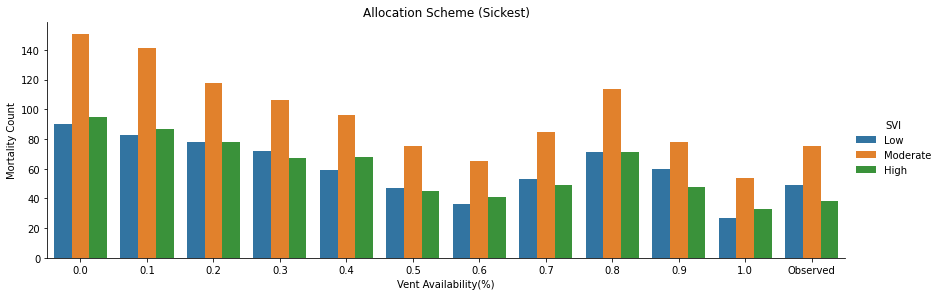

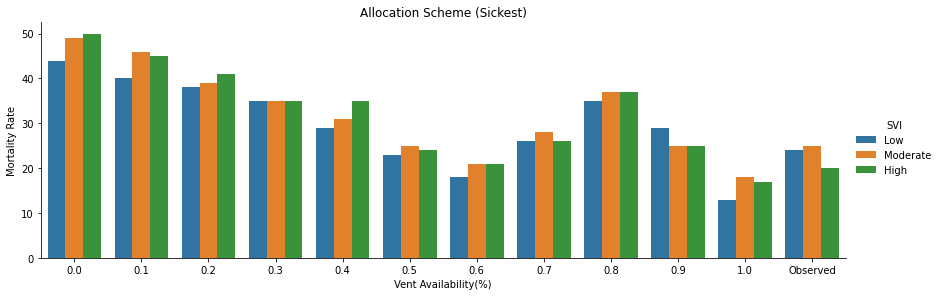

In [62]:
visualize_count_mortality(df_baseline_sickest, 'Sickest')
visualize_percentage_mortality(df_baseline_sickest, 'Sickest')

# Allocate ventilators (Simulation)

## New York

In [ ]:
ls_df_count_death_svi_level = [] # Store dataframes for all scarcity levels
#ls_df_count_death_race_level.append(death_race_baseline)

for pct in vent_availability_pct:
    print('-------------------------{}-------------------------'.format(round(pct,1)))
    ls_df_alloc_iter = []               # Store allocated dataframes within iteration
    ls_df_count_death_svi_iter = []    # Store dataframes of racial death counts within iteration
    ls_dict_count_death_svi_iter = []  # Store dictionary of racial death counts within iteration

    for _ in range(iter_simulation):    # Iterate 1000 times per scarcity level
        # Allocate ventilators to patients
        allocation = Allocation(df_sample, pct, calibration_sofa_mortality)
        df_death = allocation.new_york()
        
        # Convert dictionary to dataframe
        dict_count_death_avi = Counter(df_death['cat_SVI'])

        ls_df_count_death_svi_iter.append(df_death)
    
    df_count_death_svi_level = pd.concat(ls_df_count_death_svi_iter)
    df_count_death_svi_level.rename(columns={'cat_SVI': 'SVI', 'sum': 'count_death'}, inplace=True)
    df_count_death_svi_level = df_count_death_svi_level.groupby('SVI').agg(['mean']).round(0).astype(int)
    df_count_death_svi_level = df_count_death_svi_level.reset_index(level=['SVI'], col_level=1)
    df_count_death_svi_level.columns = df_count_death_svi_level.columns.droplevel(0)
    df_count_death_svi_level.rename(columns={'mean': 'count_death'}, inplace=True)

    df_count_death_svi_level['level'] = round(pct, 1)
    df_count_death_svi_level['type_allocation'] = 'New York'
    df_count_death_svi_level['avg_death'] = statistics.mean(df_count_death_svi_level.loc[: ,'count_death'])
    df_count_death_svi_level['percentage_death'] = df_count_death_svi_level.apply(lambda row: percentage_death(row), axis=1)
    
    ls_df_count_death_svi_level.append(df_count_death_svi_level)

df_new_york = pd.concat(ls_df_count_death_svi_level)
df_baseline_new_york = pd.concat([death_svi_baseline, df_new_york])
df_baseline_new_york[['count_death', 'avg_death', 'percentage_death']] = df_baseline_new_york[['count_death', 'avg_death', 'percentage_death']].round(0).astype(int)

-------------------------0.0-------------------------
-------------------------0.1-------------------------
-------------------------0.2-------------------------
-------------------------0.3-------------------------
-------------------------0.4-------------------------
-------------------------0.5-------------------------
-------------------------0.6-------------------------
-------------------------0.7-------------------------
-------------------------0.8-------------------------
-------------------------0.9-------------------------
-------------------------1.0-------------------------


In [ ]:
df_new_york_tb = df_baseline_new_york.loc[df_baseline_new_york['level']!='Observed', ['SVI', 'count_death', 'level', 'type_allocation']].copy()
display(df_new_york_tb)

SVI  count_death  level type_allocation
0       Low           49    2.0        Baseline
1  Moderate           75    2.0        Baseline
2      High           38    2.0        Baseline
0      High           95    0.0        New York
1       Low           90    0.0        New York
2  Moderate          151    0.0        New York
0      High           94    0.1        New York
1       Low           90    0.1        New York
2  Moderate          148    0.1        New York
0      High           92    0.2        New York
1       Low           89    0.2        New York
2  Moderate          146    0.2        New York
0      High           90    0.3        New York
1       Low           86    0.3        New York
2  Moderate          145    0.3        New York
0      High           87    0.4        New York
1       Low           82    0.4        New York
2  Moderate          141    0.4        New York
0      High           83    0.5        New York
1       Low           71    0.5        New York
2  Moderate          132    0.5        New York
0      High           74    0.6        New York
1       Low           65    0.6        New York
2  Moderate          118    0.6        New York
0      High           62    0.7        New York
1       Low           51    0.7        New York
2  Moderate          105    0.7        New York
0      High           49    0.8        New York
1       Low           41    0.8        New York
2  Moderate           90    0.8        New York
0      High           40    0.9        New York
1       Low           33    0.9        New York
2  Moderate           67    0.9        New York
0      High           33    1.0        New York
1       Low           27    1.0        New York
2  Moderate           54    1.0        New York

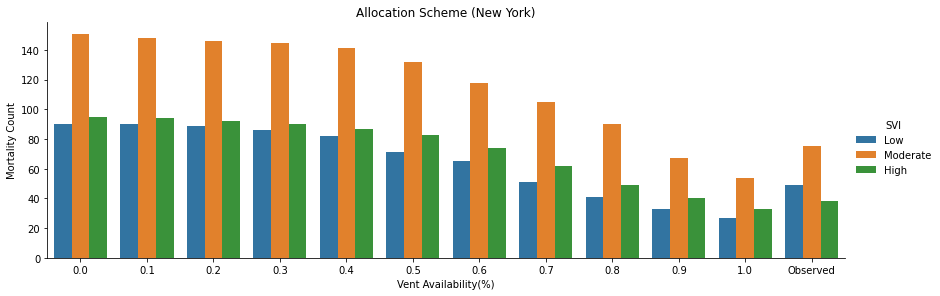

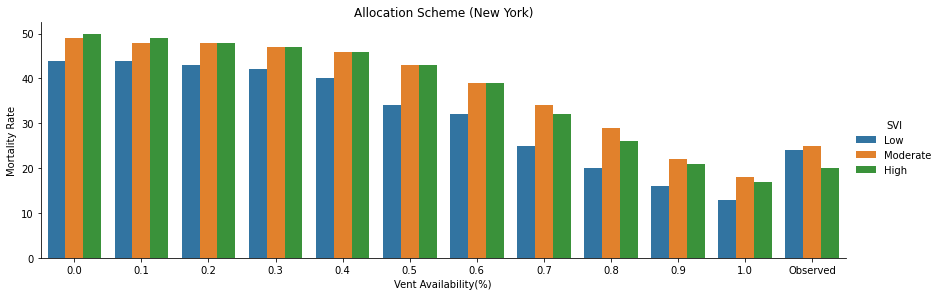

In [ ]:
visualize_count_mortality(df_baseline_new_york, 'New York')
visualize_percentage_mortality(df_baseline_new_york, 'New York')

## Lottery

In [ ]:
ls_df_count_death_svi_level = [] # Store dataframes for all scarcity levels
#ls_df_count_death_race_level.append(death_race_baseline)

for pct in vent_availability_pct:
    print('-------------------------{}-------------------------'.format(round(pct,1)))
    #if pct == 0.0:
    #    continue
    #elif pct == 1.0:
    #    break
    ls_df_alloc_iter = []              # Store allocated dataframes within iteration
    ls_df_count_death_svi_iter = []    # Store dataframes of SVI death counts within iteration
    ls_dict_count_death_svi_iter = []  # Store dictionary of SVI death counts within iteration

    for i in range(iter_simulation):    # Iterate 1000 times per scarcity level
        #if i == 1:
        #    break
        allocation = Allocation(df_sample, pct, calibration_sofa_mortality)
        df_death = allocation.lottery()
        
        # Convert dictionary to dataframe
        dict_count_death_svi = Counter(df_death['cat_SVI'])
        
        ls_df_count_death_svi_iter.append(df_death)

    df_count_death_svi_level = pd.concat(ls_df_count_death_svi_iter)
    #display(df_count_death_svi_level)
    df_count_death_svi_level.rename(columns={'cat_SVI': 'SVI', 'sum': 'count_death'}, inplace=True)
    df_count_death_svi_level = df_count_death_svi_level.groupby('SVI').agg(['mean']).round(0).astype(int)
    #display(df_count_death_svi_level)
    df_count_death_svi_level = df_count_death_svi_level.reset_index(level=['SVI'], col_level=1)
    df_count_death_svi_level.columns = df_count_death_svi_level.columns.droplevel(0)
    df_count_death_svi_level.rename(columns={'mean': 'count_death'}, inplace=True)
    #display(df_count_death_svi_level)
    df_count_death_svi_level['level'] = round(pct, 1)
    df_count_death_svi_level['type_allocation'] = 'Lottery'
    df_count_death_svi_level['avg_death'] = statistics.mean(df_count_death_svi_level.loc[: ,'count_death'])
    df_count_death_svi_level['percentage_death'] = df_count_death_svi_level.apply(lambda row: percentage_death(row), axis=1)
    #display(df_count_death_svi_level)
    ls_df_count_death_svi_level.append(df_count_death_svi_level)

df_lottery = pd.concat(ls_df_count_death_svi_level)
df_baseline_lottery = pd.concat([death_svi_baseline, df_lottery])
df_baseline_lottery[['count_death', 'avg_death', 'percentage_death']] = df_baseline_lottery[['count_death', 'avg_death', 'percentage_death']].round(0).astype(int)

-------------------------0.0-------------------------
-------------------------0.1-------------------------
-------------------------0.2-------------------------
-------------------------0.3-------------------------
-------------------------0.4-------------------------


In [ ]:
df_lottery_tb = df_baseline_lottery.loc[df_baseline_lottery['level']!='Observed', ['SVI', 'count_death', 'level', 'type_allocation']].copy()
display(df_lottery_tb)

SVI  count_death  level type_allocation
0       Low           49    2.0        Baseline
1  Moderate           75    2.0        Baseline
2      High           38    2.0        Baseline
0      High           95    0.0         Lottery
1       Low           90    0.0         Lottery
2  Moderate          151    0.0         Lottery
0      High           85    0.1         Lottery
1       Low           89    0.1         Lottery
2  Moderate          142    0.1         Lottery
0      High           65    0.2         Lottery
1       Low           82    0.2         Lottery
2  Moderate          140    0.2         Lottery
0      High           46    0.3         Lottery
1       Low           77    0.3         Lottery
2  Moderate          138    0.3         Lottery
0      High           46    0.4         Lottery
1       Low           77    0.4         Lottery
2  Moderate          116    0.4         Lottery
0      High           46    0.5         Lottery
1       Low           76    0.5         Lottery
2  Moderate           95    0.5         Lottery
0      High           42    0.6         Lottery
1       Low           69    0.6         Lottery
2  Moderate           84    0.6         Lottery
0      High           36    0.7         Lottery
1       Low           63    0.7         Lottery
2  Moderate           75    0.7         Lottery
0      High           35    0.8         Lottery
1       Low           53    0.8         Lottery
2  Moderate           70    0.8         Lottery
0      High           35    0.9         Lottery
1       Low           41    0.9         Lottery
2  Moderate           59    0.9         Lottery
0      High           33    1.0         Lottery
1       Low           27    1.0         Lottery
2  Moderate           54    1.0         Lottery

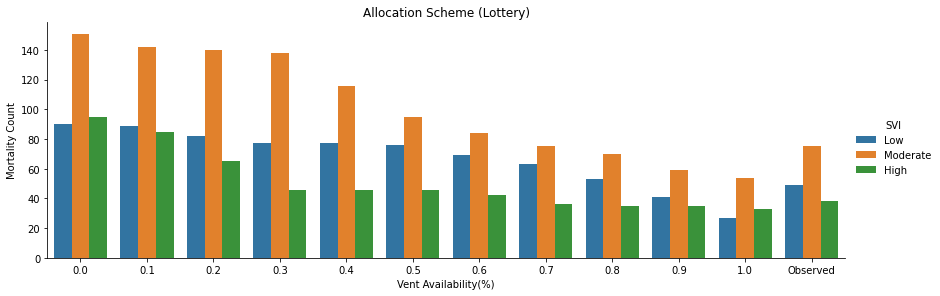

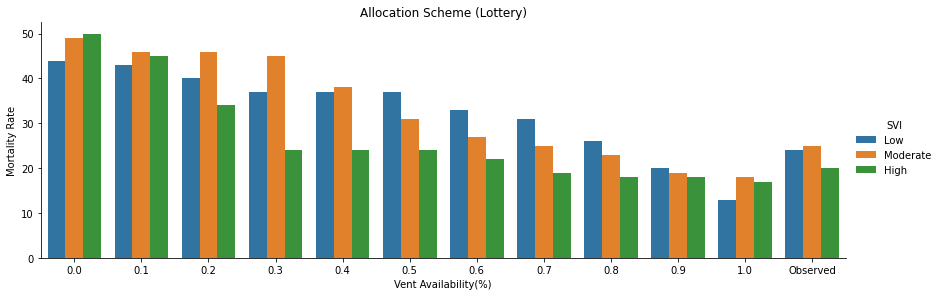

In [ ]:
visualize_count_mortality(df_baseline_lottery, 'Lottery')
visualize_percentage_mortality(df_baseline_lottery, 'Lottery')

# Total

In [ ]:
df_csc_all = pd.concat([
    df_new_york[['type_allocation', 'level', 'avg_death']],
    df_maryland[['type_allocation', 'level', 'avg_death']],
    df_max_lives_years[['type_allocation', 'level', 'avg_death']],
    df_youngest[['type_allocation', 'level', 'avg_death']],
    df_sickest[['type_allocation', 'level', 'avg_death']],
    df_lottery[['type_allocation', 'level', 'avg_death']]
])

In [ ]:
df_new_york.head(10)

SVI  count_death  level type_allocation   avg_death  percentage_death
0      High          191    0.0        New York  234.333333        100.000000
1       Low          206    0.0        New York  234.333333        100.000000
2  Moderate          306    0.0        New York  234.333333        100.000000
0      High          172    0.1        New York  211.000000         90.052356
1       Low          186    0.1        New York  211.000000         90.291262
2  Moderate          275    0.1        New York  211.000000         89.869281
0      High          153    0.2        New York  188.000000         80.104712
1       Low          162    0.2        New York  188.000000         78.640777
2  Moderate          249    0.2        New York  188.000000         81.372549
0      High          137    0.3        New York  164.333333         71.727749

In [ ]:
df_maryland.head(10)

SVI  count_death  level   avg_death  percentage_death type_allocation
0      High       191.00    0.0  234.333333        100.000000        Maryland
1       Low       206.00    0.0  234.333333        100.000000        Maryland
2  Moderate       306.00    0.0  234.333333        100.000000        Maryland
0      High       165.00    0.1  211.143333         86.387435        Maryland
2       Low       186.22    0.1  211.143333         90.398058        Maryland
4  Moderate       282.21    0.1  211.143333         92.225490        Maryland
0      High       151.80    0.2  187.690000         79.476440        Maryland
2       Low       163.22    0.2  187.690000         79.233010        Maryland
4  Moderate       248.05    0.2  187.690000         81.062092        Maryland
0      High       138.04    0.3  164.413333         72.272251        Maryland

In [ ]:
df_csc_all

type_allocation  level   avg_death
0         New York    0.0  234.333333
1         New York    0.0  234.333333
2         New York    0.0  234.333333
0         New York    0.1  211.000000
1         New York    0.1  211.000000
..             ...    ...         ...
1          Lottery    0.9   58.333333
2          Lottery    0.9   58.333333
0          Lottery    1.0   38.000000
1          Lottery    1.0   38.000000
2          Lottery    1.0   38.000000

[198 rows x 3 columns]

In [ ]:
def visualize_percentage_mortality(df, policy):
    df['level'] = df['level'].replace(to_replace=[2.0], value=['Observed'])
    x_val = list(df['level'].unique())
    x_val.append(x_val.pop(0))
    sns_plot = sns.catplot(x='level', y='percentage_death', hue='SVI', data=df, kind='bar', order=x_val, height=4, aspect=3)
    plt.title('Allocation Scheme ({})'.format(policy))
    plt.xlabel('Vent Availability(%)')
    plt.ylabel('Mortality Rate')
    sns_plot._legend.set_title('SVI')
    sns_plot.savefig("figures_new/percentage_death_{}_SVI.png".format(policy))

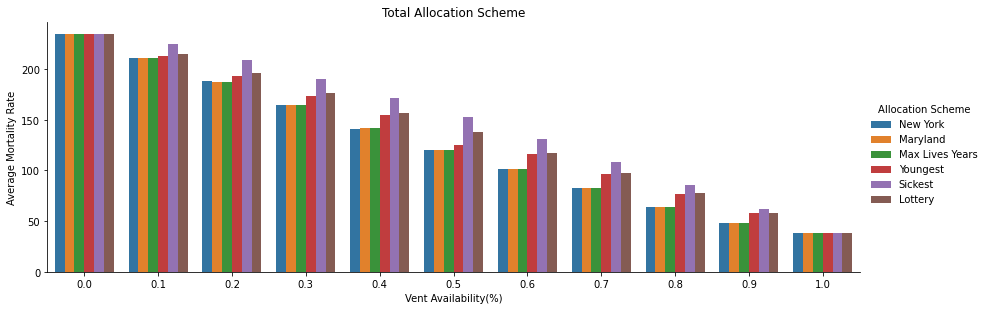

In [ ]:
#%matplotlib qt
sns_plot = sns.catplot(x='level', y='avg_death', hue='type_allocation', data=df_csc_all[df_csc_all['level']!=2.0], kind='bar', legend_out=True, height=4, aspect=3)
plt.title('Total Allocation Scheme')
sns_plot._legend.set_title('Allocation Scheme')
plt.xlabel('Vent Availability(%)')
plt.ylabel('Average Mortality Rate')
sns_plot.savefig("figures_new/percentage_death_total_avg_SVI.png")

# Statistics

In [ ]:
count_svi

Counter({'Low': 206, 'Moderate': 306, 'High': 191})

## Table: SVI group mortality

In [ ]:
df_tb_comb = pd.concat([df_maryland_tb, df_new_york_tb, df_max_lives_years_tb, df_youngest_tb, df_sickest_tb, df_lottery_tb])
df_tb_comb.reset_index(drop=True, inplace=True)
df_tb_comb.rename(columns={'type_allocation': 'allocation', 'level': 'vent availability(%)'}, inplace=True)

for i, value in df_tb_comb.iterrows():
    if df_tb_comb.loc[i, 'SVI']=='Low':
        df_tb_comb.loc[i, 'count_patients'] = count_svi['Low']
    elif df_tb_comb.loc[i, 'SVI']=='Moderate':
        df_tb_comb.loc[i, 'count_patients'] = count_svi['Moderate']
    elif df_tb_comb.loc[i, 'SVI']=='High':
        df_tb_comb.loc[i, 'count_patients'] = count_svi['High']
        
    df_tb_comb.loc[i, 'mortality'] = round(df_tb_comb.loc[i, 'count_death']/df_tb_comb.loc[i, 'count_patients']*100, 1)

df_tb_comb

NameError: ignored

In [ ]:
cols_order_allocation = ['Maryland', 'New York', 'Max Lives Years', 'Youngest', 'Sickest', 'Lottery']
cols_order_svi = ['Low', 'Moderate', 'High']
df_tb_comb['allocation'] = df_tb_comb['allocation'].astype(pd.api.types.CategoricalDtype(categories=cols_order_allocation))
df_tb_comb['SVI'] = df_tb_comb['SVI'].astype(pd.api.types.CategoricalDtype(categories=cols_order_svi))
df_tb_pivot = df_tb_comb.pivot_table(values='mortality', columns='vent availability(%)', index=['allocation', 'SVI'])

dfi.export(df_tb_pivot, 'figures_new/tb_mortality_svi.png')
df_tb_pivot

NameError: ignored

## Table: Max-Min Difference

In [ ]:
cols_max_min = ['allocation', 0.0, 0.1, 0.2,0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
df_tmp = df_tb_pivot.reset_index(level=['allocation', 'SVI'], col_level=1)
#df_tmp = df_tmp.loc[df_tmp['race']!='Asian', cols_max_min]
df_tmp

vent availability(%)       allocation       SVI    0.0   0.1   0.2   0.3  \
0                            Maryland       Low  100.0  90.3  79.1  65.5   
1                            Maryland  Moderate  100.0  92.2  81.0  71.9   
2                            Maryland      High  100.0  86.4  79.6  72.3   
3                            New York       Low  100.0  90.3  78.6  66.0   
4                            New York  Moderate  100.0  89.9  81.4  71.9   
5                            New York      High  100.0  90.1  80.1  71.7   
6                     Max Lives Years       Low  100.0  88.3  79.1  66.5   
7                     Max Lives Years  Moderate  100.0  91.8  81.0  71.9   
8                     Max Lives Years      High  100.0  89.0  79.6  71.2   
9                            Youngest       Low  100.0  90.3  85.4  75.7   
10                           Youngest  Moderate  100.0  92.5  83.3  76.5   
11                           Youngest      High  100.0  89.0  77.0  67.5   
12                            Sickest       Low  100.0  95.6  91.7  85.0   
13                            Sickest  Moderate  100.0  96.4  87.9  79.4   
14                            Sickest      High  100.0  95.8  88.0  80.1   

vent availability(%)   0.4   0.5   0.6   0.7   0.8   0.9   1.0  
0                     56.8  44.7  39.3  30.1  22.3  17.0  13.1  
1                     60.5  52.6  44.8  37.6  30.7  21.9  17.6  
2                     64.9  56.0  45.0  37.2  27.7  21.5  17.3  
3                     56.3  44.7  38.3  29.6  21.8  17.0  13.1  
4                     60.1  52.3  45.1  37.9  30.7  22.2  18.0  
5                     64.9  56.5  45.5  37.2  28.3  20.9  17.3  
6                     56.8  44.2  39.3  30.1  22.3  17.0  13.1  
7                     60.5  52.3  45.1  37.6  30.7  22.5  17.6  
8                     64.9  57.1  44.5  37.2  27.2  20.9  17.3  
9                     69.4  60.2  53.9  48.1  35.4  25.2  13.1  
10                    66.3  53.3  51.0  40.5  33.7  25.8  17.6  
11                    60.7  45.5  42.4  34.6  29.3  23.6  17.3  
12                    74.8  68.9  56.8  47.6  34.5  29.1  13.1  
13                    72.5  65.7  57.8  46.1  37.3  25.5  17.6  
14                    72.3  60.2  52.4  45.0  37.2  25.1  17.3

In [ ]:
df_tmp.groupby('allocation').agg(['max', 'min'])

0.0          0.1         0.2         0.3         0.4        \
                   max    min   max   min   max   min   max   min   max   min   
allocation                                                                      
Maryland         100.0  100.0  92.2  86.4  81.0  79.1  72.3  65.5  64.9  56.8   
New York         100.0  100.0  90.3  89.9  81.4  78.6  71.9  66.0  64.9  56.3   
Max Lives Years  100.0  100.0  91.8  88.3  81.0  79.1  71.9  66.5  64.9  56.8   
Youngest         100.0  100.0  92.5  89.0  85.4  77.0  76.5  67.5  69.4  60.7   
Sickest          100.0  100.0  96.4  95.6  91.7  87.9  85.0  79.4  74.8  72.3   

                  0.5         0.6         0.7         0.8         0.9        \
                  max   min   max   min   max   min   max   min   max   min   
allocation                                                                    
Maryland         56.0  44.7  45.0  39.3  37.6  30.1  30.7  22.3  21.9  17.0   
New York         56.5  44.7  45.5  38.3  37.9  29.6  30.7  21.8  22.2  17.0   
Max Lives Years  57.1  44.2  45.1  39.3  37.6  30.1  30.7  22.3  22.5  17.0   
Youngest         60.2  45.5  53.9  42.4  48.1  34.6  35.4  29.3  25.8  23.6   
Sickest          68.9  60.2  57.8  52.4  47.6  45.0  37.3  34.5  29.1  25.1   

                  1.0        
                  max   min  
allocation                   
Maryland         17.6  13.1  
New York         18.0  13.1  
Max Lives Years  17.6  13.1  
Youngest         17.6  13.1  
Sickest          17.6  13.1

In [ ]:
cols_order_allocation = ['Maryland', 'New York', 'Max Lives Years', 'Youngest', 'Sickest', 'Lottery']
df_diff_max_min = df_tmp.groupby('allocation').agg(np.ptp)
#df_diff_max_min.rename(index={'allocation':'allocation'}, inplace=True)
df_diff_max_min = df_diff_max_min.reindex(cols_order_allocation)
df_diff_max_min

vent availability(%)  0.0   0.1   0.2   0.3   0.4   0.5   0.6   0.7   0.8  \
allocation                                                                  
Maryland              0.0   5.8   1.9   6.8   8.1  11.3   5.7   7.5   8.4   
New York              0.0   0.4   2.8   5.9   8.6  11.8   7.2   8.3   8.9   
Max Lives Years       0.0   3.5   1.9   5.4   8.1  12.9   5.8   7.5   8.4   
Youngest              0.0   3.5   8.4   9.0   8.7  14.7  11.5  13.5   6.1   
Sickest               0.0   0.8   3.8   5.6   2.5   8.7   5.4   2.6   2.8   
Lottery               0.0  17.9  31.8  50.9  42.7  42.2  36.3  35.6  23.2   

vent availability(%)   0.9  1.0  
allocation                       
Maryland               4.9  4.5  
New York               5.2  4.9  
Max Lives Years        5.5  4.5  
Youngest               2.2  4.5  
Sickest                4.0  4.5  
Lottery               10.2  4.5

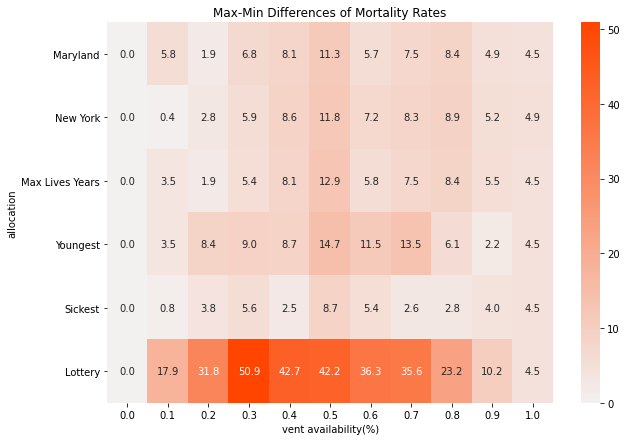

In [ ]:
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(df_diff_max_min, annot=True, fmt='.1f', cmap=sns.light_palette("#FF4500", as_cmap=True))
plt.title('Max-Min Differences of Mortality Rates')
plt.savefig("figures_new/heat_mortality_diff_max_min_svi.png")

In [ ]:
display(df_diff_max_min.mean(axis=1).round(1).to_frame(name='AVG'))
dfi.export(df_diff_max_min.mean(axis=1).round(1).to_frame(name='AVG'), 'figures_new/tb_avg_mortality_diff_max_min_allo_svi.png')

display(df_diff_max_min.mean(axis=0).round(1).to_frame(name='AVG'))
dfi.export(df_diff_max_min.mean(axis=0).round(1).to_frame(name='AVG'), 'figures_new/tb_avg_mortality_diff_max_min_avai_svi.png')

AVG
allocation           
Maryland          5.9
New York          5.8
Max Lives Years   5.8
Youngest          7.5
Sickest           3.7
Lottery          26.8

AVG
vent availability(%)      
0.0                    0.0
0.1                    5.3
0.2                    8.4
0.3                   13.9
0.4                   13.1
0.5                   16.9
0.6                   12.0
0.7                   12.5
0.8                    9.6
0.9                    5.3
1.0                    4.6

In [ ]:
ls_avai_1_9 = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

In [ ]:
display(df_diff_max_min[ls_avai_1_9].mean(axis=1).round(1).to_frame(name='AVG'))
dfi.export(df_diff_max_min[ls_avai_1_9].mean(axis=1).round(1).to_frame(name='AVG'), 'figures_new/tb_avg_mortality_diff_max_min_allo_0.1_0.9_svi.png')

display(df_diff_max_min[ls_avai_1_9].mean(axis=0).round(1).to_frame(name='AVG'))
dfi.export(df_diff_max_min[ls_avai_1_9].mean(axis=0).round(1).to_frame(name='AVG'), 'figures_new/tb_avg_mortality_diff_max_min_avai_0.1_0.9_svi.png')

AVG
allocation           
Maryland          6.7
New York          6.6
Max Lives Years   6.6
Youngest          8.6
Sickest           4.0
Lottery          32.3

AVG
vent availability(%)      
0.1                    5.3
0.2                    8.4
0.3                   13.9
0.4                   13.1
0.5                   16.9
0.6                   12.0
0.7                   12.5
0.8                    9.6
0.9                    5.3

## Table: High&Moderate-Low Difference (Reference Point: Best Group)

In [ ]:
cols_rest_low = ['allocation', 'SVI', 0.0, 0.1, 0.2,0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
df_tmp = df_tb_pivot.reset_index(level=['allocation', 'SVI'], col_level=1)
#df_tmp = df_tmp.loc[df_tmp['SVI']!='Asian', cols_rest_low]
df_tmp

vent availability(%)       allocation       SVI    0.0   0.1   0.2   0.3  \
0                            Maryland       Low  100.0  90.3  79.1  65.5   
1                            Maryland  Moderate  100.0  92.2  81.0  71.9   
2                            Maryland      High  100.0  86.4  79.6  72.3   
3                            New York       Low  100.0  90.3  78.6  66.0   
4                            New York  Moderate  100.0  89.9  81.4  71.9   
5                            New York      High  100.0  90.1  80.1  71.7   
6                     Max Lives Years       Low  100.0  88.3  79.1  66.5   
7                     Max Lives Years  Moderate  100.0  91.8  81.0  71.9   
8                     Max Lives Years      High  100.0  89.0  79.6  71.2   
9                            Youngest       Low  100.0  90.3  85.4  75.7   
10                           Youngest  Moderate  100.0  92.5  83.3  76.5   
11                           Youngest      High  100.0  89.0  77.0  67.5   
12                            Sickest       Low  100.0  95.6  91.7  85.0   
13                            Sickest  Moderate  100.0  96.4  87.9  79.4   
14                            Sickest      High  100.0  95.8  88.0  80.1   

vent availability(%)   0.4   0.5   0.6   0.7   0.8   0.9   1.0  
0                     56.8  44.7  39.3  30.1  22.3  17.0  13.1  
1                     60.5  52.6  44.8  37.6  30.7  21.9  17.6  
2                     64.9  56.0  45.0  37.2  27.7  21.5  17.3  
3                     56.3  44.7  38.3  29.6  21.8  17.0  13.1  
4                     60.1  52.3  45.1  37.9  30.7  22.2  18.0  
5                     64.9  56.5  45.5  37.2  28.3  20.9  17.3  
6                     56.8  44.2  39.3  30.1  22.3  17.0  13.1  
7                     60.5  52.3  45.1  37.6  30.7  22.5  17.6  
8                     64.9  57.1  44.5  37.2  27.2  20.9  17.3  
9                     69.4  60.2  53.9  48.1  35.4  25.2  13.1  
10                    66.3  53.3  51.0  40.5  33.7  25.8  17.6  
11                    60.7  45.5  42.4  34.6  29.3  23.6  17.3  
12                    74.8  68.9  56.8  47.6  34.5  29.1  13.1  
13                    72.5  65.7  57.8  46.1  37.3  25.5  17.6  
14                    72.3  60.2  52.4  45.0  37.2  25.1  17.3

In [ ]:
df_h = df_tmp.loc[df_tmp['SVI']=='High', ['allocation', 0.0, 0.1, 0.2,0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]].set_index('allocation')
df_h

vent availability(%)    0.0   0.1   0.2   0.3   0.4   0.5   0.6   0.7   0.8  \
allocation                                                                    
Maryland              100.0  86.4  79.6  72.3  64.9  56.0  45.0  37.2  27.7   
New York              100.0  90.1  80.1  71.7  64.9  56.5  45.5  37.2  28.3   
Max Lives Years       100.0  89.0  79.6  71.2  64.9  57.1  44.5  37.2  27.2   
Youngest              100.0  89.0  77.0  67.5  60.7  45.5  42.4  34.6  29.3   
Sickest               100.0  95.8  88.0  80.1  72.3  60.2  52.4  45.0  37.2   

vent availability(%)   0.9   1.0  
allocation                        
Maryland              21.5  17.3  
New York              20.9  17.3  
Max Lives Years       20.9  17.3  
Youngest              23.6  17.3  
Sickest               25.1  17.3

In [ ]:
df_m = df_tmp.loc[df_tmp['SVI']=='Moderate', ['allocation', 0.0, 0.1, 0.2,0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]].set_index('allocation')
df_m

vent availability(%)    0.0   0.1   0.2   0.3   0.4   0.5   0.6   0.7   0.8  \
allocation                                                                    
Maryland              100.0  92.2  81.0  71.9  60.5  52.6  44.8  37.6  30.7   
New York              100.0  89.9  81.4  71.9  60.1  52.3  45.1  37.9  30.7   
Max Lives Years       100.0  91.8  81.0  71.9  60.5  52.3  45.1  37.6  30.7   
Youngest              100.0  92.5  83.3  76.5  66.3  53.3  51.0  40.5  33.7   
Sickest               100.0  96.4  87.9  79.4  72.5  65.7  57.8  46.1  37.3   

vent availability(%)   0.9   1.0  
allocation                        
Maryland              21.9  17.6  
New York              22.2  18.0  
Max Lives Years       22.5  17.6  
Youngest              25.8  17.6  
Sickest               25.5  17.6

In [ ]:
df_l = df_tmp.loc[df_tmp['SVI']=='Low', ['allocation', 0.0, 0.1, 0.2,0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]].set_index('allocation')
df_l

vent availability(%)    0.0   0.1   0.2   0.3   0.4   0.5   0.6   0.7   0.8  \
allocation                                                                    
Maryland              100.0  90.3  79.1  65.5  56.8  44.7  39.3  30.1  22.3   
New York              100.0  90.3  78.6  66.0  56.3  44.7  38.3  29.6  21.8   
Max Lives Years       100.0  88.3  79.1  66.5  56.8  44.2  39.3  30.1  22.3   
Youngest              100.0  90.3  85.4  75.7  69.4  60.2  53.9  48.1  35.4   
Sickest               100.0  95.6  91.7  85.0  74.8  68.9  56.8  47.6  34.5   

vent availability(%)   0.9   1.0  
allocation                        
Maryland              17.0  13.1  
New York              17.0  13.1  
Max Lives Years       17.0  13.1  
Youngest              25.2  13.1  
Sickest               29.1  13.1

### Moderate-Low (Absolute Difference)

In [ ]:
df_diff_m_l_ab = df_m.subtract(df_l)
df_diff_m_l_ab

vent availability(%)  0.0  0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.0
allocation                                                                 
Maryland              0.0  1.9  1.9  6.4  3.7  7.9  5.5  7.5  8.4  4.9  4.5
New York              0.0 -0.4  2.8  5.9  3.8  7.6  6.8  8.3  8.9  5.2  4.9
Max Lives Years       0.0  3.5  1.9  5.4  3.7  8.1  5.8  7.5  8.4  5.5  4.5
Youngest              0.0  2.2 -2.1  0.8 -3.1 -6.9 -2.9 -7.6 -1.7  0.6  4.5
Sickest               0.0  0.8 -3.8 -5.6 -2.3 -3.2  1.0 -1.5  2.8 -3.6  4.5

Text(0.5, 1.0, 'Moderate-Low Absolute Differences of Mortality Rates')

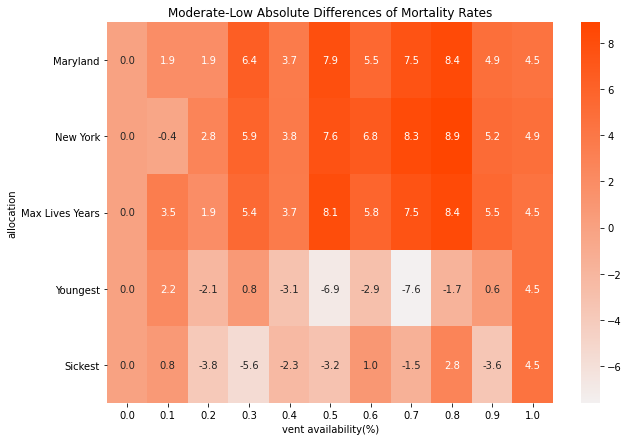

In [ ]:
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(df_diff_m_l_ab, annot=True, fmt='.1f', cmap=sns.light_palette("#FF4500", as_cmap=True))
plt.title('Moderate-Low Absolute Differences of Mortality Rates')
#plt.savefig("figures_new/heat_mortality_diff_m_l_ab_svi.png")

In [ ]:
display(df_diff_m_l_ab.mean(axis=1).round(1).to_frame(name='AVG'))
dfi.export(df_diff_m_l_ab.mean(axis=1).round(1).to_frame(name='AVG'), 'figures_new/tb_avg_mortality_diff_m_l_ab_allo_svi.png')

display(df_diff_m_l_ab.mean(axis=0).round(1).to_frame(name='AVG'))
dfi.export(df_diff_m_l_ab.mean(axis=0).round(1).to_frame(name='AVG'), 'figures_new/tb_avg_mortality_diff_m_l_ab_avai_svi.png')

AVG
allocation          
Maryland         4.8
New York         4.9
Max Lives Years  4.9
Youngest        -1.5
Sickest         -1.0
Lottery         -8.6

AVG
vent availability(%)     
0.0                   0.0
0.1                   0.6
0.2                   0.3
0.3                   3.4
0.4                  -0.7
0.5                  -2.4
0.6                  -1.4
0.7                  -1.1
0.8                   2.4
0.9                   1.0
1.0                   4.6

In [ ]:
display(df_diff_m_l_ab[ls_avai_1_9].mean(axis=1).round(1).to_frame(name='AVG'))
dfi.export(df_diff_m_l_ab[ls_avai_1_9].mean(axis=1).round(1).to_frame(name='AVG'), 'figures_new/tb_avg_mortality_diff_m_l_ab_allo_0.1_0.9_svi.png')

display(df_diff_m_l_ab[ls_avai_1_9].mean(axis=0).round(1).to_frame(name='AVG'))
dfi.export(df_diff_m_l_ab[ls_avai_1_9].mean(axis=0).round(1).to_frame(name='AVG'), 'figures_new/tb_avg_mortality_diff_m_l_ab_avai_0.1_0.9_svi.png')

AVG
allocation           
Maryland          5.3
New York          5.4
Max Lives Years   5.5
Youngest         -2.3
Sickest          -1.7
Lottery         -11.0

AVG
vent availability(%)     
0.1                   0.6
0.2                   0.3
0.3                   3.4
0.4                  -0.7
0.5                  -2.4
0.6                  -1.4
0.7                  -1.1
0.8                   2.4
0.9                   1.0

### Hispanic-White (Relative Difference)

In [ ]:
df_diff_m_l_re = df_m.subtract(df_l)
df_diff_m_l_re = df_diff_m_l_re.divide(df_l)*100
df_diff_m_l_re = df_diff_m_l_re.round(1)
df_diff_m_l_re

vent availability(%)  0.0  0.1  0.2  0.3  0.4   0.5   0.6   0.7   0.8   0.9  \
allocation                                                                    
Maryland              0.0  2.1  2.4  9.8  6.5  17.7  14.0  24.9  37.7  28.8   
New York              0.0 -0.4  3.6  8.9  6.7  17.0  17.8  28.0  40.8  30.6   
Max Lives Years       0.0  4.0  2.4  8.1  6.5  18.3  14.8  24.9  37.7  32.4   
Youngest              0.0  2.4 -2.5  1.1 -4.5 -11.5  -5.4 -15.8  -4.8   2.4   
Sickest               0.0  0.8 -4.1 -6.6 -3.1  -4.6   1.8  -3.2   8.1 -12.4   

vent availability(%)   1.0  
allocation                  
Maryland              34.4  
New York              37.4  
Max Lives Years       34.4  
Youngest              34.4  
Sickest               34.4

Text(0.5, 1.0, 'Moderate-Low Relative Differences of Mortality Rates')

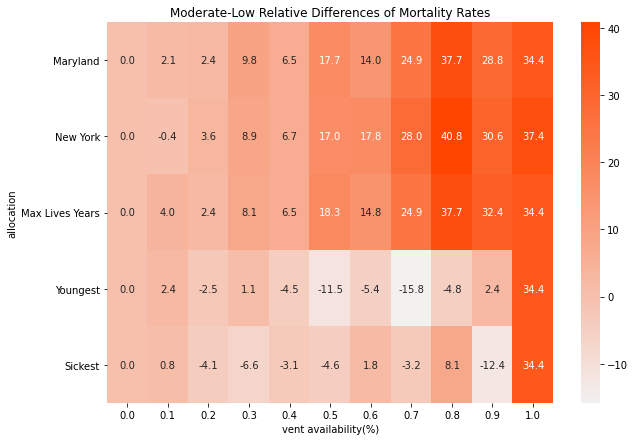

In [ ]:
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(df_diff_m_l_re, annot=True, fmt='.1f', cmap=sns.light_palette("#FF4500", as_cmap=True))
plt.title('Moderate-Low Relative Differences of Mortality Rates')
#plt.savefig("figures_new/heat_mortality_diff_m_l_re_svi.png")

In [ ]:
display(df_diff_m_l_re.mean(axis=1).round(1).to_frame(name='AVG'))
dfi.export(df_diff_m_l_re.mean(axis=1).round(1).to_frame(name='AVG'), 'figures_new/tb_avg_mortality_diff_m_l_re_allo_svi.png')

display(df_diff_m_l_re.mean(axis=0).round(1).to_frame(name='AVG'))
dfi.export(df_diff_m_l_re.mean(axis=0).round(1).to_frame(name='AVG'), 'figures_new/tb_avg_mortality_diff_m_l_re_avai_svi.png')

AVG
allocation           
Maryland         16.2
New York         17.3
Max Lives Years  16.7
Youngest         -0.4
Sickest           1.0
Lottery         -11.4

AVG
vent availability(%)      
0.0                    0.0
0.1                    0.7
0.2                    0.5
0.3                    5.0
0.4                   -0.0
0.5                    0.5
0.6                    1.3
0.7                    4.1
0.8                   15.3
0.9                   10.0
1.0                   34.9

In [ ]:
display(df_diff_m_l_re[ls_avai_1_9].mean(axis=1).round(1).to_frame(name='AVG'))
dfi.export(df_diff_m_l_re[ls_avai_1_9].mean(axis=1).round(1).to_frame(name='AVG'), 'figures_new/tb_avg_mortality_diff_m_l_re_allo_0.1_0.9_svi.png')

display(df_diff_m_l_re[ls_avai_1_9].mean(axis=0).round(1).to_frame(name='AVG'))
dfi.export(df_diff_m_l_re[ls_avai_1_9].mean(axis=0).round(1).to_frame(name='AVG'), 'figures_new/tb_avg_mortality_diff_m_l_re_avai_0.1_0.9_svi.png')

AVG
allocation           
Maryland         16.0
New York         17.0
Max Lives Years  16.6
Youngest         -4.3
Sickest          -2.6
Lottery         -17.8

AVG
vent availability(%)      
0.1                    0.7
0.2                    0.5
0.3                    5.0
0.4                   -0.0
0.5                    0.5
0.6                    1.3
0.7                    4.1
0.8                   15.3
0.9                   10.0

### High-Low (Absolute Difference)

In [ ]:
df_diff_h_l_ab = df_h.subtract(df_l)
df_diff_h_l_ab

vent availability(%)  0.0  0.1  0.2  0.3  0.4   0.5   0.6   0.7  0.8  0.9  1.0
allocation                                                                    
Maryland              0.0 -3.9  0.5  6.8  8.1  11.3   5.7   7.1  5.4  4.5  4.2
New York              0.0 -0.2  1.5  5.7  8.6  11.8   7.2   7.6  6.5  3.9  4.2
Max Lives Years       0.0  0.7  0.5  4.7  8.1  12.9   5.2   7.1  4.9  3.9  4.2
Youngest              0.0 -1.3 -8.4 -8.2 -8.7 -14.7 -11.5 -13.5 -6.1 -1.6  4.2
Sickest               0.0  0.2 -3.7 -4.9 -2.5  -8.7  -4.4  -2.6  2.7 -4.0  4.2

Text(0.5, 1.0, 'High-Low Absolute Differences of Mortality Rates')

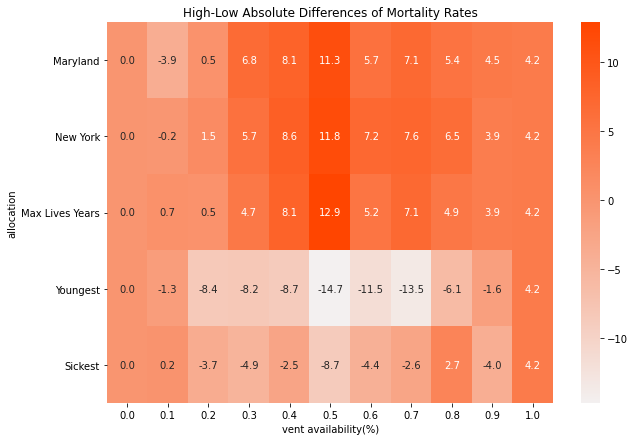

In [ ]:
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(df_diff_h_l_ab, annot=True, fmt='.1f', cmap=sns.light_palette("#FF4500", as_cmap=True))
plt.title('High-Low Absolute Differences of Mortality Rates')
#plt.savefig("figures_new/heat_mortality_diff_h_l_ab_svi.png")

In [ ]:
display(df_diff_h_l_ab.mean(axis=1).round(1).to_frame(name='AVG'))
dfi.export(df_diff_h_l_ab.mean(axis=1).round(1).to_frame(name='AVG'), 'figures_new/tb_avg_mortality_diff_h_l_ab_allo_svi.png')

display(df_diff_h_l_ab.mean(axis=0).round(1).to_frame(name='AVG'))
dfi.export(df_diff_h_l_ab.mean(axis=0).round(1).to_frame(name='AVG'), 'figures_new/tb_avg_mortality_diff_h_l_ab_avai_svi.png')

AVG
allocation           
Maryland          4.5
New York          5.2
Max Lives Years   4.7
Youngest         -6.3
Sickest          -2.2
Lottery         -25.3

AVG
vent availability(%)     
0.0                   0.0
0.1                  -3.7
0.2                  -6.8
0.3                  -6.6
0.4                  -4.8
0.5                  -4.9
0.6                  -5.7
0.7                  -5.0
0.8                  -1.6
0.9                  -0.6
1.0                   4.2

In [ ]:
display(df_diff_h_l_ab[ls_avai_1_9].mean(axis=1).round(1).to_frame(name='AVG'))
dfi.export(df_diff_h_l_ab[ls_avai_1_9].mean(axis=1).round(1).to_frame(name='AVG'), 'figures_new/tb_avg_mortality_diff_h_l_ab_allo_0.1_0.9_svi.png')

display(df_diff_h_l_ab[ls_avai_1_9].mean(axis=0).round(1).to_frame(name='AVG'))
dfi.export(df_diff_h_l_ab[ls_avai_1_9].mean(axis=0).round(1).to_frame(name='AVG'), 'figures_new/tb_avg_mortality_diff_h_l_ab_avai_0.1_0.9_svi.png')

AVG
allocation           
Maryland          5.1
New York          5.8
Max Lives Years   5.3
Youngest         -8.2
Sickest          -3.1
Lottery         -31.4

AVG
vent availability(%)     
0.1                  -3.7
0.2                  -6.8
0.3                  -6.6
0.4                  -4.8
0.5                  -4.9
0.6                  -5.7
0.7                  -5.0
0.8                  -1.6
0.9                  -0.6

### High-Low (Relative Difference)

In [ ]:
df_diff_h_l_re = df_h.subtract(df_l)
df_diff_h_l_re = df_diff_h_l_re.divide(df_l)*100
df_diff_h_l_re = df_diff_h_l_re.round(1)
df_diff_h_l_re

vent availability(%)  0.0  0.1  0.2   0.3   0.4   0.5   0.6   0.7   0.8   0.9  \
allocation                                                                      
Maryland              0.0 -4.3  0.6  10.4  14.3  25.3  14.5  23.6  24.2  26.5   
New York              0.0 -0.2  1.9   8.6  15.3  26.4  18.8  25.7  29.8  22.9   
Max Lives Years       0.0  0.8  0.6   7.1  14.3  29.2  13.2  23.6  22.0  22.9   
Youngest              0.0 -1.4 -9.8 -10.8 -12.5 -24.4 -21.3 -28.1 -17.2  -6.3   
Sickest               0.0  0.2 -4.0  -5.8  -3.3 -12.6  -7.7  -5.5   7.8 -13.7   

vent availability(%)   1.0  
allocation                  
Maryland              32.1  
New York              32.1  
Max Lives Years       32.1  
Youngest              32.1  
Sickest               32.1

Text(0.5, 1.0, 'High-Low Relative Differences of Mortality Rates')

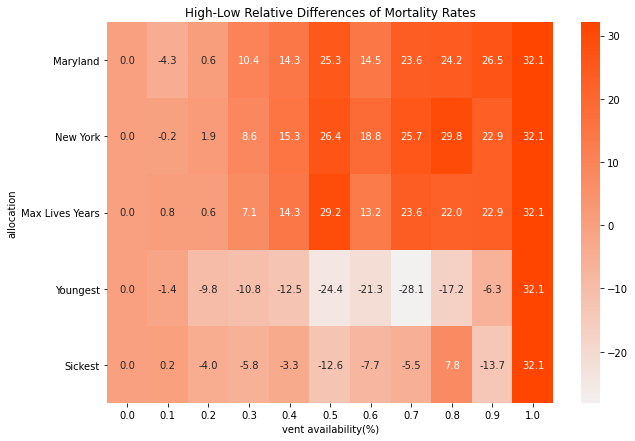

In [ ]:
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(df_diff_h_l_re, annot=True, fmt='.1f', cmap=sns.light_palette("#FF4500", as_cmap=True))
plt.title('High-Low Relative Differences of Mortality Rates')
#plt.savefig("figures_new/heat_mortality_diff_h_l_re_svi.png")

In [ ]:
display(df_diff_h_l_re.mean(axis=1).round(1).to_frame(name='AVG'))
dfi.export(df_diff_h_l_re.mean(axis=1).round(1).to_frame(name='AVG'), 'figures_new/tb_avg_mortality_diff_h_l_re_allo_svi.png')

display(df_diff_h_l_re.mean(axis=0).round(1).to_frame(name='AVG'))
dfi.export(df_diff_h_l_re.mean(axis=0).round(1).to_frame(name='AVG'), 'figures_new/tb_avg_mortality_diff_h_l_re_avai_svi.png')

AVG
allocation           
Maryland         15.2
New York         16.5
Max Lives Years  15.1
Youngest         -9.1
Sickest          -1.1
Lottery         -33.6

AVG
vent availability(%)      
0.0                    0.0
0.1                   -3.8
0.2                   -7.4
0.3                   -7.1
0.4                   -3.9
0.5                   -1.2
0.6                   -5.6
0.7                   -3.3
0.8                    2.4
0.9                    3.2
1.0                   32.1

In [ ]:
display(df_diff_h_l_re[ls_avai_1_9].mean(axis=1).round(1).to_frame(name='AVG'))
dfi.export(df_diff_h_l_re[ls_avai_1_9].mean(axis=1).round(1).to_frame(name='AVG'), 'figures_new/tb_avg_mortality_diff_h_l_re_allo_0.1_0.9_svi.png')

display(df_diff_h_l_re[ls_avai_1_9].mean(axis=0).round(1).to_frame(name='AVG'))
dfi.export(df_diff_h_l_re[ls_avai_1_9].mean(axis=0).round(1).to_frame(name='AVG'), 'figures_new/tb_avg_mortality_diff_h_l_re_avai_0.1_0.9_svi.png')

AVG
allocation           
Maryland         15.0
New York         16.6
Max Lives Years  14.9
Youngest        -14.6
Sickest          -5.0
Lottery         -44.7

AVG
vent availability(%)     
0.1                  -3.8
0.2                  -7.4
0.3                  -7.1
0.4                  -3.9
0.5                  -1.2
0.6                  -5.6
0.7                  -3.3
0.8                   2.4
0.9                   3.2

### Avg(Moderate-White & High-White) (Absolute)

In [ ]:
df_diff_m_l = df_m.subtract(df_l)
df_diff_h_l = df_h.subtract(df_l)
df_diff_m_h_l_avg_ab = df_diff_m_l.add(df_diff_h_l).divide(2)
df_diff_m_h_l_avg_ab = df_diff_m_h_l_avg_ab.round(1)
df_diff_m_h_l_avg_ab

vent availability(%)  0.0  0.1  0.2  0.3  0.4   0.5  0.6   0.7  0.8  0.9  1.0
allocation                                                                   
Maryland              0.0 -1.0  1.2  6.6  5.9   9.6  5.6   7.3  6.9  4.7  4.4
New York              0.0 -0.3  2.2  5.8  6.2   9.7  7.0   8.0  7.7  4.5  4.6
Max Lives Years       0.0  2.1  1.2  5.1  5.9  10.5  5.5   7.3  6.6  4.7  4.4
Youngest              0.0  0.5 -5.3 -3.7 -5.9 -10.8 -7.2 -10.6 -3.9 -0.5  4.4
Sickest               0.0  0.5 -3.8 -5.2 -2.4  -6.0 -1.7  -2.1  2.8 -3.8  4.4

Text(0.5, 1.0, 'AVG(Moderate-Low & High-Low) Absolute Difference of Mortality Rates')

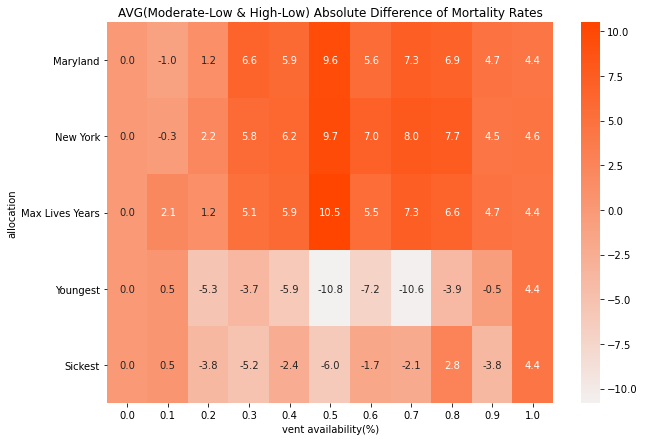

In [ ]:
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(df_diff_m_h_l_avg_ab, annot=True, fmt='.1f', cmap=sns.light_palette("#FF4500", as_cmap=True))
plt.title('AVG(Moderate-Low & High-Low) Absolute Difference of Mortality Rates')
#plt.savefig("figures_new/heat_mortality_diff_avg_ab_svi.png")

In [ ]:
display(df_diff_m_h_l_avg_ab.mean(axis=1).round(1).to_frame(name='AVG'))
dfi.export(df_diff_m_h_l_avg_ab.mean(axis=1).round(1).to_frame(name='AVG'), 'figures_new/tb_avg_mortality_diff_avg_ab_allo_svi.png')

display(df_diff_m_h_l_avg_ab.mean(axis=0).round(1).to_frame(name='AVG'))
dfi.export(df_diff_m_h_l_avg_ab.mean(axis=0).round(1).to_frame(name='AVG'), 'figures_new/tb_avg_mortality_diff_avg_ab_avai_svi.png')

AVG
allocation           
Maryland          4.7
New York          5.0
Max Lives Years   4.8
Youngest         -3.9
Sickest          -1.6
Lottery         -17.0

AVG
vent availability(%)     
0.0                   0.0
0.1                  -1.6
0.2                  -3.3
0.3                  -1.6
0.4                  -2.8
0.5                  -3.7
0.6                  -3.6
0.7                  -3.0
0.8                   0.4
0.9                   0.2
1.0                   4.4

In [ ]:
display(df_diff_m_h_l_avg_ab[ls_avai_1_9].mean(axis=1).round(1).to_frame(name='AVG'))
dfi.export(df_diff_m_h_l_avg_ab[ls_avai_1_9].mean(axis=1).round(1).to_frame(name='AVG'), 'figures_new/tb_avg_mortality_diff_avg_ab_allo_0.1_0.9_svi.png')

display(df_diff_m_h_l_avg_ab[ls_avai_1_9].mean(axis=0).round(1).to_frame(name='AVG'))
dfi.export(df_diff_m_h_l_avg_ab[ls_avai_1_9].mean(axis=0).round(1).to_frame(name='AVG'), 'figures_new/tb_avg_mortality_diff_avg_ab_avai_0.1_0.9_svi.png')

AVG
allocation           
Maryland          5.2
New York          5.6
Max Lives Years   5.4
Youngest         -5.3
Sickest          -2.4
Lottery         -21.2

AVG
vent availability(%)     
0.1                  -1.6
0.2                  -3.3
0.3                  -1.6
0.4                  -2.8
0.5                  -3.7
0.6                  -3.6
0.7                  -3.0
0.8                   0.4
0.9                   0.2

### Avg(Moderate-Low & High-Low) (Relative)

In [ ]:
df_diff_h_l_re = df_h.subtract(df_l)
df_diff_h_l_re = df_diff_h_l_re.divide(df_l)*100
df_diff_h_l_re = df_diff_h_l_re.round(1)
df_diff_h_l_re

vent availability(%)  0.0  0.1  0.2   0.3   0.4   0.5   0.6   0.7   0.8   0.9  \
allocation                                                                      
Maryland              0.0 -4.3  0.6  10.4  14.3  25.3  14.5  23.6  24.2  26.5   
New York              0.0 -0.2  1.9   8.6  15.3  26.4  18.8  25.7  29.8  22.9   
Max Lives Years       0.0  0.8  0.6   7.1  14.3  29.2  13.2  23.6  22.0  22.9   
Youngest              0.0 -1.4 -9.8 -10.8 -12.5 -24.4 -21.3 -28.1 -17.2  -6.3   
Sickest               0.0  0.2 -4.0  -5.8  -3.3 -12.6  -7.7  -5.5   7.8 -13.7   

vent availability(%)   1.0  
allocation                  
Maryland              32.1  
New York              32.1  
Max Lives Years       32.1  
Youngest              32.1  
Sickest               32.1

In [ ]:
df_diff_m_l_re = df_m.subtract(df_l)
df_diff_m_l_re = df_diff_m_l_re.divide(df_l)*100
df_diff_m_l_re = df_diff_m_l_re.round(1)

df_diff_h_l_re = df_h.subtract(df_l)
df_diff_h_l_re = df_diff_h_l_re.divide(df_l)*100
df_diff_h_l_re = df_diff_h_l_re.round(1)

df_diff_m_h_l_avg_re = df_diff_m_l_re.add(df_diff_h_l_re).divide(2)
df_diff_m_h_l_avg_re = df_diff_m_h_l_avg_re.round(1)
df_diff_m_h_l_avg_re

vent availability(%)  0.0  0.1  0.2   0.3   0.4   0.5   0.6   0.7   0.8   0.9  \
allocation                                                                      
Maryland              0.0 -1.1  1.5  10.1  10.4  21.5  14.2  24.2  31.0  27.6   
New York              0.0 -0.3  2.8   8.8  11.0  21.7  18.3  26.8  35.3  26.8   
Max Lives Years       0.0  2.4  1.5   7.6  10.4  23.8  14.0  24.2  29.8  27.6   
Youngest              0.0  0.5 -6.2  -4.9  -8.5 -18.0 -13.4 -22.0 -11.0  -2.0   
Sickest               0.0  0.5 -4.0  -6.2  -3.2  -8.6  -3.0  -4.4   8.0 -13.0   

vent availability(%)   1.0  
allocation                  
Maryland              33.2  
New York              34.8  
Max Lives Years       33.2  
Youngest              33.2  
Sickest               33.2

Text(0.5, 1.0, 'AVG(Moderate-Low & High-Low) Relative Difference of Mortality Rates')

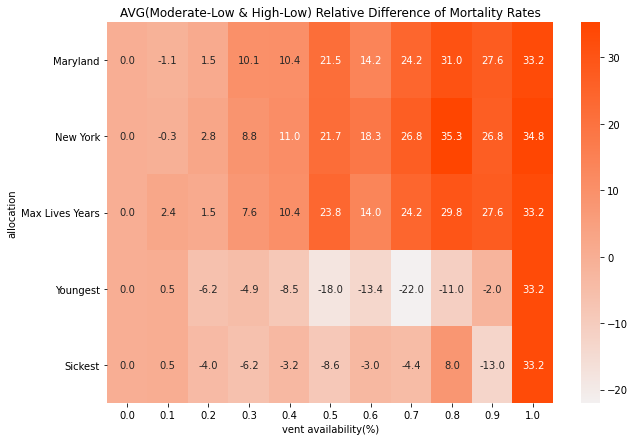

In [ ]:
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(df_diff_m_h_l_avg_re, annot=True, fmt='.1f', cmap=sns.light_palette("#FF4500", as_cmap=True))
plt.title('AVG(Moderate-Low & High-Low) Relative Difference of Mortality Rates')
#plt.savefig("figures_new/heat_mortality_diff_avg_re_svi.png")

In [ ]:
display(df_diff_m_h_l_avg_re.mean(axis=1).round(1).to_frame(name='AVG'))
dfi.export(df_diff_m_h_l_avg_re.mean(axis=1).round(1).to_frame(name='AVG'), 'figures_new/tb_avg_mortality_diff_avg_re_allo_svi.png')

display(df_diff_m_h_l_avg_re.mean(axis=0).round(1).to_frame(name='AVG'))
dfi.export(df_diff_m_h_l_avg_re.mean(axis=0).round(1).to_frame(name='AVG'), 'figures_new/tb_avg_mortality_diff_avg_re_avai_svi.png')

AVG
allocation           
Maryland         15.7
New York         16.9
Max Lives Years  15.9
Youngest         -4.8
Sickest          -0.1
Lottery         -22.5

AVG
vent availability(%)      
0.0                    0.0
0.1                   -1.6
0.2                   -3.5
0.3                   -1.0
0.4                   -2.0
0.5                   -0.4
0.6                   -2.2
0.7                    0.3
0.8                    8.9
0.9                    6.6
1.0                   33.5

In [ ]:
display(df_diff_m_h_l_avg_re[ls_avai_1_9].mean(axis=1).round(1).to_frame(name='AVG'))
dfi.export(df_diff_m_h_l_avg_re[ls_avai_1_9].mean(axis=1).round(1).to_frame(name='AVG'), 'figures_new/tb_avg_mortality_diff_avg_re_allo_0.1_0.9_svi.png')

display(df_diff_m_h_l_avg_re[ls_avai_1_9].mean(axis=0).round(1).to_frame(name='AVG'))
dfi.export(df_diff_m_h_l_avg_re[ls_avai_1_9].mean(axis=0).round(1).to_frame(name='AVG'), 'figures_new/tb_avg_mortality_diff_avg_re_avai_0.1_0.9_svi.png')

AVG
allocation           
Maryland         15.5
New York         16.8
Max Lives Years  15.7
Youngest         -9.5
Sickest          -3.8
Lottery         -31.2

AVG
vent availability(%)     
0.1                  -1.6
0.2                  -3.5
0.3                  -1.0
0.4                  -2.0
0.5                  -0.4
0.6                  -2.2
0.7                   0.3
0.8                   8.9
0.9                   6.6